In [ ]:
import ast
import math
import pickle
from collections import Counter, deque
import warnings
import numpy as np
import pandas as pd
import torch
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import (accuracy_score, average_precision_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.preprocessing import MultiLabelBinarizer
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import networkx as nx
import obonet
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
import random
import json

from utils_corrected import process_GO_data

# Keep  custom implementations of these functions since they have different signatures/implementations:
# - evaluate_annotations 
# - threshold_performance_metrics 
# - _calculate_metrics_at_threshold 
# - process_threshold

data_train_embeddings_path = r'processed_data_90_30/function_train.npy'
data_train_tsv_path = r'processed_data_90_30/function_train.tsv'
data_val_embeddings_path = r'processed_data_90_30/function_val.npy'
data_val_tsv_path = r'processed_data_90_30/function_val.tsv'

data_train_embeddings = np.load(data_train_embeddings_path)
data_val_embeddings = np.load(data_val_embeddings_path)
print(data_train_embeddings.shape, data_val_embeddings.shape)

data_train_tsv, data_train_embeddings, data_train_GO_list, data_train_GO_annotated = process_GO_data(data_train_tsv_path, data_train_embeddings)
data_val_tsv, data_val_embeddings, data_val_GO_list, data_val_GO_annotated = process_GO_data(data_val_tsv_path, data_val_embeddings)

print(data_train_tsv.shape, data_val_tsv.shape)

data_mlb = MultiLabelBinarizer()

data_train_labels = data_mlb.fit_transform(data_train_GO_list)
data_val_labels = data_mlb.transform(data_val_GO_list)
unique_data_train_terms = data_mlb.classes_


with open('./data_mlb.pkl', 'wb') as f:
    pickle.dump(data_mlb, f)


print(data_train_labels.shape, data_val_labels.shape)


(289930, 512) (29188, 512)
(289930, 14) (29188, 14)
(289930, 744) (29188, 744)


In [ ]:
def evaluate_annotations(ic_dict, real_annots, pred_annots):
    """
    Evaluates precision, recall, F1-score, remaining uncertainty (ru), and misinformation (mi)
    for a given set of real and predicted annotations using the IC dictionary.

    ic_dict: Dictionary mapping GO terms to IC values
    real_annots: List of true annotations for each protein
    pred_annots: List of predicted annotations for each protein
    """
    total = 0
    p_sum = 0.0
    r_sum = 0.0
    p_total = 0
    ru = 0.0
    mi = 0.0
    fps = []
    fns = []
    tp_global, fp_global, fn_global = 0, 0, 0  
    
    for i in range(len(real_annots)):
        if len(real_annots[i]) == 0:
            continue
        
        tp = set(real_annots[i]).intersection(set(pred_annots[i]))
        fp = pred_annots[i] - tp
        fn = real_annots[i] - tp
        
        tp_global += len(tp)
        fp_global += len(fp)
        fn_global += len(fn)
        
        for go_id in fp:
            if go_id in ic_dict:
                mi += ic_dict[go_id]
        
        for go_id in fn:
            if go_id in ic_dict:
                ru += ic_dict[go_id]
        
        fps.append(fp)
        fns.append(fn)
        total += 1
        
        recall = len(tp) / (len(tp) + len(fn)) if (len(tp) + len(fn)) > 0 else 0
        precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) > 0 else 0
        
        r_sum += recall
        if len(pred_annots[i]) > 0:
            p_total += 1
            p_sum += precision
    
    r = r_sum / total if total > 0 else 0
    p = p_sum / p_total if p_total > 0 else 0
    
    p_micro = tp_global / (tp_global + fp_global) if (tp_global + fp_global) > 0 else 0
    r_micro = tp_global / (tp_global + fn_global) if (tp_global + fn_global) > 0 else 0
    
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0
    f_micro = 2 * p_micro * r_micro / (p_micro + r_micro) if (p_micro + r_micro) > 0 else 0
    
    ru /= total
    mi /= total
    
    s = math.sqrt(ru * ru + mi * mi)
    
    return f, p, r, s, ru, mi, f_micro, p_micro, r_micro, tp_global, fp_global, fn_global






def process_threshold(threshold, ic_dict, y_true, y_pred_probs, mlb):
    """
    Helper function to calculate metrics at a specific threshold.
    This is called within parallelization support.

    threshold: The current threshold to evaluate
    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    mlb: MultiLabelBinarizer object

    """
    return _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, threshold, mlb)


def threshold_performance_metrics(ic_dict, y_true, y_pred_probs, threshold_range=None, set_threshold=None, n_jobs=1, mlb=None):
    """
    Calculates S-min and F-max over a range of thresholds or at a set threshold.

    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    threshold_range: Range of thresholds to evaluate (if None, only calculates metrics at set_threshold)
    set_threshold: Specific threshold to calculate metrics (if provided)
    mlb: MultiLabelBinarizer object for converting predictions and targets back to sets of terms
    n_jobs: Number of parallel jobs
    
    """
    
    if threshold_range is None and set_threshold is None:
        raise ValueError("Either threshold_range or set_threshold must be provided.")
    
    if set_threshold is not None:
        # Calculate metrics for the given set threshold only
        return _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, set_threshold, mlb)

    smin = float('inf')
    fmax = 0
    best_threshold_s = None
    best_threshold_f = None
    s_at_fmax = None
    results = []

    # Parallelization support
    if n_jobs > 1:
        with Pool(n_jobs) as pool:
            results = list(tqdm(pool.imap(lambda t: process_threshold(t, ic_dict, y_true, y_pred_probs, mlb), threshold_range), total=len(threshold_range)))
    else:
        results = [process_threshold(threshold, ic_dict, y_true, y_pred_probs, mlb) for threshold in tqdm(threshold_range, desc='Calculating Smin & Fmax')]

    results_df = pd.DataFrame(results)

    for row in results:
        if row['s'] < smin:
            smin = row['s']
            best_threshold_s = row['n']
        if row['f'] > fmax:
            fmax = row['f']
            best_threshold_f = row['n']
            s_at_fmax = row['s']  

    print(f"F-max @ Best Threshold ({best_threshold_f}): {fmax}")
    print(f"S-min @ Best Threshold ({best_threshold_s}): {smin}")
    print(f"S-min @ F-max Threshold ({best_threshold_f}): {s_at_fmax}")

    return smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df



def _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, threshold, mlb):
    """
    Helper function to calculate metrics at a specific threshold.

    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    threshold: Specific threshold to calculate metrics
    mlb: MultiLabelBinarizer object
    """
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    pred_annotations = mlb.inverse_transform(y_pred_binary)
    pred_annots_inverse = [set(item) for item in pred_annotations]
    
    test_targets_inverse = mlb.inverse_transform(y_true)
    real_annots_inverse = [set(item) for item in test_targets_inverse]

    f, p, r, s, ru, mi, f_micro, p_micro, r_micro, tp_global, fp_global, fn_global = evaluate_annotations(ic_dict, real_annots_inverse, pred_annots_inverse)
    
    cov = len([1 for preds in pred_annotations if len(preds) > 0]) / len(y_true)
    
    return {
        'n': threshold, 
        'tp': tp_global, 
        'fp': fp_global, 
        'fn': fn_global, 
        'pr': p, 
        'rc': r, 
        'cov': cov, 
        'mi': mi, 
        'ru': ru, 
        'f': f, 
        's': s, 
        'pr_micro': p_micro, 
        'rc_micro': r_micro, 
        'f_micro': f_micro, 
        'cov_max': cov
    }


In [ ]:
ia_df = pd.read_csv(r'IA_all.tsv', sep='\t', header=None)
ia_df.columns = ['GO', 'IA']

ic_dict = dict(zip(ia_df['GO'], ia_df['IA']))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_train_dataset = TensorDataset(torch.tensor(data_train_embeddings, dtype=torch.float).to(device),
                                       torch.tensor(data_train_labels, dtype=torch.float).to(device))
data_val_dataset = TensorDataset(torch.tensor(data_val_embeddings, dtype=torch.float).to(device),
                                     torch.tensor(data_val_labels, dtype=torch.float).to(device))

data_train_loader = DataLoader(data_train_dataset, batch_size=1024, shuffle=True)
data_val_loader = DataLoader(data_val_dataset, batch_size=1024, shuffle=False)

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.4):
        super(FFNN, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.LeakyReLU())
        
        if dims[-1] != 2:  # Apply dropout only before the last output layer, if the last hidden layer is not 2D
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(dims[-1], output_dim))  # Final layer (output layer)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def save_to_tsv(filename, data, mlb):
    with open(filename, 'w') as f:
        for i, row in enumerate(data):
            for j, val in enumerate(row):
                if val >= 0.01:  # Using threshold 0.5 for binary classification
                    term = mlb.classes_[j]
                    f.write(f"T_{i + 1}\t{term}\t{val:.4f}\n")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    train_losses = []
    val_losses = []

    print("Starting training...")
    
    for epoch in tqdm(range(num_epochs), desc=f"Epoch progress"):
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validate after each epoch
        val_loss = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}')

    print("Training completed.")
    return train_losses, val_losses

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

def run_prediction_tsv(model, val_loader, mlb, num_epochs, lr, arch):
    model.eval()
    all_preds = []
    all_targets = []

    print("Generating prediction TSVs...")
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid for probability outputs
            all_preds.append(preds)
            all_targets.append(y_batch.cpu().numpy())

    # Stack predictions and targets into numpy arrays
    predictions = np.vstack(all_preds)

    pred_file = f"predictions_lr{lr}_arch{arch}_epochs{num_epochs}.tsv"
    save_to_tsv(pred_file, predictions, mlb)
    print(f"Saved: {pred_file}")

def save_ground_truth(val_loader, mlb):
    print("Generating ground truth TSV once...")
    all_targets = []
    with torch.no_grad():
        for _, y_batch in val_loader:
            all_targets.append(y_batch.cpu().numpy())
    
    targets = np.vstack(all_targets)
    
    truth_file = "ground_truth.tsv"
    save_to_tsv(truth_file, targets, mlb)
    print(f"Ground truth saved: {truth_file}")

architectures = [
    [256],  # 512 → 256
    [256, 128],  # 512 → 256 → 128
    [256, 128, 64],  # 512 → 256 → 128 → 64
    [256, 128, 62, 32],  # 512 → 256 → 128 → 62 → 32
    # [256, 128, 62, 32, 16],
    # [256, 128, 62, 32, 16, 8],
    # [256, 128, 62, 32, 16, 8, 4],
    # [256, 128, 62, 32, 16, 8, 4, 2]
]

learning_rates = [0.01, 0.001, 0.0001, 0.00001]
epoch_counts = [10, 15, 20, 30, 40]



Using device: cuda



Training with LR: 0.01, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:09<01:21,  9.08s/it]

Epoch [1/10] | Train Loss: 0.0247 | Val Loss: 0.0123


Epoch progress:  20%|██        | 2/10 [00:10<00:37,  4.70s/it]

Epoch [2/10] | Train Loss: 0.0114 | Val Loss: 0.0104


Epoch progress:  30%|███       | 3/10 [00:12<00:23,  3.42s/it]

Epoch [3/10] | Train Loss: 0.0101 | Val Loss: 0.0099


Epoch progress:  40%|████      | 4/10 [00:14<00:16,  2.79s/it]

Epoch [4/10] | Train Loss: 0.0096 | Val Loss: 0.0099


Epoch progress:  50%|█████     | 5/10 [00:16<00:11,  2.40s/it]

Epoch [5/10] | Train Loss: 0.0094 | Val Loss: 0.0098


Epoch progress:  60%|██████    | 6/10 [00:17<00:08,  2.18s/it]

Epoch [6/10] | Train Loss: 0.0093 | Val Loss: 0.0098


Epoch progress:  70%|███████   | 7/10 [00:19<00:06,  2.01s/it]

Epoch [7/10] | Train Loss: 0.0092 | Val Loss: 0.0103


Epoch progress:  80%|████████  | 8/10 [00:21<00:03,  1.90s/it]

Epoch [8/10] | Train Loss: 0.0092 | Val Loss: 0.0098


Epoch progress:  90%|█████████ | 9/10 [00:22<00:01,  1.79s/it]

Epoch [9/10] | Train Loss: 0.0093 | Val Loss: 0.0103


Epoch progress: 100%|██████████| 10/10 [00:24<00:00,  2.44s/it]

Epoch [10/10] | Train Loss: 0.0093 | Val Loss: 0.0106
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8710934476663719
S-min @ Best Threshold (0.30000000000000004): 2.6008254990369566
S-min @ F-max Threshold (0.30000000000000004): 2.6008254990369566
Saved metrics to: metrics_lr0.01_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=10

Training with LR: 0.01, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:24,  1.78s/it]

Epoch [1/15] | Train Loss: 0.0249 | Val Loss: 0.0124


Epoch progress:  13%|█▎        | 2/15 [00:03<00:21,  1.68s/it]

Epoch [2/15] | Train Loss: 0.0113 | Val Loss: 0.0105


Epoch progress:  20%|██        | 3/15 [00:04<00:18,  1.56s/it]

Epoch [3/15] | Train Loss: 0.0101 | Val Loss: 0.0100


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]

Epoch [4/15] | Train Loss: 0.0096 | Val Loss: 0.0102


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.61s/it]

Epoch [5/15] | Train Loss: 0.0093 | Val Loss: 0.0100


Epoch progress:  40%|████      | 6/15 [00:10<00:15,  1.71s/it]

Epoch [6/15] | Train Loss: 0.0092 | Val Loss: 0.0100


Epoch progress:  47%|████▋     | 7/15 [00:11<00:14,  1.78s/it]

Epoch [7/15] | Train Loss: 0.0092 | Val Loss: 0.0102


Epoch progress:  53%|█████▎    | 8/15 [00:14<00:14,  2.06s/it]

Epoch [8/15] | Train Loss: 0.0093 | Val Loss: 0.0098


Epoch progress:  60%|██████    | 9/15 [00:17<00:13,  2.27s/it]

Epoch [9/15] | Train Loss: 0.0091 | Val Loss: 0.0099


Epoch progress:  67%|██████▋   | 10/15 [00:20<00:12,  2.41s/it]

Epoch [10/15] | Train Loss: 0.0093 | Val Loss: 0.0104


Epoch progress:  73%|███████▎  | 11/15 [00:22<00:10,  2.50s/it]

Epoch [11/15] | Train Loss: 0.0092 | Val Loss: 0.0104


Epoch progress:  80%|████████  | 12/15 [00:25<00:07,  2.57s/it]

Epoch [12/15] | Train Loss: 0.0092 | Val Loss: 0.0107


Epoch progress:  87%|████████▋ | 13/15 [00:28<00:05,  2.59s/it]

Epoch [13/15] | Train Loss: 0.0092 | Val Loss: 0.0104


Epoch progress:  93%|█████████▎| 14/15 [00:30<00:02,  2.60s/it]

Epoch [14/15] | Train Loss: 0.0094 | Val Loss: 0.0105


Epoch progress: 100%|██████████| 15/15 [00:33<00:00,  2.22s/it]

Epoch [15/15] | Train Loss: 0.0093 | Val Loss: 0.0101
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


F-max @ Best Threshold (0.4): 0.8769408622211183
S-min @ Best Threshold (0.30000000000000004): 2.4915620703920442
S-min @ F-max Threshold (0.4): 2.581067522261297
Saved metrics to: metrics_lr0.01_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=15

Training with LR: 0.01, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:32,  1.70s/it]

Epoch [1/20] | Train Loss: 0.0243 | Val Loss: 0.0122


Epoch progress:  10%|█         | 2/20 [00:03<00:29,  1.64s/it]

Epoch [2/20] | Train Loss: 0.0112 | Val Loss: 0.0105


Epoch progress:  15%|█▌        | 3/20 [00:05<00:31,  1.84s/it]

Epoch [3/20] | Train Loss: 0.0100 | Val Loss: 0.0102


Epoch progress:  20%|██        | 4/20 [00:08<00:35,  2.19s/it]

Epoch [4/20] | Train Loss: 0.0095 | Val Loss: 0.0103


Epoch progress:  25%|██▌       | 5/20 [00:10<00:31,  2.10s/it]

Epoch [5/20] | Train Loss: 0.0093 | Val Loss: 0.0101


Epoch progress:  30%|███       | 6/20 [00:12<00:29,  2.14s/it]

Epoch [6/20] | Train Loss: 0.0092 | Val Loss: 0.0101


Epoch progress:  35%|███▌      | 7/20 [00:14<00:29,  2.31s/it]

Epoch [7/20] | Train Loss: 0.0092 | Val Loss: 0.0102


Epoch progress:  40%|████      | 8/20 [00:17<00:29,  2.43s/it]

Epoch [8/20] | Train Loss: 0.0092 | Val Loss: 0.0105


Epoch progress:  45%|████▌     | 9/20 [00:20<00:27,  2.48s/it]

Epoch [9/20] | Train Loss: 0.0092 | Val Loss: 0.0102


Epoch progress:  50%|█████     | 10/20 [00:22<00:25,  2.55s/it]

Epoch [10/20] | Train Loss: 0.0093 | Val Loss: 0.0103


Epoch progress:  55%|█████▌    | 11/20 [00:25<00:23,  2.61s/it]

Epoch [11/20] | Train Loss: 0.0093 | Val Loss: 0.0102


Epoch progress:  60%|██████    | 12/20 [00:28<00:21,  2.64s/it]

Epoch [12/20] | Train Loss: 0.0092 | Val Loss: 0.0105


Epoch progress:  65%|██████▌   | 13/20 [00:31<00:18,  2.66s/it]

Epoch [13/20] | Train Loss: 0.0093 | Val Loss: 0.0106


Epoch progress:  70%|███████   | 14/20 [00:33<00:16,  2.68s/it]

Epoch [14/20] | Train Loss: 0.0094 | Val Loss: 0.0108


Epoch progress:  75%|███████▌  | 15/20 [00:36<00:13,  2.70s/it]

Epoch [15/20] | Train Loss: 0.0093 | Val Loss: 0.0106


Epoch progress:  80%|████████  | 16/20 [00:39<00:10,  2.70s/it]

Epoch [16/20] | Train Loss: 0.0094 | Val Loss: 0.0110


Epoch progress:  85%|████████▌ | 17/20 [00:42<00:08,  2.73s/it]

Epoch [17/20] | Train Loss: 0.0092 | Val Loss: 0.0103


Epoch progress:  90%|█████████ | 18/20 [00:43<00:04,  2.45s/it]

Epoch [18/20] | Train Loss: 0.0092 | Val Loss: 0.0103


Epoch progress:  95%|█████████▌| 19/20 [00:45<00:02,  2.26s/it]

Epoch [19/20] | Train Loss: 0.0092 | Val Loss: 0.0105


Epoch progress: 100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Epoch [20/20] | Train Loss: 0.0091 | Val Loss: 0.0109
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


F-max @ Best Threshold (0.4): 0.8739982607141161
S-min @ Best Threshold (0.30000000000000004): 2.5711044989628657
S-min @ F-max Threshold (0.4): 2.698601947365214
Saved metrics to: metrics_lr0.01_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=20

Training with LR: 0.01, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:53,  1.83s/it]

Epoch [1/30] | Train Loss: 0.0247 | Val Loss: 0.0124


Epoch progress:   7%|▋         | 2/30 [00:03<00:53,  1.91s/it]

Epoch [2/30] | Train Loss: 0.0114 | Val Loss: 0.0107


Epoch progress:  10%|█         | 3/30 [00:05<00:51,  1.92s/it]

Epoch [3/30] | Train Loss: 0.0101 | Val Loss: 0.0101


Epoch progress:  13%|█▎        | 4/30 [00:07<00:46,  1.80s/it]

Epoch [4/30] | Train Loss: 0.0096 | Val Loss: 0.0100


Epoch progress:  17%|█▋        | 5/30 [00:09<00:44,  1.76s/it]

Epoch [5/30] | Train Loss: 0.0093 | Val Loss: 0.0102


Epoch progress:  20%|██        | 6/30 [00:10<00:43,  1.81s/it]

Epoch [6/30] | Train Loss: 0.0093 | Val Loss: 0.0098


Epoch progress:  23%|██▎       | 7/30 [00:12<00:42,  1.86s/it]

Epoch [7/30] | Train Loss: 0.0092 | Val Loss: 0.0099


Epoch progress:  27%|██▋       | 8/30 [00:15<00:47,  2.14s/it]

Epoch [8/30] | Train Loss: 0.0091 | Val Loss: 0.0104


Epoch progress:  30%|███       | 9/30 [00:17<00:43,  2.05s/it]

Epoch [9/30] | Train Loss: 0.0092 | Val Loss: 0.0101


Epoch progress:  33%|███▎      | 10/30 [00:19<00:42,  2.11s/it]

Epoch [10/30] | Train Loss: 0.0092 | Val Loss: 0.0100


Epoch progress:  37%|███▋      | 11/30 [00:22<00:43,  2.27s/it]

Epoch [11/30] | Train Loss: 0.0092 | Val Loss: 0.0103


Epoch progress:  40%|████      | 12/30 [00:25<00:42,  2.39s/it]

Epoch [12/30] | Train Loss: 0.0092 | Val Loss: 0.0102


Epoch progress:  43%|████▎     | 13/30 [00:27<00:41,  2.46s/it]

Epoch [13/30] | Train Loss: 0.0092 | Val Loss: 0.0103


Epoch progress:  47%|████▋     | 14/30 [00:30<00:40,  2.53s/it]

Epoch [14/30] | Train Loss: 0.0093 | Val Loss: 0.0105


Epoch progress:  50%|█████     | 15/30 [00:32<00:38,  2.56s/it]

Epoch [15/30] | Train Loss: 0.0092 | Val Loss: 0.0104


Epoch progress:  53%|█████▎    | 16/30 [00:35<00:35,  2.55s/it]

Epoch [16/30] | Train Loss: 0.0093 | Val Loss: 0.0104


Epoch progress:  57%|█████▋    | 17/30 [00:38<00:33,  2.59s/it]

Epoch [17/30] | Train Loss: 0.0093 | Val Loss: 0.0112


Epoch progress:  60%|██████    | 18/30 [00:40<00:31,  2.62s/it]

Epoch [18/30] | Train Loss: 0.0096 | Val Loss: 0.0109


Epoch progress:  63%|██████▎   | 19/30 [00:43<00:28,  2.63s/it]

Epoch [19/30] | Train Loss: 0.0092 | Val Loss: 0.0105


Epoch progress:  67%|██████▋   | 20/30 [00:46<00:26,  2.63s/it]

Epoch [20/30] | Train Loss: 0.0091 | Val Loss: 0.0103


Epoch progress:  70%|███████   | 21/30 [00:48<00:23,  2.64s/it]

Epoch [21/30] | Train Loss: 0.0091 | Val Loss: 0.0103


Epoch progress:  73%|███████▎  | 22/30 [00:51<00:21,  2.63s/it]

Epoch [22/30] | Train Loss: 0.0090 | Val Loss: 0.0106


Epoch progress:  77%|███████▋  | 23/30 [00:54<00:18,  2.63s/it]

Epoch [23/30] | Train Loss: 0.0090 | Val Loss: 0.0105


Epoch progress:  80%|████████  | 24/30 [00:56<00:15,  2.63s/it]

Epoch [24/30] | Train Loss: 0.0089 | Val Loss: 0.0105


Epoch progress:  83%|████████▎ | 25/30 [00:59<00:13,  2.64s/it]

Epoch [25/30] | Train Loss: 0.0088 | Val Loss: 0.0103


Epoch progress:  87%|████████▋ | 26/30 [01:01<00:10,  2.62s/it]

Epoch [26/30] | Train Loss: 0.0088 | Val Loss: 0.0106


Epoch progress:  90%|█████████ | 27/30 [01:04<00:07,  2.64s/it]

Epoch [27/30] | Train Loss: 0.0088 | Val Loss: 0.0102


Epoch progress:  93%|█████████▎| 28/30 [01:07<00:05,  2.59s/it]

Epoch [28/30] | Train Loss: 0.0089 | Val Loss: 0.0102


Epoch progress:  97%|█████████▋| 29/30 [01:09<00:02,  2.61s/it]

Epoch [29/30] | Train Loss: 0.0087 | Val Loss: 0.0111


Epoch progress: 100%|██████████| 30/30 [01:12<00:00,  2.41s/it]

Epoch [30/30] | Train Loss: 0.0088 | Val Loss: 0.0104
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


F-max @ Best Threshold (0.4): 0.8744620676579717
S-min @ Best Threshold (0.30000000000000004): 2.5238477816707245
S-min @ F-max Threshold (0.4): 2.6523161927185916
Saved metrics to: metrics_lr0.01_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=30

Training with LR: 0.01, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:10,  1.80s/it]

Epoch [1/40] | Train Loss: 0.0242 | Val Loss: 0.0122


Epoch progress:   5%|▌         | 2/40 [00:03<01:08,  1.82s/it]

Epoch [2/40] | Train Loss: 0.0112 | Val Loss: 0.0105


Epoch progress:   8%|▊         | 3/40 [00:05<01:06,  1.80s/it]

Epoch [3/40] | Train Loss: 0.0100 | Val Loss: 0.0102


Epoch progress:  10%|█         | 4/40 [00:07<01:12,  2.01s/it]

Epoch [4/40] | Train Loss: 0.0096 | Val Loss: 0.0101


Epoch progress:  12%|█▎        | 5/40 [00:10<01:18,  2.24s/it]

Epoch [5/40] | Train Loss: 0.0094 | Val Loss: 0.0101


Epoch progress:  15%|█▌        | 6/40 [00:13<01:21,  2.38s/it]

Epoch [6/40] | Train Loss: 0.0093 | Val Loss: 0.0100


Epoch progress:  18%|█▊        | 7/40 [00:15<01:19,  2.42s/it]

Epoch [7/40] | Train Loss: 0.0092 | Val Loss: 0.0099


Epoch progress:  20%|██        | 8/40 [00:18<01:19,  2.49s/it]

Epoch [8/40] | Train Loss: 0.0093 | Val Loss: 0.0101


Epoch progress:  22%|██▎       | 9/40 [00:20<01:18,  2.53s/it]

Epoch [9/40] | Train Loss: 0.0092 | Val Loss: 0.0101


Epoch progress:  25%|██▌       | 10/40 [00:23<01:16,  2.54s/it]

Epoch [10/40] | Train Loss: 0.0092 | Val Loss: 0.0103


Epoch progress:  28%|██▊       | 11/40 [00:25<01:14,  2.57s/it]

Epoch [11/40] | Train Loss: 0.0093 | Val Loss: 0.0104


Epoch progress:  30%|███       | 12/40 [00:28<01:12,  2.58s/it]

Epoch [12/40] | Train Loss: 0.0093 | Val Loss: 0.0104


Epoch progress:  32%|███▎      | 13/40 [00:31<01:10,  2.59s/it]

Epoch [13/40] | Train Loss: 0.0093 | Val Loss: 0.0105


Epoch progress:  35%|███▌      | 14/40 [00:33<01:07,  2.60s/it]

Epoch [14/40] | Train Loss: 0.0093 | Val Loss: 0.0104


Epoch progress:  38%|███▊      | 15/40 [00:36<01:05,  2.60s/it]

Epoch [15/40] | Train Loss: 0.0093 | Val Loss: 0.0102


Epoch progress:  40%|████      | 16/40 [00:39<01:02,  2.60s/it]

Epoch [16/40] | Train Loss: 0.0093 | Val Loss: 0.0107


Epoch progress:  42%|████▎     | 17/40 [00:41<00:59,  2.61s/it]

Epoch [17/40] | Train Loss: 0.0094 | Val Loss: 0.0107


Epoch progress:  45%|████▌     | 18/40 [00:44<00:57,  2.61s/it]

Epoch [18/40] | Train Loss: 0.0094 | Val Loss: 0.0108


Epoch progress:  48%|████▊     | 19/40 [00:46<00:54,  2.61s/it]

Epoch [19/40] | Train Loss: 0.0095 | Val Loss: 0.0106


Epoch progress:  50%|█████     | 20/40 [00:49<00:51,  2.58s/it]

Epoch [20/40] | Train Loss: 0.0093 | Val Loss: 0.0107


Epoch progress:  52%|█████▎    | 21/40 [00:52<00:49,  2.60s/it]

Epoch [21/40] | Train Loss: 0.0091 | Val Loss: 0.0106


Epoch progress:  55%|█████▌    | 22/40 [00:54<00:47,  2.62s/it]

Epoch [22/40] | Train Loss: 0.0090 | Val Loss: 0.0106


Epoch progress:  57%|█████▊    | 23/40 [00:57<00:44,  2.62s/it]

Epoch [23/40] | Train Loss: 0.0090 | Val Loss: 0.0108


Epoch progress:  60%|██████    | 24/40 [01:00<00:42,  2.63s/it]

Epoch [24/40] | Train Loss: 0.0090 | Val Loss: 0.0105


Epoch progress:  62%|██████▎   | 25/40 [01:02<00:39,  2.62s/it]

Epoch [25/40] | Train Loss: 0.0089 | Val Loss: 0.0106


Epoch progress:  65%|██████▌   | 26/40 [01:05<00:36,  2.62s/it]

Epoch [26/40] | Train Loss: 0.0088 | Val Loss: 0.0102


Epoch progress:  68%|██████▊   | 27/40 [01:07<00:34,  2.62s/it]

Epoch [27/40] | Train Loss: 0.0087 | Val Loss: 0.0101


Epoch progress:  70%|███████   | 28/40 [01:10<00:31,  2.64s/it]

Epoch [28/40] | Train Loss: 0.0086 | Val Loss: 0.0101


Epoch progress:  72%|███████▎  | 29/40 [01:12<00:25,  2.33s/it]

Epoch [29/40] | Train Loss: 0.0086 | Val Loss: 0.0103


Epoch progress:  75%|███████▌  | 30/40 [01:13<00:20,  2.10s/it]

Epoch [30/40] | Train Loss: 0.0086 | Val Loss: 0.0104


Epoch progress:  78%|███████▊  | 31/40 [01:15<00:19,  2.15s/it]

Epoch [31/40] | Train Loss: 0.0085 | Val Loss: 0.0104


Epoch progress:  80%|████████  | 32/40 [01:18<00:17,  2.25s/it]

Epoch [32/40] | Train Loss: 0.0085 | Val Loss: 0.0104


Epoch progress:  82%|████████▎ | 33/40 [01:21<00:16,  2.36s/it]

Epoch [33/40] | Train Loss: 0.0085 | Val Loss: 0.0103


Epoch progress:  85%|████████▌ | 34/40 [01:23<00:14,  2.45s/it]

Epoch [34/40] | Train Loss: 0.0085 | Val Loss: 0.0104


Epoch progress:  88%|████████▊ | 35/40 [01:26<00:12,  2.50s/it]

Epoch [35/40] | Train Loss: 0.0085 | Val Loss: 0.0103


Epoch progress:  90%|█████████ | 36/40 [01:28<00:10,  2.54s/it]

Epoch [36/40] | Train Loss: 0.0085 | Val Loss: 0.0104


Epoch progress:  92%|█████████▎| 37/40 [01:31<00:07,  2.56s/it]

Epoch [37/40] | Train Loss: 0.0084 | Val Loss: 0.0104


Epoch progress:  95%|█████████▌| 38/40 [01:34<00:05,  2.58s/it]

Epoch [38/40] | Train Loss: 0.0084 | Val Loss: 0.0104


Epoch progress:  98%|█████████▊| 39/40 [01:36<00:02,  2.61s/it]

Epoch [39/40] | Train Loss: 0.0084 | Val Loss: 0.0102


Epoch progress: 100%|██████████| 40/40 [01:39<00:00,  2.49s/it]

Epoch [40/40] | Train Loss: 0.0084 | Val Loss: 0.0104
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8767494513908763
S-min @ Best Threshold (0.30000000000000004): 2.526891626248336
S-min @ F-max Threshold (0.30000000000000004): 2.526891626248336
Saved metrics to: metrics_lr0.01_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:17,  1.92s/it]

Epoch [1/10] | Train Loss: 0.0273 | Val Loss: 0.0133


Epoch progress:  20%|██        | 2/10 [00:04<00:17,  2.23s/it]

Epoch [2/10] | Train Loss: 0.0116 | Val Loss: 0.0113


Epoch progress:  30%|███       | 3/10 [00:07<00:17,  2.51s/it]

Epoch [3/10] | Train Loss: 0.0098 | Val Loss: 0.0106


Epoch progress:  40%|████      | 4/10 [00:10<00:15,  2.65s/it]

Epoch [4/10] | Train Loss: 0.0092 | Val Loss: 0.0106


Epoch progress:  50%|█████     | 5/10 [00:12<00:13,  2.73s/it]

Epoch [5/10] | Train Loss: 0.0087 | Val Loss: 0.0103


Epoch progress:  60%|██████    | 6/10 [00:15<00:11,  2.78s/it]

Epoch [6/10] | Train Loss: 0.0082 | Val Loss: 0.0100


Epoch progress:  70%|███████   | 7/10 [00:18<00:08,  2.81s/it]

Epoch [7/10] | Train Loss: 0.0079 | Val Loss: 0.0099


Epoch progress:  80%|████████  | 8/10 [00:21<00:05,  2.82s/it]

Epoch [8/10] | Train Loss: 0.0078 | Val Loss: 0.0099


Epoch progress:  90%|█████████ | 9/10 [00:24<00:02,  2.81s/it]

Epoch [9/10] | Train Loss: 0.0077 | Val Loss: 0.0100


Epoch progress: 100%|██████████| 10/10 [00:27<00:00,  2.72s/it]

Epoch [10/10] | Train Loss: 0.0076 | Val Loss: 0.0100
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.4): 0.8790108363487593
S-min @ Best Threshold (0.30000000000000004): 2.5668802824013266
S-min @ F-max Threshold (0.4): 2.610355254741765
Saved metrics to: metrics_lr0.01_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:25,  1.85s/it]

Epoch [1/15] | Train Loss: 0.0271 | Val Loss: 0.0133


Epoch progress:  13%|█▎        | 2/15 [00:03<00:22,  1.77s/it]

Epoch [2/15] | Train Loss: 0.0115 | Val Loss: 0.0111


Epoch progress:  20%|██        | 3/15 [00:06<00:24,  2.08s/it]

Epoch [3/15] | Train Loss: 0.0098 | Val Loss: 0.0107


Epoch progress:  27%|██▋       | 4/15 [00:08<00:26,  2.41s/it]

Epoch [4/15] | Train Loss: 0.0090 | Val Loss: 0.0103


Epoch progress:  33%|███▎      | 5/15 [00:11<00:25,  2.60s/it]

Epoch [5/15] | Train Loss: 0.0089 | Val Loss: 0.0103


Epoch progress:  40%|████      | 6/15 [00:13<00:20,  2.31s/it]

Epoch [6/15] | Train Loss: 0.0084 | Val Loss: 0.0105


Epoch progress:  47%|████▋     | 7/15 [00:16<00:19,  2.39s/it]

Epoch [7/15] | Train Loss: 0.0083 | Val Loss: 0.0103


Epoch progress:  53%|█████▎    | 8/15 [00:19<00:17,  2.55s/it]

Epoch [8/15] | Train Loss: 0.0081 | Val Loss: 0.0104


Epoch progress:  60%|██████    | 9/15 [00:22<00:16,  2.68s/it]

Epoch [9/15] | Train Loss: 0.0079 | Val Loss: 0.0101


Epoch progress:  67%|██████▋   | 10/15 [00:24<00:13,  2.76s/it]

Epoch [10/15] | Train Loss: 0.0077 | Val Loss: 0.0101


Epoch progress:  73%|███████▎  | 11/15 [00:27<00:11,  2.82s/it]

Epoch [11/15] | Train Loss: 0.0076 | Val Loss: 0.0102


Epoch progress:  80%|████████  | 12/15 [00:29<00:07,  2.48s/it]

Epoch [12/15] | Train Loss: 0.0075 | Val Loss: 0.0102


Epoch progress:  87%|████████▋ | 13/15 [00:32<00:04,  2.46s/it]

Epoch [13/15] | Train Loss: 0.0079 | Val Loss: 0.0105


Epoch progress:  93%|█████████▎| 14/15 [00:33<00:02,  2.24s/it]

Epoch [14/15] | Train Loss: 0.0075 | Val Loss: 0.0103


Epoch progress: 100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


Epoch [15/15] | Train Loss: 0.0076 | Val Loss: 0.0106
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.4): 0.8779069301687586
S-min @ Best Threshold (0.30000000000000004): 2.563928216389833
S-min @ F-max Threshold (0.4): 2.5944188667868144
Saved metrics to: metrics_lr0.01_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:37,  1.96s/it]

Epoch [1/20] | Train Loss: 0.0265 | Val Loss: 0.0132


Epoch progress:  10%|█         | 2/20 [00:04<00:36,  2.02s/it]

Epoch [2/20] | Train Loss: 0.0115 | Val Loss: 0.0111


Epoch progress:  15%|█▌        | 3/20 [00:05<00:33,  1.95s/it]

Epoch [3/20] | Train Loss: 0.0097 | Val Loss: 0.0104


Epoch progress:  20%|██        | 4/20 [00:08<00:37,  2.32s/it]

Epoch [4/20] | Train Loss: 0.0090 | Val Loss: 0.0103


Epoch progress:  25%|██▌       | 5/20 [00:11<00:38,  2.55s/it]

Epoch [5/20] | Train Loss: 0.0085 | Val Loss: 0.0098


Epoch progress:  30%|███       | 6/20 [00:14<00:37,  2.70s/it]

Epoch [6/20] | Train Loss: 0.0082 | Val Loss: 0.0101


Epoch progress:  35%|███▌      | 7/20 [00:16<00:31,  2.43s/it]

Epoch [7/20] | Train Loss: 0.0081 | Val Loss: 0.0100


Epoch progress:  40%|████      | 8/20 [00:18<00:27,  2.25s/it]

Epoch [8/20] | Train Loss: 0.0079 | Val Loss: 0.0102


Epoch progress:  45%|████▌     | 9/20 [00:20<00:24,  2.20s/it]

Epoch [9/20] | Train Loss: 0.0077 | Val Loss: 0.0100


Epoch progress:  50%|█████     | 10/20 [00:22<00:20,  2.04s/it]

Epoch [10/20] | Train Loss: 0.0076 | Val Loss: 0.0104


Epoch progress:  55%|█████▌    | 11/20 [00:24<00:19,  2.12s/it]

Epoch [11/20] | Train Loss: 0.0076 | Val Loss: 0.0106


Epoch progress:  60%|██████    | 12/20 [00:26<00:16,  2.08s/it]

Epoch [12/20] | Train Loss: 0.0075 | Val Loss: 0.0105


Epoch progress:  65%|██████▌   | 13/20 [00:28<00:13,  1.98s/it]

Epoch [13/20] | Train Loss: 0.0077 | Val Loss: 0.0109


Epoch progress:  70%|███████   | 14/20 [00:31<00:13,  2.22s/it]

Epoch [14/20] | Train Loss: 0.0075 | Val Loss: 0.0104


Epoch progress:  75%|███████▌  | 15/20 [00:33<00:11,  2.25s/it]

Epoch [15/20] | Train Loss: 0.0073 | Val Loss: 0.0103


Epoch progress:  80%|████████  | 16/20 [00:35<00:08,  2.12s/it]

Epoch [16/20] | Train Loss: 0.0076 | Val Loss: 0.0107


Epoch progress:  85%|████████▌ | 17/20 [00:37<00:06,  2.15s/it]

Epoch [17/20] | Train Loss: 0.0075 | Val Loss: 0.0105


Epoch progress:  90%|█████████ | 18/20 [00:40<00:04,  2.38s/it]

Epoch [18/20] | Train Loss: 0.0074 | Val Loss: 0.0104


Epoch progress:  95%|█████████▌| 19/20 [00:43<00:02,  2.58s/it]

Epoch [19/20] | Train Loss: 0.0072 | Val Loss: 0.0109


Epoch progress: 100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


Epoch [20/20] | Train Loss: 0.0071 | Val Loss: 0.0113
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.4): 0.8810928236902849
S-min @ Best Threshold (0.30000000000000004): 2.5182997862826193
S-min @ F-max Threshold (0.4): 2.59106733684907
Saved metrics to: metrics_lr0.01_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:19,  2.73s/it]

Epoch [1/30] | Train Loss: 0.0265 | Val Loss: 0.0133


Epoch progress:   7%|▋         | 2/30 [00:04<01:06,  2.36s/it]

Epoch [2/30] | Train Loss: 0.0115 | Val Loss: 0.0110


Epoch progress:  10%|█         | 3/30 [00:07<01:04,  2.40s/it]

Epoch [3/30] | Train Loss: 0.0097 | Val Loss: 0.0102


Epoch progress:  13%|█▎        | 4/30 [00:09<00:55,  2.15s/it]

Epoch [4/30] | Train Loss: 0.0090 | Val Loss: 0.0099


Epoch progress:  17%|█▋        | 5/30 [00:11<00:52,  2.10s/it]

Epoch [5/30] | Train Loss: 0.0085 | Val Loss: 0.0100


Epoch progress:  20%|██        | 6/30 [00:13<00:50,  2.10s/it]

Epoch [6/30] | Train Loss: 0.0083 | Val Loss: 0.0098


Epoch progress:  23%|██▎       | 7/30 [00:14<00:45,  1.99s/it]

Epoch [7/30] | Train Loss: 0.0079 | Val Loss: 0.0098


Epoch progress:  27%|██▋       | 8/30 [00:16<00:42,  1.94s/it]

Epoch [8/30] | Train Loss: 0.0079 | Val Loss: 0.0101


Epoch progress:  30%|███       | 9/30 [00:18<00:40,  1.93s/it]

Epoch [9/30] | Train Loss: 0.0080 | Val Loss: 0.0102


Epoch progress:  33%|███▎      | 10/30 [00:20<00:37,  1.87s/it]

Epoch [10/30] | Train Loss: 0.0077 | Val Loss: 0.0100


Epoch progress:  37%|███▋      | 11/30 [00:22<00:39,  2.06s/it]

Epoch [11/30] | Train Loss: 0.0075 | Val Loss: 0.0099


Epoch progress:  40%|████      | 12/30 [00:24<00:36,  2.02s/it]

Epoch [12/30] | Train Loss: 0.0075 | Val Loss: 0.0100


Epoch progress:  43%|████▎     | 13/30 [00:26<00:33,  1.97s/it]

Epoch [13/30] | Train Loss: 0.0074 | Val Loss: 0.0104


Epoch progress:  47%|████▋     | 14/30 [00:29<00:34,  2.18s/it]

Epoch [14/30] | Train Loss: 0.0073 | Val Loss: 0.0104


Epoch progress:  50%|█████     | 15/30 [00:31<00:30,  2.06s/it]

Epoch [15/30] | Train Loss: 0.0074 | Val Loss: 0.0107


Epoch progress:  53%|█████▎    | 16/30 [00:33<00:29,  2.07s/it]

Epoch [16/30] | Train Loss: 0.0074 | Val Loss: 0.0103


Epoch progress:  57%|█████▋    | 17/30 [00:35<00:25,  2.00s/it]

Epoch [17/30] | Train Loss: 0.0072 | Val Loss: 0.0109


Epoch progress:  60%|██████    | 18/30 [00:36<00:23,  1.95s/it]

Epoch [18/30] | Train Loss: 0.0072 | Val Loss: 0.0104


Epoch progress:  63%|██████▎   | 19/30 [00:39<00:22,  2.05s/it]

Epoch [19/30] | Train Loss: 0.0070 | Val Loss: 0.0108


Epoch progress:  67%|██████▋   | 20/30 [00:41<00:20,  2.04s/it]

Epoch [20/30] | Train Loss: 0.0070 | Val Loss: 0.0105


Epoch progress:  70%|███████   | 21/30 [00:43<00:17,  1.98s/it]

Epoch [21/30] | Train Loss: 0.0069 | Val Loss: 0.0108


Epoch progress:  73%|███████▎  | 22/30 [00:45<00:17,  2.15s/it]

Epoch [22/30] | Train Loss: 0.0069 | Val Loss: 0.0104


Epoch progress:  77%|███████▋  | 23/30 [00:47<00:14,  2.10s/it]

Epoch [23/30] | Train Loss: 0.0069 | Val Loss: 0.0107


Epoch progress:  80%|████████  | 24/30 [00:50<00:13,  2.23s/it]

Epoch [24/30] | Train Loss: 0.0069 | Val Loss: 0.0106


Epoch progress:  83%|████████▎ | 25/30 [00:51<00:10,  2.10s/it]

Epoch [25/30] | Train Loss: 0.0069 | Val Loss: 0.0113


Epoch progress:  87%|████████▋ | 26/30 [00:54<00:09,  2.25s/it]

Epoch [26/30] | Train Loss: 0.0070 | Val Loss: 0.0108


Epoch progress:  90%|█████████ | 27/30 [00:56<00:06,  2.12s/it]

Epoch [27/30] | Train Loss: 0.0068 | Val Loss: 0.0107


Epoch progress:  93%|█████████▎| 28/30 [00:58<00:04,  2.15s/it]

Epoch [28/30] | Train Loss: 0.0066 | Val Loss: 0.0109


Epoch progress:  97%|█████████▋| 29/30 [01:00<00:02,  2.09s/it]

Epoch [29/30] | Train Loss: 0.0067 | Val Loss: 0.0108


Epoch progress: 100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


Epoch [30/30] | Train Loss: 0.0067 | Val Loss: 0.0111
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.4): 0.8811391581390342
S-min @ Best Threshold (0.30000000000000004): 2.502275772803718
S-min @ F-max Threshold (0.4): 2.5788107997327057
Saved metrics to: metrics_lr0.01_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:11,  1.83s/it]

Epoch [1/40] | Train Loss: 0.0268 | Val Loss: 0.0130


Epoch progress:   5%|▌         | 2/40 [00:03<01:12,  1.90s/it]

Epoch [2/40] | Train Loss: 0.0114 | Val Loss: 0.0110


Epoch progress:   8%|▊         | 3/40 [00:06<01:27,  2.37s/it]

Epoch [3/40] | Train Loss: 0.0097 | Val Loss: 0.0104


Epoch progress:  10%|█         | 4/40 [00:09<01:33,  2.59s/it]

Epoch [4/40] | Train Loss: 0.0089 | Val Loss: 0.0099


Epoch progress:  12%|█▎        | 5/40 [00:12<01:34,  2.71s/it]

Epoch [5/40] | Train Loss: 0.0084 | Val Loss: 0.0099


Epoch progress:  15%|█▌        | 6/40 [00:15<01:35,  2.81s/it]

Epoch [6/40] | Train Loss: 0.0082 | Val Loss: 0.0104


Epoch progress:  18%|█▊        | 7/40 [00:17<01:23,  2.54s/it]

Epoch [7/40] | Train Loss: 0.0079 | Val Loss: 0.0096


Epoch progress:  20%|██        | 8/40 [00:20<01:21,  2.54s/it]

Epoch [8/40] | Train Loss: 0.0078 | Val Loss: 0.0101


Epoch progress:  22%|██▎       | 9/40 [00:22<01:21,  2.64s/it]

Epoch [9/40] | Train Loss: 0.0087 | Val Loss: 0.0106


Epoch progress:  25%|██▌       | 10/40 [00:25<01:22,  2.74s/it]

Epoch [10/40] | Train Loss: 0.0081 | Val Loss: 0.0105


Epoch progress:  28%|██▊       | 11/40 [00:28<01:14,  2.56s/it]

Epoch [11/40] | Train Loss: 0.0080 | Val Loss: 0.0107


Epoch progress:  30%|███       | 12/40 [00:30<01:08,  2.45s/it]

Epoch [12/40] | Train Loss: 0.0077 | Val Loss: 0.0104


Epoch progress:  32%|███▎      | 13/40 [00:32<01:01,  2.27s/it]

Epoch [13/40] | Train Loss: 0.0077 | Val Loss: 0.0103


Epoch progress:  35%|███▌      | 14/40 [00:34<00:58,  2.23s/it]

Epoch [14/40] | Train Loss: 0.0074 | Val Loss: 0.0106


Epoch progress:  38%|███▊      | 15/40 [00:36<00:57,  2.29s/it]

Epoch [15/40] | Train Loss: 0.0073 | Val Loss: 0.0107


Epoch progress:  40%|████      | 16/40 [00:39<01:00,  2.50s/it]

Epoch [16/40] | Train Loss: 0.0072 | Val Loss: 0.0104


Epoch progress:  42%|████▎     | 17/40 [00:42<01:00,  2.65s/it]

Epoch [17/40] | Train Loss: 0.0074 | Val Loss: 0.0113


Epoch progress:  45%|████▌     | 18/40 [00:45<01:01,  2.78s/it]

Epoch [18/40] | Train Loss: 0.0075 | Val Loss: 0.0109


Epoch progress:  48%|████▊     | 19/40 [00:48<00:59,  2.86s/it]

Epoch [19/40] | Train Loss: 0.0072 | Val Loss: 0.0105


Epoch progress:  50%|█████     | 20/40 [00:51<00:58,  2.92s/it]

Epoch [20/40] | Train Loss: 0.0070 | Val Loss: 0.0109


Epoch progress:  52%|█████▎    | 21/40 [00:54<00:51,  2.70s/it]

Epoch [21/40] | Train Loss: 0.0070 | Val Loss: 0.0113


Epoch progress:  55%|█████▌    | 22/40 [00:56<00:44,  2.50s/it]

Epoch [22/40] | Train Loss: 0.0070 | Val Loss: 0.0104


Epoch progress:  57%|█████▊    | 23/40 [00:58<00:40,  2.39s/it]

Epoch [23/40] | Train Loss: 0.0071 | Val Loss: 0.0105


Epoch progress:  60%|██████    | 24/40 [01:00<00:36,  2.26s/it]

Epoch [24/40] | Train Loss: 0.0070 | Val Loss: 0.0111


Epoch progress:  62%|██████▎   | 25/40 [01:02<00:32,  2.17s/it]

Epoch [25/40] | Train Loss: 0.0069 | Val Loss: 0.0106


Epoch progress:  65%|██████▌   | 26/40 [01:03<00:29,  2.07s/it]

Epoch [26/40] | Train Loss: 0.0069 | Val Loss: 0.0109


Epoch progress:  68%|██████▊   | 27/40 [01:05<00:26,  2.02s/it]

Epoch [27/40] | Train Loss: 0.0068 | Val Loss: 0.0109


Epoch progress:  70%|███████   | 28/40 [01:08<00:26,  2.23s/it]

Epoch [28/40] | Train Loss: 0.0068 | Val Loss: 0.0108


Epoch progress:  72%|███████▎  | 29/40 [01:11<00:26,  2.45s/it]

Epoch [29/40] | Train Loss: 0.0068 | Val Loss: 0.0107


Epoch progress:  75%|███████▌  | 30/40 [01:14<00:25,  2.58s/it]

Epoch [30/40] | Train Loss: 0.0067 | Val Loss: 0.0109


Epoch progress:  78%|███████▊  | 31/40 [01:17<00:23,  2.66s/it]

Epoch [31/40] | Train Loss: 0.0067 | Val Loss: 0.0104


Epoch progress:  80%|████████  | 32/40 [01:20<00:21,  2.73s/it]

Epoch [32/40] | Train Loss: 0.0067 | Val Loss: 0.0113


Epoch progress:  82%|████████▎ | 33/40 [01:22<00:19,  2.74s/it]

Epoch [33/40] | Train Loss: 0.0067 | Val Loss: 0.0106


Epoch progress:  85%|████████▌ | 34/40 [01:25<00:16,  2.79s/it]

Epoch [34/40] | Train Loss: 0.0066 | Val Loss: 0.0109


Epoch progress:  88%|████████▊ | 35/40 [01:28<00:14,  2.82s/it]

Epoch [35/40] | Train Loss: 0.0065 | Val Loss: 0.0110


Epoch progress:  90%|█████████ | 36/40 [01:31<00:11,  2.85s/it]

Epoch [36/40] | Train Loss: 0.0066 | Val Loss: 0.0110


Epoch progress:  92%|█████████▎| 37/40 [01:34<00:08,  2.78s/it]

Epoch [37/40] | Train Loss: 0.0066 | Val Loss: 0.0112


Epoch progress:  95%|█████████▌| 38/40 [01:36<00:04,  2.47s/it]

Epoch [38/40] | Train Loss: 0.0066 | Val Loss: 0.0108


Epoch progress:  98%|█████████▊| 39/40 [01:38<00:02,  2.34s/it]

Epoch [39/40] | Train Loss: 0.0065 | Val Loss: 0.0117


Epoch progress: 100%|██████████| 40/40 [01:40<00:00,  2.52s/it]

Epoch [40/40] | Train Loss: 0.0065 | Val Loss: 0.0110
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.5): 0.8801869239687554
S-min @ Best Threshold (0.30000000000000004): 2.5100954973517364
S-min @ F-max Threshold (0.5): 2.6565941646805222
Saved metrics to: metrics_lr0.01_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:02<00:20,  2.24s/it]

Epoch [1/10] | Train Loss: 0.0321 | Val Loss: 0.0155


Epoch progress:  20%|██        | 2/10 [00:05<00:22,  2.81s/it]

Epoch [2/10] | Train Loss: 0.0147 | Val Loss: 0.0132


Epoch progress:  30%|███       | 3/10 [00:08<00:21,  3.01s/it]

Epoch [3/10] | Train Loss: 0.0125 | Val Loss: 0.0118


Epoch progress:  40%|████      | 4/10 [00:10<00:15,  2.62s/it]

Epoch [4/10] | Train Loss: 0.0114 | Val Loss: 0.0113


Epoch progress:  50%|█████     | 5/10 [00:12<00:11,  2.32s/it]

Epoch [5/10] | Train Loss: 0.0108 | Val Loss: 0.0112


Epoch progress:  60%|██████    | 6/10 [00:14<00:08,  2.19s/it]

Epoch [6/10] | Train Loss: 0.0105 | Val Loss: 0.0113


Epoch progress:  70%|███████   | 7/10 [00:16<00:06,  2.20s/it]

Epoch [7/10] | Train Loss: 0.0101 | Val Loss: 0.0108


Epoch progress:  80%|████████  | 8/10 [00:18<00:04,  2.12s/it]

Epoch [8/10] | Train Loss: 0.0104 | Val Loss: 0.0115


Epoch progress:  90%|█████████ | 9/10 [00:20<00:02,  2.08s/it]

Epoch [9/10] | Train Loss: 0.0103 | Val Loss: 0.0108


Epoch progress: 100%|██████████| 10/10 [00:22<00:00,  2.30s/it]

Epoch [10/10] | Train Loss: 0.0098 | Val Loss: 0.0108
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


F-max @ Best Threshold (0.4): 0.8643821429643326
S-min @ Best Threshold (0.30000000000000004): 2.9281724833814793
S-min @ F-max Threshold (0.4): 3.0715760067339963
Saved metrics to: metrics_lr0.01_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:29,  2.10s/it]

Epoch [1/15] | Train Loss: 0.0320 | Val Loss: 0.0162


Epoch progress:  13%|█▎        | 2/15 [00:04<00:28,  2.15s/it]

Epoch [2/15] | Train Loss: 0.0152 | Val Loss: 0.0135


Epoch progress:  20%|██        | 3/15 [00:06<00:26,  2.23s/it]

Epoch [3/15] | Train Loss: 0.0131 | Val Loss: 0.0127


Epoch progress:  27%|██▋       | 4/15 [00:09<00:28,  2.58s/it]

Epoch [4/15] | Train Loss: 0.0122 | Val Loss: 0.0121


Epoch progress:  33%|███▎      | 5/15 [00:11<00:23,  2.34s/it]

Epoch [5/15] | Train Loss: 0.0114 | Val Loss: 0.0121


Epoch progress:  40%|████      | 6/15 [00:13<00:19,  2.15s/it]

Epoch [6/15] | Train Loss: 0.0108 | Val Loss: 0.0114


Epoch progress:  47%|████▋     | 7/15 [00:15<00:16,  2.03s/it]

Epoch [7/15] | Train Loss: 0.0104 | Val Loss: 0.0116


Epoch progress:  53%|█████▎    | 8/15 [00:17<00:14,  2.10s/it]

Epoch [8/15] | Train Loss: 0.0104 | Val Loss: 0.0115


Epoch progress:  60%|██████    | 9/15 [00:20<00:14,  2.42s/it]

Epoch [9/15] | Train Loss: 0.0105 | Val Loss: 0.0123


Epoch progress:  67%|██████▋   | 10/15 [00:23<00:13,  2.64s/it]

Epoch [10/15] | Train Loss: 0.0102 | Val Loss: 0.0113


Epoch progress:  73%|███████▎  | 11/15 [00:26<00:11,  2.81s/it]

Epoch [11/15] | Train Loss: 0.0097 | Val Loss: 0.0113


Epoch progress:  80%|████████  | 12/15 [00:30<00:08,  2.90s/it]

Epoch [12/15] | Train Loss: 0.0096 | Val Loss: 0.0117


Epoch progress:  87%|████████▋ | 13/15 [00:33<00:05,  2.98s/it]

Epoch [13/15] | Train Loss: 0.0094 | Val Loss: 0.0114


Epoch progress:  93%|█████████▎| 14/15 [00:36<00:03,  3.03s/it]

Epoch [14/15] | Train Loss: 0.0093 | Val Loss: 0.0115


Epoch progress: 100%|██████████| 15/15 [00:39<00:00,  2.63s/it]

Epoch [15/15] | Train Loss: 0.0098 | Val Loss: 0.0117
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


F-max @ Best Threshold (0.4): 0.8606366823339145
S-min @ Best Threshold (0.30000000000000004): 2.9981756546318086
S-min @ F-max Threshold (0.4): 3.172332126514331
Saved metrics to: metrics_lr0.01_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:37,  1.99s/it]

Epoch [1/20] | Train Loss: 0.0328 | Val Loss: 0.0163


Epoch progress:  10%|█         | 2/20 [00:04<00:46,  2.57s/it]

Epoch [2/20] | Train Loss: 0.0152 | Val Loss: 0.0134


Epoch progress:  15%|█▌        | 3/20 [00:08<00:47,  2.81s/it]

Epoch [3/20] | Train Loss: 0.0140 | Val Loss: 0.0135


Epoch progress:  20%|██        | 4/20 [00:11<00:47,  2.94s/it]

Epoch [4/20] | Train Loss: 0.0125 | Val Loss: 0.0122


Epoch progress:  25%|██▌       | 5/20 [00:13<00:39,  2.65s/it]

Epoch [5/20] | Train Loss: 0.0118 | Val Loss: 0.0119


Epoch progress:  30%|███       | 6/20 [00:15<00:34,  2.48s/it]

Epoch [6/20] | Train Loss: 0.0115 | Val Loss: 0.0116


Epoch progress:  35%|███▌      | 7/20 [00:17<00:30,  2.35s/it]

Epoch [7/20] | Train Loss: 0.0123 | Val Loss: 0.0122


Epoch progress:  40%|████      | 8/20 [00:19<00:26,  2.21s/it]

Epoch [8/20] | Train Loss: 0.0111 | Val Loss: 0.0119


Epoch progress:  45%|████▌     | 9/20 [00:21<00:23,  2.09s/it]

Epoch [9/20] | Train Loss: 0.0108 | Val Loss: 0.0119


Epoch progress:  50%|█████     | 10/20 [00:23<00:19,  1.98s/it]

Epoch [10/20] | Train Loss: 0.0102 | Val Loss: 0.0121


Epoch progress:  55%|█████▌    | 11/20 [00:24<00:17,  1.93s/it]

Epoch [11/20] | Train Loss: 0.0099 | Val Loss: 0.0112


Epoch progress:  60%|██████    | 12/20 [00:26<00:15,  1.89s/it]

Epoch [12/20] | Train Loss: 0.0098 | Val Loss: 0.0114


Epoch progress:  65%|██████▌   | 13/20 [00:28<00:13,  1.88s/it]

Epoch [13/20] | Train Loss: 0.0095 | Val Loss: 0.0113


Epoch progress:  70%|███████   | 14/20 [00:30<00:11,  1.88s/it]

Epoch [14/20] | Train Loss: 0.0093 | Val Loss: 0.0113


Epoch progress:  75%|███████▌  | 15/20 [00:32<00:09,  1.89s/it]

Epoch [15/20] | Train Loss: 0.0111 | Val Loss: 0.0191


Epoch progress:  80%|████████  | 16/20 [00:34<00:07,  1.88s/it]

Epoch [16/20] | Train Loss: 0.0100 | Val Loss: 0.0113


Epoch progress:  85%|████████▌ | 17/20 [00:36<00:05,  1.88s/it]

Epoch [17/20] | Train Loss: 0.0094 | Val Loss: 0.0112


Epoch progress:  90%|█████████ | 18/20 [00:37<00:03,  1.86s/it]

Epoch [18/20] | Train Loss: 0.0094 | Val Loss: 0.0113


Epoch progress:  95%|█████████▌| 19/20 [00:40<00:01,  1.96s/it]

Epoch [19/20] | Train Loss: 0.0092 | Val Loss: 0.0110


Epoch progress: 100%|██████████| 20/20 [00:43<00:00,  2.16s/it]

Epoch [20/20] | Train Loss: 0.0090 | Val Loss: 0.0115
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


F-max @ Best Threshold (0.4): 0.8597755384714659
S-min @ Best Threshold (0.30000000000000004): 2.9590498995419328
S-min @ F-max Threshold (0.4): 3.1376522863948058
Saved metrics to: metrics_lr0.01_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:54,  1.87s/it]

Epoch [1/30] | Train Loss: 0.0303 | Val Loss: 0.0152


Epoch progress:   7%|▋         | 2/30 [00:03<00:51,  1.86s/it]

Epoch [2/30] | Train Loss: 0.0145 | Val Loss: 0.0131


Epoch progress:  10%|█         | 3/30 [00:05<00:50,  1.87s/it]

Epoch [3/30] | Train Loss: 0.0127 | Val Loss: 0.0122


Epoch progress:  13%|█▎        | 4/30 [00:07<00:48,  1.86s/it]

Epoch [4/30] | Train Loss: 0.0114 | Val Loss: 0.0125


Epoch progress:  17%|█▋        | 5/30 [00:09<00:46,  1.87s/it]

Epoch [5/30] | Train Loss: 0.0111 | Val Loss: 0.0115


Epoch progress:  20%|██        | 6/30 [00:11<00:44,  1.87s/it]

Epoch [6/30] | Train Loss: 0.0104 | Val Loss: 0.0110


Epoch progress:  23%|██▎       | 7/30 [00:13<00:42,  1.86s/it]

Epoch [7/30] | Train Loss: 0.0101 | Val Loss: 0.0112


Epoch progress:  27%|██▋       | 8/30 [00:14<00:41,  1.88s/it]

Epoch [8/30] | Train Loss: 0.0097 | Val Loss: 0.0111


Epoch progress:  30%|███       | 9/30 [00:16<00:38,  1.82s/it]

Epoch [9/30] | Train Loss: 0.0122 | Val Loss: 0.0118


Epoch progress:  33%|███▎      | 10/30 [00:19<00:43,  2.16s/it]

Epoch [10/30] | Train Loss: 0.0101 | Val Loss: 0.0114


Epoch progress:  37%|███▋      | 11/30 [00:22<00:47,  2.49s/it]

Epoch [11/30] | Train Loss: 0.0096 | Val Loss: 0.0111


Epoch progress:  40%|████      | 12/30 [00:26<00:48,  2.70s/it]

Epoch [12/30] | Train Loss: 0.0093 | Val Loss: 0.0110


Epoch progress:  43%|████▎     | 13/30 [00:27<00:42,  2.47s/it]

Epoch [13/30] | Train Loss: 0.0091 | Val Loss: 0.0109


Epoch progress:  47%|████▋     | 14/30 [00:29<00:36,  2.28s/it]

Epoch [14/30] | Train Loss: 0.0090 | Val Loss: 0.0108


Epoch progress:  50%|█████     | 15/30 [00:31<00:32,  2.16s/it]

Epoch [15/30] | Train Loss: 0.0089 | Val Loss: 0.0112


Epoch progress:  53%|█████▎    | 16/30 [00:33<00:28,  2.06s/it]

Epoch [16/30] | Train Loss: 0.0088 | Val Loss: 0.0108


Epoch progress:  57%|█████▋    | 17/30 [00:35<00:25,  1.98s/it]

Epoch [17/30] | Train Loss: 0.0093 | Val Loss: 0.0114


Epoch progress:  60%|██████    | 18/30 [00:37<00:23,  1.93s/it]

Epoch [18/30] | Train Loss: 0.0090 | Val Loss: 0.0109


Epoch progress:  63%|██████▎   | 19/30 [00:38<00:21,  1.91s/it]

Epoch [19/30] | Train Loss: 0.0086 | Val Loss: 0.0113


Epoch progress:  67%|██████▋   | 20/30 [00:40<00:18,  1.89s/it]

Epoch [20/30] | Train Loss: 0.0084 | Val Loss: 0.0113


Epoch progress:  70%|███████   | 21/30 [00:42<00:16,  1.85s/it]

Epoch [21/30] | Train Loss: 0.0083 | Val Loss: 0.0112


Epoch progress:  73%|███████▎  | 22/30 [00:44<00:14,  1.85s/it]

Epoch [22/30] | Train Loss: 0.0084 | Val Loss: 0.0113


Epoch progress:  77%|███████▋  | 23/30 [00:46<00:12,  1.85s/it]

Epoch [23/30] | Train Loss: 0.0085 | Val Loss: 0.0124


Epoch progress:  80%|████████  | 24/30 [00:48<00:11,  1.84s/it]

Epoch [24/30] | Train Loss: 0.0089 | Val Loss: 0.0111


Epoch progress:  83%|████████▎ | 25/30 [00:49<00:09,  1.85s/it]

Epoch [25/30] | Train Loss: 0.0084 | Val Loss: 0.0111


Epoch progress:  87%|████████▋ | 26/30 [00:51<00:07,  1.84s/it]

Epoch [26/30] | Train Loss: 0.0083 | Val Loss: 0.0111


Epoch progress:  90%|█████████ | 27/30 [00:53<00:05,  1.84s/it]

Epoch [27/30] | Train Loss: 0.0082 | Val Loss: 0.0112


Epoch progress:  93%|█████████▎| 28/30 [00:55<00:03,  1.94s/it]

Epoch [28/30] | Train Loss: 0.0080 | Val Loss: 0.0113


Epoch progress:  97%|█████████▋| 29/30 [00:58<00:02,  2.31s/it]

Epoch [29/30] | Train Loss: 0.0081 | Val Loss: 0.0115


Epoch progress: 100%|██████████| 30/30 [01:02<00:00,  2.07s/it]

Epoch [30/30] | Train Loss: 0.0081 | Val Loss: 0.0108
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


F-max @ Best Threshold (0.4): 0.8718204429517401
S-min @ Best Threshold (0.30000000000000004): 2.669315313931018
S-min @ F-max Threshold (0.4): 2.820560392478786
Saved metrics to: metrics_lr0.01_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:13,  1.90s/it]

Epoch [1/40] | Train Loss: 0.0312 | Val Loss: 0.0156


Epoch progress:   5%|▌         | 2/40 [00:03<01:11,  1.87s/it]

Epoch [2/40] | Train Loss: 0.0145 | Val Loss: 0.0131


Epoch progress:   8%|▊         | 3/40 [00:05<01:08,  1.85s/it]

Epoch [3/40] | Train Loss: 0.0125 | Val Loss: 0.0122


Epoch progress:  10%|█         | 4/40 [00:07<01:06,  1.84s/it]

Epoch [4/40] | Train Loss: 0.0116 | Val Loss: 0.0119


Epoch progress:  12%|█▎        | 5/40 [00:09<01:04,  1.85s/it]

Epoch [5/40] | Train Loss: 0.0109 | Val Loss: 0.0113


Epoch progress:  15%|█▌        | 6/40 [00:11<01:02,  1.85s/it]

Epoch [6/40] | Train Loss: 0.0103 | Val Loss: 0.0113


Epoch progress:  18%|█▊        | 7/40 [00:12<01:01,  1.86s/it]

Epoch [7/40] | Train Loss: 0.0103 | Val Loss: 0.0109


Epoch progress:  20%|██        | 8/40 [00:14<00:59,  1.86s/it]

Epoch [8/40] | Train Loss: 0.0101 | Val Loss: 0.0110


Epoch progress:  22%|██▎       | 9/40 [00:16<00:57,  1.87s/it]

Epoch [9/40] | Train Loss: 0.0099 | Val Loss: 0.0111


Epoch progress:  25%|██▌       | 10/40 [00:18<00:55,  1.84s/it]

Epoch [10/40] | Train Loss: 0.0098 | Val Loss: 0.0110


Epoch progress:  28%|██▊       | 11/40 [00:20<00:53,  1.86s/it]

Epoch [11/40] | Train Loss: 0.0093 | Val Loss: 0.0109


Epoch progress:  30%|███       | 12/40 [00:22<00:52,  1.87s/it]

Epoch [12/40] | Train Loss: 0.0091 | Val Loss: 0.0107


Epoch progress:  32%|███▎      | 13/40 [00:24<00:50,  1.88s/it]

Epoch [13/40] | Train Loss: 0.0093 | Val Loss: 0.0112


Epoch progress:  35%|███▌      | 14/40 [00:26<00:48,  1.87s/it]

Epoch [14/40] | Train Loss: 0.0093 | Val Loss: 0.0108


Epoch progress:  38%|███▊      | 15/40 [00:27<00:46,  1.86s/it]

Epoch [15/40] | Train Loss: 0.0093 | Val Loss: 0.0111


Epoch progress:  40%|████      | 16/40 [00:29<00:44,  1.87s/it]

Epoch [16/40] | Train Loss: 0.0091 | Val Loss: 0.0110


Epoch progress:  42%|████▎     | 17/40 [00:31<00:42,  1.87s/it]

Epoch [17/40] | Train Loss: 0.0088 | Val Loss: 0.0106


Epoch progress:  45%|████▌     | 18/40 [00:33<00:41,  1.88s/it]

Epoch [18/40] | Train Loss: 0.0087 | Val Loss: 0.0110


Epoch progress:  48%|████▊     | 19/40 [00:35<00:39,  1.88s/it]

Epoch [19/40] | Train Loss: 0.0088 | Val Loss: 0.0123


Epoch progress:  50%|█████     | 20/40 [00:37<00:36,  1.85s/it]

Epoch [20/40] | Train Loss: 0.0091 | Val Loss: 0.0113


Epoch progress:  52%|█████▎    | 21/40 [00:40<00:41,  2.19s/it]

Epoch [21/40] | Train Loss: 0.0086 | Val Loss: 0.0109


Epoch progress:  55%|█████▌    | 22/40 [00:43<00:44,  2.47s/it]

Epoch [22/40] | Train Loss: 0.0084 | Val Loss: 0.0110


Epoch progress:  57%|█████▊    | 23/40 [00:46<00:46,  2.71s/it]

Epoch [23/40] | Train Loss: 0.0084 | Val Loss: 0.0108


Epoch progress:  60%|██████    | 24/40 [00:48<00:39,  2.45s/it]

Epoch [24/40] | Train Loss: 0.0083 | Val Loss: 0.0113


Epoch progress:  62%|██████▎   | 25/40 [00:50<00:33,  2.26s/it]

Epoch [25/40] | Train Loss: 0.0086 | Val Loss: 0.0110


Epoch progress:  65%|██████▌   | 26/40 [00:52<00:29,  2.14s/it]

Epoch [26/40] | Train Loss: 0.0083 | Val Loss: 0.0110


Epoch progress:  68%|██████▊   | 27/40 [00:53<00:26,  2.05s/it]

Epoch [27/40] | Train Loss: 0.0084 | Val Loss: 0.0111


Epoch progress:  70%|███████   | 28/40 [00:55<00:23,  2.00s/it]

Epoch [28/40] | Train Loss: 0.0082 | Val Loss: 0.0114


Epoch progress:  72%|███████▎  | 29/40 [00:57<00:21,  1.95s/it]

Epoch [29/40] | Train Loss: 0.0086 | Val Loss: 0.0110


Epoch progress:  75%|███████▌  | 30/40 [00:59<00:19,  1.91s/it]

Epoch [30/40] | Train Loss: 0.0082 | Val Loss: 0.0111


Epoch progress:  78%|███████▊  | 31/40 [01:01<00:16,  1.88s/it]

Epoch [31/40] | Train Loss: 0.0080 | Val Loss: 0.0111


Epoch progress:  80%|████████  | 32/40 [01:03<00:15,  1.89s/it]

Epoch [32/40] | Train Loss: 0.0080 | Val Loss: 0.0120


Epoch progress:  82%|████████▎ | 33/40 [01:05<00:13,  1.91s/it]

Epoch [33/40] | Train Loss: 0.0080 | Val Loss: 0.0109


Epoch progress:  85%|████████▌ | 34/40 [01:07<00:11,  1.89s/it]

Epoch [34/40] | Train Loss: 0.0078 | Val Loss: 0.0111


Epoch progress:  88%|████████▊ | 35/40 [01:08<00:09,  1.85s/it]

Epoch [35/40] | Train Loss: 0.0078 | Val Loss: 0.0110


Epoch progress:  90%|█████████ | 36/40 [01:10<00:07,  1.85s/it]

Epoch [36/40] | Train Loss: 0.0078 | Val Loss: 0.0113


Epoch progress:  92%|█████████▎| 37/40 [01:12<00:05,  1.84s/it]

Epoch [37/40] | Train Loss: 0.0081 | Val Loss: 0.0109


Epoch progress:  95%|█████████▌| 38/40 [01:14<00:03,  1.84s/it]

Epoch [38/40] | Train Loss: 0.0077 | Val Loss: 0.0111


Epoch progress:  98%|█████████▊| 39/40 [01:16<00:01,  1.83s/it]

Epoch [39/40] | Train Loss: 0.0079 | Val Loss: 0.0116


Epoch progress: 100%|██████████| 40/40 [01:17<00:00,  1.95s/it]


Epoch [40/40] | Train Loss: 0.0077 | Val Loss: 0.0110
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.4): 0.8778066827636906
S-min @ Best Threshold (0.30000000000000004): 2.6211793092823648
S-min @ F-max Threshold (0.4): 2.724657957516963
Saved metrics to: metrics_lr0.01_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:17,  1.93s/it]

Epoch [1/10] | Train Loss: 0.0487 | Val Loss: 0.0209


Epoch progress:  20%|██        | 2/10 [00:03<00:15,  1.97s/it]

Epoch [2/10] | Train Loss: 0.0207 | Val Loss: 0.0167


Epoch progress:  30%|███       | 3/10 [00:05<00:13,  1.95s/it]

Epoch [3/10] | Train Loss: 0.0180 | Val Loss: 0.0158


Epoch progress:  40%|████      | 4/10 [00:07<00:11,  1.99s/it]

Epoch [4/10] | Train Loss: 0.0173 | Val Loss: 0.0157


Epoch progress:  50%|█████     | 5/10 [00:09<00:09,  1.98s/it]

Epoch [5/10] | Train Loss: 0.0162 | Val Loss: 0.0149


Epoch progress:  60%|██████    | 6/10 [00:11<00:07,  1.97s/it]

Epoch [6/10] | Train Loss: 0.0166 | Val Loss: 0.0150


Epoch progress:  70%|███████   | 7/10 [00:13<00:05,  1.95s/it]

Epoch [7/10] | Train Loss: 0.0159 | Val Loss: 0.0140


Epoch progress:  80%|████████  | 8/10 [00:15<00:03,  1.93s/it]

Epoch [8/10] | Train Loss: 0.0152 | Val Loss: 0.0142


Epoch progress:  90%|█████████ | 9/10 [00:17<00:02,  2.04s/it]

Epoch [9/10] | Train Loss: 0.0143 | Val Loss: 0.0137


Epoch progress: 100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


Epoch [10/10] | Train Loss: 0.0143 | Val Loss: 0.0141
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8244136547501755
S-min @ Best Threshold (0.2): 3.894726028298246
S-min @ F-max Threshold (0.30000000000000004): 4.047355299864474
Saved metrics to: metrics_lr0.01_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:27,  1.99s/it]

Epoch [1/15] | Train Loss: 0.0475 | Val Loss: 0.0221


Epoch progress:  13%|█▎        | 2/15 [00:03<00:25,  1.99s/it]

Epoch [2/15] | Train Loss: 0.0210 | Val Loss: 0.0168


Epoch progress:  20%|██        | 3/15 [00:05<00:23,  1.96s/it]

Epoch [3/15] | Train Loss: 0.0178 | Val Loss: 0.0154


Epoch progress:  27%|██▋       | 4/15 [00:07<00:21,  1.96s/it]

Epoch [4/15] | Train Loss: 0.0167 | Val Loss: 0.0152


Epoch progress:  33%|███▎      | 5/15 [00:09<00:19,  1.97s/it]

Epoch [5/15] | Train Loss: 0.0170 | Val Loss: 0.0151


Epoch progress:  40%|████      | 6/15 [00:11<00:17,  1.95s/it]

Epoch [6/15] | Train Loss: 0.0159 | Val Loss: 0.0150


Epoch progress:  47%|████▋     | 7/15 [00:13<00:15,  1.89s/it]

Epoch [7/15] | Train Loss: 0.0158 | Val Loss: 0.0146


Epoch progress:  53%|█████▎    | 8/15 [00:15<00:14,  2.04s/it]

Epoch [8/15] | Train Loss: 0.0151 | Val Loss: 0.0140


Epoch progress:  60%|██████    | 9/15 [00:19<00:15,  2.54s/it]

Epoch [9/15] | Train Loss: 0.0149 | Val Loss: 0.0140


Epoch progress:  67%|██████▋   | 10/15 [00:23<00:14,  2.88s/it]

Epoch [10/15] | Train Loss: 0.0142 | Val Loss: 0.0136


Epoch progress:  73%|███████▎  | 11/15 [00:25<00:11,  2.79s/it]

Epoch [11/15] | Train Loss: 0.0143 | Val Loss: 0.0135


Epoch progress:  80%|████████  | 12/15 [00:27<00:07,  2.54s/it]

Epoch [12/15] | Train Loss: 0.0143 | Val Loss: 0.0137


Epoch progress:  87%|████████▋ | 13/15 [00:29<00:04,  2.37s/it]

Epoch [13/15] | Train Loss: 0.0135 | Val Loss: 0.0132


Epoch progress:  93%|█████████▎| 14/15 [00:31<00:02,  2.22s/it]

Epoch [14/15] | Train Loss: 0.0157 | Val Loss: 0.0139


Epoch progress: 100%|██████████| 15/15 [00:33<00:00,  2.24s/it]


Epoch [15/15] | Train Loss: 0.0145 | Val Loss: 0.0144
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8186211683148502
S-min @ Best Threshold (0.2): 4.019653915422068
S-min @ F-max Threshold (0.30000000000000004): 4.289612067994793
Saved metrics to: metrics_lr0.01_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:37,  1.97s/it]

Epoch [1/20] | Train Loss: 0.0441 | Val Loss: 0.0202


Epoch progress:  10%|█         | 2/20 [00:03<00:35,  1.97s/it]

Epoch [2/20] | Train Loss: 0.0201 | Val Loss: 0.0167


Epoch progress:  15%|█▌        | 3/20 [00:05<00:32,  1.94s/it]

Epoch [3/20] | Train Loss: 0.0182 | Val Loss: 0.0154


Epoch progress:  20%|██        | 4/20 [00:07<00:30,  1.91s/it]

Epoch [4/20] | Train Loss: 0.0164 | Val Loss: 0.0151


Epoch progress:  25%|██▌       | 5/20 [00:11<00:38,  2.55s/it]

Epoch [5/20] | Train Loss: 0.0157 | Val Loss: 0.0152


Epoch progress:  30%|███       | 6/20 [00:15<00:41,  2.93s/it]

Epoch [6/20] | Train Loss: 0.0152 | Val Loss: 0.0160


Epoch progress:  35%|███▌      | 7/20 [00:17<00:36,  2.84s/it]

Epoch [7/20] | Train Loss: 0.0163 | Val Loss: 0.0179


Epoch progress:  40%|████      | 8/20 [00:19<00:30,  2.57s/it]

Epoch [8/20] | Train Loss: 0.0164 | Val Loss: 0.0144


Epoch progress:  45%|████▌     | 9/20 [00:21<00:26,  2.40s/it]

Epoch [9/20] | Train Loss: 0.0148 | Val Loss: 0.0140


Epoch progress:  50%|█████     | 10/20 [00:23<00:22,  2.26s/it]

Epoch [10/20] | Train Loss: 0.0165 | Val Loss: 0.0143


Epoch progress:  55%|█████▌    | 11/20 [00:25<00:19,  2.17s/it]

Epoch [11/20] | Train Loss: 0.0147 | Val Loss: 0.0141


Epoch progress:  60%|██████    | 12/20 [00:27<00:16,  2.10s/it]

Epoch [12/20] | Train Loss: 0.0153 | Val Loss: 0.0153


Epoch progress:  65%|██████▌   | 13/20 [00:29<00:14,  2.01s/it]

Epoch [13/20] | Train Loss: 0.0161 | Val Loss: 0.0151


Epoch progress:  70%|███████   | 14/20 [00:31<00:11,  1.98s/it]

Epoch [14/20] | Train Loss: 0.0148 | Val Loss: 0.0146


Epoch progress:  75%|███████▌  | 15/20 [00:33<00:09,  1.97s/it]

Epoch [15/20] | Train Loss: 0.0141 | Val Loss: 0.0142


Epoch progress:  80%|████████  | 16/20 [00:35<00:07,  1.94s/it]

Epoch [16/20] | Train Loss: 0.0147 | Val Loss: 0.0152


Epoch progress:  85%|████████▌ | 17/20 [00:37<00:05,  1.94s/it]

Epoch [17/20] | Train Loss: 0.0139 | Val Loss: 0.0137


Epoch progress:  90%|█████████ | 18/20 [00:39<00:03,  1.95s/it]

Epoch [18/20] | Train Loss: 0.0133 | Val Loss: 0.0162


Epoch progress:  95%|█████████▌| 19/20 [00:40<00:01,  1.95s/it]

Epoch [19/20] | Train Loss: 0.0134 | Val Loss: 0.0137


Epoch progress: 100%|██████████| 20/20 [00:42<00:00,  2.15s/it]


Epoch [20/20] | Train Loss: 0.0129 | Val Loss: 0.0136
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8335813945991023
S-min @ Best Threshold (0.2): 3.699095159825193
S-min @ F-max Threshold (0.30000000000000004): 3.8578575202890133
Saved metrics to: metrics_lr0.01_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:01,  2.14s/it]

Epoch [1/30] | Train Loss: 0.0429 | Val Loss: 0.0191


Epoch progress:   7%|▋         | 2/30 [00:04<00:58,  2.10s/it]

Epoch [2/30] | Train Loss: 0.0212 | Val Loss: 0.0180


Epoch progress:  10%|█         | 3/30 [00:06<00:56,  2.08s/it]

Epoch [3/30] | Train Loss: 0.0181 | Val Loss: 0.0156


Epoch progress:  13%|█▎        | 4/30 [00:08<00:53,  2.07s/it]

Epoch [4/30] | Train Loss: 0.0169 | Val Loss: 0.0153


Epoch progress:  17%|█▋        | 5/30 [00:10<00:50,  2.02s/it]

Epoch [5/30] | Train Loss: 0.0161 | Val Loss: 0.0145


Epoch progress:  20%|██        | 6/30 [00:12<00:47,  1.98s/it]

Epoch [6/30] | Train Loss: 0.0164 | Val Loss: 0.0152


Epoch progress:  23%|██▎       | 7/30 [00:14<00:45,  1.97s/it]

Epoch [7/30] | Train Loss: 0.0155 | Val Loss: 0.0153


Epoch progress:  27%|██▋       | 8/30 [00:16<00:42,  1.95s/it]

Epoch [8/30] | Train Loss: 0.0152 | Val Loss: 0.0142


Epoch progress:  30%|███       | 9/30 [00:17<00:40,  1.92s/it]

Epoch [9/30] | Train Loss: 0.0145 | Val Loss: 0.0136


Epoch progress:  33%|███▎      | 10/30 [00:19<00:38,  1.93s/it]

Epoch [10/30] | Train Loss: 0.0143 | Val Loss: 0.0138


Epoch progress:  37%|███▋      | 11/30 [00:21<00:36,  1.94s/it]

Epoch [11/30] | Train Loss: 0.0146 | Val Loss: 0.0138


Epoch progress:  40%|████      | 12/30 [00:23<00:34,  1.94s/it]

Epoch [12/30] | Train Loss: 0.0190 | Val Loss: 0.0147


Epoch progress:  43%|████▎     | 13/30 [00:25<00:32,  1.94s/it]

Epoch [13/30] | Train Loss: 0.0148 | Val Loss: 0.0143


Epoch progress:  47%|████▋     | 14/30 [00:27<00:31,  1.95s/it]

Epoch [14/30] | Train Loss: 0.0148 | Val Loss: 0.0137


Epoch progress:  50%|█████     | 15/30 [00:29<00:29,  1.94s/it]

Epoch [15/30] | Train Loss: 0.0140 | Val Loss: 0.0134


Epoch progress:  53%|█████▎    | 16/30 [00:31<00:27,  1.94s/it]

Epoch [16/30] | Train Loss: 0.0135 | Val Loss: 0.0134


Epoch progress:  57%|█████▋    | 17/30 [00:33<00:25,  1.94s/it]

Epoch [17/30] | Train Loss: 0.0135 | Val Loss: 0.0137


Epoch progress:  60%|██████    | 18/30 [00:35<00:23,  1.93s/it]

Epoch [18/30] | Train Loss: 0.0133 | Val Loss: 0.0142


Epoch progress:  63%|██████▎   | 19/30 [00:37<00:21,  1.94s/it]

Epoch [19/30] | Train Loss: 0.0131 | Val Loss: 0.0131


Epoch progress:  67%|██████▋   | 20/30 [00:39<00:19,  1.93s/it]

Epoch [20/30] | Train Loss: 0.0127 | Val Loss: 0.0133


Epoch progress:  70%|███████   | 21/30 [00:41<00:17,  1.93s/it]

Epoch [21/30] | Train Loss: 0.0126 | Val Loss: 0.0131


Epoch progress:  73%|███████▎  | 22/30 [00:42<00:15,  1.91s/it]

Epoch [22/30] | Train Loss: 0.0124 | Val Loss: 0.0132


Epoch progress:  77%|███████▋  | 23/30 [00:44<00:13,  1.94s/it]

Epoch [23/30] | Train Loss: 0.0125 | Val Loss: 0.0134


Epoch progress:  80%|████████  | 24/30 [00:46<00:11,  1.93s/it]

Epoch [24/30] | Train Loss: 0.0133 | Val Loss: 0.0132


Epoch progress:  83%|████████▎ | 25/30 [00:48<00:09,  1.93s/it]

Epoch [25/30] | Train Loss: 0.0124 | Val Loss: 0.0132


Epoch progress:  87%|████████▋ | 26/30 [00:50<00:07,  1.91s/it]

Epoch [26/30] | Train Loss: 0.0122 | Val Loss: 0.0129


Epoch progress:  90%|█████████ | 27/30 [00:54<00:07,  2.37s/it]

Epoch [27/30] | Train Loss: 0.0120 | Val Loss: 0.0132


Epoch progress:  93%|█████████▎| 28/30 [00:57<00:05,  2.78s/it]

Epoch [28/30] | Train Loss: 0.0121 | Val Loss: 0.0130


Epoch progress:  97%|█████████▋| 29/30 [01:00<00:02,  2.86s/it]

Epoch [29/30] | Train Loss: 0.0145 | Val Loss: 0.0143


Epoch progress: 100%|██████████| 30/30 [01:02<00:00,  2.10s/it]


Epoch [30/30] | Train Loss: 0.0127 | Val Loss: 0.0132
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8374381165803022
S-min @ Best Threshold (0.2): 3.5983303265920883
S-min @ F-max Threshold (0.30000000000000004): 3.713947417250855
Saved metrics to: metrics_lr0.01_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:17,  1.99s/it]

Epoch [1/40] | Train Loss: 0.0432 | Val Loss: 0.0195


Epoch progress:   5%|▌         | 2/40 [00:03<01:14,  1.96s/it]

Epoch [2/40] | Train Loss: 0.0199 | Val Loss: 0.0165


Epoch progress:   8%|▊         | 3/40 [00:05<01:12,  1.95s/it]

Epoch [3/40] | Train Loss: 0.0177 | Val Loss: 0.0151


Epoch progress:  10%|█         | 4/40 [00:07<01:10,  1.96s/it]

Epoch [4/40] | Train Loss: 0.0163 | Val Loss: 0.0152


Epoch progress:  12%|█▎        | 5/40 [00:09<01:08,  1.95s/it]

Epoch [5/40] | Train Loss: 0.0155 | Val Loss: 0.0138


Epoch progress:  15%|█▌        | 6/40 [00:11<01:06,  1.94s/it]

Epoch [6/40] | Train Loss: 0.0149 | Val Loss: 0.0145


Epoch progress:  18%|█▊        | 7/40 [00:13<01:03,  1.93s/it]

Epoch [7/40] | Train Loss: 0.0148 | Val Loss: 0.0136


Epoch progress:  20%|██        | 8/40 [00:15<01:01,  1.93s/it]

Epoch [8/40] | Train Loss: 0.0146 | Val Loss: 0.0148


Epoch progress:  22%|██▎       | 9/40 [00:17<00:58,  1.89s/it]

Epoch [9/40] | Train Loss: 0.0143 | Val Loss: 0.0135


Epoch progress:  25%|██▌       | 10/40 [00:19<00:57,  1.91s/it]

Epoch [10/40] | Train Loss: 0.0145 | Val Loss: 0.0193


Epoch progress:  28%|██▊       | 11/40 [00:21<00:56,  1.94s/it]

Epoch [11/40] | Train Loss: 0.0159 | Val Loss: 0.0148


Epoch progress:  30%|███       | 12/40 [00:23<00:54,  1.95s/it]

Epoch [12/40] | Train Loss: 0.0140 | Val Loss: 0.0140


Epoch progress:  32%|███▎      | 13/40 [00:25<00:52,  1.95s/it]

Epoch [13/40] | Train Loss: 0.0134 | Val Loss: 0.0137


Epoch progress:  35%|███▌      | 14/40 [00:27<00:50,  1.96s/it]

Epoch [14/40] | Train Loss: 0.0131 | Val Loss: 0.0500


Epoch progress:  38%|███▊      | 15/40 [00:29<00:49,  1.96s/it]

Epoch [15/40] | Train Loss: 0.0128 | Val Loss: 0.0167


Epoch progress:  40%|████      | 16/40 [00:31<00:46,  1.95s/it]

Epoch [16/40] | Train Loss: 0.0126 | Val Loss: 0.0130


Epoch progress:  42%|████▎     | 17/40 [00:33<00:44,  1.94s/it]

Epoch [17/40] | Train Loss: 0.0124 | Val Loss: 0.0135


Epoch progress:  45%|████▌     | 18/40 [00:34<00:42,  1.94s/it]

Epoch [18/40] | Train Loss: 0.0128 | Val Loss: 0.0130


Epoch progress:  48%|████▊     | 19/40 [00:36<00:40,  1.93s/it]

Epoch [19/40] | Train Loss: 0.0126 | Val Loss: 0.0130


Epoch progress:  50%|█████     | 20/40 [00:38<00:38,  1.93s/it]

Epoch [20/40] | Train Loss: 0.0131 | Val Loss: 0.0130


Epoch progress:  52%|█████▎    | 21/40 [00:40<00:36,  1.93s/it]

Epoch [21/40] | Train Loss: 0.0135 | Val Loss: 0.0133


Epoch progress:  55%|█████▌    | 22/40 [00:42<00:34,  1.90s/it]

Epoch [22/40] | Train Loss: 0.0128 | Val Loss: 0.0132


Epoch progress:  57%|█████▊    | 23/40 [00:44<00:32,  1.94s/it]

Epoch [23/40] | Train Loss: 0.0126 | Val Loss: 0.0132


Epoch progress:  60%|██████    | 24/40 [00:46<00:31,  1.96s/it]

Epoch [24/40] | Train Loss: 0.0123 | Val Loss: 0.0127


Epoch progress:  62%|██████▎   | 25/40 [00:48<00:29,  1.97s/it]

Epoch [25/40] | Train Loss: 0.0122 | Val Loss: 0.0128


Epoch progress:  65%|██████▌   | 26/40 [00:50<00:27,  1.94s/it]

Epoch [26/40] | Train Loss: 0.0119 | Val Loss: 0.0129


Epoch progress:  68%|██████▊   | 27/40 [00:52<00:25,  1.96s/it]

Epoch [27/40] | Train Loss: 0.0120 | Val Loss: 0.0127


Epoch progress:  70%|███████   | 28/40 [00:56<00:29,  2.45s/it]

Epoch [28/40] | Train Loss: 0.0166 | Val Loss: 0.0196


Epoch progress:  72%|███████▎  | 29/40 [00:58<00:28,  2.58s/it]

Epoch [29/40] | Train Loss: 0.0170 | Val Loss: 0.0152


Epoch progress:  75%|███████▌  | 30/40 [01:00<00:24,  2.41s/it]

Epoch [30/40] | Train Loss: 0.0140 | Val Loss: 0.0140


Epoch progress:  78%|███████▊  | 31/40 [01:02<00:20,  2.29s/it]

Epoch [31/40] | Train Loss: 0.0131 | Val Loss: 0.0138


Epoch progress:  80%|████████  | 32/40 [01:04<00:17,  2.21s/it]

Epoch [32/40] | Train Loss: 0.0126 | Val Loss: 0.0139


Epoch progress:  82%|████████▎ | 33/40 [01:06<00:14,  2.14s/it]

Epoch [33/40] | Train Loss: 0.0123 | Val Loss: 0.0135


Epoch progress:  85%|████████▌ | 34/40 [01:08<00:12,  2.09s/it]

Epoch [34/40] | Train Loss: 0.0122 | Val Loss: 0.0135


Epoch progress:  88%|████████▊ | 35/40 [01:10<00:10,  2.07s/it]

Epoch [35/40] | Train Loss: 0.0118 | Val Loss: 0.0133


Epoch progress:  90%|█████████ | 36/40 [01:12<00:08,  2.05s/it]

Epoch [36/40] | Train Loss: 0.0117 | Val Loss: 0.0133


Epoch progress:  92%|█████████▎| 37/40 [01:14<00:06,  2.01s/it]

Epoch [37/40] | Train Loss: 0.0115 | Val Loss: 0.0131


Epoch progress:  95%|█████████▌| 38/40 [01:17<00:04,  2.05s/it]

Epoch [38/40] | Train Loss: 0.0115 | Val Loss: 0.0134


Epoch progress:  98%|█████████▊| 39/40 [01:19<00:02,  2.12s/it]

Epoch [39/40] | Train Loss: 0.0114 | Val Loss: 0.0133


Epoch progress: 100%|██████████| 40/40 [01:22<00:00,  2.05s/it]

Epoch [40/40] | Train Loss: 0.0114 | Val Loss: 0.0136
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8421408153482222
S-min @ Best Threshold (0.2): 3.490029847009894
S-min @ F-max Threshold (0.30000000000000004): 3.5232380435751693
Saved metrics to: metrics_lr0.01_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 0.001, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.78s/it]

Epoch [1/10] | Train Loss: 0.0455 | Val Loss: 0.0183


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.74s/it]

Epoch [2/10] | Train Loss: 0.0166 | Val Loss: 0.0146


Epoch progress:  30%|███       | 3/10 [00:05<00:12,  1.73s/it]

Epoch [3/10] | Train Loss: 0.0136 | Val Loss: 0.0129


Epoch progress:  40%|████      | 4/10 [00:06<00:10,  1.72s/it]

Epoch [4/10] | Train Loss: 0.0121 | Val Loss: 0.0119


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

Epoch [5/10] | Train Loss: 0.0111 | Val Loss: 0.0113


Epoch progress:  60%|██████    | 6/10 [00:10<00:06,  1.72s/it]

Epoch [6/10] | Train Loss: 0.0104 | Val Loss: 0.0107


Epoch progress:  70%|███████   | 7/10 [00:12<00:05,  1.72s/it]

Epoch [7/10] | Train Loss: 0.0098 | Val Loss: 0.0103


Epoch progress:  80%|████████  | 8/10 [00:13<00:03,  1.71s/it]

Epoch [8/10] | Train Loss: 0.0094 | Val Loss: 0.0100


Epoch progress:  90%|█████████ | 9/10 [00:15<00:01,  1.72s/it]

Epoch [9/10] | Train Loss: 0.0090 | Val Loss: 0.0099


Epoch progress: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

Epoch [10/10] | Train Loss: 0.0087 | Val Loss: 0.0096
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.4): 0.8675444776980413
S-min @ Best Threshold (0.30000000000000004): 2.6296604881032066
S-min @ F-max Threshold (0.4): 2.758622090884763
Saved metrics to: metrics_lr0.001_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=10

Training with LR: 0.001, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:34,  2.45s/it]

Epoch [1/15] | Train Loss: 0.0450 | Val Loss: 0.0181


Epoch progress:  13%|█▎        | 2/15 [00:04<00:25,  2.00s/it]

Epoch [2/15] | Train Loss: 0.0165 | Val Loss: 0.0147


Epoch progress:  20%|██        | 3/15 [00:05<00:22,  1.89s/it]

Epoch [3/15] | Train Loss: 0.0136 | Val Loss: 0.0130


Epoch progress:  27%|██▋       | 4/15 [00:07<00:20,  1.84s/it]

Epoch [4/15] | Train Loss: 0.0120 | Val Loss: 0.0120


Epoch progress:  33%|███▎      | 5/15 [00:09<00:17,  1.75s/it]

Epoch [5/15] | Train Loss: 0.0110 | Val Loss: 0.0113


Epoch progress:  40%|████      | 6/15 [00:10<00:15,  1.75s/it]

Epoch [6/15] | Train Loss: 0.0103 | Val Loss: 0.0108


Epoch progress:  47%|████▋     | 7/15 [00:12<00:14,  1.76s/it]

Epoch [7/15] | Train Loss: 0.0098 | Val Loss: 0.0104


Epoch progress:  53%|█████▎    | 8/15 [00:14<00:12,  1.74s/it]

Epoch [8/15] | Train Loss: 0.0094 | Val Loss: 0.0101


Epoch progress:  60%|██████    | 9/15 [00:16<00:10,  1.74s/it]

Epoch [9/15] | Train Loss: 0.0090 | Val Loss: 0.0099


Epoch progress:  67%|██████▋   | 10/15 [00:17<00:08,  1.73s/it]

Epoch [10/15] | Train Loss: 0.0087 | Val Loss: 0.0097


Epoch progress:  73%|███████▎  | 11/15 [00:19<00:06,  1.73s/it]

Epoch [11/15] | Train Loss: 0.0085 | Val Loss: 0.0095


Epoch progress:  80%|████████  | 12/15 [00:21<00:05,  1.71s/it]

Epoch [12/15] | Train Loss: 0.0083 | Val Loss: 0.0095


Epoch progress:  87%|████████▋ | 13/15 [00:22<00:03,  1.70s/it]

Epoch [13/15] | Train Loss: 0.0081 | Val Loss: 0.0093


Epoch progress:  93%|█████████▎| 14/15 [00:24<00:01,  1.70s/it]

Epoch [14/15] | Train Loss: 0.0079 | Val Loss: 0.0092


Epoch progress: 100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


Epoch [15/15] | Train Loss: 0.0078 | Val Loss: 0.0091
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


F-max @ Best Threshold (0.4): 0.8740256693483004
S-min @ Best Threshold (0.30000000000000004): 2.397533162530721
S-min @ F-max Threshold (0.4): 2.5353423792384415
Saved metrics to: metrics_lr0.001_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=15

Training with LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:02<00:48,  2.54s/it]

Epoch [1/20] | Train Loss: 0.0451 | Val Loss: 0.0180


Epoch progress:  10%|█         | 2/20 [00:04<00:35,  2.00s/it]

Epoch [2/20] | Train Loss: 0.0165 | Val Loss: 0.0145


Epoch progress:  15%|█▌        | 3/20 [00:06<00:39,  2.30s/it]

Epoch [3/20] | Train Loss: 0.0136 | Val Loss: 0.0128


Epoch progress:  20%|██        | 4/20 [00:09<00:40,  2.53s/it]

Epoch [4/20] | Train Loss: 0.0120 | Val Loss: 0.0118


Epoch progress:  25%|██▌       | 5/20 [00:11<00:34,  2.28s/it]

Epoch [5/20] | Train Loss: 0.0110 | Val Loss: 0.0111


Epoch progress:  30%|███       | 6/20 [00:13<00:29,  2.10s/it]

Epoch [6/20] | Train Loss: 0.0103 | Val Loss: 0.0106


Epoch progress:  35%|███▌      | 7/20 [00:15<00:25,  1.98s/it]

Epoch [7/20] | Train Loss: 0.0098 | Val Loss: 0.0102


Epoch progress:  40%|████      | 8/20 [00:16<00:22,  1.87s/it]

Epoch [8/20] | Train Loss: 0.0093 | Val Loss: 0.0099


Epoch progress:  45%|████▌     | 9/20 [00:18<00:20,  1.83s/it]

Epoch [9/20] | Train Loss: 0.0090 | Val Loss: 0.0098


Epoch progress:  50%|█████     | 10/20 [00:20<00:17,  1.79s/it]

Epoch [10/20] | Train Loss: 0.0087 | Val Loss: 0.0095


Epoch progress:  55%|█████▌    | 11/20 [00:21<00:15,  1.76s/it]

Epoch [11/20] | Train Loss: 0.0085 | Val Loss: 0.0094


Epoch progress:  60%|██████    | 12/20 [00:23<00:14,  1.75s/it]

Epoch [12/20] | Train Loss: 0.0083 | Val Loss: 0.0093


Epoch progress:  65%|██████▌   | 13/20 [00:25<00:12,  1.74s/it]

Epoch [13/20] | Train Loss: 0.0081 | Val Loss: 0.0092


Epoch progress:  70%|███████   | 14/20 [00:26<00:10,  1.73s/it]

Epoch [14/20] | Train Loss: 0.0079 | Val Loss: 0.0091


Epoch progress:  75%|███████▌  | 15/20 [00:28<00:08,  1.71s/it]

Epoch [15/20] | Train Loss: 0.0078 | Val Loss: 0.0091


Epoch progress:  80%|████████  | 16/20 [00:30<00:06,  1.73s/it]

Epoch [16/20] | Train Loss: 0.0076 | Val Loss: 0.0089


Epoch progress:  85%|████████▌ | 17/20 [00:32<00:05,  1.76s/it]

Epoch [17/20] | Train Loss: 0.0075 | Val Loss: 0.0090


Epoch progress:  90%|█████████ | 18/20 [00:33<00:03,  1.75s/it]

Epoch [18/20] | Train Loss: 0.0074 | Val Loss: 0.0089


Epoch progress:  95%|█████████▌| 19/20 [00:35<00:01,  1.74s/it]

Epoch [19/20] | Train Loss: 0.0073 | Val Loss: 0.0089


Epoch progress: 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]

Epoch [20/20] | Train Loss: 0.0073 | Val Loss: 0.0089
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.4): 0.8809012405531017
S-min @ Best Threshold (0.30000000000000004): 2.299281581436304
S-min @ F-max Threshold (0.4): 2.4469919749317537
Saved metrics to: metrics_lr0.001_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=20

Training with LR: 0.001, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:51,  1.78s/it]

Epoch [1/30] | Train Loss: 0.0453 | Val Loss: 0.0181


Epoch progress:   7%|▋         | 2/30 [00:03<00:48,  1.74s/it]

Epoch [2/30] | Train Loss: 0.0168 | Val Loss: 0.0147


Epoch progress:  10%|█         | 3/30 [00:05<00:46,  1.74s/it]

Epoch [3/30] | Train Loss: 0.0138 | Val Loss: 0.0130


Epoch progress:  13%|█▎        | 4/30 [00:06<00:44,  1.73s/it]

Epoch [4/30] | Train Loss: 0.0122 | Val Loss: 0.0120


Epoch progress:  17%|█▋        | 5/30 [00:08<00:41,  1.68s/it]

Epoch [5/30] | Train Loss: 0.0112 | Val Loss: 0.0113


Epoch progress:  20%|██        | 6/30 [00:10<00:41,  1.72s/it]

Epoch [6/30] | Train Loss: 0.0105 | Val Loss: 0.0108


Epoch progress:  23%|██▎       | 7/30 [00:12<00:39,  1.72s/it]

Epoch [7/30] | Train Loss: 0.0099 | Val Loss: 0.0104


Epoch progress:  27%|██▋       | 8/30 [00:14<00:45,  2.08s/it]

Epoch [8/30] | Train Loss: 0.0094 | Val Loss: 0.0101


Epoch progress:  30%|███       | 9/30 [00:17<00:49,  2.34s/it]

Epoch [9/30] | Train Loss: 0.0091 | Val Loss: 0.0098


Epoch progress:  33%|███▎      | 10/30 [00:20<00:46,  2.34s/it]

Epoch [10/30] | Train Loss: 0.0088 | Val Loss: 0.0097


Epoch progress:  37%|███▋      | 11/30 [00:21<00:41,  2.16s/it]

Epoch [11/30] | Train Loss: 0.0085 | Val Loss: 0.0095


Epoch progress:  40%|████      | 12/30 [00:23<00:36,  2.04s/it]

Epoch [12/30] | Train Loss: 0.0083 | Val Loss: 0.0093


Epoch progress:  43%|████▎     | 13/30 [00:25<00:32,  1.94s/it]

Epoch [13/30] | Train Loss: 0.0081 | Val Loss: 0.0093


Epoch progress:  47%|████▋     | 14/30 [00:27<00:30,  1.88s/it]

Epoch [14/30] | Train Loss: 0.0079 | Val Loss: 0.0091


Epoch progress:  50%|█████     | 15/30 [00:28<00:27,  1.85s/it]

Epoch [15/30] | Train Loss: 0.0078 | Val Loss: 0.0091


Epoch progress:  53%|█████▎    | 16/30 [00:30<00:25,  1.81s/it]

Epoch [16/30] | Train Loss: 0.0077 | Val Loss: 0.0090


Epoch progress:  57%|█████▋    | 17/30 [00:32<00:23,  1.79s/it]

Epoch [17/30] | Train Loss: 0.0075 | Val Loss: 0.0089


Epoch progress:  60%|██████    | 18/30 [00:34<00:20,  1.74s/it]

Epoch [18/30] | Train Loss: 0.0074 | Val Loss: 0.0089


Epoch progress:  63%|██████▎   | 19/30 [00:35<00:19,  1.74s/it]

Epoch [19/30] | Train Loss: 0.0073 | Val Loss: 0.0090


Epoch progress:  67%|██████▋   | 20/30 [00:37<00:17,  1.73s/it]

Epoch [20/30] | Train Loss: 0.0073 | Val Loss: 0.0089


Epoch progress:  70%|███████   | 21/30 [00:39<00:15,  1.74s/it]

Epoch [21/30] | Train Loss: 0.0072 | Val Loss: 0.0088


Epoch progress:  73%|███████▎  | 22/30 [00:40<00:13,  1.73s/it]

Epoch [22/30] | Train Loss: 0.0071 | Val Loss: 0.0089


Epoch progress:  77%|███████▋  | 23/30 [00:42<00:12,  1.74s/it]

Epoch [23/30] | Train Loss: 0.0071 | Val Loss: 0.0088


Epoch progress:  80%|████████  | 24/30 [00:44<00:10,  1.74s/it]

Epoch [24/30] | Train Loss: 0.0070 | Val Loss: 0.0088


Epoch progress:  83%|████████▎ | 25/30 [00:46<00:08,  1.74s/it]

Epoch [25/30] | Train Loss: 0.0069 | Val Loss: 0.0088


Epoch progress:  87%|████████▋ | 26/30 [00:47<00:07,  1.75s/it]

Epoch [26/30] | Train Loss: 0.0069 | Val Loss: 0.0088


Epoch progress:  90%|█████████ | 27/30 [00:49<00:05,  1.74s/it]

Epoch [27/30] | Train Loss: 0.0068 | Val Loss: 0.0088


Epoch progress:  93%|█████████▎| 28/30 [00:51<00:03,  1.73s/it]

Epoch [28/30] | Train Loss: 0.0068 | Val Loss: 0.0087


Epoch progress:  97%|█████████▋| 29/30 [00:53<00:01,  1.72s/it]

Epoch [29/30] | Train Loss: 0.0068 | Val Loss: 0.0088


Epoch progress: 100%|██████████| 30/30 [00:54<00:00,  1.82s/it]

Epoch [30/30] | Train Loss: 0.0067 | Val Loss: 0.0089
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


F-max @ Best Threshold (0.4): 0.8842748830258694
S-min @ Best Threshold (0.30000000000000004): 2.2288336463636376
S-min @ F-max Threshold (0.4): 2.3583072667628397
Saved metrics to: metrics_lr0.001_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=30

Training with LR: 0.001, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:11,  1.83s/it]

Epoch [1/40] | Train Loss: 0.0451 | Val Loss: 0.0182


Epoch progress:   5%|▌         | 2/40 [00:03<01:07,  1.78s/it]

Epoch [2/40] | Train Loss: 0.0167 | Val Loss: 0.0147


Epoch progress:   8%|▊         | 3/40 [00:05<01:05,  1.77s/it]

Epoch [3/40] | Train Loss: 0.0137 | Val Loss: 0.0130


Epoch progress:  10%|█         | 4/40 [00:07<01:03,  1.76s/it]

Epoch [4/40] | Train Loss: 0.0121 | Val Loss: 0.0120


Epoch progress:  12%|█▎        | 5/40 [00:08<01:03,  1.81s/it]

Epoch [5/40] | Train Loss: 0.0111 | Val Loss: 0.0112


Epoch progress:  15%|█▌        | 6/40 [00:11<01:05,  1.93s/it]

Epoch [6/40] | Train Loss: 0.0104 | Val Loss: 0.0107


Epoch progress:  18%|█▊        | 7/40 [00:12<01:01,  1.86s/it]

Epoch [7/40] | Train Loss: 0.0098 | Val Loss: 0.0103


Epoch progress:  20%|██        | 8/40 [00:14<00:58,  1.82s/it]

Epoch [8/40] | Train Loss: 0.0094 | Val Loss: 0.0100


Epoch progress:  22%|██▎       | 9/40 [00:16<00:59,  1.91s/it]

Epoch [9/40] | Train Loss: 0.0090 | Val Loss: 0.0098


Epoch progress:  25%|██▌       | 10/40 [00:18<00:58,  1.96s/it]

Epoch [10/40] | Train Loss: 0.0087 | Val Loss: 0.0097


Epoch progress:  28%|██▊       | 11/40 [00:20<00:56,  1.95s/it]

Epoch [11/40] | Train Loss: 0.0085 | Val Loss: 0.0095


Epoch progress:  30%|███       | 12/40 [00:22<00:52,  1.88s/it]

Epoch [12/40] | Train Loss: 0.0083 | Val Loss: 0.0093


Epoch progress:  32%|███▎      | 13/40 [00:24<00:49,  1.83s/it]

Epoch [13/40] | Train Loss: 0.0081 | Val Loss: 0.0093


Epoch progress:  35%|███▌      | 14/40 [00:25<00:46,  1.80s/it]

Epoch [14/40] | Train Loss: 0.0079 | Val Loss: 0.0092


Epoch progress:  38%|███▊      | 15/40 [00:27<00:44,  1.77s/it]

Epoch [15/40] | Train Loss: 0.0078 | Val Loss: 0.0091


Epoch progress:  40%|████      | 16/40 [00:29<00:42,  1.76s/it]

Epoch [16/40] | Train Loss: 0.0076 | Val Loss: 0.0090


Epoch progress:  42%|████▎     | 17/40 [00:31<00:40,  1.75s/it]

Epoch [17/40] | Train Loss: 0.0075 | Val Loss: 0.0090


Epoch progress:  45%|████▌     | 18/40 [00:32<00:38,  1.75s/it]

Epoch [18/40] | Train Loss: 0.0074 | Val Loss: 0.0089


Epoch progress:  48%|████▊     | 19/40 [00:34<00:36,  1.75s/it]

Epoch [19/40] | Train Loss: 0.0073 | Val Loss: 0.0089


Epoch progress:  50%|█████     | 20/40 [00:36<00:34,  1.73s/it]

Epoch [20/40] | Train Loss: 0.0073 | Val Loss: 0.0088


Epoch progress:  52%|█████▎    | 21/40 [00:38<00:33,  1.78s/it]

Epoch [21/40] | Train Loss: 0.0072 | Val Loss: 0.0089


Epoch progress:  55%|█████▌    | 22/40 [00:40<00:32,  1.82s/it]

Epoch [22/40] | Train Loss: 0.0071 | Val Loss: 0.0088


Epoch progress:  57%|█████▊    | 23/40 [00:42<00:31,  1.88s/it]

Epoch [23/40] | Train Loss: 0.0071 | Val Loss: 0.0088


Epoch progress:  60%|██████    | 24/40 [00:43<00:30,  1.88s/it]

Epoch [24/40] | Train Loss: 0.0070 | Val Loss: 0.0088


Epoch progress:  62%|██████▎   | 25/40 [00:45<00:28,  1.90s/it]

Epoch [25/40] | Train Loss: 0.0069 | Val Loss: 0.0087


Epoch progress:  65%|██████▌   | 26/40 [00:47<00:26,  1.89s/it]

Epoch [26/40] | Train Loss: 0.0069 | Val Loss: 0.0088


Epoch progress:  68%|██████▊   | 27/40 [00:49<00:23,  1.84s/it]

Epoch [27/40] | Train Loss: 0.0068 | Val Loss: 0.0087


Epoch progress:  70%|███████   | 28/40 [00:51<00:21,  1.82s/it]

Epoch [28/40] | Train Loss: 0.0068 | Val Loss: 0.0087


Epoch progress:  72%|███████▎  | 29/40 [00:52<00:19,  1.79s/it]

Epoch [29/40] | Train Loss: 0.0067 | Val Loss: 0.0087


Epoch progress:  75%|███████▌  | 30/40 [00:54<00:17,  1.75s/it]

Epoch [30/40] | Train Loss: 0.0067 | Val Loss: 0.0087


Epoch progress:  78%|███████▊  | 31/40 [00:56<00:15,  1.73s/it]

Epoch [31/40] | Train Loss: 0.0067 | Val Loss: 0.0087


Epoch progress:  80%|████████  | 32/40 [00:58<00:13,  1.73s/it]

Epoch [32/40] | Train Loss: 0.0067 | Val Loss: 0.0087


Epoch progress:  82%|████████▎ | 33/40 [01:00<00:13,  1.90s/it]

Epoch [33/40] | Train Loss: 0.0066 | Val Loss: 0.0088


Epoch progress:  85%|████████▌ | 34/40 [01:02<00:12,  2.12s/it]

Epoch [34/40] | Train Loss: 0.0066 | Val Loss: 0.0088


Epoch progress:  88%|████████▊ | 35/40 [01:04<00:10,  2.08s/it]

Epoch [35/40] | Train Loss: 0.0066 | Val Loss: 0.0089


Epoch progress:  90%|█████████ | 36/40 [01:07<00:08,  2.16s/it]

Epoch [36/40] | Train Loss: 0.0065 | Val Loss: 0.0088


Epoch progress:  92%|█████████▎| 37/40 [01:09<00:06,  2.14s/it]

Epoch [37/40] | Train Loss: 0.0065 | Val Loss: 0.0089


Epoch progress:  95%|█████████▌| 38/40 [01:11<00:04,  2.13s/it]

Epoch [38/40] | Train Loss: 0.0065 | Val Loss: 0.0089


Epoch progress:  98%|█████████▊| 39/40 [01:13<00:02,  2.05s/it]

Epoch [39/40] | Train Loss: 0.0064 | Val Loss: 0.0088


Epoch progress: 100%|██████████| 40/40 [01:15<00:00,  1.88s/it]


Epoch [40/40] | Train Loss: 0.0064 | Val Loss: 0.0088
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.4): 0.8885293206026761
S-min @ Best Threshold (0.30000000000000004): 2.1885431458625257
S-min @ F-max Threshold (0.4): 2.2938051089361076
Saved metrics to: metrics_lr0.001_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:02<00:20,  2.23s/it]

Epoch [1/10] | Train Loss: 0.0558 | Val Loss: 0.0199


Epoch progress:  20%|██        | 2/10 [00:04<00:19,  2.46s/it]

Epoch [2/10] | Train Loss: 0.0182 | Val Loss: 0.0153


Epoch progress:  30%|███       | 3/10 [00:07<00:17,  2.43s/it]

Epoch [3/10] | Train Loss: 0.0142 | Val Loss: 0.0134


Epoch progress:  40%|████      | 4/10 [00:09<00:13,  2.28s/it]

Epoch [4/10] | Train Loss: 0.0121 | Val Loss: 0.0121


Epoch progress:  50%|█████     | 5/10 [00:11<00:10,  2.11s/it]

Epoch [5/10] | Train Loss: 0.0108 | Val Loss: 0.0115


Epoch progress:  60%|██████    | 6/10 [00:12<00:08,  2.02s/it]

Epoch [6/10] | Train Loss: 0.0099 | Val Loss: 0.0112


Epoch progress:  70%|███████   | 7/10 [00:14<00:05,  1.94s/it]

Epoch [7/10] | Train Loss: 0.0092 | Val Loss: 0.0106


Epoch progress:  80%|████████  | 8/10 [00:16<00:04,  2.02s/it]

Epoch [8/10] | Train Loss: 0.0087 | Val Loss: 0.0104


Epoch progress:  90%|█████████ | 9/10 [00:19<00:02,  2.05s/it]

Epoch [9/10] | Train Loss: 0.0082 | Val Loss: 0.0102


Epoch progress: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


Epoch [10/10] | Train Loss: 0.0079 | Val Loss: 0.0101
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8719425288591088
S-min @ Best Threshold (0.30000000000000004): 2.6582062247600966
S-min @ F-max Threshold (0.30000000000000004): 2.6582062247600966
Saved metrics to: metrics_lr0.001_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:30,  2.14s/it]

Epoch [1/15] | Train Loss: 0.0556 | Val Loss: 0.0201


Epoch progress:  13%|█▎        | 2/15 [00:04<00:27,  2.09s/it]

Epoch [2/15] | Train Loss: 0.0183 | Val Loss: 0.0155


Epoch progress:  20%|██        | 3/15 [00:06<00:23,  2.00s/it]

Epoch [3/15] | Train Loss: 0.0141 | Val Loss: 0.0133


Epoch progress:  27%|██▋       | 4/15 [00:08<00:22,  2.01s/it]

Epoch [4/15] | Train Loss: 0.0120 | Val Loss: 0.0123


Epoch progress:  33%|███▎      | 5/15 [00:10<00:20,  2.05s/it]

Epoch [5/15] | Train Loss: 0.0107 | Val Loss: 0.0114


Epoch progress:  40%|████      | 6/15 [00:12<00:18,  2.03s/it]

Epoch [6/15] | Train Loss: 0.0098 | Val Loss: 0.0109


Epoch progress:  47%|████▋     | 7/15 [00:14<00:16,  2.05s/it]

Epoch [7/15] | Train Loss: 0.0091 | Val Loss: 0.0108


Epoch progress:  53%|█████▎    | 8/15 [00:16<00:14,  2.05s/it]

Epoch [8/15] | Train Loss: 0.0086 | Val Loss: 0.0104


Epoch progress:  60%|██████    | 9/15 [00:18<00:12,  2.06s/it]

Epoch [9/15] | Train Loss: 0.0082 | Val Loss: 0.0101


Epoch progress:  67%|██████▋   | 10/15 [00:20<00:10,  2.05s/it]

Epoch [10/15] | Train Loss: 0.0078 | Val Loss: 0.0100


Epoch progress:  73%|███████▎  | 11/15 [00:22<00:07,  1.96s/it]

Epoch [11/15] | Train Loss: 0.0075 | Val Loss: 0.0101


Epoch progress:  80%|████████  | 12/15 [00:23<00:05,  1.90s/it]

Epoch [12/15] | Train Loss: 0.0073 | Val Loss: 0.0098


Epoch progress:  87%|████████▋ | 13/15 [00:25<00:03,  1.85s/it]

Epoch [13/15] | Train Loss: 0.0071 | Val Loss: 0.0099


Epoch progress:  93%|█████████▎| 14/15 [00:27<00:01,  1.82s/it]

Epoch [14/15] | Train Loss: 0.0069 | Val Loss: 0.0098


Epoch progress: 100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


Epoch [15/15] | Train Loss: 0.0067 | Val Loss: 0.0098
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.4): 0.8803146354279264
S-min @ Best Threshold (0.30000000000000004): 2.4433089416154656
S-min @ F-max Threshold (0.4): 2.5658046632098728
Saved metrics to: metrics_lr0.001_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:02<00:38,  2.04s/it]

Epoch [1/20] | Train Loss: 0.0555 | Val Loss: 0.0198


Epoch progress:  10%|█         | 2/20 [00:04<00:36,  2.05s/it]

Epoch [2/20] | Train Loss: 0.0179 | Val Loss: 0.0154


Epoch progress:  15%|█▌        | 3/20 [00:05<00:33,  1.97s/it]

Epoch [3/20] | Train Loss: 0.0140 | Val Loss: 0.0132


Epoch progress:  20%|██        | 4/20 [00:07<00:31,  1.99s/it]

Epoch [4/20] | Train Loss: 0.0120 | Val Loss: 0.0120


Epoch progress:  25%|██▌       | 5/20 [00:09<00:29,  2.00s/it]

Epoch [5/20] | Train Loss: 0.0106 | Val Loss: 0.0113


Epoch progress:  30%|███       | 6/20 [00:12<00:27,  2.00s/it]

Epoch [6/20] | Train Loss: 0.0098 | Val Loss: 0.0108


Epoch progress:  35%|███▌      | 7/20 [00:14<00:26,  2.01s/it]

Epoch [7/20] | Train Loss: 0.0091 | Val Loss: 0.0103


Epoch progress:  40%|████      | 8/20 [00:16<00:24,  2.03s/it]

Epoch [8/20] | Train Loss: 0.0086 | Val Loss: 0.0100


Epoch progress:  45%|████▌     | 9/20 [00:18<00:22,  2.04s/it]

Epoch [9/20] | Train Loss: 0.0082 | Val Loss: 0.0098


Epoch progress:  50%|█████     | 10/20 [00:20<00:20,  2.04s/it]

Epoch [10/20] | Train Loss: 0.0079 | Val Loss: 0.0098


Epoch progress:  55%|█████▌    | 11/20 [00:22<00:18,  2.03s/it]

Epoch [11/20] | Train Loss: 0.0076 | Val Loss: 0.0098


Epoch progress:  60%|██████    | 12/20 [00:24<00:16,  2.04s/it]

Epoch [12/20] | Train Loss: 0.0073 | Val Loss: 0.0095


Epoch progress:  65%|██████▌   | 13/20 [00:26<00:14,  2.05s/it]

Epoch [13/20] | Train Loss: 0.0071 | Val Loss: 0.0095


Epoch progress:  70%|███████   | 14/20 [00:28<00:12,  2.04s/it]

Epoch [14/20] | Train Loss: 0.0069 | Val Loss: 0.0094


Epoch progress:  75%|███████▌  | 15/20 [00:30<00:10,  2.06s/it]

Epoch [15/20] | Train Loss: 0.0068 | Val Loss: 0.0095


Epoch progress:  80%|████████  | 16/20 [00:32<00:08,  2.01s/it]

Epoch [16/20] | Train Loss: 0.0066 | Val Loss: 0.0094


Epoch progress:  85%|████████▌ | 17/20 [00:34<00:06,  2.03s/it]

Epoch [17/20] | Train Loss: 0.0065 | Val Loss: 0.0093


Epoch progress:  90%|█████████ | 18/20 [00:36<00:04,  2.02s/it]

Epoch [18/20] | Train Loss: 0.0063 | Val Loss: 0.0095


Epoch progress:  95%|█████████▌| 19/20 [00:38<00:02,  2.04s/it]

Epoch [19/20] | Train Loss: 0.0062 | Val Loss: 0.0094


Epoch progress: 100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


Epoch [20/20] | Train Loss: 0.0061 | Val Loss: 0.0095
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.4): 0.887434686752687
S-min @ Best Threshold (0.30000000000000004): 2.3224189796158647
S-min @ F-max Threshold (0.4): 2.423082745751451
Saved metrics to: metrics_lr0.001_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:57,  1.98s/it]

Epoch [1/30] | Train Loss: 0.0562 | Val Loss: 0.0206


Epoch progress:   7%|▋         | 2/30 [00:03<00:52,  1.86s/it]

Epoch [2/30] | Train Loss: 0.0186 | Val Loss: 0.0154


Epoch progress:  10%|█         | 3/30 [00:05<00:49,  1.85s/it]

Epoch [3/30] | Train Loss: 0.0143 | Val Loss: 0.0132


Epoch progress:  13%|█▎        | 4/30 [00:07<00:47,  1.81s/it]

Epoch [4/30] | Train Loss: 0.0121 | Val Loss: 0.0119


Epoch progress:  17%|█▋        | 5/30 [00:09<00:47,  1.89s/it]

Epoch [5/30] | Train Loss: 0.0107 | Val Loss: 0.0112


Epoch progress:  20%|██        | 6/30 [00:11<00:46,  1.95s/it]

Epoch [6/30] | Train Loss: 0.0098 | Val Loss: 0.0107


Epoch progress:  23%|██▎       | 7/30 [00:13<00:45,  1.98s/it]

Epoch [7/30] | Train Loss: 0.0091 | Val Loss: 0.0102


Epoch progress:  27%|██▋       | 8/30 [00:15<00:42,  1.92s/it]

Epoch [8/30] | Train Loss: 0.0086 | Val Loss: 0.0101


Epoch progress:  30%|███       | 9/30 [00:17<00:40,  1.94s/it]

Epoch [9/30] | Train Loss: 0.0082 | Val Loss: 0.0098


Epoch progress:  33%|███▎      | 10/30 [00:19<00:39,  1.99s/it]

Epoch [10/30] | Train Loss: 0.0078 | Val Loss: 0.0098


Epoch progress:  37%|███▋      | 11/30 [00:21<00:38,  2.03s/it]

Epoch [11/30] | Train Loss: 0.0075 | Val Loss: 0.0095


Epoch progress:  40%|████      | 12/30 [00:23<00:37,  2.06s/it]

Epoch [12/30] | Train Loss: 0.0072 | Val Loss: 0.0094


Epoch progress:  43%|████▎     | 13/30 [00:25<00:34,  2.05s/it]

Epoch [13/30] | Train Loss: 0.0070 | Val Loss: 0.0094


Epoch progress:  47%|████▋     | 14/30 [00:27<00:33,  2.07s/it]

Epoch [14/30] | Train Loss: 0.0069 | Val Loss: 0.0094


Epoch progress:  50%|█████     | 15/30 [00:29<00:31,  2.07s/it]

Epoch [15/30] | Train Loss: 0.0067 | Val Loss: 0.0093


Epoch progress:  53%|█████▎    | 16/30 [00:31<00:29,  2.09s/it]

Epoch [16/30] | Train Loss: 0.0065 | Val Loss: 0.0094


Epoch progress:  57%|█████▋    | 17/30 [00:34<00:26,  2.08s/it]

Epoch [17/30] | Train Loss: 0.0064 | Val Loss: 0.0093


Epoch progress:  60%|██████    | 18/30 [00:35<00:24,  2.00s/it]

Epoch [18/30] | Train Loss: 0.0063 | Val Loss: 0.0094


Epoch progress:  63%|██████▎   | 19/30 [00:37<00:22,  2.00s/it]

Epoch [19/30] | Train Loss: 0.0062 | Val Loss: 0.0091


Epoch progress:  67%|██████▋   | 20/30 [00:39<00:20,  2.03s/it]

Epoch [20/30] | Train Loss: 0.0061 | Val Loss: 0.0093


Epoch progress:  70%|███████   | 21/30 [00:42<00:18,  2.05s/it]

Epoch [21/30] | Train Loss: 0.0060 | Val Loss: 0.0093


Epoch progress:  73%|███████▎  | 22/30 [00:44<00:16,  2.07s/it]

Epoch [22/30] | Train Loss: 0.0059 | Val Loss: 0.0094


Epoch progress:  77%|███████▋  | 23/30 [00:46<00:14,  2.08s/it]

Epoch [23/30] | Train Loss: 0.0058 | Val Loss: 0.0092


Epoch progress:  80%|████████  | 24/30 [00:48<00:12,  2.09s/it]

Epoch [24/30] | Train Loss: 0.0058 | Val Loss: 0.0093


Epoch progress:  83%|████████▎ | 25/30 [00:50<00:10,  2.07s/it]

Epoch [25/30] | Train Loss: 0.0057 | Val Loss: 0.0093


Epoch progress:  87%|████████▋ | 26/30 [00:52<00:08,  2.07s/it]

Epoch [26/30] | Train Loss: 0.0056 | Val Loss: 0.0094


Epoch progress:  90%|█████████ | 27/30 [00:54<00:06,  2.07s/it]

Epoch [27/30] | Train Loss: 0.0056 | Val Loss: 0.0092


Epoch progress:  93%|█████████▎| 28/30 [00:56<00:04,  2.09s/it]

Epoch [28/30] | Train Loss: 0.0055 | Val Loss: 0.0093


Epoch progress:  97%|█████████▋| 29/30 [00:58<00:02,  2.09s/it]

Epoch [29/30] | Train Loss: 0.0054 | Val Loss: 0.0094


Epoch progress: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


Epoch [30/30] | Train Loss: 0.0054 | Val Loss: 0.0095
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.4): 0.8912650118298032
S-min @ Best Threshold (0.30000000000000004): 2.2349260830825597
S-min @ F-max Threshold (0.4): 2.3008247413726135
Saved metrics to: metrics_lr0.001_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:02<01:18,  2.00s/it]

Epoch [1/40] | Train Loss: 0.0555 | Val Loss: 0.0205


Epoch progress:   5%|▌         | 2/40 [00:04<01:18,  2.07s/it]

Epoch [2/40] | Train Loss: 0.0187 | Val Loss: 0.0159


Epoch progress:   8%|▊         | 3/40 [00:06<01:18,  2.12s/it]

Epoch [3/40] | Train Loss: 0.0146 | Val Loss: 0.0135


Epoch progress:  10%|█         | 4/40 [00:08<01:13,  2.05s/it]

Epoch [4/40] | Train Loss: 0.0124 | Val Loss: 0.0122


Epoch progress:  12%|█▎        | 5/40 [00:10<01:09,  1.99s/it]

Epoch [5/40] | Train Loss: 0.0110 | Val Loss: 0.0114


Epoch progress:  15%|█▌        | 6/40 [00:12<01:06,  1.95s/it]

Epoch [6/40] | Train Loss: 0.0100 | Val Loss: 0.0108


Epoch progress:  18%|█▊        | 7/40 [00:13<01:03,  1.93s/it]

Epoch [7/40] | Train Loss: 0.0093 | Val Loss: 0.0105


Epoch progress:  20%|██        | 8/40 [00:15<01:00,  1.90s/it]

Epoch [8/40] | Train Loss: 0.0088 | Val Loss: 0.0100


Epoch progress:  22%|██▎       | 9/40 [00:17<00:58,  1.89s/it]

Epoch [9/40] | Train Loss: 0.0083 | Val Loss: 0.0100


Epoch progress:  25%|██▌       | 10/40 [00:19<00:57,  1.92s/it]

Epoch [10/40] | Train Loss: 0.0080 | Val Loss: 0.0098


Epoch progress:  28%|██▊       | 11/40 [00:21<00:55,  1.90s/it]

Epoch [11/40] | Train Loss: 0.0077 | Val Loss: 0.0098


Epoch progress:  30%|███       | 12/40 [00:23<00:53,  1.92s/it]

Epoch [12/40] | Train Loss: 0.0074 | Val Loss: 0.0097


Epoch progress:  32%|███▎      | 13/40 [00:25<00:52,  1.95s/it]

Epoch [13/40] | Train Loss: 0.0072 | Val Loss: 0.0094


Epoch progress:  35%|███▌      | 14/40 [00:27<00:51,  1.97s/it]

Epoch [14/40] | Train Loss: 0.0070 | Val Loss: 0.0096


Epoch progress:  38%|███▊      | 15/40 [00:29<00:49,  1.98s/it]

Epoch [15/40] | Train Loss: 0.0068 | Val Loss: 0.0096


Epoch progress:  40%|████      | 16/40 [00:31<00:46,  1.92s/it]

Epoch [16/40] | Train Loss: 0.0067 | Val Loss: 0.0096


Epoch progress:  42%|████▎     | 17/40 [00:33<00:43,  1.88s/it]

Epoch [17/40] | Train Loss: 0.0065 | Val Loss: 0.0095


Epoch progress:  45%|████▌     | 18/40 [00:34<00:41,  1.87s/it]

Epoch [18/40] | Train Loss: 0.0064 | Val Loss: 0.0095


Epoch progress:  48%|████▊     | 19/40 [00:36<00:39,  1.86s/it]

Epoch [19/40] | Train Loss: 0.0063 | Val Loss: 0.0095


Epoch progress:  50%|█████     | 20/40 [00:38<00:37,  1.86s/it]

Epoch [20/40] | Train Loss: 0.0062 | Val Loss: 0.0096


Epoch progress:  52%|█████▎    | 21/40 [00:40<00:34,  1.84s/it]

Epoch [21/40] | Train Loss: 0.0061 | Val Loss: 0.0094


Epoch progress:  55%|█████▌    | 22/40 [00:42<00:33,  1.84s/it]

Epoch [22/40] | Train Loss: 0.0060 | Val Loss: 0.0097


Epoch progress:  57%|█████▊    | 23/40 [00:43<00:30,  1.80s/it]

Epoch [23/40] | Train Loss: 0.0059 | Val Loss: 0.0098


Epoch progress:  60%|██████    | 24/40 [00:45<00:29,  1.86s/it]

Epoch [24/40] | Train Loss: 0.0059 | Val Loss: 0.0098


Epoch progress:  62%|██████▎   | 25/40 [00:47<00:28,  1.92s/it]

Epoch [25/40] | Train Loss: 0.0058 | Val Loss: 0.0097


Epoch progress:  65%|██████▌   | 26/40 [00:49<00:27,  1.93s/it]

Epoch [26/40] | Train Loss: 0.0057 | Val Loss: 0.0100


Epoch progress:  68%|██████▊   | 27/40 [00:51<00:25,  1.97s/it]

Epoch [27/40] | Train Loss: 0.0057 | Val Loss: 0.0099


Epoch progress:  70%|███████   | 28/40 [00:54<00:23,  1.99s/it]

Epoch [28/40] | Train Loss: 0.0056 | Val Loss: 0.0101


Epoch progress:  72%|███████▎  | 29/40 [00:55<00:21,  1.99s/it]

Epoch [29/40] | Train Loss: 0.0055 | Val Loss: 0.0102


Epoch progress:  75%|███████▌  | 30/40 [00:57<00:19,  1.98s/it]

Epoch [30/40] | Train Loss: 0.0055 | Val Loss: 0.0100


Epoch progress:  78%|███████▊  | 31/40 [01:00<00:17,  2.00s/it]

Epoch [31/40] | Train Loss: 0.0055 | Val Loss: 0.0102


Epoch progress:  80%|████████  | 32/40 [01:01<00:15,  1.99s/it]

Epoch [32/40] | Train Loss: 0.0054 | Val Loss: 0.0106


Epoch progress:  82%|████████▎ | 33/40 [01:03<00:13,  1.99s/it]

Epoch [33/40] | Train Loss: 0.0054 | Val Loss: 0.0104


Epoch progress:  85%|████████▌ | 34/40 [01:05<00:11,  1.99s/it]

Epoch [34/40] | Train Loss: 0.0053 | Val Loss: 0.0106


Epoch progress:  88%|████████▊ | 35/40 [01:07<00:09,  1.96s/it]

Epoch [35/40] | Train Loss: 0.0053 | Val Loss: 0.0103


Epoch progress:  90%|█████████ | 36/40 [01:09<00:07,  1.88s/it]

Epoch [36/40] | Train Loss: 0.0052 | Val Loss: 0.0107


Epoch progress:  92%|█████████▎| 37/40 [01:11<00:05,  1.87s/it]

Epoch [37/40] | Train Loss: 0.0052 | Val Loss: 0.0108


Epoch progress:  95%|█████████▌| 38/40 [01:13<00:03,  1.86s/it]

Epoch [38/40] | Train Loss: 0.0052 | Val Loss: 0.0108


Epoch progress:  98%|█████████▊| 39/40 [01:15<00:01,  1.88s/it]

Epoch [39/40] | Train Loss: 0.0052 | Val Loss: 0.0109


Epoch progress: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it]


Epoch [40/40] | Train Loss: 0.0051 | Val Loss: 0.0109
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.4): 0.8933556593242087
S-min @ Best Threshold (0.30000000000000004): 2.1919881378729964
S-min @ F-max Threshold (0.4): 2.283816020117236
Saved metrics to: metrics_lr0.001_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:17,  1.95s/it]

Epoch [1/10] | Train Loss: 0.0766 | Val Loss: 0.0240


Epoch progress:  20%|██        | 2/10 [00:03<00:15,  1.98s/it]

Epoch [2/10] | Train Loss: 0.0233 | Val Loss: 0.0189


Epoch progress:  30%|███       | 3/10 [00:05<00:14,  2.00s/it]

Epoch [3/10] | Train Loss: 0.0188 | Val Loss: 0.0164


Epoch progress:  40%|████      | 4/10 [00:08<00:12,  2.02s/it]

Epoch [4/10] | Train Loss: 0.0163 | Val Loss: 0.0146


Epoch progress:  50%|█████     | 5/10 [00:10<00:10,  2.02s/it]

Epoch [5/10] | Train Loss: 0.0147 | Val Loss: 0.0136


Epoch progress:  60%|██████    | 6/10 [00:12<00:08,  2.01s/it]

Epoch [6/10] | Train Loss: 0.0135 | Val Loss: 0.0131


Epoch progress:  70%|███████   | 7/10 [00:14<00:06,  2.04s/it]

Epoch [7/10] | Train Loss: 0.0126 | Val Loss: 0.0126


Epoch progress:  80%|████████  | 8/10 [00:16<00:04,  2.04s/it]

Epoch [8/10] | Train Loss: 0.0120 | Val Loss: 0.0122


Epoch progress:  90%|█████████ | 9/10 [00:18<00:02,  2.05s/it]

Epoch [9/10] | Train Loss: 0.0114 | Val Loss: 0.0119


Epoch progress: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


Epoch [10/10] | Train Loss: 0.0109 | Val Loss: 0.0117
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.852208376770553
S-min @ Best Threshold (0.2): 3.185832295395242
S-min @ F-max Threshold (0.30000000000000004): 3.2941065312831563
Saved metrics to: metrics_lr0.001_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:29,  2.13s/it]

Epoch [1/15] | Train Loss: 0.0775 | Val Loss: 0.0237


Epoch progress:  13%|█▎        | 2/15 [00:04<00:25,  2.00s/it]

Epoch [2/15] | Train Loss: 0.0230 | Val Loss: 0.0181


Epoch progress:  20%|██        | 3/15 [00:05<00:23,  1.93s/it]

Epoch [3/15] | Train Loss: 0.0185 | Val Loss: 0.0158


Epoch progress:  27%|██▋       | 4/15 [00:07<00:21,  2.00s/it]

Epoch [4/15] | Train Loss: 0.0162 | Val Loss: 0.0146


Epoch progress:  33%|███▎      | 5/15 [00:10<00:20,  2.04s/it]

Epoch [5/15] | Train Loss: 0.0147 | Val Loss: 0.0137


Epoch progress:  40%|████      | 6/15 [00:12<00:18,  2.04s/it]

Epoch [6/15] | Train Loss: 0.0135 | Val Loss: 0.0129


Epoch progress:  47%|████▋     | 7/15 [00:14<00:16,  2.00s/it]

Epoch [7/15] | Train Loss: 0.0126 | Val Loss: 0.0127


Epoch progress:  53%|█████▎    | 8/15 [00:16<00:14,  2.01s/it]

Epoch [8/15] | Train Loss: 0.0120 | Val Loss: 0.0122


Epoch progress:  60%|██████    | 9/15 [00:18<00:12,  2.00s/it]

Epoch [9/15] | Train Loss: 0.0114 | Val Loss: 0.0121


Epoch progress:  67%|██████▋   | 10/15 [00:20<00:10,  2.01s/it]

Epoch [10/15] | Train Loss: 0.0110 | Val Loss: 0.0118


Epoch progress:  73%|███████▎  | 11/15 [00:22<00:08,  2.02s/it]

Epoch [11/15] | Train Loss: 0.0106 | Val Loss: 0.0115


Epoch progress:  80%|████████  | 12/15 [00:24<00:06,  2.03s/it]

Epoch [12/15] | Train Loss: 0.0102 | Val Loss: 0.0115


Epoch progress:  87%|████████▋ | 13/15 [00:26<00:04,  2.03s/it]

Epoch [13/15] | Train Loss: 0.0099 | Val Loss: 0.0111


Epoch progress:  93%|█████████▎| 14/15 [00:28<00:02,  2.01s/it]

Epoch [14/15] | Train Loss: 0.0097 | Val Loss: 0.0111


Epoch progress: 100%|██████████| 15/15 [00:30<00:00,  2.02s/it]


Epoch [15/15] | Train Loss: 0.0094 | Val Loss: 0.0111
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8663653380495528
S-min @ Best Threshold (0.2): 2.9675942224101335
S-min @ F-max Threshold (0.30000000000000004): 3.0159262712812964
Saved metrics to: metrics_lr0.001_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:02<00:43,  2.30s/it]

Epoch [1/20] | Train Loss: 0.0808 | Val Loss: 0.0257


Epoch progress:  10%|█         | 2/20 [00:04<00:39,  2.18s/it]

Epoch [2/20] | Train Loss: 0.0250 | Val Loss: 0.0193


Epoch progress:  15%|█▌        | 3/20 [00:06<00:36,  2.16s/it]

Epoch [3/20] | Train Loss: 0.0196 | Val Loss: 0.0166


Epoch progress:  20%|██        | 4/20 [00:08<00:33,  2.11s/it]

Epoch [4/20] | Train Loss: 0.0169 | Val Loss: 0.0153


Epoch progress:  25%|██▌       | 5/20 [00:10<00:31,  2.09s/it]

Epoch [5/20] | Train Loss: 0.0152 | Val Loss: 0.0141


Epoch progress:  30%|███       | 6/20 [00:12<00:29,  2.08s/it]

Epoch [6/20] | Train Loss: 0.0140 | Val Loss: 0.0133


Epoch progress:  35%|███▌      | 7/20 [00:14<00:26,  2.06s/it]

Epoch [7/20] | Train Loss: 0.0131 | Val Loss: 0.0126


Epoch progress:  40%|████      | 8/20 [00:16<00:24,  2.02s/it]

Epoch [8/20] | Train Loss: 0.0123 | Val Loss: 0.0125


Epoch progress:  45%|████▌     | 9/20 [00:18<00:21,  1.97s/it]

Epoch [9/20] | Train Loss: 0.0117 | Val Loss: 0.0120


Epoch progress:  50%|█████     | 10/20 [00:21<00:21,  2.17s/it]

Epoch [10/20] | Train Loss: 0.0112 | Val Loss: 0.0119


Epoch progress:  55%|█████▌    | 11/20 [00:23<00:19,  2.12s/it]

Epoch [11/20] | Train Loss: 0.0108 | Val Loss: 0.0118


Epoch progress:  60%|██████    | 12/20 [00:25<00:16,  2.11s/it]

Epoch [12/20] | Train Loss: 0.0105 | Val Loss: 0.0113


Epoch progress:  65%|██████▌   | 13/20 [00:27<00:14,  2.07s/it]

Epoch [13/20] | Train Loss: 0.0102 | Val Loss: 0.0114


Epoch progress:  70%|███████   | 14/20 [00:29<00:12,  2.06s/it]

Epoch [14/20] | Train Loss: 0.0099 | Val Loss: 0.0115


Epoch progress:  75%|███████▌  | 15/20 [00:31<00:10,  2.09s/it]

Epoch [15/20] | Train Loss: 0.0097 | Val Loss: 0.0112


Epoch progress:  80%|████████  | 16/20 [00:33<00:08,  2.08s/it]

Epoch [16/20] | Train Loss: 0.0095 | Val Loss: 0.0111


Epoch progress:  85%|████████▌ | 17/20 [00:35<00:06,  2.09s/it]

Epoch [17/20] | Train Loss: 0.0093 | Val Loss: 0.0110


Epoch progress:  90%|█████████ | 18/20 [00:37<00:04,  2.10s/it]

Epoch [18/20] | Train Loss: 0.0091 | Val Loss: 0.0112


Epoch progress:  95%|█████████▌| 19/20 [00:39<00:02,  2.09s/it]

Epoch [19/20] | Train Loss: 0.0089 | Val Loss: 0.0112


Epoch progress: 100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


Epoch [20/20] | Train Loss: 0.0088 | Val Loss: 0.0108
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.4): 0.8683716776223925
S-min @ Best Threshold (0.30000000000000004): 2.883152342799658
S-min @ F-max Threshold (0.4): 3.093387184168902
Saved metrics to: metrics_lr0.001_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:01,  2.13s/it]

Epoch [1/30] | Train Loss: 0.0746 | Val Loss: 0.0244


Epoch progress:   7%|▋         | 2/30 [00:04<00:59,  2.11s/it]

Epoch [2/30] | Train Loss: 0.0236 | Val Loss: 0.0192


Epoch progress:  10%|█         | 3/30 [00:06<00:57,  2.12s/it]

Epoch [3/30] | Train Loss: 0.0187 | Val Loss: 0.0161


Epoch progress:  13%|█▎        | 4/30 [00:08<00:54,  2.10s/it]

Epoch [4/30] | Train Loss: 0.0161 | Val Loss: 0.0144


Epoch progress:  17%|█▋        | 5/30 [00:10<00:52,  2.09s/it]

Epoch [5/30] | Train Loss: 0.0143 | Val Loss: 0.0137


Epoch progress:  20%|██        | 6/30 [00:12<00:50,  2.09s/it]

Epoch [6/30] | Train Loss: 0.0131 | Val Loss: 0.0128


Epoch progress:  23%|██▎       | 7/30 [00:14<00:48,  2.09s/it]

Epoch [7/30] | Train Loss: 0.0122 | Val Loss: 0.0122


Epoch progress:  27%|██▋       | 8/30 [00:16<00:45,  2.05s/it]

Epoch [8/30] | Train Loss: 0.0116 | Val Loss: 0.0120


Epoch progress:  30%|███       | 9/30 [00:18<00:43,  2.08s/it]

Epoch [9/30] | Train Loss: 0.0110 | Val Loss: 0.0117


Epoch progress:  33%|███▎      | 10/30 [00:20<00:41,  2.09s/it]

Epoch [10/30] | Train Loss: 0.0105 | Val Loss: 0.0114


Epoch progress:  37%|███▋      | 11/30 [00:23<00:40,  2.15s/it]

Epoch [11/30] | Train Loss: 0.0101 | Val Loss: 0.0113


Epoch progress:  40%|████      | 12/30 [00:25<00:38,  2.15s/it]

Epoch [12/30] | Train Loss: 0.0098 | Val Loss: 0.0111


Epoch progress:  43%|████▎     | 13/30 [00:27<00:36,  2.15s/it]

Epoch [13/30] | Train Loss: 0.0096 | Val Loss: 0.0111


Epoch progress:  47%|████▋     | 14/30 [00:29<00:34,  2.13s/it]

Epoch [14/30] | Train Loss: 0.0094 | Val Loss: 0.0111


Epoch progress:  50%|█████     | 15/30 [00:31<00:32,  2.14s/it]

Epoch [15/30] | Train Loss: 0.0092 | Val Loss: 0.0109


Epoch progress:  53%|█████▎    | 16/30 [00:33<00:29,  2.10s/it]

Epoch [16/30] | Train Loss: 0.0090 | Val Loss: 0.0111


Epoch progress:  57%|█████▋    | 17/30 [00:35<00:26,  2.03s/it]

Epoch [17/30] | Train Loss: 0.0088 | Val Loss: 0.0109


Epoch progress:  60%|██████    | 18/30 [00:37<00:24,  2.06s/it]

Epoch [18/30] | Train Loss: 0.0086 | Val Loss: 0.0109


Epoch progress:  63%|██████▎   | 19/30 [00:39<00:22,  2.01s/it]

Epoch [19/30] | Train Loss: 0.0086 | Val Loss: 0.0112


Epoch progress:  67%|██████▋   | 20/30 [00:41<00:20,  2.00s/it]

Epoch [20/30] | Train Loss: 0.0085 | Val Loss: 0.0110


Epoch progress:  70%|███████   | 21/30 [00:43<00:17,  1.97s/it]

Epoch [21/30] | Train Loss: 0.0083 | Val Loss: 0.0111


Epoch progress:  73%|███████▎  | 22/30 [00:45<00:16,  2.03s/it]

Epoch [22/30] | Train Loss: 0.0083 | Val Loss: 0.0112


Epoch progress:  77%|███████▋  | 23/30 [00:47<00:14,  2.09s/it]

Epoch [23/30] | Train Loss: 0.0081 | Val Loss: 0.0111


Epoch progress:  80%|████████  | 24/30 [00:50<00:12,  2.10s/it]

Epoch [24/30] | Train Loss: 0.0080 | Val Loss: 0.0109


Epoch progress:  83%|████████▎ | 25/30 [00:52<00:10,  2.11s/it]

Epoch [25/30] | Train Loss: 0.0079 | Val Loss: 0.0111


Epoch progress:  87%|████████▋ | 26/30 [00:54<00:08,  2.14s/it]

Epoch [26/30] | Train Loss: 0.0078 | Val Loss: 0.0110


Epoch progress:  90%|█████████ | 27/30 [00:56<00:06,  2.15s/it]

Epoch [27/30] | Train Loss: 0.0077 | Val Loss: 0.0114


Epoch progress:  93%|█████████▎| 28/30 [00:58<00:04,  2.15s/it]

Epoch [28/30] | Train Loss: 0.0076 | Val Loss: 0.0113


Epoch progress:  97%|█████████▋| 29/30 [01:00<00:02,  2.15s/it]

Epoch [29/30] | Train Loss: 0.0076 | Val Loss: 0.0114


Epoch progress: 100%|██████████| 30/30 [01:02<00:00,  2.09s/it]


Epoch [30/30] | Train Loss: 0.0075 | Val Loss: 0.0112
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.878032577423342
S-min @ Best Threshold (0.30000000000000004): 2.6044276924805536
S-min @ F-max Threshold (0.30000000000000004): 2.6044276924805536
Saved metrics to: metrics_lr0.001_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:02<01:28,  2.26s/it]

Epoch [1/40] | Train Loss: 0.0796 | Val Loss: 0.0256


Epoch progress:   5%|▌         | 2/40 [00:04<01:24,  2.23s/it]

Epoch [2/40] | Train Loss: 0.0247 | Val Loss: 0.0199


Epoch progress:   8%|▊         | 3/40 [00:06<01:22,  2.24s/it]

Epoch [3/40] | Train Loss: 0.0198 | Val Loss: 0.0169


Epoch progress:  10%|█         | 4/40 [00:08<01:19,  2.21s/it]

Epoch [4/40] | Train Loss: 0.0172 | Val Loss: 0.0152


Epoch progress:  12%|█▎        | 5/40 [00:11<01:17,  2.22s/it]

Epoch [5/40] | Train Loss: 0.0155 | Val Loss: 0.0141


Epoch progress:  15%|█▌        | 6/40 [00:13<01:14,  2.20s/it]

Epoch [6/40] | Train Loss: 0.0143 | Val Loss: 0.0134


Epoch progress:  18%|█▊        | 7/40 [00:15<01:11,  2.18s/it]

Epoch [7/40] | Train Loss: 0.0133 | Val Loss: 0.0130


Epoch progress:  20%|██        | 8/40 [00:17<01:09,  2.17s/it]

Epoch [8/40] | Train Loss: 0.0125 | Val Loss: 0.0126


Epoch progress:  22%|██▎       | 9/40 [00:19<01:06,  2.14s/it]

Epoch [9/40] | Train Loss: 0.0121 | Val Loss: 0.0120


Epoch progress:  25%|██▌       | 10/40 [00:21<01:04,  2.13s/it]

Epoch [10/40] | Train Loss: 0.0115 | Val Loss: 0.0120


Epoch progress:  28%|██▊       | 11/40 [00:23<00:59,  2.06s/it]

Epoch [11/40] | Train Loss: 0.0111 | Val Loss: 0.0117


Epoch progress:  30%|███       | 12/40 [00:25<00:58,  2.08s/it]

Epoch [12/40] | Train Loss: 0.0108 | Val Loss: 0.0116


Epoch progress:  32%|███▎      | 13/40 [00:27<00:55,  2.05s/it]

Epoch [13/40] | Train Loss: 0.0104 | Val Loss: 0.0114


Epoch progress:  35%|███▌      | 14/40 [00:29<00:52,  2.02s/it]

Epoch [14/40] | Train Loss: 0.0103 | Val Loss: 0.0115


Epoch progress:  38%|███▊      | 15/40 [00:31<00:50,  2.02s/it]

Epoch [15/40] | Train Loss: 0.0100 | Val Loss: 0.0113


Epoch progress:  40%|████      | 16/40 [00:33<00:48,  2.01s/it]

Epoch [16/40] | Train Loss: 0.0098 | Val Loss: 0.0113


Epoch progress:  42%|████▎     | 17/40 [00:35<00:45,  1.99s/it]

Epoch [17/40] | Train Loss: 0.0096 | Val Loss: 0.0114


Epoch progress:  45%|████▌     | 18/40 [00:37<00:43,  1.98s/it]

Epoch [18/40] | Train Loss: 0.0094 | Val Loss: 0.0112


Epoch progress:  48%|████▊     | 19/40 [00:39<00:42,  2.03s/it]

Epoch [19/40] | Train Loss: 0.0093 | Val Loss: 0.0114


Epoch progress:  50%|█████     | 20/40 [00:41<00:41,  2.07s/it]

Epoch [20/40] | Train Loss: 0.0093 | Val Loss: 0.0113


Epoch progress:  52%|█████▎    | 21/40 [00:43<00:39,  2.06s/it]

Epoch [21/40] | Train Loss: 0.0091 | Val Loss: 0.0114


Epoch progress:  55%|█████▌    | 22/40 [00:46<00:38,  2.12s/it]

Epoch [22/40] | Train Loss: 0.0089 | Val Loss: 0.0111


Epoch progress:  57%|█████▊    | 23/40 [00:48<00:36,  2.16s/it]

Epoch [23/40] | Train Loss: 0.0088 | Val Loss: 0.0114


Epoch progress:  60%|██████    | 24/40 [00:50<00:34,  2.15s/it]

Epoch [24/40] | Train Loss: 0.0087 | Val Loss: 0.0112


Epoch progress:  62%|██████▎   | 25/40 [00:52<00:32,  2.16s/it]

Epoch [25/40] | Train Loss: 0.0086 | Val Loss: 0.0113


Epoch progress:  65%|██████▌   | 26/40 [00:54<00:30,  2.16s/it]

Epoch [26/40] | Train Loss: 0.0085 | Val Loss: 0.0112


Epoch progress:  68%|██████▊   | 27/40 [00:57<00:27,  2.14s/it]

Epoch [27/40] | Train Loss: 0.0083 | Val Loss: 0.0112


Epoch progress:  70%|███████   | 28/40 [00:59<00:25,  2.15s/it]

Epoch [28/40] | Train Loss: 0.0083 | Val Loss: 0.0114


Epoch progress:  72%|███████▎  | 29/40 [01:01<00:23,  2.15s/it]

Epoch [29/40] | Train Loss: 0.0082 | Val Loss: 0.0115


Epoch progress:  75%|███████▌  | 30/40 [01:03<00:21,  2.16s/it]

Epoch [30/40] | Train Loss: 0.0081 | Val Loss: 0.0114


Epoch progress:  78%|███████▊  | 31/40 [01:05<00:19,  2.16s/it]

Epoch [31/40] | Train Loss: 0.0080 | Val Loss: 0.0113


Epoch progress:  80%|████████  | 32/40 [01:07<00:17,  2.16s/it]

Epoch [32/40] | Train Loss: 0.0080 | Val Loss: 0.0114


Epoch progress:  82%|████████▎ | 33/40 [01:10<00:15,  2.16s/it]

Epoch [33/40] | Train Loss: 0.0079 | Val Loss: 0.0114


Epoch progress:  85%|████████▌ | 34/40 [01:11<00:12,  2.08s/it]

Epoch [34/40] | Train Loss: 0.0079 | Val Loss: 0.0116


Epoch progress:  88%|████████▊ | 35/40 [01:13<00:10,  2.04s/it]

Epoch [35/40] | Train Loss: 0.0077 | Val Loss: 0.0114


Epoch progress:  90%|█████████ | 36/40 [01:15<00:08,  2.02s/it]

Epoch [36/40] | Train Loss: 0.0077 | Val Loss: 0.0119


Epoch progress:  92%|█████████▎| 37/40 [01:17<00:05,  1.99s/it]

Epoch [37/40] | Train Loss: 0.0077 | Val Loss: 0.0114


Epoch progress:  95%|█████████▌| 38/40 [01:19<00:03,  1.97s/it]

Epoch [38/40] | Train Loss: 0.0076 | Val Loss: 0.0116


Epoch progress:  98%|█████████▊| 39/40 [01:21<00:01,  1.97s/it]

Epoch [39/40] | Train Loss: 0.0075 | Val Loss: 0.0115


Epoch progress: 100%|██████████| 40/40 [01:23<00:00,  2.10s/it]


Epoch [40/40] | Train Loss: 0.0075 | Val Loss: 0.0119
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8784357712647086
S-min @ Best Threshold (0.30000000000000004): 2.6444871210343344
S-min @ F-max Threshold (0.30000000000000004): 2.6444871210343344
Saved metrics to: metrics_lr0.001_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:02<00:18,  2.01s/it]

Epoch [1/10] | Train Loss: 0.1159 | Val Loss: 0.0309


Epoch progress:  20%|██        | 2/10 [00:04<00:16,  2.05s/it]

Epoch [2/10] | Train Loss: 0.0311 | Val Loss: 0.0250


Epoch progress:  30%|███       | 3/10 [00:06<00:15,  2.20s/it]

Epoch [3/10] | Train Loss: 0.0267 | Val Loss: 0.0217


Epoch progress:  40%|████      | 4/10 [00:08<00:13,  2.23s/it]

Epoch [4/10] | Train Loss: 0.0240 | Val Loss: 0.0197


Epoch progress:  50%|█████     | 5/10 [00:11<00:11,  2.24s/it]

Epoch [5/10] | Train Loss: 0.0220 | Val Loss: 0.0181


Epoch progress:  60%|██████    | 6/10 [00:13<00:09,  2.26s/it]

Epoch [6/10] | Train Loss: 0.0205 | Val Loss: 0.0173


Epoch progress:  70%|███████   | 7/10 [00:15<00:06,  2.28s/it]

Epoch [7/10] | Train Loss: 0.0193 | Val Loss: 0.0163


Epoch progress:  80%|████████  | 8/10 [00:17<00:04,  2.28s/it]

Epoch [8/10] | Train Loss: 0.0184 | Val Loss: 0.0156


Epoch progress:  90%|█████████ | 9/10 [00:20<00:02,  2.25s/it]

Epoch [9/10] | Train Loss: 0.0177 | Val Loss: 0.0153


Epoch progress: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]

Epoch [10/10] | Train Loss: 0.0171 | Val Loss: 0.0151
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8071444098368626
S-min @ Best Threshold (0.2): 4.321343712540612
S-min @ F-max Threshold (0.30000000000000004): 4.545682141409649
Saved metrics to: metrics_lr0.001_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:32,  2.31s/it]

Epoch [1/15] | Train Loss: 0.1151 | Val Loss: 0.0303


Epoch progress:  13%|█▎        | 2/15 [00:04<00:28,  2.21s/it]

Epoch [2/15] | Train Loss: 0.0304 | Val Loss: 0.0243


Epoch progress:  20%|██        | 3/15 [00:06<00:26,  2.23s/it]

Epoch [3/15] | Train Loss: 0.0262 | Val Loss: 0.0214


Epoch progress:  27%|██▋       | 4/15 [00:08<00:24,  2.18s/it]

Epoch [4/15] | Train Loss: 0.0235 | Val Loss: 0.0195


Epoch progress:  33%|███▎      | 5/15 [00:10<00:21,  2.15s/it]

Epoch [5/15] | Train Loss: 0.0217 | Val Loss: 0.0179


Epoch progress:  40%|████      | 6/15 [00:13<00:19,  2.14s/it]

Epoch [6/15] | Train Loss: 0.0203 | Val Loss: 0.0172


Epoch progress:  47%|████▋     | 7/15 [00:15<00:16,  2.12s/it]

Epoch [7/15] | Train Loss: 0.0192 | Val Loss: 0.0164


Epoch progress:  53%|█████▎    | 8/15 [00:17<00:14,  2.12s/it]

Epoch [8/15] | Train Loss: 0.0182 | Val Loss: 0.0160


Epoch progress:  60%|██████    | 9/15 [00:19<00:12,  2.12s/it]

Epoch [9/15] | Train Loss: 0.0175 | Val Loss: 0.0155


Epoch progress:  67%|██████▋   | 10/15 [00:21<00:10,  2.17s/it]

Epoch [10/15] | Train Loss: 0.0169 | Val Loss: 0.0153


Epoch progress:  73%|███████▎  | 11/15 [00:23<00:08,  2.14s/it]

Epoch [11/15] | Train Loss: 0.0164 | Val Loss: 0.0149


Epoch progress:  80%|████████  | 12/15 [00:25<00:06,  2.11s/it]

Epoch [12/15] | Train Loss: 0.0159 | Val Loss: 0.0146


Epoch progress:  87%|████████▋ | 13/15 [00:28<00:04,  2.17s/it]

Epoch [13/15] | Train Loss: 0.0155 | Val Loss: 0.0147


Epoch progress:  93%|█████████▎| 14/15 [00:30<00:02,  2.17s/it]

Epoch [14/15] | Train Loss: 0.0151 | Val Loss: 0.0144


Epoch progress: 100%|██████████| 15/15 [00:32<00:00,  2.17s/it]

Epoch [15/15] | Train Loss: 0.0148 | Val Loss: 0.0143
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8269537408507507
S-min @ Best Threshold (0.2): 3.903651834367
S-min @ F-max Threshold (0.30000000000000004): 4.045852807055889
Saved metrics to: metrics_lr0.001_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:02<00:42,  2.23s/it]

Epoch [1/20] | Train Loss: 0.1160 | Val Loss: 0.0297


Epoch progress:  10%|█         | 2/20 [00:04<00:41,  2.30s/it]

Epoch [2/20] | Train Loss: 0.0304 | Val Loss: 0.0247


Epoch progress:  15%|█▌        | 3/20 [00:06<00:39,  2.32s/it]

Epoch [3/20] | Train Loss: 0.0262 | Val Loss: 0.0211


Epoch progress:  20%|██        | 4/20 [00:09<00:37,  2.33s/it]

Epoch [4/20] | Train Loss: 0.0235 | Val Loss: 0.0194


Epoch progress:  25%|██▌       | 5/20 [00:11<00:34,  2.32s/it]

Epoch [5/20] | Train Loss: 0.0216 | Val Loss: 0.0179


Epoch progress:  30%|███       | 6/20 [00:13<00:31,  2.27s/it]

Epoch [6/20] | Train Loss: 0.0202 | Val Loss: 0.0172


Epoch progress:  35%|███▌      | 7/20 [00:16<00:29,  2.27s/it]

Epoch [7/20] | Train Loss: 0.0190 | Val Loss: 0.0161


Epoch progress:  40%|████      | 8/20 [00:18<00:27,  2.25s/it]

Epoch [8/20] | Train Loss: 0.0181 | Val Loss: 0.0164


Epoch progress:  45%|████▌     | 9/20 [00:20<00:24,  2.26s/it]

Epoch [9/20] | Train Loss: 0.0175 | Val Loss: 0.0154


Epoch progress:  50%|█████     | 10/20 [00:22<00:22,  2.23s/it]

Epoch [10/20] | Train Loss: 0.0167 | Val Loss: 0.0149


Epoch progress:  55%|█████▌    | 11/20 [00:24<00:19,  2.14s/it]

Epoch [11/20] | Train Loss: 0.0162 | Val Loss: 0.0147


Epoch progress:  60%|██████    | 12/20 [00:26<00:17,  2.17s/it]

Epoch [12/20] | Train Loss: 0.0158 | Val Loss: 0.0147


Epoch progress:  65%|██████▌   | 13/20 [00:29<00:15,  2.20s/it]

Epoch [13/20] | Train Loss: 0.0153 | Val Loss: 0.0142


Epoch progress:  70%|███████   | 14/20 [00:31<00:13,  2.23s/it]

Epoch [14/20] | Train Loss: 0.0151 | Val Loss: 0.0142


Epoch progress:  75%|███████▌  | 15/20 [00:33<00:11,  2.27s/it]

Epoch [15/20] | Train Loss: 0.0147 | Val Loss: 0.0140


Epoch progress:  80%|████████  | 16/20 [00:36<00:09,  2.28s/it]

Epoch [16/20] | Train Loss: 0.0145 | Val Loss: 0.0139


Epoch progress:  85%|████████▌ | 17/20 [00:38<00:06,  2.28s/it]

Epoch [17/20] | Train Loss: 0.0142 | Val Loss: 0.0139


Epoch progress:  90%|█████████ | 18/20 [00:40<00:04,  2.27s/it]

Epoch [18/20] | Train Loss: 0.0139 | Val Loss: 0.0139


Epoch progress:  95%|█████████▌| 19/20 [00:42<00:02,  2.20s/it]

Epoch [19/20] | Train Loss: 0.0138 | Val Loss: 0.0135


Epoch progress: 100%|██████████| 20/20 [00:44<00:00,  2.23s/it]

Epoch [20/20] | Train Loss: 0.0136 | Val Loss: 0.0139
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8374279707121784
S-min @ Best Threshold (0.2): 3.6992844502073723
S-min @ F-max Threshold (0.30000000000000004): 3.9583396776273587
Saved metrics to: metrics_lr0.001_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:09,  2.39s/it]

Epoch [1/30] | Train Loss: 0.1253 | Val Loss: 0.0325


Epoch progress:   7%|▋         | 2/30 [00:04<01:06,  2.38s/it]

Epoch [2/30] | Train Loss: 0.0332 | Val Loss: 0.0276


Epoch progress:  10%|█         | 3/30 [00:07<01:02,  2.33s/it]

Epoch [3/30] | Train Loss: 0.0297 | Val Loss: 0.0252


Epoch progress:  13%|█▎        | 4/30 [00:09<01:00,  2.34s/it]

Epoch [4/30] | Train Loss: 0.0278 | Val Loss: 0.0236


Epoch progress:  17%|█▋        | 5/30 [00:11<00:58,  2.35s/it]

Epoch [5/30] | Train Loss: 0.0263 | Val Loss: 0.0223


Epoch progress:  20%|██        | 6/30 [00:13<00:54,  2.29s/it]

Epoch [6/30] | Train Loss: 0.0252 | Val Loss: 0.0214


Epoch progress:  23%|██▎       | 7/30 [00:16<00:52,  2.30s/it]

Epoch [7/30] | Train Loss: 0.0242 | Val Loss: 0.0203


Epoch progress:  27%|██▋       | 8/30 [00:18<00:50,  2.31s/it]

Epoch [8/30] | Train Loss: 0.0234 | Val Loss: 0.0196


Epoch progress:  30%|███       | 9/30 [00:20<00:46,  2.24s/it]

Epoch [9/30] | Train Loss: 0.0225 | Val Loss: 0.0190


Epoch progress:  33%|███▎      | 10/30 [00:22<00:43,  2.18s/it]

Epoch [10/30] | Train Loss: 0.0217 | Val Loss: 0.0184


Epoch progress:  37%|███▋      | 11/30 [00:24<00:40,  2.13s/it]

Epoch [11/30] | Train Loss: 0.0209 | Val Loss: 0.0179


Epoch progress:  40%|████      | 12/30 [00:26<00:38,  2.12s/it]

Epoch [12/30] | Train Loss: 0.0202 | Val Loss: 0.0177


Epoch progress:  43%|████▎     | 13/30 [00:28<00:35,  2.11s/it]

Epoch [13/30] | Train Loss: 0.0193 | Val Loss: 0.0172


Epoch progress:  47%|████▋     | 14/30 [00:30<00:33,  2.10s/it]

Epoch [14/30] | Train Loss: 0.0189 | Val Loss: 0.0168


Epoch progress:  50%|█████     | 15/30 [00:33<00:31,  2.09s/it]

Epoch [15/30] | Train Loss: 0.0183 | Val Loss: 0.0169


Epoch progress:  53%|█████▎    | 16/30 [00:35<00:30,  2.17s/it]

Epoch [16/30] | Train Loss: 0.0180 | Val Loss: 0.0164


Epoch progress:  57%|█████▋    | 17/30 [00:37<00:28,  2.21s/it]

Epoch [17/30] | Train Loss: 0.0176 | Val Loss: 0.0161


Epoch progress:  60%|██████    | 18/30 [00:39<00:26,  2.20s/it]

Epoch [18/30] | Train Loss: 0.0172 | Val Loss: 0.0158


Epoch progress:  63%|██████▎   | 19/30 [00:42<00:24,  2.24s/it]

Epoch [19/30] | Train Loss: 0.0168 | Val Loss: 0.0160


Epoch progress:  67%|██████▋   | 20/30 [00:44<00:22,  2.27s/it]

Epoch [20/30] | Train Loss: 0.0167 | Val Loss: 0.0158


Epoch progress:  70%|███████   | 21/30 [00:46<00:20,  2.28s/it]

Epoch [21/30] | Train Loss: 0.0164 | Val Loss: 0.0156


Epoch progress:  73%|███████▎  | 22/30 [00:49<00:18,  2.32s/it]

Epoch [22/30] | Train Loss: 0.0161 | Val Loss: 0.0156


Epoch progress:  77%|███████▋  | 23/30 [00:51<00:16,  2.34s/it]

Epoch [23/30] | Train Loss: 0.0162 | Val Loss: 0.0156


Epoch progress:  80%|████████  | 24/30 [00:53<00:14,  2.34s/it]

Epoch [24/30] | Train Loss: 0.0158 | Val Loss: 0.0155


Epoch progress:  83%|████████▎ | 25/30 [00:56<00:11,  2.34s/it]

Epoch [25/30] | Train Loss: 0.0155 | Val Loss: 0.0153


Epoch progress:  87%|████████▋ | 26/30 [00:58<00:08,  2.25s/it]

Epoch [26/30] | Train Loss: 0.0152 | Val Loss: 0.0153


Epoch progress:  90%|█████████ | 27/30 [01:00<00:06,  2.19s/it]

Epoch [27/30] | Train Loss: 0.0151 | Val Loss: 0.0153


Epoch progress:  93%|█████████▎| 28/30 [01:02<00:04,  2.16s/it]

Epoch [28/30] | Train Loss: 0.0149 | Val Loss: 0.0149


Epoch progress:  97%|█████████▋| 29/30 [01:04<00:02,  2.13s/it]

Epoch [29/30] | Train Loss: 0.0147 | Val Loss: 0.0151


Epoch progress: 100%|██████████| 30/30 [01:06<00:00,  2.22s/it]

Epoch [30/30] | Train Loss: 0.0146 | Val Loss: 0.0155
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8108237534384921
S-min @ Best Threshold (0.2): 4.246287394370262
S-min @ F-max Threshold (0.30000000000000004): 4.5344202045074065
Saved metrics to: metrics_lr0.001_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:02<01:34,  2.41s/it]

Epoch [1/40] | Train Loss: 0.1237 | Val Loss: 0.0318


Epoch progress:   5%|▌         | 2/40 [00:04<01:30,  2.37s/it]

Epoch [2/40] | Train Loss: 0.0324 | Val Loss: 0.0265


Epoch progress:   8%|▊         | 3/40 [00:07<01:26,  2.33s/it]

Epoch [3/40] | Train Loss: 0.0285 | Val Loss: 0.0237


Epoch progress:  10%|█         | 4/40 [00:09<01:24,  2.35s/it]

Epoch [4/40] | Train Loss: 0.0262 | Val Loss: 0.0219


Epoch progress:  12%|█▎        | 5/40 [00:11<01:22,  2.35s/it]

Epoch [5/40] | Train Loss: 0.0247 | Val Loss: 0.0207


Epoch progress:  15%|█▌        | 6/40 [00:14<01:19,  2.35s/it]

Epoch [6/40] | Train Loss: 0.0235 | Val Loss: 0.0197


Epoch progress:  18%|█▊        | 7/40 [00:16<01:17,  2.35s/it]

Epoch [7/40] | Train Loss: 0.0225 | Val Loss: 0.0189


Epoch progress:  20%|██        | 8/40 [00:18<01:15,  2.36s/it]

Epoch [8/40] | Train Loss: 0.0216 | Val Loss: 0.0183


Epoch progress:  22%|██▎       | 9/40 [00:21<01:11,  2.31s/it]

Epoch [9/40] | Train Loss: 0.0207 | Val Loss: 0.0177


Epoch progress:  25%|██▌       | 10/40 [00:23<01:09,  2.32s/it]

Epoch [10/40] | Train Loss: 0.0200 | Val Loss: 0.0172


Epoch progress:  28%|██▊       | 11/40 [00:25<01:07,  2.33s/it]

Epoch [11/40] | Train Loss: 0.0193 | Val Loss: 0.0167


Epoch progress:  30%|███       | 12/40 [00:28<01:05,  2.34s/it]

Epoch [12/40] | Train Loss: 0.0186 | Val Loss: 0.0170


Epoch progress:  32%|███▎      | 13/40 [00:30<01:02,  2.30s/it]

Epoch [13/40] | Train Loss: 0.0180 | Val Loss: 0.0164


Epoch progress:  35%|███▌      | 14/40 [00:32<00:58,  2.24s/it]

Epoch [14/40] | Train Loss: 0.0175 | Val Loss: 0.0161


Epoch progress:  38%|███▊      | 15/40 [00:34<00:55,  2.22s/it]

Epoch [15/40] | Train Loss: 0.0171 | Val Loss: 0.0155


Epoch progress:  40%|████      | 16/40 [00:37<00:55,  2.33s/it]

Epoch [16/40] | Train Loss: 0.0166 | Val Loss: 0.0155


Epoch progress:  42%|████▎     | 17/40 [00:39<00:50,  2.20s/it]

Epoch [17/40] | Train Loss: 0.0163 | Val Loss: 0.0152


Epoch progress:  45%|████▌     | 18/40 [00:41<00:47,  2.16s/it]

Epoch [18/40] | Train Loss: 0.0160 | Val Loss: 0.0152


Epoch progress:  48%|████▊     | 19/40 [00:43<00:45,  2.15s/it]

Epoch [19/40] | Train Loss: 0.0157 | Val Loss: 0.0149


Epoch progress:  50%|█████     | 20/40 [00:45<00:43,  2.15s/it]

Epoch [20/40] | Train Loss: 0.0154 | Val Loss: 0.0152


Epoch progress:  52%|█████▎    | 21/40 [00:47<00:41,  2.16s/it]

Epoch [21/40] | Train Loss: 0.0152 | Val Loss: 0.0147


Epoch progress:  55%|█████▌    | 22/40 [00:49<00:38,  2.15s/it]

Epoch [22/40] | Train Loss: 0.0150 | Val Loss: 0.0148


Epoch progress:  57%|█████▊    | 23/40 [00:51<00:36,  2.13s/it]

Epoch [23/40] | Train Loss: 0.0148 | Val Loss: 0.0143


Epoch progress:  60%|██████    | 24/40 [00:53<00:33,  2.09s/it]

Epoch [24/40] | Train Loss: 0.0146 | Val Loss: 0.0147


Epoch progress:  62%|██████▎   | 25/40 [00:55<00:31,  2.10s/it]

Epoch [25/40] | Train Loss: 0.0144 | Val Loss: 0.0144


Epoch progress:  65%|██████▌   | 26/40 [00:58<00:29,  2.11s/it]

Epoch [26/40] | Train Loss: 0.0142 | Val Loss: 0.0145


Epoch progress:  68%|██████▊   | 27/40 [01:00<00:27,  2.13s/it]

Epoch [27/40] | Train Loss: 0.0140 | Val Loss: 0.0145


Epoch progress:  70%|███████   | 28/40 [01:02<00:25,  2.15s/it]

Epoch [28/40] | Train Loss: 0.0139 | Val Loss: 0.0146


Epoch progress:  72%|███████▎  | 29/40 [01:04<00:23,  2.16s/it]

Epoch [29/40] | Train Loss: 0.0137 | Val Loss: 0.0146


Epoch progress:  75%|███████▌  | 30/40 [01:06<00:21,  2.16s/it]

Epoch [30/40] | Train Loss: 0.0137 | Val Loss: 0.0145


Epoch progress:  78%|███████▊  | 31/40 [01:08<00:19,  2.15s/it]

Epoch [31/40] | Train Loss: 0.0135 | Val Loss: 0.0144


Epoch progress:  80%|████████  | 32/40 [01:11<00:17,  2.17s/it]

Epoch [32/40] | Train Loss: 0.0133 | Val Loss: 0.0142


Epoch progress:  82%|████████▎ | 33/40 [01:13<00:15,  2.18s/it]

Epoch [33/40] | Train Loss: 0.0132 | Val Loss: 0.0144


Epoch progress:  85%|████████▌ | 34/40 [01:15<00:12,  2.15s/it]

Epoch [34/40] | Train Loss: 0.0131 | Val Loss: 0.0144


Epoch progress:  88%|████████▊ | 35/40 [01:17<00:10,  2.16s/it]

Epoch [35/40] | Train Loss: 0.0130 | Val Loss: 0.0148


Epoch progress:  90%|█████████ | 36/40 [01:19<00:08,  2.13s/it]

Epoch [36/40] | Train Loss: 0.0129 | Val Loss: 0.0145


Epoch progress:  92%|█████████▎| 37/40 [01:21<00:06,  2.14s/it]

Epoch [37/40] | Train Loss: 0.0128 | Val Loss: 0.0145


Epoch progress:  95%|█████████▌| 38/40 [01:24<00:04,  2.15s/it]

Epoch [38/40] | Train Loss: 0.0127 | Val Loss: 0.0147


Epoch progress:  98%|█████████▊| 39/40 [01:26<00:02,  2.16s/it]

Epoch [39/40] | Train Loss: 0.0127 | Val Loss: 0.0146


Epoch progress: 100%|██████████| 40/40 [01:28<00:00,  2.21s/it]


Epoch [40/40] | Train Loss: 0.0125 | Val Loss: 0.0148
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8338418717381579
S-min @ Best Threshold (0.2): 3.708291922906578
S-min @ F-max Threshold (0.30000000000000004): 3.907421821001632
Saved metrics to: metrics_lr0.001_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 0.0001, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:17,  1.91s/it]

Epoch [1/10] | Train Loss: 0.1732 | Val Loss: 0.0374


Epoch progress:  20%|██        | 2/10 [00:03<00:14,  1.80s/it]

Epoch [2/10] | Train Loss: 0.0372 | Val Loss: 0.0298


Epoch progress:  30%|███       | 3/10 [00:05<00:12,  1.79s/it]

Epoch [3/10] | Train Loss: 0.0309 | Val Loss: 0.0262


Epoch progress:  40%|████      | 4/10 [00:07<00:10,  1.83s/it]

Epoch [4/10] | Train Loss: 0.0273 | Val Loss: 0.0238


Epoch progress:  50%|█████     | 5/10 [00:09<00:09,  1.86s/it]

Epoch [5/10] | Train Loss: 0.0249 | Val Loss: 0.0221


Epoch progress:  60%|██████    | 6/10 [00:11<00:07,  1.89s/it]

Epoch [6/10] | Train Loss: 0.0230 | Val Loss: 0.0208


Epoch progress:  70%|███████   | 7/10 [00:13<00:05,  1.89s/it]

Epoch [7/10] | Train Loss: 0.0215 | Val Loss: 0.0197


Epoch progress:  80%|████████  | 8/10 [00:14<00:03,  1.90s/it]

Epoch [8/10] | Train Loss: 0.0202 | Val Loss: 0.0188


Epoch progress:  90%|█████████ | 9/10 [00:16<00:01,  1.88s/it]

Epoch [9/10] | Train Loss: 0.0191 | Val Loss: 0.0180


Epoch progress: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


Epoch [10/10] | Train Loss: 0.0182 | Val Loss: 0.0173
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.4): 0.762072443684019
S-min @ Best Threshold (0.30000000000000004): 4.76800970399651
S-min @ F-max Threshold (0.4): 5.108063809495319
Saved metrics to: metrics_lr0.0001_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=10

Training with LR: 0.0001, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:27,  1.96s/it]

Epoch [1/15] | Train Loss: 0.1742 | Val Loss: 0.0377


Epoch progress:  13%|█▎        | 2/15 [00:03<00:25,  1.94s/it]

Epoch [2/15] | Train Loss: 0.0374 | Val Loss: 0.0296


Epoch progress:  20%|██        | 3/15 [00:05<00:22,  1.88s/it]

Epoch [3/15] | Train Loss: 0.0308 | Val Loss: 0.0259


Epoch progress:  27%|██▋       | 4/15 [00:07<00:20,  1.90s/it]

Epoch [4/15] | Train Loss: 0.0271 | Val Loss: 0.0234


Epoch progress:  33%|███▎      | 5/15 [00:09<00:19,  1.91s/it]

Epoch [5/15] | Train Loss: 0.0246 | Val Loss: 0.0217


Epoch progress:  40%|████      | 6/15 [00:11<00:17,  1.90s/it]

Epoch [6/15] | Train Loss: 0.0227 | Val Loss: 0.0204


Epoch progress:  47%|████▋     | 7/15 [00:13<00:15,  1.90s/it]

Epoch [7/15] | Train Loss: 0.0212 | Val Loss: 0.0193


Epoch progress:  53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it]

Epoch [8/15] | Train Loss: 0.0200 | Val Loss: 0.0185


Epoch progress:  60%|██████    | 9/15 [00:17<00:11,  1.90s/it]

Epoch [9/15] | Train Loss: 0.0189 | Val Loss: 0.0177


Epoch progress:  67%|██████▋   | 10/15 [00:19<00:09,  1.90s/it]

Epoch [10/15] | Train Loss: 0.0180 | Val Loss: 0.0171


Epoch progress:  73%|███████▎  | 11/15 [00:20<00:07,  1.91s/it]

Epoch [11/15] | Train Loss: 0.0172 | Val Loss: 0.0165


Epoch progress:  80%|████████  | 12/15 [00:22<00:05,  1.93s/it]

Epoch [12/15] | Train Loss: 0.0165 | Val Loss: 0.0160


Epoch progress:  87%|████████▋ | 13/15 [00:24<00:03,  1.93s/it]

Epoch [13/15] | Train Loss: 0.0159 | Val Loss: 0.0155


Epoch progress:  93%|█████████▎| 14/15 [00:26<00:01,  1.93s/it]

Epoch [14/15] | Train Loss: 0.0153 | Val Loss: 0.0151


Epoch progress: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]

Epoch [15/15] | Train Loss: 0.0147 | Val Loss: 0.0146
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.4): 0.792307740782192
S-min @ Best Threshold (0.30000000000000004): 4.116634423817407
S-min @ F-max Threshold (0.4): 4.44380087012553
Saved metrics to: metrics_lr0.0001_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=15

Training with LR: 0.0001, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:37,  1.96s/it]

Epoch [1/20] | Train Loss: 0.1715 | Val Loss: 0.0375


Epoch progress:  10%|█         | 2/20 [00:03<00:33,  1.83s/it]

Epoch [2/20] | Train Loss: 0.0373 | Val Loss: 0.0298


Epoch progress:  15%|█▌        | 3/20 [00:05<00:29,  1.74s/it]

Epoch [3/20] | Train Loss: 0.0310 | Val Loss: 0.0261


Epoch progress:  20%|██        | 4/20 [00:07<00:28,  1.75s/it]

Epoch [4/20] | Train Loss: 0.0273 | Val Loss: 0.0237


Epoch progress:  25%|██▌       | 5/20 [00:08<00:25,  1.72s/it]

Epoch [5/20] | Train Loss: 0.0248 | Val Loss: 0.0219


Epoch progress:  30%|███       | 6/20 [00:10<00:24,  1.72s/it]

Epoch [6/20] | Train Loss: 0.0228 | Val Loss: 0.0205


Epoch progress:  35%|███▌      | 7/20 [00:12<00:21,  1.68s/it]

Epoch [7/20] | Train Loss: 0.0213 | Val Loss: 0.0194


Epoch progress:  40%|████      | 8/20 [00:13<00:20,  1.70s/it]

Epoch [8/20] | Train Loss: 0.0200 | Val Loss: 0.0185


Epoch progress:  45%|████▌     | 9/20 [00:15<00:18,  1.70s/it]

Epoch [9/20] | Train Loss: 0.0189 | Val Loss: 0.0178


Epoch progress:  50%|█████     | 10/20 [00:17<00:17,  1.76s/it]

Epoch [10/20] | Train Loss: 0.0180 | Val Loss: 0.0171


Epoch progress:  55%|█████▌    | 11/20 [00:19<00:16,  1.80s/it]

Epoch [11/20] | Train Loss: 0.0172 | Val Loss: 0.0166


Epoch progress:  60%|██████    | 12/20 [00:21<00:14,  1.83s/it]

Epoch [12/20] | Train Loss: 0.0165 | Val Loss: 0.0160


Epoch progress:  65%|██████▌   | 13/20 [00:23<00:12,  1.85s/it]

Epoch [13/20] | Train Loss: 0.0158 | Val Loss: 0.0155


Epoch progress:  70%|███████   | 14/20 [00:24<00:11,  1.86s/it]

Epoch [14/20] | Train Loss: 0.0152 | Val Loss: 0.0151


Epoch progress:  75%|███████▌  | 15/20 [00:26<00:09,  1.87s/it]

Epoch [15/20] | Train Loss: 0.0147 | Val Loss: 0.0147


Epoch progress:  80%|████████  | 16/20 [00:28<00:07,  1.87s/it]

Epoch [16/20] | Train Loss: 0.0142 | Val Loss: 0.0143


Epoch progress:  85%|████████▌ | 17/20 [00:30<00:05,  1.86s/it]

Epoch [17/20] | Train Loss: 0.0138 | Val Loss: 0.0139


Epoch progress:  90%|█████████ | 18/20 [00:32<00:03,  1.84s/it]

Epoch [18/20] | Train Loss: 0.0134 | Val Loss: 0.0136


Epoch progress:  95%|█████████▌| 19/20 [00:33<00:01,  1.75s/it]

Epoch [19/20] | Train Loss: 0.0130 | Val Loss: 0.0133


Epoch progress: 100%|██████████| 20/20 [00:35<00:00,  1.78s/it]

Epoch [20/20] | Train Loss: 0.0126 | Val Loss: 0.0130
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.4): 0.8124138481336197
S-min @ Best Threshold (0.30000000000000004): 3.6493334080710746
S-min @ F-max Threshold (0.4): 3.941330564654718
Saved metrics to: metrics_lr0.0001_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=20

Training with LR: 0.0001, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:54,  1.88s/it]

Epoch [1/30] | Train Loss: 0.1742 | Val Loss: 0.0377


Epoch progress:   7%|▋         | 2/30 [00:03<00:52,  1.86s/it]

Epoch [2/30] | Train Loss: 0.0376 | Val Loss: 0.0302


Epoch progress:  10%|█         | 3/30 [00:05<00:48,  1.80s/it]

Epoch [3/30] | Train Loss: 0.0314 | Val Loss: 0.0266


Epoch progress:  13%|█▎        | 4/30 [00:07<00:47,  1.82s/it]

Epoch [4/30] | Train Loss: 0.0278 | Val Loss: 0.0243


Epoch progress:  17%|█▋        | 5/30 [00:09<00:46,  1.85s/it]

Epoch [5/30] | Train Loss: 0.0253 | Val Loss: 0.0225


Epoch progress:  20%|██        | 6/30 [00:11<00:44,  1.87s/it]

Epoch [6/30] | Train Loss: 0.0233 | Val Loss: 0.0211


Epoch progress:  23%|██▎       | 7/30 [00:13<00:43,  1.88s/it]

Epoch [7/30] | Train Loss: 0.0218 | Val Loss: 0.0200


Epoch progress:  27%|██▋       | 8/30 [00:14<00:41,  1.88s/it]

Epoch [8/30] | Train Loss: 0.0205 | Val Loss: 0.0191


Epoch progress:  30%|███       | 9/30 [00:16<00:39,  1.90s/it]

Epoch [9/30] | Train Loss: 0.0194 | Val Loss: 0.0183


Epoch progress:  33%|███▎      | 10/30 [00:18<00:38,  1.91s/it]

Epoch [10/30] | Train Loss: 0.0185 | Val Loss: 0.0176


Epoch progress:  37%|███▋      | 11/30 [00:20<00:36,  1.91s/it]

Epoch [11/30] | Train Loss: 0.0176 | Val Loss: 0.0169


Epoch progress:  40%|████      | 12/30 [00:22<00:34,  1.90s/it]

Epoch [12/30] | Train Loss: 0.0169 | Val Loss: 0.0164


Epoch progress:  43%|████▎     | 13/30 [00:24<00:32,  1.89s/it]

Epoch [13/30] | Train Loss: 0.0162 | Val Loss: 0.0158


Epoch progress:  47%|████▋     | 14/30 [00:26<00:29,  1.82s/it]

Epoch [14/30] | Train Loss: 0.0156 | Val Loss: 0.0153


Epoch progress:  50%|█████     | 15/30 [00:27<00:27,  1.84s/it]

Epoch [15/30] | Train Loss: 0.0150 | Val Loss: 0.0149


Epoch progress:  53%|█████▎    | 16/30 [00:29<00:24,  1.75s/it]

Epoch [16/30] | Train Loss: 0.0145 | Val Loss: 0.0145


Epoch progress:  57%|█████▋    | 17/30 [00:31<00:22,  1.75s/it]

Epoch [17/30] | Train Loss: 0.0140 | Val Loss: 0.0141


Epoch progress:  60%|██████    | 18/30 [00:32<00:20,  1.74s/it]

Epoch [18/30] | Train Loss: 0.0136 | Val Loss: 0.0138


Epoch progress:  63%|██████▎   | 19/30 [00:34<00:19,  1.74s/it]

Epoch [19/30] | Train Loss: 0.0131 | Val Loss: 0.0134


Epoch progress:  67%|██████▋   | 20/30 [00:36<00:17,  1.76s/it]

Epoch [20/30] | Train Loss: 0.0128 | Val Loss: 0.0131


Epoch progress:  70%|███████   | 21/30 [00:38<00:16,  1.82s/it]

Epoch [21/30] | Train Loss: 0.0124 | Val Loss: 0.0128


Epoch progress:  73%|███████▎  | 22/30 [00:40<00:14,  1.86s/it]

Epoch [22/30] | Train Loss: 0.0121 | Val Loss: 0.0126


Epoch progress:  77%|███████▋  | 23/30 [00:42<00:13,  1.88s/it]

Epoch [23/30] | Train Loss: 0.0118 | Val Loss: 0.0124


Epoch progress:  80%|████████  | 24/30 [00:44<00:11,  1.87s/it]

Epoch [24/30] | Train Loss: 0.0115 | Val Loss: 0.0122


Epoch progress:  83%|████████▎ | 25/30 [00:45<00:09,  1.82s/it]

Epoch [25/30] | Train Loss: 0.0113 | Val Loss: 0.0119


Epoch progress:  87%|████████▋ | 26/30 [00:47<00:07,  1.85s/it]

Epoch [26/30] | Train Loss: 0.0111 | Val Loss: 0.0118


Epoch progress:  90%|█████████ | 27/30 [00:49<00:05,  1.86s/it]

Epoch [27/30] | Train Loss: 0.0109 | Val Loss: 0.0116


Epoch progress:  93%|█████████▎| 28/30 [00:51<00:03,  1.83s/it]

Epoch [28/30] | Train Loss: 0.0107 | Val Loss: 0.0115


Epoch progress:  97%|█████████▋| 29/30 [00:53<00:01,  1.83s/it]

Epoch [29/30] | Train Loss: 0.0105 | Val Loss: 0.0113


Epoch progress: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it]


Epoch [30/30] | Train Loss: 0.0103 | Val Loss: 0.0112
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.4): 0.8399848284750779
S-min @ Best Threshold (0.30000000000000004): 3.072600601244401
S-min @ F-max Threshold (0.4): 3.2909323436997564
Saved metrics to: metrics_lr0.0001_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=30

Training with LR: 0.0001, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:11,  1.83s/it]

Epoch [1/40] | Train Loss: 0.1774 | Val Loss: 0.0376


Epoch progress:   5%|▌         | 2/40 [00:03<01:12,  1.91s/it]

Epoch [2/40] | Train Loss: 0.0375 | Val Loss: 0.0301


Epoch progress:   8%|▊         | 3/40 [00:05<01:09,  1.87s/it]

Epoch [3/40] | Train Loss: 0.0312 | Val Loss: 0.0264


Epoch progress:  10%|█         | 4/40 [00:07<01:05,  1.81s/it]

Epoch [4/40] | Train Loss: 0.0275 | Val Loss: 0.0239


Epoch progress:  12%|█▎        | 5/40 [00:08<01:01,  1.76s/it]

Epoch [5/40] | Train Loss: 0.0249 | Val Loss: 0.0221


Epoch progress:  15%|█▌        | 6/40 [00:11<01:04,  1.90s/it]

Epoch [6/40] | Train Loss: 0.0230 | Val Loss: 0.0208


Epoch progress:  18%|█▊        | 7/40 [00:12<01:00,  1.84s/it]

Epoch [7/40] | Train Loss: 0.0214 | Val Loss: 0.0197


Epoch progress:  20%|██        | 8/40 [00:14<00:57,  1.80s/it]

Epoch [8/40] | Train Loss: 0.0202 | Val Loss: 0.0188


Epoch progress:  22%|██▎       | 9/40 [00:16<00:55,  1.77s/it]

Epoch [9/40] | Train Loss: 0.0191 | Val Loss: 0.0180


Epoch progress:  25%|██▌       | 10/40 [00:18<00:54,  1.82s/it]

Epoch [10/40] | Train Loss: 0.0182 | Val Loss: 0.0173


Epoch progress:  28%|██▊       | 11/40 [00:20<00:52,  1.81s/it]

Epoch [11/40] | Train Loss: 0.0174 | Val Loss: 0.0167


Epoch progress:  30%|███       | 12/40 [00:21<00:50,  1.82s/it]

Epoch [12/40] | Train Loss: 0.0167 | Val Loss: 0.0162


Epoch progress:  32%|███▎      | 13/40 [00:23<00:49,  1.84s/it]

Epoch [13/40] | Train Loss: 0.0160 | Val Loss: 0.0157


Epoch progress:  35%|███▌      | 14/40 [00:25<00:48,  1.86s/it]

Epoch [14/40] | Train Loss: 0.0154 | Val Loss: 0.0152


Epoch progress:  38%|███▊      | 15/40 [00:27<00:46,  1.87s/it]

Epoch [15/40] | Train Loss: 0.0148 | Val Loss: 0.0148


Epoch progress:  40%|████      | 16/40 [00:29<00:44,  1.86s/it]

Epoch [16/40] | Train Loss: 0.0143 | Val Loss: 0.0144


Epoch progress:  42%|████▎     | 17/40 [00:31<00:42,  1.86s/it]

Epoch [17/40] | Train Loss: 0.0139 | Val Loss: 0.0140


Epoch progress:  45%|████▌     | 18/40 [00:33<00:40,  1.85s/it]

Epoch [18/40] | Train Loss: 0.0134 | Val Loss: 0.0137


Epoch progress:  48%|████▊     | 19/40 [00:34<00:39,  1.86s/it]

Epoch [19/40] | Train Loss: 0.0131 | Val Loss: 0.0134


Epoch progress:  50%|█████     | 20/40 [00:36<00:37,  1.88s/it]

Epoch [20/40] | Train Loss: 0.0127 | Val Loss: 0.0131


Epoch progress:  52%|█████▎    | 21/40 [00:38<00:35,  1.89s/it]

Epoch [21/40] | Train Loss: 0.0124 | Val Loss: 0.0128


Epoch progress:  55%|█████▌    | 22/40 [00:40<00:34,  1.90s/it]

Epoch [22/40] | Train Loss: 0.0121 | Val Loss: 0.0126


Epoch progress:  57%|█████▊    | 23/40 [00:42<00:31,  1.88s/it]

Epoch [23/40] | Train Loss: 0.0118 | Val Loss: 0.0124


Epoch progress:  60%|██████    | 24/40 [00:44<00:28,  1.79s/it]

Epoch [24/40] | Train Loss: 0.0115 | Val Loss: 0.0121


Epoch progress:  62%|██████▎   | 25/40 [00:45<00:26,  1.77s/it]

Epoch [25/40] | Train Loss: 0.0113 | Val Loss: 0.0120


Epoch progress:  65%|██████▌   | 26/40 [00:47<00:25,  1.81s/it]

Epoch [26/40] | Train Loss: 0.0111 | Val Loss: 0.0118


Epoch progress:  68%|██████▊   | 27/40 [00:49<00:24,  1.85s/it]

Epoch [27/40] | Train Loss: 0.0109 | Val Loss: 0.0116


Epoch progress:  70%|███████   | 28/40 [00:51<00:22,  1.87s/it]

Epoch [28/40] | Train Loss: 0.0107 | Val Loss: 0.0115


Epoch progress:  72%|███████▎  | 29/40 [00:53<00:20,  1.89s/it]

Epoch [29/40] | Train Loss: 0.0105 | Val Loss: 0.0113


Epoch progress:  75%|███████▌  | 30/40 [00:55<00:18,  1.89s/it]

Epoch [30/40] | Train Loss: 0.0103 | Val Loss: 0.0112


Epoch progress:  78%|███████▊  | 31/40 [00:57<00:17,  1.90s/it]

Epoch [31/40] | Train Loss: 0.0102 | Val Loss: 0.0110


Epoch progress:  80%|████████  | 32/40 [00:59<00:15,  1.91s/it]

Epoch [32/40] | Train Loss: 0.0100 | Val Loss: 0.0109


Epoch progress:  82%|████████▎ | 33/40 [01:01<00:13,  1.90s/it]

Epoch [33/40] | Train Loss: 0.0099 | Val Loss: 0.0108


Epoch progress:  85%|████████▌ | 34/40 [01:03<00:11,  1.89s/it]

Epoch [34/40] | Train Loss: 0.0098 | Val Loss: 0.0108


Epoch progress:  88%|████████▊ | 35/40 [01:04<00:09,  1.88s/it]

Epoch [35/40] | Train Loss: 0.0097 | Val Loss: 0.0106


Epoch progress:  90%|█████████ | 36/40 [01:06<00:07,  1.83s/it]

Epoch [36/40] | Train Loss: 0.0096 | Val Loss: 0.0105


Epoch progress:  92%|█████████▎| 37/40 [01:08<00:05,  1.80s/it]

Epoch [37/40] | Train Loss: 0.0094 | Val Loss: 0.0105


Epoch progress:  95%|█████████▌| 38/40 [01:10<00:03,  1.77s/it]

Epoch [38/40] | Train Loss: 0.0093 | Val Loss: 0.0104


Epoch progress:  98%|█████████▊| 39/40 [01:11<00:01,  1.78s/it]

Epoch [39/40] | Train Loss: 0.0092 | Val Loss: 0.0104


Epoch progress: 100%|██████████| 40/40 [01:13<00:00,  1.84s/it]


Epoch [40/40] | Train Loss: 0.0091 | Val Loss: 0.0103
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


F-max @ Best Threshold (0.4): 0.8564561756963661
S-min @ Best Threshold (0.30000000000000004): 2.7573556301645747
S-min @ F-max Threshold (0.4): 2.9355849323920515
Saved metrics to: metrics_lr0.0001_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:17,  1.99s/it]

Epoch [1/10] | Train Loss: 0.2028 | Val Loss: 0.0405


Epoch progress:  20%|██        | 2/10 [00:04<00:16,  2.03s/it]

Epoch [2/10] | Train Loss: 0.0454 | Val Loss: 0.0325


Epoch progress:  30%|███       | 3/10 [00:06<00:14,  2.06s/it]

Epoch [3/10] | Train Loss: 0.0359 | Val Loss: 0.0283


Epoch progress:  40%|████      | 4/10 [00:08<00:12,  2.08s/it]

Epoch [4/10] | Train Loss: 0.0309 | Val Loss: 0.0254


Epoch progress:  50%|█████     | 5/10 [00:10<00:10,  2.11s/it]

Epoch [5/10] | Train Loss: 0.0275 | Val Loss: 0.0233


Epoch progress:  60%|██████    | 6/10 [00:12<00:08,  2.08s/it]

Epoch [6/10] | Train Loss: 0.0250 | Val Loss: 0.0216


Epoch progress:  70%|███████   | 7/10 [00:14<00:06,  2.08s/it]

Epoch [7/10] | Train Loss: 0.0230 | Val Loss: 0.0203


Epoch progress:  80%|████████  | 8/10 [00:16<00:04,  2.02s/it]

Epoch [8/10] | Train Loss: 0.0214 | Val Loss: 0.0192


Epoch progress:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]

Epoch [9/10] | Train Loss: 0.0200 | Val Loss: 0.0184


Epoch progress: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


Epoch [10/10] | Train Loss: 0.0189 | Val Loss: 0.0176
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7621980109385775
S-min @ Best Threshold (0.2): 4.924371159607611
S-min @ F-max Threshold (0.30000000000000004): 5.046719357493871
Saved metrics to: metrics_lr0.0001_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:29,  2.14s/it]

Epoch [1/15] | Train Loss: 0.1994 | Val Loss: 0.0395


Epoch progress:  13%|█▎        | 2/15 [00:04<00:27,  2.13s/it]

Epoch [2/15] | Train Loss: 0.0442 | Val Loss: 0.0321


Epoch progress:  20%|██        | 3/15 [00:06<00:25,  2.12s/it]

Epoch [3/15] | Train Loss: 0.0356 | Val Loss: 0.0284


Epoch progress:  27%|██▋       | 4/15 [00:08<00:23,  2.09s/it]

Epoch [4/15] | Train Loss: 0.0310 | Val Loss: 0.0257


Epoch progress:  33%|███▎      | 5/15 [00:10<00:21,  2.11s/it]

Epoch [5/15] | Train Loss: 0.0278 | Val Loss: 0.0236


Epoch progress:  40%|████      | 6/15 [00:12<00:18,  2.10s/it]

Epoch [6/15] | Train Loss: 0.0253 | Val Loss: 0.0219


Epoch progress:  47%|████▋     | 7/15 [00:14<00:16,  2.11s/it]

Epoch [7/15] | Train Loss: 0.0233 | Val Loss: 0.0206


Epoch progress:  53%|█████▎    | 8/15 [00:16<00:14,  2.14s/it]

Epoch [8/15] | Train Loss: 0.0217 | Val Loss: 0.0196


Epoch progress:  60%|██████    | 9/15 [00:18<00:12,  2.10s/it]

Epoch [9/15] | Train Loss: 0.0204 | Val Loss: 0.0188


Epoch progress:  67%|██████▋   | 10/15 [00:21<00:10,  2.10s/it]

Epoch [10/15] | Train Loss: 0.0193 | Val Loss: 0.0180


Epoch progress:  73%|███████▎  | 11/15 [00:23<00:08,  2.09s/it]

Epoch [11/15] | Train Loss: 0.0184 | Val Loss: 0.0173


Epoch progress:  80%|████████  | 12/15 [00:25<00:06,  2.09s/it]

Epoch [12/15] | Train Loss: 0.0175 | Val Loss: 0.0167


Epoch progress:  87%|████████▋ | 13/15 [00:27<00:04,  2.08s/it]

Epoch [13/15] | Train Loss: 0.0168 | Val Loss: 0.0162


Epoch progress:  93%|█████████▎| 14/15 [00:29<00:02,  2.09s/it]

Epoch [14/15] | Train Loss: 0.0161 | Val Loss: 0.0157


Epoch progress: 100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


Epoch [15/15] | Train Loss: 0.0155 | Val Loss: 0.0152
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.4): 0.7919724168423554
S-min @ Best Threshold (0.2): 4.4577003308352205
S-min @ F-max Threshold (0.4): 4.781996440017948
Saved metrics to: metrics_lr0.0001_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:36,  1.92s/it]

Epoch [1/20] | Train Loss: 0.2049 | Val Loss: 0.0404


Epoch progress:  10%|█         | 2/20 [00:03<00:33,  1.86s/it]

Epoch [2/20] | Train Loss: 0.0442 | Val Loss: 0.0318


Epoch progress:  15%|█▌        | 3/20 [00:05<00:31,  1.85s/it]

Epoch [3/20] | Train Loss: 0.0349 | Val Loss: 0.0277


Epoch progress:  20%|██        | 4/20 [00:07<00:29,  1.87s/it]

Epoch [4/20] | Train Loss: 0.0300 | Val Loss: 0.0248


Epoch progress:  25%|██▌       | 5/20 [00:09<00:28,  1.91s/it]

Epoch [5/20] | Train Loss: 0.0267 | Val Loss: 0.0227


Epoch progress:  30%|███       | 6/20 [00:11<00:27,  1.94s/it]

Epoch [6/20] | Train Loss: 0.0243 | Val Loss: 0.0212


Epoch progress:  35%|███▌      | 7/20 [00:13<00:25,  1.94s/it]

Epoch [7/20] | Train Loss: 0.0224 | Val Loss: 0.0199


Epoch progress:  40%|████      | 8/20 [00:15<00:22,  1.91s/it]

Epoch [8/20] | Train Loss: 0.0210 | Val Loss: 0.0189


Epoch progress:  45%|████▌     | 9/20 [00:17<00:21,  1.92s/it]

Epoch [9/20] | Train Loss: 0.0198 | Val Loss: 0.0181


Epoch progress:  50%|█████     | 10/20 [00:18<00:18,  1.88s/it]

Epoch [10/20] | Train Loss: 0.0187 | Val Loss: 0.0174


Epoch progress:  55%|█████▌    | 11/20 [00:20<00:17,  1.90s/it]

Epoch [11/20] | Train Loss: 0.0178 | Val Loss: 0.0168


Epoch progress:  60%|██████    | 12/20 [00:22<00:15,  1.92s/it]

Epoch [12/20] | Train Loss: 0.0171 | Val Loss: 0.0162


Epoch progress:  65%|██████▌   | 13/20 [00:24<00:13,  1.90s/it]

Epoch [13/20] | Train Loss: 0.0164 | Val Loss: 0.0157


Epoch progress:  70%|███████   | 14/20 [00:26<00:11,  1.89s/it]

Epoch [14/20] | Train Loss: 0.0157 | Val Loss: 0.0153


Epoch progress:  75%|███████▌  | 15/20 [00:28<00:09,  1.90s/it]

Epoch [15/20] | Train Loss: 0.0152 | Val Loss: 0.0149


Epoch progress:  80%|████████  | 16/20 [00:30<00:07,  1.90s/it]

Epoch [16/20] | Train Loss: 0.0146 | Val Loss: 0.0145


Epoch progress:  85%|████████▌ | 17/20 [00:32<00:05,  1.89s/it]

Epoch [17/20] | Train Loss: 0.0141 | Val Loss: 0.0141


Epoch progress:  90%|█████████ | 18/20 [00:34<00:03,  1.89s/it]

Epoch [18/20] | Train Loss: 0.0136 | Val Loss: 0.0138


Epoch progress:  95%|█████████▌| 19/20 [00:36<00:01,  1.93s/it]

Epoch [19/20] | Train Loss: 0.0132 | Val Loss: 0.0134


Epoch progress: 100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


Epoch [20/20] | Train Loss: 0.0128 | Val Loss: 0.0131
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.4): 0.8181000671397716
S-min @ Best Threshold (0.30000000000000004): 3.8941321230553148
S-min @ F-max Threshold (0.4): 4.200959408455556
Saved metrics to: metrics_lr0.0001_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:01,  2.12s/it]

Epoch [1/30] | Train Loss: 0.2003 | Val Loss: 0.0399


Epoch progress:   7%|▋         | 2/30 [00:04<00:58,  2.08s/it]

Epoch [2/30] | Train Loss: 0.0443 | Val Loss: 0.0322


Epoch progress:  10%|█         | 3/30 [00:06<00:55,  2.05s/it]

Epoch [3/30] | Train Loss: 0.0355 | Val Loss: 0.0283


Epoch progress:  13%|█▎        | 4/30 [00:08<00:53,  2.04s/it]

Epoch [4/30] | Train Loss: 0.0307 | Val Loss: 0.0254


Epoch progress:  17%|█▋        | 5/30 [00:10<00:50,  2.02s/it]

Epoch [5/30] | Train Loss: 0.0273 | Val Loss: 0.0231


Epoch progress:  20%|██        | 6/30 [00:12<00:47,  1.97s/it]

Epoch [6/30] | Train Loss: 0.0248 | Val Loss: 0.0214


Epoch progress:  23%|██▎       | 7/30 [00:13<00:44,  1.93s/it]

Epoch [7/30] | Train Loss: 0.0228 | Val Loss: 0.0202


Epoch progress:  27%|██▋       | 8/30 [00:15<00:40,  1.86s/it]

Epoch [8/30] | Train Loss: 0.0212 | Val Loss: 0.0192


Epoch progress:  30%|███       | 9/30 [00:17<00:39,  1.86s/it]

Epoch [9/30] | Train Loss: 0.0200 | Val Loss: 0.0183


Epoch progress:  33%|███▎      | 10/30 [00:19<00:36,  1.81s/it]

Epoch [10/30] | Train Loss: 0.0189 | Val Loss: 0.0176


Epoch progress:  37%|███▋      | 11/30 [00:21<00:39,  2.08s/it]

Epoch [11/30] | Train Loss: 0.0179 | Val Loss: 0.0170


Epoch progress:  40%|████      | 12/30 [00:23<00:36,  2.05s/it]

Epoch [12/30] | Train Loss: 0.0171 | Val Loss: 0.0164


Epoch progress:  43%|████▎     | 13/30 [00:25<00:34,  2.06s/it]

Epoch [13/30] | Train Loss: 0.0164 | Val Loss: 0.0159


Epoch progress:  47%|████▋     | 14/30 [00:27<00:32,  2.05s/it]

Epoch [14/30] | Train Loss: 0.0158 | Val Loss: 0.0154


Epoch progress:  50%|█████     | 15/30 [00:30<00:30,  2.05s/it]

Epoch [15/30] | Train Loss: 0.0152 | Val Loss: 0.0150


Epoch progress:  53%|█████▎    | 16/30 [00:31<00:28,  2.03s/it]

Epoch [16/30] | Train Loss: 0.0146 | Val Loss: 0.0146


Epoch progress:  57%|█████▋    | 17/30 [00:34<00:26,  2.02s/it]

Epoch [17/30] | Train Loss: 0.0141 | Val Loss: 0.0142


Epoch progress:  60%|██████    | 18/30 [00:36<00:24,  2.02s/it]

Epoch [18/30] | Train Loss: 0.0137 | Val Loss: 0.0139


Epoch progress:  63%|██████▎   | 19/30 [00:38<00:22,  2.01s/it]

Epoch [19/30] | Train Loss: 0.0132 | Val Loss: 0.0137


Epoch progress:  67%|██████▋   | 20/30 [00:40<00:20,  2.01s/it]

Epoch [20/30] | Train Loss: 0.0129 | Val Loss: 0.0133


Epoch progress:  70%|███████   | 21/30 [00:41<00:17,  1.97s/it]

Epoch [21/30] | Train Loss: 0.0125 | Val Loss: 0.0130


Epoch progress:  73%|███████▎  | 22/30 [00:43<00:15,  1.97s/it]

Epoch [22/30] | Train Loss: 0.0122 | Val Loss: 0.0128


Epoch progress:  77%|███████▋  | 23/30 [00:45<00:14,  2.01s/it]

Epoch [23/30] | Train Loss: 0.0119 | Val Loss: 0.0125


Epoch progress:  80%|████████  | 24/30 [00:48<00:12,  2.02s/it]

Epoch [24/30] | Train Loss: 0.0116 | Val Loss: 0.0123


Epoch progress:  83%|████████▎ | 25/30 [00:50<00:10,  2.04s/it]

Epoch [25/30] | Train Loss: 0.0113 | Val Loss: 0.0121


Epoch progress:  87%|████████▋ | 26/30 [00:52<00:08,  2.01s/it]

Epoch [26/30] | Train Loss: 0.0110 | Val Loss: 0.0119


Epoch progress:  90%|█████████ | 27/30 [00:53<00:05,  1.97s/it]

Epoch [27/30] | Train Loss: 0.0108 | Val Loss: 0.0117


Epoch progress:  93%|█████████▎| 28/30 [00:55<00:03,  1.92s/it]

Epoch [28/30] | Train Loss: 0.0106 | Val Loss: 0.0115


Epoch progress:  97%|█████████▋| 29/30 [00:57<00:01,  1.98s/it]

Epoch [29/30] | Train Loss: 0.0104 | Val Loss: 0.0114


Epoch progress: 100%|██████████| 30/30 [00:59<00:00,  1.99s/it]


Epoch [30/30] | Train Loss: 0.0102 | Val Loss: 0.0112
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8435474965179119
S-min @ Best Threshold (0.30000000000000004): 3.2708770203301625
S-min @ F-max Threshold (0.30000000000000004): 3.2708770203301625
Saved metrics to: metrics_lr0.0001_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:02<01:35,  2.45s/it]

Epoch [1/40] | Train Loss: 0.2023 | Val Loss: 0.0402


Epoch progress:   5%|▌         | 2/40 [00:04<01:27,  2.31s/it]

Epoch [2/40] | Train Loss: 0.0445 | Val Loss: 0.0326


Epoch progress:   8%|▊         | 3/40 [00:06<01:20,  2.17s/it]

Epoch [3/40] | Train Loss: 0.0360 | Val Loss: 0.0289


Epoch progress:  10%|█         | 4/40 [00:08<01:16,  2.11s/it]

Epoch [4/40] | Train Loss: 0.0312 | Val Loss: 0.0258


Epoch progress:  12%|█▎        | 5/40 [00:10<01:13,  2.10s/it]

Epoch [5/40] | Train Loss: 0.0278 | Val Loss: 0.0236


Epoch progress:  15%|█▌        | 6/40 [00:12<01:10,  2.07s/it]

Epoch [6/40] | Train Loss: 0.0253 | Val Loss: 0.0219


Epoch progress:  18%|█▊        | 7/40 [00:14<01:07,  2.06s/it]

Epoch [7/40] | Train Loss: 0.0233 | Val Loss: 0.0206


Epoch progress:  20%|██        | 8/40 [00:16<01:05,  2.04s/it]

Epoch [8/40] | Train Loss: 0.0217 | Val Loss: 0.0195


Epoch progress:  22%|██▎       | 9/40 [00:18<01:03,  2.04s/it]

Epoch [9/40] | Train Loss: 0.0204 | Val Loss: 0.0186


Epoch progress:  25%|██▌       | 10/40 [00:20<00:59,  2.00s/it]

Epoch [10/40] | Train Loss: 0.0193 | Val Loss: 0.0179


Epoch progress:  28%|██▊       | 11/40 [00:22<00:57,  1.99s/it]

Epoch [11/40] | Train Loss: 0.0183 | Val Loss: 0.0172


Epoch progress:  30%|███       | 12/40 [00:24<00:55,  1.99s/it]

Epoch [12/40] | Train Loss: 0.0175 | Val Loss: 0.0166


Epoch progress:  32%|███▎      | 13/40 [00:26<00:53,  1.99s/it]

Epoch [13/40] | Train Loss: 0.0167 | Val Loss: 0.0161


Epoch progress:  35%|███▌      | 14/40 [00:28<00:52,  2.02s/it]

Epoch [14/40] | Train Loss: 0.0160 | Val Loss: 0.0156


Epoch progress:  38%|███▊      | 15/40 [00:30<00:50,  2.03s/it]

Epoch [15/40] | Train Loss: 0.0154 | Val Loss: 0.0151


Epoch progress:  40%|████      | 16/40 [00:32<00:48,  2.01s/it]

Epoch [16/40] | Train Loss: 0.0148 | Val Loss: 0.0147


Epoch progress:  42%|████▎     | 17/40 [00:34<00:46,  2.01s/it]

Epoch [17/40] | Train Loss: 0.0143 | Val Loss: 0.0143


Epoch progress:  45%|████▌     | 18/40 [00:36<00:44,  2.03s/it]

Epoch [18/40] | Train Loss: 0.0138 | Val Loss: 0.0140


Epoch progress:  48%|████▊     | 19/40 [00:38<00:42,  2.02s/it]

Epoch [19/40] | Train Loss: 0.0134 | Val Loss: 0.0137


Epoch progress:  50%|█████     | 20/40 [00:40<00:40,  2.01s/it]

Epoch [20/40] | Train Loss: 0.0130 | Val Loss: 0.0134


Epoch progress:  52%|█████▎    | 21/40 [00:42<00:37,  1.96s/it]

Epoch [21/40] | Train Loss: 0.0126 | Val Loss: 0.0131


Epoch progress:  55%|█████▌    | 22/40 [00:44<00:33,  1.86s/it]

Epoch [22/40] | Train Loss: 0.0123 | Val Loss: 0.0129


Epoch progress:  57%|█████▊    | 23/40 [00:46<00:33,  1.98s/it]

Epoch [23/40] | Train Loss: 0.0119 | Val Loss: 0.0126


Epoch progress:  60%|██████    | 24/40 [00:48<00:31,  1.98s/it]

Epoch [24/40] | Train Loss: 0.0116 | Val Loss: 0.0124


Epoch progress:  62%|██████▎   | 25/40 [00:50<00:29,  1.95s/it]

Epoch [25/40] | Train Loss: 0.0114 | Val Loss: 0.0122


Epoch progress:  65%|██████▌   | 26/40 [00:52<00:27,  1.94s/it]

Epoch [26/40] | Train Loss: 0.0111 | Val Loss: 0.0120


Epoch progress:  68%|██████▊   | 27/40 [00:54<00:25,  1.96s/it]

Epoch [27/40] | Train Loss: 0.0109 | Val Loss: 0.0118


Epoch progress:  70%|███████   | 28/40 [00:56<00:24,  2.01s/it]

Epoch [28/40] | Train Loss: 0.0106 | Val Loss: 0.0117


Epoch progress:  72%|███████▎  | 29/40 [00:58<00:22,  2.02s/it]

Epoch [29/40] | Train Loss: 0.0104 | Val Loss: 0.0115


Epoch progress:  75%|███████▌  | 30/40 [01:00<00:20,  2.02s/it]

Epoch [30/40] | Train Loss: 0.0102 | Val Loss: 0.0114


Epoch progress:  78%|███████▊  | 31/40 [01:02<00:18,  2.02s/it]

Epoch [31/40] | Train Loss: 0.0100 | Val Loss: 0.0112


Epoch progress:  80%|████████  | 32/40 [01:04<00:16,  2.01s/it]

Epoch [32/40] | Train Loss: 0.0099 | Val Loss: 0.0111


Epoch progress:  82%|████████▎ | 33/40 [01:06<00:14,  2.01s/it]

Epoch [33/40] | Train Loss: 0.0097 | Val Loss: 0.0110


Epoch progress:  85%|████████▌ | 34/40 [01:08<00:11,  1.96s/it]

Epoch [34/40] | Train Loss: 0.0096 | Val Loss: 0.0110


Epoch progress:  88%|████████▊ | 35/40 [01:10<00:10,  2.01s/it]

Epoch [35/40] | Train Loss: 0.0094 | Val Loss: 0.0109


Epoch progress:  90%|█████████ | 36/40 [01:12<00:08,  2.02s/it]

Epoch [36/40] | Train Loss: 0.0093 | Val Loss: 0.0108


Epoch progress:  92%|█████████▎| 37/40 [01:14<00:06,  2.00s/it]

Epoch [37/40] | Train Loss: 0.0091 | Val Loss: 0.0107


Epoch progress:  95%|█████████▌| 38/40 [01:16<00:04,  2.03s/it]

Epoch [38/40] | Train Loss: 0.0090 | Val Loss: 0.0106


Epoch progress:  98%|█████████▊| 39/40 [01:18<00:02,  2.06s/it]

Epoch [39/40] | Train Loss: 0.0089 | Val Loss: 0.0105


Epoch progress: 100%|██████████| 40/40 [01:20<00:00,  2.02s/it]


Epoch [40/40] | Train Loss: 0.0088 | Val Loss: 0.0104
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8599825805013906
S-min @ Best Threshold (0.30000000000000004): 2.942944432692189
S-min @ F-max Threshold (0.30000000000000004): 2.942944432692189
Saved metrics to: metrics_lr0.0001_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:02<00:19,  2.18s/it]

Epoch [1/10] | Train Loss: 0.3124 | Val Loss: 0.0460


Epoch progress:  20%|██        | 2/10 [00:04<00:17,  2.13s/it]

Epoch [2/10] | Train Loss: 0.0655 | Val Loss: 0.0374


Epoch progress:  30%|███       | 3/10 [00:06<00:14,  2.12s/it]

Epoch [3/10] | Train Loss: 0.0476 | Val Loss: 0.0334


Epoch progress:  40%|████      | 4/10 [00:08<00:12,  2.10s/it]

Epoch [4/10] | Train Loss: 0.0384 | Val Loss: 0.0304


Epoch progress:  50%|█████     | 5/10 [00:10<00:10,  2.12s/it]

Epoch [5/10] | Train Loss: 0.0329 | Val Loss: 0.0281


Epoch progress:  60%|██████    | 6/10 [00:12<00:08,  2.14s/it]

Epoch [6/10] | Train Loss: 0.0303 | Val Loss: 0.0264


Epoch progress:  70%|███████   | 7/10 [00:14<00:06,  2.13s/it]

Epoch [7/10] | Train Loss: 0.0285 | Val Loss: 0.0252


Epoch progress:  80%|████████  | 8/10 [00:17<00:04,  2.12s/it]

Epoch [8/10] | Train Loss: 0.0271 | Val Loss: 0.0240


Epoch progress:  90%|█████████ | 9/10 [00:19<00:02,  2.12s/it]

Epoch [9/10] | Train Loss: 0.0259 | Val Loss: 0.0230


Epoch progress: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


Epoch [10/10] | Train Loss: 0.0249 | Val Loss: 0.0221
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7237745000925531
S-min @ Best Threshold (0.2): 5.7694022530636415
S-min @ F-max Threshold (0.30000000000000004): 6.003840990608769
Saved metrics to: metrics_lr0.0001_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:30,  2.21s/it]

Epoch [1/15] | Train Loss: 0.3168 | Val Loss: 0.0454


Epoch progress:  13%|█▎        | 2/15 [00:04<00:27,  2.09s/it]

Epoch [2/15] | Train Loss: 0.0652 | Val Loss: 0.0376


Epoch progress:  20%|██        | 3/15 [00:06<00:24,  2.05s/it]

Epoch [3/15] | Train Loss: 0.0481 | Val Loss: 0.0334


Epoch progress:  27%|██▋       | 4/15 [00:08<00:23,  2.12s/it]

Epoch [4/15] | Train Loss: 0.0407 | Val Loss: 0.0306


Epoch progress:  33%|███▎      | 5/15 [00:10<00:20,  2.09s/it]

Epoch [5/15] | Train Loss: 0.0357 | Val Loss: 0.0283


Epoch progress:  40%|████      | 6/15 [00:12<00:19,  2.11s/it]

Epoch [6/15] | Train Loss: 0.0316 | Val Loss: 0.0264


Epoch progress:  47%|████▋     | 7/15 [00:14<00:17,  2.14s/it]

Epoch [7/15] | Train Loss: 0.0288 | Val Loss: 0.0248


Epoch progress:  53%|█████▎    | 8/15 [00:16<00:14,  2.14s/it]

Epoch [8/15] | Train Loss: 0.0271 | Val Loss: 0.0237


Epoch progress:  60%|██████    | 9/15 [00:18<00:12,  2.09s/it]

Epoch [9/15] | Train Loss: 0.0258 | Val Loss: 0.0228


Epoch progress:  67%|██████▋   | 10/15 [00:21<00:10,  2.08s/it]

Epoch [10/15] | Train Loss: 0.0247 | Val Loss: 0.0218


Epoch progress:  73%|███████▎  | 11/15 [00:23<00:08,  2.08s/it]

Epoch [11/15] | Train Loss: 0.0237 | Val Loss: 0.0212


Epoch progress:  80%|████████  | 12/15 [00:25<00:06,  2.04s/it]

Epoch [12/15] | Train Loss: 0.0229 | Val Loss: 0.0203


Epoch progress:  87%|████████▋ | 13/15 [00:27<00:04,  2.03s/it]

Epoch [13/15] | Train Loss: 0.0221 | Val Loss: 0.0197


Epoch progress:  93%|█████████▎| 14/15 [00:28<00:01,  2.00s/it]

Epoch [14/15] | Train Loss: 0.0214 | Val Loss: 0.0192


Epoch progress: 100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


Epoch [15/15] | Train Loss: 0.0207 | Val Loss: 0.0186
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7631106660225414
S-min @ Best Threshold (0.2): 5.107620347775632
S-min @ F-max Threshold (0.30000000000000004): 5.262386105735213
Saved metrics to: metrics_lr0.0001_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:02<00:41,  2.17s/it]

Epoch [1/20] | Train Loss: 0.3238 | Val Loss: 0.0466


Epoch progress:  10%|█         | 2/20 [00:04<00:39,  2.18s/it]

Epoch [2/20] | Train Loss: 0.0672 | Val Loss: 0.0377


Epoch progress:  15%|█▌        | 3/20 [00:06<00:36,  2.16s/it]

Epoch [3/20] | Train Loss: 0.0466 | Val Loss: 0.0331


Epoch progress:  20%|██        | 4/20 [00:08<00:32,  2.04s/it]

Epoch [4/20] | Train Loss: 0.0367 | Val Loss: 0.0305


Epoch progress:  25%|██▌       | 5/20 [00:10<00:29,  1.99s/it]

Epoch [5/20] | Train Loss: 0.0330 | Val Loss: 0.0283


Epoch progress:  30%|███       | 6/20 [00:12<00:28,  2.05s/it]

Epoch [6/20] | Train Loss: 0.0307 | Val Loss: 0.0266


Epoch progress:  35%|███▌      | 7/20 [00:14<00:27,  2.12s/it]

Epoch [7/20] | Train Loss: 0.0290 | Val Loss: 0.0252


Epoch progress:  40%|████      | 8/20 [00:16<00:25,  2.14s/it]

Epoch [8/20] | Train Loss: 0.0276 | Val Loss: 0.0240


Epoch progress:  45%|████▌     | 9/20 [00:19<00:23,  2.16s/it]

Epoch [9/20] | Train Loss: 0.0264 | Val Loss: 0.0231


Epoch progress:  50%|█████     | 10/20 [00:21<00:21,  2.11s/it]

Epoch [10/20] | Train Loss: 0.0253 | Val Loss: 0.0222


Epoch progress:  55%|█████▌    | 11/20 [00:23<00:18,  2.07s/it]

Epoch [11/20] | Train Loss: 0.0244 | Val Loss: 0.0215


Epoch progress:  60%|██████    | 12/20 [00:24<00:16,  2.02s/it]

Epoch [12/20] | Train Loss: 0.0236 | Val Loss: 0.0208


Epoch progress:  65%|██████▌   | 13/20 [00:26<00:14,  2.00s/it]

Epoch [13/20] | Train Loss: 0.0229 | Val Loss: 0.0202


Epoch progress:  70%|███████   | 14/20 [00:28<00:11,  2.00s/it]

Epoch [14/20] | Train Loss: 0.0222 | Val Loss: 0.0197


Epoch progress:  75%|███████▌  | 15/20 [00:31<00:10,  2.03s/it]

Epoch [15/20] | Train Loss: 0.0216 | Val Loss: 0.0192


Epoch progress:  80%|████████  | 16/20 [00:33<00:08,  2.04s/it]

Epoch [16/20] | Train Loss: 0.0210 | Val Loss: 0.0187


Epoch progress:  85%|████████▌ | 17/20 [00:35<00:06,  2.10s/it]

Epoch [17/20] | Train Loss: 0.0205 | Val Loss: 0.0184


Epoch progress:  90%|█████████ | 18/20 [00:37<00:04,  2.12s/it]

Epoch [18/20] | Train Loss: 0.0200 | Val Loss: 0.0180


Epoch progress:  95%|█████████▌| 19/20 [00:39<00:02,  2.14s/it]

Epoch [19/20] | Train Loss: 0.0195 | Val Loss: 0.0176


Epoch progress: 100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


Epoch [20/20] | Train Loss: 0.0191 | Val Loss: 0.0172
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7753625603848953
S-min @ Best Threshold (0.2): 4.821794282758066
S-min @ F-max Threshold (0.30000000000000004): 4.9864593181945125
Saved metrics to: metrics_lr0.0001_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<00:59,  2.06s/it]

Epoch [1/30] | Train Loss: 0.3091 | Val Loss: 0.0459


Epoch progress:   7%|▋         | 2/30 [00:04<00:59,  2.14s/it]

Epoch [2/30] | Train Loss: 0.0658 | Val Loss: 0.0386


Epoch progress:  10%|█         | 3/30 [00:06<00:58,  2.17s/it]

Epoch [3/30] | Train Loss: 0.0484 | Val Loss: 0.0337


Epoch progress:  13%|█▎        | 4/30 [00:08<00:56,  2.16s/it]

Epoch [4/30] | Train Loss: 0.0393 | Val Loss: 0.0306


Epoch progress:  17%|█▋        | 5/30 [00:10<00:54,  2.16s/it]

Epoch [5/30] | Train Loss: 0.0336 | Val Loss: 0.0285


Epoch progress:  20%|██        | 6/30 [00:12<00:52,  2.17s/it]

Epoch [6/30] | Train Loss: 0.0308 | Val Loss: 0.0268


Epoch progress:  23%|██▎       | 7/30 [00:14<00:48,  2.12s/it]

Epoch [7/30] | Train Loss: 0.0290 | Val Loss: 0.0255


Epoch progress:  27%|██▋       | 8/30 [00:16<00:45,  2.07s/it]

Epoch [8/30] | Train Loss: 0.0275 | Val Loss: 0.0243


Epoch progress:  30%|███       | 9/30 [00:18<00:42,  2.05s/it]

Epoch [9/30] | Train Loss: 0.0263 | Val Loss: 0.0233


Epoch progress:  33%|███▎      | 10/30 [00:20<00:40,  2.02s/it]

Epoch [10/30] | Train Loss: 0.0252 | Val Loss: 0.0224


Epoch progress:  37%|███▋      | 11/30 [00:22<00:37,  1.99s/it]

Epoch [11/30] | Train Loss: 0.0243 | Val Loss: 0.0217


Epoch progress:  40%|████      | 12/30 [00:24<00:36,  2.03s/it]

Epoch [12/30] | Train Loss: 0.0235 | Val Loss: 0.0210


Epoch progress:  43%|████▎     | 13/30 [00:27<00:35,  2.09s/it]

Epoch [13/30] | Train Loss: 0.0227 | Val Loss: 0.0204


Epoch progress:  47%|████▋     | 14/30 [00:29<00:33,  2.12s/it]

Epoch [14/30] | Train Loss: 0.0220 | Val Loss: 0.0197


Epoch progress:  50%|█████     | 15/30 [00:31<00:31,  2.13s/it]

Epoch [15/30] | Train Loss: 0.0214 | Val Loss: 0.0192


Epoch progress:  53%|█████▎    | 16/30 [00:33<00:29,  2.14s/it]

Epoch [16/30] | Train Loss: 0.0207 | Val Loss: 0.0187


Epoch progress:  57%|█████▋    | 17/30 [00:35<00:27,  2.14s/it]

Epoch [17/30] | Train Loss: 0.0201 | Val Loss: 0.0183


Epoch progress:  60%|██████    | 18/30 [00:37<00:25,  2.15s/it]

Epoch [18/30] | Train Loss: 0.0196 | Val Loss: 0.0179


Epoch progress:  63%|██████▎   | 19/30 [00:40<00:23,  2.16s/it]

Epoch [19/30] | Train Loss: 0.0191 | Val Loss: 0.0174


Epoch progress:  67%|██████▋   | 20/30 [00:42<00:21,  2.17s/it]

Epoch [20/30] | Train Loss: 0.0186 | Val Loss: 0.0170


Epoch progress:  70%|███████   | 21/30 [00:44<00:19,  2.18s/it]

Epoch [21/30] | Train Loss: 0.0182 | Val Loss: 0.0168


Epoch progress:  73%|███████▎  | 22/30 [00:46<00:17,  2.17s/it]

Epoch [22/30] | Train Loss: 0.0178 | Val Loss: 0.0164


Epoch progress:  77%|███████▋  | 23/30 [00:48<00:14,  2.13s/it]

Epoch [23/30] | Train Loss: 0.0174 | Val Loss: 0.0161


Epoch progress:  80%|████████  | 24/30 [00:50<00:12,  2.14s/it]

Epoch [24/30] | Train Loss: 0.0170 | Val Loss: 0.0158


Epoch progress:  83%|████████▎ | 25/30 [00:53<00:10,  2.14s/it]

Epoch [25/30] | Train Loss: 0.0167 | Val Loss: 0.0156


Epoch progress:  87%|████████▋ | 26/30 [00:54<00:08,  2.08s/it]

Epoch [26/30] | Train Loss: 0.0164 | Val Loss: 0.0154


Epoch progress:  90%|█████████ | 27/30 [00:57<00:06,  2.07s/it]

Epoch [27/30] | Train Loss: 0.0161 | Val Loss: 0.0151


Epoch progress:  93%|█████████▎| 28/30 [00:59<00:04,  2.13s/it]

Epoch [28/30] | Train Loss: 0.0158 | Val Loss: 0.0148


Epoch progress:  97%|█████████▋| 29/30 [01:01<00:02,  2.15s/it]

Epoch [29/30] | Train Loss: 0.0156 | Val Loss: 0.0146


Epoch progress: 100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


Epoch [30/30] | Train Loss: 0.0153 | Val Loss: 0.0144
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8058471982489318
S-min @ Best Threshold (0.2): 4.255510631921703
S-min @ F-max Threshold (0.30000000000000004): 4.360017102680654
Saved metrics to: metrics_lr0.0001_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:02<01:22,  2.10s/it]

Epoch [1/40] | Train Loss: 0.3025 | Val Loss: 0.0445


Epoch progress:   5%|▌         | 2/40 [00:04<01:18,  2.06s/it]

Epoch [2/40] | Train Loss: 0.0622 | Val Loss: 0.0373


Epoch progress:   8%|▊         | 3/40 [00:06<01:14,  2.02s/it]

Epoch [3/40] | Train Loss: 0.0473 | Val Loss: 0.0332


Epoch progress:  10%|█         | 4/40 [00:08<01:12,  2.02s/it]

Epoch [4/40] | Train Loss: 0.0403 | Val Loss: 0.0305


Epoch progress:  12%|█▎        | 5/40 [00:10<01:10,  2.01s/it]

Epoch [5/40] | Train Loss: 0.0360 | Val Loss: 0.0282


Epoch progress:  15%|█▌        | 6/40 [00:12<01:08,  2.01s/it]

Epoch [6/40] | Train Loss: 0.0326 | Val Loss: 0.0263


Epoch progress:  18%|█▊        | 7/40 [00:14<01:08,  2.06s/it]

Epoch [7/40] | Train Loss: 0.0298 | Val Loss: 0.0245


Epoch progress:  20%|██        | 8/40 [00:16<01:05,  2.06s/it]

Epoch [8/40] | Train Loss: 0.0274 | Val Loss: 0.0232


Epoch progress:  22%|██▎       | 9/40 [00:18<01:05,  2.12s/it]

Epoch [9/40] | Train Loss: 0.0256 | Val Loss: 0.0221


Epoch progress:  25%|██▌       | 10/40 [00:20<01:04,  2.14s/it]

Epoch [10/40] | Train Loss: 0.0241 | Val Loss: 0.0211


Epoch progress:  28%|██▊       | 11/40 [00:22<01:02,  2.16s/it]

Epoch [11/40] | Train Loss: 0.0230 | Val Loss: 0.0204


Epoch progress:  30%|███       | 12/40 [00:25<01:01,  2.18s/it]

Epoch [12/40] | Train Loss: 0.0219 | Val Loss: 0.0197


Epoch progress:  32%|███▎      | 13/40 [00:27<00:59,  2.20s/it]

Epoch [13/40] | Train Loss: 0.0211 | Val Loss: 0.0191


Epoch progress:  35%|███▌      | 14/40 [00:29<00:56,  2.18s/it]

Epoch [14/40] | Train Loss: 0.0204 | Val Loss: 0.0185


Epoch progress:  38%|███▊      | 15/40 [00:31<00:54,  2.17s/it]

Epoch [15/40] | Train Loss: 0.0197 | Val Loss: 0.0180


Epoch progress:  40%|████      | 16/40 [00:33<00:52,  2.17s/it]

Epoch [16/40] | Train Loss: 0.0191 | Val Loss: 0.0175


Epoch progress:  42%|████▎     | 17/40 [00:36<00:49,  2.16s/it]

Epoch [17/40] | Train Loss: 0.0185 | Val Loss: 0.0171


Epoch progress:  45%|████▌     | 18/40 [00:38<00:47,  2.17s/it]

Epoch [18/40] | Train Loss: 0.0180 | Val Loss: 0.0167


Epoch progress:  48%|████▊     | 19/40 [00:40<00:45,  2.19s/it]

Epoch [19/40] | Train Loss: 0.0175 | Val Loss: 0.0164


Epoch progress:  50%|█████     | 20/40 [00:42<00:43,  2.18s/it]

Epoch [20/40] | Train Loss: 0.0170 | Val Loss: 0.0161


Epoch progress:  52%|█████▎    | 21/40 [00:44<00:41,  2.18s/it]

Epoch [21/40] | Train Loss: 0.0166 | Val Loss: 0.0159


Epoch progress:  55%|█████▌    | 22/40 [00:47<00:39,  2.20s/it]

Epoch [22/40] | Train Loss: 0.0163 | Val Loss: 0.0156


Epoch progress:  57%|█████▊    | 23/40 [00:49<00:37,  2.20s/it]

Epoch [23/40] | Train Loss: 0.0159 | Val Loss: 0.0153


Epoch progress:  60%|██████    | 24/40 [00:51<00:34,  2.19s/it]

Epoch [24/40] | Train Loss: 0.0156 | Val Loss: 0.0151


Epoch progress:  62%|██████▎   | 25/40 [00:53<00:32,  2.19s/it]

Epoch [25/40] | Train Loss: 0.0153 | Val Loss: 0.0149


Epoch progress:  65%|██████▌   | 26/40 [00:55<00:30,  2.18s/it]

Epoch [26/40] | Train Loss: 0.0150 | Val Loss: 0.0147


Epoch progress:  68%|██████▊   | 27/40 [00:57<00:27,  2.09s/it]

Epoch [27/40] | Train Loss: 0.0148 | Val Loss: 0.0144


Epoch progress:  70%|███████   | 28/40 [00:59<00:24,  2.04s/it]

Epoch [28/40] | Train Loss: 0.0145 | Val Loss: 0.0144


Epoch progress:  72%|███████▎  | 29/40 [01:01<00:22,  2.05s/it]

Epoch [29/40] | Train Loss: 0.0142 | Val Loss: 0.0141


Epoch progress:  75%|███████▌  | 30/40 [01:03<00:20,  2.05s/it]

Epoch [30/40] | Train Loss: 0.0140 | Val Loss: 0.0139


Epoch progress:  78%|███████▊  | 31/40 [01:05<00:18,  2.05s/it]

Epoch [31/40] | Train Loss: 0.0138 | Val Loss: 0.0138


Epoch progress:  80%|████████  | 32/40 [01:07<00:16,  2.04s/it]

Epoch [32/40] | Train Loss: 0.0136 | Val Loss: 0.0139


Epoch progress:  82%|████████▎ | 33/40 [01:09<00:14,  2.03s/it]

Epoch [33/40] | Train Loss: 0.0135 | Val Loss: 0.0135


Epoch progress:  85%|████████▌ | 34/40 [01:11<00:12,  2.03s/it]

Epoch [34/40] | Train Loss: 0.0133 | Val Loss: 0.0134


Epoch progress:  88%|████████▊ | 35/40 [01:13<00:10,  2.03s/it]

Epoch [35/40] | Train Loss: 0.0131 | Val Loss: 0.0134


Epoch progress:  90%|█████████ | 36/40 [01:15<00:08,  2.01s/it]

Epoch [36/40] | Train Loss: 0.0130 | Val Loss: 0.0134


Epoch progress:  92%|█████████▎| 37/40 [01:17<00:06,  2.00s/it]

Epoch [37/40] | Train Loss: 0.0128 | Val Loss: 0.0131


Epoch progress:  95%|█████████▌| 38/40 [01:19<00:03,  1.97s/it]

Epoch [38/40] | Train Loss: 0.0127 | Val Loss: 0.0131


Epoch progress:  98%|█████████▊| 39/40 [01:21<00:01,  1.96s/it]

Epoch [39/40] | Train Loss: 0.0126 | Val Loss: 0.0131


Epoch progress: 100%|██████████| 40/40 [01:23<00:00,  2.09s/it]

Epoch [40/40] | Train Loss: 0.0124 | Val Loss: 0.0130
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.8294672522182169
S-min @ Best Threshold (0.2): 3.769278868104149
S-min @ F-max Threshold (0.30000000000000004): 3.8837148302653053
Saved metrics to: metrics_lr0.0001_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:02<00:20,  2.24s/it]

Epoch [1/10] | Train Loss: 0.5019 | Val Loss: 0.1220


Epoch progress:  20%|██        | 2/10 [00:04<00:17,  2.19s/it]

Epoch [2/10] | Train Loss: 0.0825 | Val Loss: 0.0419


Epoch progress:  30%|███       | 3/10 [00:06<00:15,  2.18s/it]

Epoch [3/10] | Train Loss: 0.0527 | Val Loss: 0.0383


Epoch progress:  40%|████      | 4/10 [00:08<00:13,  2.17s/it]

Epoch [4/10] | Train Loss: 0.0460 | Val Loss: 0.0359


Epoch progress:  50%|█████     | 5/10 [00:10<00:10,  2.16s/it]

Epoch [5/10] | Train Loss: 0.0421 | Val Loss: 0.0345


Epoch progress:  60%|██████    | 6/10 [00:12<00:08,  2.13s/it]

Epoch [6/10] | Train Loss: 0.0396 | Val Loss: 0.0333


Epoch progress:  70%|███████   | 7/10 [00:14<00:06,  2.10s/it]

Epoch [7/10] | Train Loss: 0.0377 | Val Loss: 0.0319


Epoch progress:  80%|████████  | 8/10 [00:16<00:04,  2.03s/it]

Epoch [8/10] | Train Loss: 0.0361 | Val Loss: 0.0308


Epoch progress:  90%|█████████ | 9/10 [00:18<00:02,  2.01s/it]

Epoch [9/10] | Train Loss: 0.0349 | Val Loss: 0.0299


Epoch progress: 100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


Epoch [10/10] | Train Loss: 0.0338 | Val Loss: 0.0290
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6342405273166526
S-min @ Best Threshold (0.2): 7.303539247156095
S-min @ F-max Threshold (0.30000000000000004): 7.513532367982173
Saved metrics to: metrics_lr0.0001_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:30,  2.18s/it]

Epoch [1/15] | Train Loss: 0.5121 | Val Loss: 0.1395


Epoch progress:  13%|█▎        | 2/15 [00:04<00:28,  2.18s/it]

Epoch [2/15] | Train Loss: 0.0843 | Val Loss: 0.0423


Epoch progress:  20%|██        | 3/15 [00:06<00:25,  2.13s/it]

Epoch [3/15] | Train Loss: 0.0525 | Val Loss: 0.0388


Epoch progress:  27%|██▋       | 4/15 [00:08<00:23,  2.16s/it]

Epoch [4/15] | Train Loss: 0.0465 | Val Loss: 0.0369


Epoch progress:  33%|███▎      | 5/15 [00:10<00:21,  2.16s/it]

Epoch [5/15] | Train Loss: 0.0429 | Val Loss: 0.0353


Epoch progress:  40%|████      | 6/15 [00:13<00:19,  2.19s/it]

Epoch [6/15] | Train Loss: 0.0404 | Val Loss: 0.0339


Epoch progress:  47%|████▋     | 7/15 [00:15<00:17,  2.22s/it]

Epoch [7/15] | Train Loss: 0.0384 | Val Loss: 0.0327


Epoch progress:  53%|█████▎    | 8/15 [00:17<00:15,  2.20s/it]

Epoch [8/15] | Train Loss: 0.0368 | Val Loss: 0.0316


Epoch progress:  60%|██████    | 9/15 [00:19<00:12,  2.15s/it]

Epoch [9/15] | Train Loss: 0.0354 | Val Loss: 0.0306


Epoch progress:  67%|██████▋   | 10/15 [00:21<00:10,  2.19s/it]

Epoch [10/15] | Train Loss: 0.0343 | Val Loss: 0.0296


Epoch progress:  73%|███████▎  | 11/15 [00:23<00:08,  2.14s/it]

Epoch [11/15] | Train Loss: 0.0333 | Val Loss: 0.0289


Epoch progress:  80%|████████  | 12/15 [00:25<00:06,  2.08s/it]

Epoch [12/15] | Train Loss: 0.0325 | Val Loss: 0.0282


Epoch progress:  87%|████████▋ | 13/15 [00:27<00:04,  2.02s/it]

Epoch [13/15] | Train Loss: 0.0317 | Val Loss: 0.0275


Epoch progress:  93%|█████████▎| 14/15 [00:29<00:02,  2.01s/it]

Epoch [14/15] | Train Loss: 0.0311 | Val Loss: 0.0270


Epoch progress: 100%|██████████| 15/15 [00:31<00:00,  2.10s/it]

Epoch [15/15] | Train Loss: 0.0304 | Val Loss: 0.0264
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.669705536944534
S-min @ Best Threshold (0.2): 6.7400407735892545
S-min @ F-max Threshold (0.30000000000000004): 7.021853397383419
Saved metrics to: metrics_lr0.0001_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:02<00:40,  2.14s/it]

Epoch [1/20] | Train Loss: 0.4828 | Val Loss: 0.1189


Epoch progress:  10%|█         | 2/20 [00:04<00:39,  2.21s/it]

Epoch [2/20] | Train Loss: 0.0848 | Val Loss: 0.0423


Epoch progress:  15%|█▌        | 3/20 [00:06<00:38,  2.24s/it]

Epoch [3/20] | Train Loss: 0.0521 | Val Loss: 0.0382


Epoch progress:  20%|██        | 4/20 [00:08<00:35,  2.24s/it]

Epoch [4/20] | Train Loss: 0.0458 | Val Loss: 0.0358


Epoch progress:  25%|██▌       | 5/20 [00:11<00:33,  2.21s/it]

Epoch [5/20] | Train Loss: 0.0420 | Val Loss: 0.0341


Epoch progress:  30%|███       | 6/20 [00:13<00:30,  2.17s/it]

Epoch [6/20] | Train Loss: 0.0393 | Val Loss: 0.0327


Epoch progress:  35%|███▌      | 7/20 [00:15<00:28,  2.17s/it]

Epoch [7/20] | Train Loss: 0.0375 | Val Loss: 0.0316


Epoch progress:  40%|████      | 8/20 [00:17<00:25,  2.17s/it]

Epoch [8/20] | Train Loss: 0.0359 | Val Loss: 0.0305


Epoch progress:  45%|████▌     | 9/20 [00:19<00:23,  2.15s/it]

Epoch [9/20] | Train Loss: 0.0346 | Val Loss: 0.0295


Epoch progress:  50%|█████     | 10/20 [00:21<00:21,  2.15s/it]

Epoch [10/20] | Train Loss: 0.0335 | Val Loss: 0.0287


Epoch progress:  55%|█████▌    | 11/20 [00:23<00:19,  2.16s/it]

Epoch [11/20] | Train Loss: 0.0326 | Val Loss: 0.0282


Epoch progress:  60%|██████    | 12/20 [00:26<00:17,  2.14s/it]

Epoch [12/20] | Train Loss: 0.0317 | Val Loss: 0.0272


Epoch progress:  65%|██████▌   | 13/20 [00:28<00:14,  2.11s/it]

Epoch [13/20] | Train Loss: 0.0309 | Val Loss: 0.0266


Epoch progress:  70%|███████   | 14/20 [00:30<00:12,  2.10s/it]

Epoch [14/20] | Train Loss: 0.0302 | Val Loss: 0.0260


Epoch progress:  75%|███████▌  | 15/20 [00:32<00:10,  2.07s/it]

Epoch [15/20] | Train Loss: 0.0295 | Val Loss: 0.0255


Epoch progress:  80%|████████  | 16/20 [00:34<00:08,  2.06s/it]

Epoch [16/20] | Train Loss: 0.0288 | Val Loss: 0.0248


Epoch progress:  85%|████████▌ | 17/20 [00:36<00:06,  2.03s/it]

Epoch [17/20] | Train Loss: 0.0283 | Val Loss: 0.0244


Epoch progress:  90%|█████████ | 18/20 [00:37<00:03,  1.96s/it]

Epoch [18/20] | Train Loss: 0.0277 | Val Loss: 0.0238


Epoch progress:  95%|█████████▌| 19/20 [00:40<00:02,  2.02s/it]

Epoch [19/20] | Train Loss: 0.0272 | Val Loss: 0.0234


Epoch progress: 100%|██████████| 20/20 [00:42<00:00,  2.11s/it]

Epoch [20/20] | Train Loss: 0.0267 | Val Loss: 0.0231
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7091039894487767
S-min @ Best Threshold (0.2): 6.038500834063052
S-min @ F-max Threshold (0.30000000000000004): 6.313821287821815
Saved metrics to: metrics_lr0.0001_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:05,  2.26s/it]

Epoch [1/30] | Train Loss: 0.4972 | Val Loss: 0.1488


Epoch progress:   7%|▋         | 2/30 [00:04<01:02,  2.24s/it]

Epoch [2/30] | Train Loss: 0.0978 | Val Loss: 0.0417


Epoch progress:  10%|█         | 3/30 [00:06<01:00,  2.23s/it]

Epoch [3/30] | Train Loss: 0.0513 | Val Loss: 0.0381


Epoch progress:  13%|█▎        | 4/30 [00:08<00:57,  2.19s/it]

Epoch [4/30] | Train Loss: 0.0452 | Val Loss: 0.0359


Epoch progress:  17%|█▋        | 5/30 [00:11<00:54,  2.19s/it]

Epoch [5/30] | Train Loss: 0.0415 | Val Loss: 0.0342


Epoch progress:  20%|██        | 6/30 [00:13<00:51,  2.15s/it]

Epoch [6/30] | Train Loss: 0.0391 | Val Loss: 0.0329


Epoch progress:  23%|██▎       | 7/30 [00:15<00:49,  2.16s/it]

Epoch [7/30] | Train Loss: 0.0372 | Val Loss: 0.0317


Epoch progress:  27%|██▋       | 8/30 [00:17<00:47,  2.17s/it]

Epoch [8/30] | Train Loss: 0.0357 | Val Loss: 0.0307


Epoch progress:  30%|███       | 9/30 [00:19<00:45,  2.17s/it]

Epoch [9/30] | Train Loss: 0.0345 | Val Loss: 0.0295


Epoch progress:  33%|███▎      | 10/30 [00:21<00:43,  2.17s/it]

Epoch [10/30] | Train Loss: 0.0334 | Val Loss: 0.0290


Epoch progress:  37%|███▋      | 11/30 [00:24<00:41,  2.18s/it]

Epoch [11/30] | Train Loss: 0.0325 | Val Loss: 0.0280


Epoch progress:  40%|████      | 12/30 [00:26<00:39,  2.17s/it]

Epoch [12/30] | Train Loss: 0.0317 | Val Loss: 0.0272


Epoch progress:  43%|████▎     | 13/30 [00:28<00:37,  2.18s/it]

Epoch [13/30] | Train Loss: 0.0309 | Val Loss: 0.0265


Epoch progress:  47%|████▋     | 14/30 [00:30<00:35,  2.19s/it]

Epoch [14/30] | Train Loss: 0.0302 | Val Loss: 0.0259


Epoch progress:  50%|█████     | 15/30 [00:32<00:32,  2.20s/it]

Epoch [15/30] | Train Loss: 0.0296 | Val Loss: 0.0254


Epoch progress:  53%|█████▎    | 16/30 [00:34<00:30,  2.19s/it]

Epoch [16/30] | Train Loss: 0.0289 | Val Loss: 0.0247


Epoch progress:  57%|█████▋    | 17/30 [00:37<00:28,  2.18s/it]

Epoch [17/30] | Train Loss: 0.0284 | Val Loss: 0.0244


Epoch progress:  60%|██████    | 18/30 [00:39<00:25,  2.10s/it]

Epoch [18/30] | Train Loss: 0.0278 | Val Loss: 0.0238


Epoch progress:  63%|██████▎   | 19/30 [00:41<00:23,  2.17s/it]

Epoch [19/30] | Train Loss: 0.0273 | Val Loss: 0.0234


Epoch progress:  67%|██████▋   | 20/30 [00:43<00:21,  2.17s/it]

Epoch [20/30] | Train Loss: 0.0267 | Val Loss: 0.0230


Epoch progress:  70%|███████   | 21/30 [00:45<00:18,  2.10s/it]

Epoch [21/30] | Train Loss: 0.0262 | Val Loss: 0.0226


Epoch progress:  73%|███████▎  | 22/30 [00:47<00:16,  2.06s/it]

Epoch [22/30] | Train Loss: 0.0258 | Val Loss: 0.0222


Epoch progress:  77%|███████▋  | 23/30 [00:49<00:14,  2.03s/it]

Epoch [23/30] | Train Loss: 0.0253 | Val Loss: 0.0219


Epoch progress:  80%|████████  | 24/30 [00:51<00:12,  2.11s/it]

Epoch [24/30] | Train Loss: 0.0249 | Val Loss: 0.0216


Epoch progress:  83%|████████▎ | 25/30 [00:54<00:10,  2.18s/it]

Epoch [25/30] | Train Loss: 0.0245 | Val Loss: 0.0212


Epoch progress:  87%|████████▋ | 26/30 [00:56<00:08,  2.21s/it]

Epoch [26/30] | Train Loss: 0.0241 | Val Loss: 0.0210


Epoch progress:  90%|█████████ | 27/30 [00:58<00:06,  2.22s/it]

Epoch [27/30] | Train Loss: 0.0237 | Val Loss: 0.0206


Epoch progress:  93%|█████████▎| 28/30 [01:00<00:04,  2.18s/it]

Epoch [28/30] | Train Loss: 0.0234 | Val Loss: 0.0204


Epoch progress:  97%|█████████▋| 29/30 [01:02<00:02,  2.18s/it]

Epoch [29/30] | Train Loss: 0.0231 | Val Loss: 0.0200


Epoch progress: 100%|██████████| 30/30 [01:04<00:00,  2.16s/it]

Epoch [30/30] | Train Loss: 0.0228 | Val Loss: 0.0199
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.30000000000000004): 0.743363267933201
S-min @ Best Threshold (0.2): 5.455476401477721
S-min @ F-max Threshold (0.30000000000000004): 5.645932672348801
Saved metrics to: metrics_lr0.0001_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:02<01:29,  2.30s/it]

Epoch [1/40] | Train Loss: 0.4956 | Val Loss: 0.1452


Epoch progress:   5%|▌         | 2/40 [00:04<01:27,  2.30s/it]

Epoch [2/40] | Train Loss: 0.0960 | Val Loss: 0.0424


Epoch progress:   8%|▊         | 3/40 [00:06<01:24,  2.27s/it]

Epoch [3/40] | Train Loss: 0.0518 | Val Loss: 0.0386


Epoch progress:  10%|█         | 4/40 [00:09<01:20,  2.25s/it]

Epoch [4/40] | Train Loss: 0.0454 | Val Loss: 0.0363


Epoch progress:  12%|█▎        | 5/40 [00:11<01:18,  2.25s/it]

Epoch [5/40] | Train Loss: 0.0418 | Val Loss: 0.0348


Epoch progress:  15%|█▌        | 6/40 [00:13<01:15,  2.23s/it]

Epoch [6/40] | Train Loss: 0.0393 | Val Loss: 0.0334


Epoch progress:  18%|█▊        | 7/40 [00:15<01:12,  2.18s/it]

Epoch [7/40] | Train Loss: 0.0374 | Val Loss: 0.0321


Epoch progress:  20%|██        | 8/40 [00:17<01:08,  2.15s/it]

Epoch [8/40] | Train Loss: 0.0359 | Val Loss: 0.0310


Epoch progress:  22%|██▎       | 9/40 [00:19<01:06,  2.14s/it]

Epoch [9/40] | Train Loss: 0.0346 | Val Loss: 0.0300


Epoch progress:  25%|██▌       | 10/40 [00:21<01:04,  2.16s/it]

Epoch [10/40] | Train Loss: 0.0335 | Val Loss: 0.0292


Epoch progress:  28%|██▊       | 11/40 [00:24<01:03,  2.18s/it]

Epoch [11/40] | Train Loss: 0.0326 | Val Loss: 0.0285


Epoch progress:  30%|███       | 12/40 [00:26<01:01,  2.19s/it]

Epoch [12/40] | Train Loss: 0.0318 | Val Loss: 0.0277


Epoch progress:  32%|███▎      | 13/40 [00:28<00:59,  2.20s/it]

Epoch [13/40] | Train Loss: 0.0311 | Val Loss: 0.0271


Epoch progress:  35%|███▌      | 14/40 [00:30<00:57,  2.22s/it]

Epoch [14/40] | Train Loss: 0.0305 | Val Loss: 0.0265


Epoch progress:  38%|███▊      | 15/40 [00:33<00:55,  2.24s/it]

Epoch [15/40] | Train Loss: 0.0298 | Val Loss: 0.0258


Epoch progress:  40%|████      | 16/40 [00:35<00:54,  2.26s/it]

Epoch [16/40] | Train Loss: 0.0293 | Val Loss: 0.0253


Epoch progress:  42%|████▎     | 17/40 [00:37<00:51,  2.24s/it]

Epoch [17/40] | Train Loss: 0.0287 | Val Loss: 0.0248


Epoch progress:  45%|████▌     | 18/40 [00:39<00:49,  2.23s/it]

Epoch [18/40] | Train Loss: 0.0282 | Val Loss: 0.0243


Epoch progress:  48%|████▊     | 19/40 [00:42<00:46,  2.23s/it]

Epoch [19/40] | Train Loss: 0.0277 | Val Loss: 0.0239


Epoch progress:  50%|█████     | 20/40 [00:44<00:44,  2.22s/it]

Epoch [20/40] | Train Loss: 0.0272 | Val Loss: 0.0234


Epoch progress:  52%|█████▎    | 21/40 [00:46<00:39,  2.10s/it]

Epoch [21/40] | Train Loss: 0.0267 | Val Loss: 0.0232


Epoch progress:  55%|█████▌    | 22/40 [00:48<00:36,  2.05s/it]

Epoch [22/40] | Train Loss: 0.0263 | Val Loss: 0.0229


Epoch progress:  57%|█████▊    | 23/40 [00:49<00:34,  2.02s/it]

Epoch [23/40] | Train Loss: 0.0259 | Val Loss: 0.0225


Epoch progress:  60%|██████    | 24/40 [00:51<00:31,  1.99s/it]

Epoch [24/40] | Train Loss: 0.0255 | Val Loss: 0.0221


Epoch progress:  62%|██████▎   | 25/40 [00:54<00:34,  2.32s/it]

Epoch [25/40] | Train Loss: 0.0251 | Val Loss: 0.0217


Epoch progress:  65%|██████▌   | 26/40 [00:57<00:32,  2.30s/it]

Epoch [26/40] | Train Loss: 0.0247 | Val Loss: 0.0213


Epoch progress:  68%|██████▊   | 27/40 [00:59<00:29,  2.28s/it]

Epoch [27/40] | Train Loss: 0.0244 | Val Loss: 0.0211


Epoch progress:  70%|███████   | 28/40 [01:01<00:27,  2.30s/it]

Epoch [28/40] | Train Loss: 0.0241 | Val Loss: 0.0208


Epoch progress:  72%|███████▎  | 29/40 [01:04<00:25,  2.30s/it]

Epoch [29/40] | Train Loss: 0.0238 | Val Loss: 0.0207


Epoch progress:  75%|███████▌  | 30/40 [01:06<00:22,  2.28s/it]

Epoch [30/40] | Train Loss: 0.0235 | Val Loss: 0.0205


Epoch progress:  78%|███████▊  | 31/40 [01:08<00:20,  2.28s/it]

Epoch [31/40] | Train Loss: 0.0232 | Val Loss: 0.0203


Epoch progress:  80%|████████  | 32/40 [01:10<00:18,  2.30s/it]

Epoch [32/40] | Train Loss: 0.0230 | Val Loss: 0.0200


Epoch progress:  82%|████████▎ | 33/40 [01:13<00:16,  2.29s/it]

Epoch [33/40] | Train Loss: 0.0228 | Val Loss: 0.0199


Epoch progress:  85%|████████▌ | 34/40 [01:15<00:13,  2.18s/it]

Epoch [34/40] | Train Loss: 0.0225 | Val Loss: 0.0197


Epoch progress:  88%|████████▊ | 35/40 [01:17<00:10,  2.14s/it]

Epoch [35/40] | Train Loss: 0.0223 | Val Loss: 0.0195


Epoch progress:  90%|█████████ | 36/40 [01:19<00:08,  2.11s/it]

Epoch [36/40] | Train Loss: 0.0221 | Val Loss: 0.0192


Epoch progress:  92%|█████████▎| 37/40 [01:21<00:06,  2.09s/it]

Epoch [37/40] | Train Loss: 0.0220 | Val Loss: 0.0192


Epoch progress:  95%|█████████▌| 38/40 [01:23<00:04,  2.06s/it]

Epoch [38/40] | Train Loss: 0.0217 | Val Loss: 0.0192


Epoch progress:  98%|█████████▊| 39/40 [01:25<00:02,  2.03s/it]

Epoch [39/40] | Train Loss: 0.0216 | Val Loss: 0.0189


Epoch progress: 100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


Epoch [40/40] | Train Loss: 0.0214 | Val Loss: 0.0188
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7522477793652158
S-min @ Best Threshold (0.2): 5.373235129630716
S-min @ F-max Threshold (0.30000000000000004): 5.570931349183514
Saved metrics to: metrics_lr0.0001_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 1e-05, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:17,  1.93s/it]

Epoch [1/10] | Train Loss: 0.6333 | Val Loss: 0.4920


Epoch progress:  20%|██        | 2/10 [00:03<00:15,  1.91s/it]

Epoch [2/10] | Train Loss: 0.3749 | Val Loss: 0.2156


Epoch progress:  30%|███       | 3/10 [00:05<00:13,  1.90s/it]

Epoch [3/10] | Train Loss: 0.1739 | Val Loss: 0.1004


Epoch progress:  40%|████      | 4/10 [00:07<00:11,  1.91s/it]

Epoch [4/10] | Train Loss: 0.0980 | Val Loss: 0.0659


Epoch progress:  50%|█████     | 5/10 [00:09<00:09,  1.85s/it]

Epoch [5/10] | Train Loss: 0.0711 | Val Loss: 0.0530


Epoch progress:  60%|██████    | 6/10 [00:11<00:07,  1.84s/it]

Epoch [6/10] | Train Loss: 0.0593 | Val Loss: 0.0468


Epoch progress:  70%|███████   | 7/10 [00:13<00:05,  1.87s/it]

Epoch [7/10] | Train Loss: 0.0529 | Val Loss: 0.0429


Epoch progress:  80%|████████  | 8/10 [00:15<00:03,  1.89s/it]

Epoch [8/10] | Train Loss: 0.0486 | Val Loss: 0.0402


Epoch progress:  90%|█████████ | 9/10 [00:16<00:01,  1.83s/it]

Epoch [9/10] | Train Loss: 0.0456 | Val Loss: 0.0382


Epoch progress: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


Epoch [10/10] | Train Loss: 0.0431 | Val Loss: 0.0365
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.563608997053157
S-min @ Best Threshold (0.2): 8.090699581817445
S-min @ F-max Threshold (0.30000000000000004): 8.351518441367777
Saved metrics to: metrics_lr1e-05_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=10

Training with LR: 1e-05, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:27,  1.98s/it]

Epoch [1/15] | Train Loss: 0.6421 | Val Loss: 0.5042


Epoch progress:  13%|█▎        | 2/15 [00:03<00:25,  1.93s/it]

Epoch [2/15] | Train Loss: 0.3827 | Val Loss: 0.2216


Epoch progress:  20%|██        | 3/15 [00:05<00:23,  1.93s/it]

Epoch [3/15] | Train Loss: 0.1777 | Val Loss: 0.1036


Epoch progress:  27%|██▋       | 4/15 [00:07<00:21,  1.93s/it]

Epoch [4/15] | Train Loss: 0.1003 | Val Loss: 0.0678


Epoch progress:  33%|███▎      | 5/15 [00:09<00:19,  1.93s/it]

Epoch [5/15] | Train Loss: 0.0726 | Val Loss: 0.0542


Epoch progress:  40%|████      | 6/15 [00:11<00:17,  1.90s/it]

Epoch [6/15] | Train Loss: 0.0602 | Val Loss: 0.0475


Epoch progress:  47%|████▋     | 7/15 [00:13<00:15,  1.90s/it]

Epoch [7/15] | Train Loss: 0.0534 | Val Loss: 0.0434


Epoch progress:  53%|█████▎    | 8/15 [00:15<00:13,  1.89s/it]

Epoch [8/15] | Train Loss: 0.0490 | Val Loss: 0.0406


Epoch progress:  60%|██████    | 9/15 [00:17<00:11,  1.84s/it]

Epoch [9/15] | Train Loss: 0.0458 | Val Loss: 0.0384


Epoch progress:  67%|██████▋   | 10/15 [00:18<00:09,  1.85s/it]

Epoch [10/15] | Train Loss: 0.0433 | Val Loss: 0.0367


Epoch progress:  73%|███████▎  | 11/15 [00:20<00:07,  1.85s/it]

Epoch [11/15] | Train Loss: 0.0412 | Val Loss: 0.0352


Epoch progress:  80%|████████  | 12/15 [00:22<00:05,  1.85s/it]

Epoch [12/15] | Train Loss: 0.0395 | Val Loss: 0.0340


Epoch progress:  87%|████████▋ | 13/15 [00:24<00:03,  1.86s/it]

Epoch [13/15] | Train Loss: 0.0380 | Val Loss: 0.0329


Epoch progress:  93%|█████████▎| 14/15 [00:26<00:01,  1.86s/it]

Epoch [14/15] | Train Loss: 0.0367 | Val Loss: 0.0319


Epoch progress: 100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


Epoch [15/15] | Train Loss: 0.0354 | Val Loss: 0.0310
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6160957639728044
S-min @ Best Threshold (0.2): 7.2660375845310465
S-min @ F-max Threshold (0.30000000000000004): 7.578919245778666
Saved metrics to: metrics_lr1e-05_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=15

Training with LR: 1e-05, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:35,  1.85s/it]

Epoch [1/20] | Train Loss: 0.6394 | Val Loss: 0.5040


Epoch progress:  10%|█         | 2/20 [00:03<00:31,  1.77s/it]

Epoch [2/20] | Train Loss: 0.3794 | Val Loss: 0.2163


Epoch progress:  15%|█▌        | 3/20 [00:05<00:30,  1.77s/it]

Epoch [3/20] | Train Loss: 0.1725 | Val Loss: 0.0996


Epoch progress:  20%|██        | 4/20 [00:07<00:28,  1.76s/it]

Epoch [4/20] | Train Loss: 0.0969 | Val Loss: 0.0656


Epoch progress:  25%|██▌       | 5/20 [00:08<00:26,  1.74s/it]

Epoch [5/20] | Train Loss: 0.0705 | Val Loss: 0.0529


Epoch progress:  30%|███       | 6/20 [00:10<00:25,  1.80s/it]

Epoch [6/20] | Train Loss: 0.0589 | Val Loss: 0.0466


Epoch progress:  35%|███▌      | 7/20 [00:12<00:23,  1.83s/it]

Epoch [7/20] | Train Loss: 0.0525 | Val Loss: 0.0428


Epoch progress:  40%|████      | 8/20 [00:14<00:21,  1.82s/it]

Epoch [8/20] | Train Loss: 0.0483 | Val Loss: 0.0401


Epoch progress:  45%|████▌     | 9/20 [00:16<00:19,  1.80s/it]

Epoch [9/20] | Train Loss: 0.0453 | Val Loss: 0.0380


Epoch progress:  50%|█████     | 10/20 [00:17<00:17,  1.78s/it]

Epoch [10/20] | Train Loss: 0.0429 | Val Loss: 0.0364


Epoch progress:  55%|█████▌    | 11/20 [00:19<00:15,  1.77s/it]

Epoch [11/20] | Train Loss: 0.0409 | Val Loss: 0.0349


Epoch progress:  60%|██████    | 12/20 [00:21<00:14,  1.80s/it]

Epoch [12/20] | Train Loss: 0.0393 | Val Loss: 0.0337


Epoch progress:  65%|██████▌   | 13/20 [00:23<00:12,  1.82s/it]

Epoch [13/20] | Train Loss: 0.0378 | Val Loss: 0.0326


Epoch progress:  70%|███████   | 14/20 [00:25<00:10,  1.83s/it]

Epoch [14/20] | Train Loss: 0.0365 | Val Loss: 0.0317


Epoch progress:  75%|███████▌  | 15/20 [00:27<00:09,  1.84s/it]

Epoch [15/20] | Train Loss: 0.0353 | Val Loss: 0.0308


Epoch progress:  80%|████████  | 16/20 [00:28<00:07,  1.86s/it]

Epoch [16/20] | Train Loss: 0.0343 | Val Loss: 0.0300


Epoch progress:  85%|████████▌ | 17/20 [00:30<00:05,  1.85s/it]

Epoch [17/20] | Train Loss: 0.0332 | Val Loss: 0.0292


Epoch progress:  90%|█████████ | 18/20 [00:32<00:03,  1.85s/it]

Epoch [18/20] | Train Loss: 0.0323 | Val Loss: 0.0285


Epoch progress:  95%|█████████▌| 19/20 [00:34<00:01,  1.90s/it]

Epoch [19/20] | Train Loss: 0.0314 | Val Loss: 0.0278


Epoch progress: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


Epoch [20/20] | Train Loss: 0.0306 | Val Loss: 0.0272
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6626493043546394
S-min @ Best Threshold (0.2): 6.582421902458162
S-min @ F-max Threshold (0.30000000000000004): 6.846769435997595
Saved metrics to: metrics_lr1e-05_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=20

Training with LR: 1e-05, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:56,  1.96s/it]

Epoch [1/30] | Train Loss: 0.6387 | Val Loss: 0.5108


Epoch progress:   7%|▋         | 2/30 [00:03<00:53,  1.90s/it]

Epoch [2/30] | Train Loss: 0.3860 | Val Loss: 0.2231


Epoch progress:  10%|█         | 3/30 [00:05<00:51,  1.90s/it]

Epoch [3/30] | Train Loss: 0.1774 | Val Loss: 0.1044


Epoch progress:  13%|█▎        | 4/30 [00:07<00:49,  1.89s/it]

Epoch [4/30] | Train Loss: 0.1002 | Val Loss: 0.0684


Epoch progress:  17%|█▋        | 5/30 [00:09<00:47,  1.89s/it]

Epoch [5/30] | Train Loss: 0.0725 | Val Loss: 0.0546


Epoch progress:  20%|██        | 6/30 [00:11<00:45,  1.90s/it]

Epoch [6/30] | Train Loss: 0.0601 | Val Loss: 0.0478


Epoch progress:  23%|██▎       | 7/30 [00:13<00:44,  1.91s/it]

Epoch [7/30] | Train Loss: 0.0532 | Val Loss: 0.0436


Epoch progress:  27%|██▋       | 8/30 [00:15<00:41,  1.88s/it]

Epoch [8/30] | Train Loss: 0.0488 | Val Loss: 0.0407


Epoch progress:  30%|███       | 9/30 [00:16<00:38,  1.86s/it]

Epoch [9/30] | Train Loss: 0.0456 | Val Loss: 0.0385


Epoch progress:  33%|███▎      | 10/30 [00:18<00:36,  1.84s/it]

Epoch [10/30] | Train Loss: 0.0431 | Val Loss: 0.0368


Epoch progress:  37%|███▋      | 11/30 [00:20<00:34,  1.82s/it]

Epoch [11/30] | Train Loss: 0.0411 | Val Loss: 0.0353


Epoch progress:  40%|████      | 12/30 [00:22<00:32,  1.79s/it]

Epoch [12/30] | Train Loss: 0.0393 | Val Loss: 0.0340


Epoch progress:  43%|████▎     | 13/30 [00:24<00:32,  1.94s/it]

Epoch [13/30] | Train Loss: 0.0378 | Val Loss: 0.0329


Epoch progress:  47%|████▋     | 14/30 [00:26<00:30,  1.91s/it]

Epoch [14/30] | Train Loss: 0.0365 | Val Loss: 0.0319


Epoch progress:  50%|█████     | 15/30 [00:28<00:28,  1.89s/it]

Epoch [15/30] | Train Loss: 0.0353 | Val Loss: 0.0309


Epoch progress:  53%|█████▎    | 16/30 [00:30<00:26,  1.88s/it]

Epoch [16/30] | Train Loss: 0.0342 | Val Loss: 0.0301


Epoch progress:  57%|█████▋    | 17/30 [00:32<00:24,  1.91s/it]

Epoch [17/30] | Train Loss: 0.0331 | Val Loss: 0.0293


Epoch progress:  60%|██████    | 18/30 [00:33<00:22,  1.90s/it]

Epoch [18/30] | Train Loss: 0.0322 | Val Loss: 0.0285


Epoch progress:  63%|██████▎   | 19/30 [00:35<00:20,  1.89s/it]

Epoch [19/30] | Train Loss: 0.0313 | Val Loss: 0.0278


Epoch progress:  67%|██████▋   | 20/30 [00:37<00:18,  1.84s/it]

Epoch [20/30] | Train Loss: 0.0304 | Val Loss: 0.0272


Epoch progress:  70%|███████   | 21/30 [00:39<00:16,  1.86s/it]

Epoch [21/30] | Train Loss: 0.0296 | Val Loss: 0.0266


Epoch progress:  73%|███████▎  | 22/30 [00:41<00:15,  1.89s/it]

Epoch [22/30] | Train Loss: 0.0289 | Val Loss: 0.0260


Epoch progress:  77%|███████▋  | 23/30 [00:43<00:13,  1.91s/it]

Epoch [23/30] | Train Loss: 0.0281 | Val Loss: 0.0254


Epoch progress:  80%|████████  | 24/30 [00:45<00:11,  1.94s/it]

Epoch [24/30] | Train Loss: 0.0275 | Val Loss: 0.0249


Epoch progress:  83%|████████▎ | 25/30 [00:47<00:09,  1.92s/it]

Epoch [25/30] | Train Loss: 0.0268 | Val Loss: 0.0244


Epoch progress:  87%|████████▋ | 26/30 [00:49<00:07,  1.92s/it]

Epoch [26/30] | Train Loss: 0.0262 | Val Loss: 0.0239


Epoch progress:  90%|█████████ | 27/30 [00:51<00:05,  1.92s/it]

Epoch [27/30] | Train Loss: 0.0256 | Val Loss: 0.0235


Epoch progress:  93%|█████████▎| 28/30 [00:52<00:03,  1.91s/it]

Epoch [28/30] | Train Loss: 0.0251 | Val Loss: 0.0230


Epoch progress:  97%|█████████▋| 29/30 [00:54<00:01,  1.90s/it]

Epoch [29/30] | Train Loss: 0.0245 | Val Loss: 0.0226


Epoch progress: 100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


Epoch [30/30] | Train Loss: 0.0241 | Val Loss: 0.0223
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7116107387249312
S-min @ Best Threshold (0.2): 5.743206830483597
S-min @ F-max Threshold (0.30000000000000004): 5.859300793512116
Saved metrics to: metrics_lr1e-05_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=30

Training with LR: 1e-05, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:14,  1.90s/it]

Epoch [1/40] | Train Loss: 0.6377 | Val Loss: 0.4967


Epoch progress:   5%|▌         | 2/40 [00:03<01:13,  1.93s/it]

Epoch [2/40] | Train Loss: 0.3727 | Val Loss: 0.2122


Epoch progress:   8%|▊         | 3/40 [00:05<01:12,  1.96s/it]

Epoch [3/40] | Train Loss: 0.1711 | Val Loss: 0.1003


Epoch progress:  10%|█         | 4/40 [00:07<01:09,  1.94s/it]

Epoch [4/40] | Train Loss: 0.0978 | Val Loss: 0.0664


Epoch progress:  12%|█▎        | 5/40 [00:09<01:07,  1.93s/it]

Epoch [5/40] | Train Loss: 0.0712 | Val Loss: 0.0533


Epoch progress:  15%|█▌        | 6/40 [00:11<01:05,  1.92s/it]

Epoch [6/40] | Train Loss: 0.0593 | Val Loss: 0.0469


Epoch progress:  18%|█▊        | 7/40 [00:13<01:01,  1.86s/it]

Epoch [7/40] | Train Loss: 0.0528 | Val Loss: 0.0430


Epoch progress:  20%|██        | 8/40 [00:15<00:59,  1.87s/it]

Epoch [8/40] | Train Loss: 0.0486 | Val Loss: 0.0403


Epoch progress:  22%|██▎       | 9/40 [00:17<00:57,  1.87s/it]

Epoch [9/40] | Train Loss: 0.0454 | Val Loss: 0.0382


Epoch progress:  25%|██▌       | 10/40 [00:18<00:55,  1.85s/it]

Epoch [10/40] | Train Loss: 0.0431 | Val Loss: 0.0365


Epoch progress:  28%|██▊       | 11/40 [00:20<00:53,  1.86s/it]

Epoch [11/40] | Train Loss: 0.0411 | Val Loss: 0.0351


Epoch progress:  30%|███       | 12/40 [00:22<00:52,  1.86s/it]

Epoch [12/40] | Train Loss: 0.0394 | Val Loss: 0.0339


Epoch progress:  32%|███▎      | 13/40 [00:24<00:50,  1.86s/it]

Epoch [13/40] | Train Loss: 0.0379 | Val Loss: 0.0328


Epoch progress:  35%|███▌      | 14/40 [00:26<00:48,  1.87s/it]

Epoch [14/40] | Train Loss: 0.0366 | Val Loss: 0.0319


Epoch progress:  38%|███▊      | 15/40 [00:28<00:47,  1.91s/it]

Epoch [15/40] | Train Loss: 0.0355 | Val Loss: 0.0310


Epoch progress:  40%|████      | 16/40 [00:30<00:45,  1.89s/it]

Epoch [16/40] | Train Loss: 0.0343 | Val Loss: 0.0301


Epoch progress:  42%|████▎     | 17/40 [00:32<00:43,  1.89s/it]

Epoch [17/40] | Train Loss: 0.0333 | Val Loss: 0.0294


Epoch progress:  45%|████▌     | 18/40 [00:33<00:40,  1.85s/it]

Epoch [18/40] | Train Loss: 0.0324 | Val Loss: 0.0287


Epoch progress:  48%|████▊     | 19/40 [00:35<00:38,  1.82s/it]

Epoch [19/40] | Train Loss: 0.0315 | Val Loss: 0.0280


Epoch progress:  50%|█████     | 20/40 [00:37<00:34,  1.75s/it]

Epoch [20/40] | Train Loss: 0.0307 | Val Loss: 0.0273


Epoch progress:  52%|█████▎    | 21/40 [00:38<00:33,  1.74s/it]

Epoch [21/40] | Train Loss: 0.0299 | Val Loss: 0.0267


Epoch progress:  55%|█████▌    | 22/40 [00:40<00:31,  1.74s/it]

Epoch [22/40] | Train Loss: 0.0291 | Val Loss: 0.0261


Epoch progress:  57%|█████▊    | 23/40 [00:42<00:29,  1.75s/it]

Epoch [23/40] | Train Loss: 0.0284 | Val Loss: 0.0256


Epoch progress:  60%|██████    | 24/40 [00:44<00:28,  1.80s/it]

Epoch [24/40] | Train Loss: 0.0277 | Val Loss: 0.0251


Epoch progress:  62%|██████▎   | 25/40 [00:46<00:27,  1.82s/it]

Epoch [25/40] | Train Loss: 0.0271 | Val Loss: 0.0246


Epoch progress:  65%|██████▌   | 26/40 [00:48<00:25,  1.85s/it]

Epoch [26/40] | Train Loss: 0.0265 | Val Loss: 0.0241


Epoch progress:  68%|██████▊   | 27/40 [00:49<00:23,  1.81s/it]

Epoch [27/40] | Train Loss: 0.0259 | Val Loss: 0.0236


Epoch progress:  70%|███████   | 28/40 [00:51<00:21,  1.80s/it]

Epoch [28/40] | Train Loss: 0.0253 | Val Loss: 0.0232


Epoch progress:  72%|███████▎  | 29/40 [00:53<00:20,  1.84s/it]

Epoch [29/40] | Train Loss: 0.0248 | Val Loss: 0.0228


Epoch progress:  75%|███████▌  | 30/40 [00:55<00:18,  1.87s/it]

Epoch [30/40] | Train Loss: 0.0243 | Val Loss: 0.0225


Epoch progress:  78%|███████▊  | 31/40 [00:57<00:16,  1.88s/it]

Epoch [31/40] | Train Loss: 0.0238 | Val Loss: 0.0221


Epoch progress:  80%|████████  | 32/40 [00:59<00:14,  1.80s/it]

Epoch [32/40] | Train Loss: 0.0234 | Val Loss: 0.0217


Epoch progress:  82%|████████▎ | 33/40 [01:00<00:12,  1.80s/it]

Epoch [33/40] | Train Loss: 0.0229 | Val Loss: 0.0214


Epoch progress:  85%|████████▌ | 34/40 [01:02<00:10,  1.78s/it]

Epoch [34/40] | Train Loss: 0.0225 | Val Loss: 0.0211


Epoch progress:  88%|████████▊ | 35/40 [01:04<00:08,  1.78s/it]

Epoch [35/40] | Train Loss: 0.0221 | Val Loss: 0.0208


Epoch progress:  90%|█████████ | 36/40 [01:05<00:07,  1.75s/it]

Epoch [36/40] | Train Loss: 0.0218 | Val Loss: 0.0205


Epoch progress:  92%|█████████▎| 37/40 [01:07<00:05,  1.75s/it]

Epoch [37/40] | Train Loss: 0.0214 | Val Loss: 0.0203


Epoch progress:  95%|█████████▌| 38/40 [01:09<00:03,  1.77s/it]

Epoch [38/40] | Train Loss: 0.0211 | Val Loss: 0.0200


Epoch progress:  98%|█████████▊| 39/40 [01:11<00:01,  1.81s/it]

Epoch [39/40] | Train Loss: 0.0207 | Val Loss: 0.0198


Epoch progress: 100%|██████████| 40/40 [01:13<00:00,  1.84s/it]


Epoch [40/40] | Train Loss: 0.0204 | Val Loss: 0.0195
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7366908037832588
S-min @ Best Threshold (0.2): 5.242133532998089
S-min @ F-max Threshold (0.30000000000000004): 5.288047189834992
Saved metrics to: metrics_lr1e-05_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:02<00:18,  2.06s/it]

Epoch [1/10] | Train Loss: 0.6535 | Val Loss: 0.5565


Epoch progress:  20%|██        | 2/10 [00:04<00:16,  2.04s/it]

Epoch [2/10] | Train Loss: 0.4200 | Val Loss: 0.2139


Epoch progress:  30%|███       | 3/10 [00:06<00:14,  2.03s/it]

Epoch [3/10] | Train Loss: 0.1876 | Val Loss: 0.0802


Epoch progress:  40%|████      | 4/10 [00:08<00:12,  2.02s/it]

Epoch [4/10] | Train Loss: 0.1054 | Val Loss: 0.0537


Epoch progress:  50%|█████     | 5/10 [00:10<00:10,  2.02s/it]

Epoch [5/10] | Train Loss: 0.0796 | Val Loss: 0.0474


Epoch progress:  60%|██████    | 6/10 [00:12<00:07,  1.98s/it]

Epoch [6/10] | Train Loss: 0.0691 | Val Loss: 0.0448


Epoch progress:  70%|███████   | 7/10 [00:13<00:05,  1.94s/it]

Epoch [7/10] | Train Loss: 0.0631 | Val Loss: 0.0430


Epoch progress:  80%|████████  | 8/10 [00:15<00:03,  1.92s/it]

Epoch [8/10] | Train Loss: 0.0589 | Val Loss: 0.0416


Epoch progress:  90%|█████████ | 9/10 [00:17<00:01,  1.90s/it]

Epoch [9/10] | Train Loss: 0.0556 | Val Loss: 0.0404


Epoch progress: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Epoch [10/10] | Train Loss: 0.0528 | Val Loss: 0.0391
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.30000000000000004): 0.5085648911051714
S-min @ Best Threshold (0.2): 8.581189140608224
S-min @ F-max Threshold (0.30000000000000004): 8.990422099862363
Saved metrics to: metrics_lr1e-05_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:28,  2.01s/it]

Epoch [1/15] | Train Loss: 0.6577 | Val Loss: 0.5637


Epoch progress:  13%|█▎        | 2/15 [00:04<00:26,  2.03s/it]

Epoch [2/15] | Train Loss: 0.4175 | Val Loss: 0.2138


Epoch progress:  20%|██        | 3/15 [00:05<00:23,  1.98s/it]

Epoch [3/15] | Train Loss: 0.1840 | Val Loss: 0.0800


Epoch progress:  27%|██▋       | 4/15 [00:07<00:21,  1.95s/it]

Epoch [4/15] | Train Loss: 0.1022 | Val Loss: 0.0535


Epoch progress:  33%|███▎      | 5/15 [00:09<00:18,  1.87s/it]

Epoch [5/15] | Train Loss: 0.0772 | Val Loss: 0.0474


Epoch progress:  40%|████      | 6/15 [00:11<00:17,  1.91s/it]

Epoch [6/15] | Train Loss: 0.0672 | Val Loss: 0.0448


Epoch progress:  47%|████▋     | 7/15 [00:13<00:15,  1.92s/it]

Epoch [7/15] | Train Loss: 0.0614 | Val Loss: 0.0429


Epoch progress:  53%|█████▎    | 8/15 [00:15<00:13,  1.97s/it]

Epoch [8/15] | Train Loss: 0.0573 | Val Loss: 0.0413


Epoch progress:  60%|██████    | 9/15 [00:17<00:11,  1.99s/it]

Epoch [9/15] | Train Loss: 0.0540 | Val Loss: 0.0399


Epoch progress:  67%|██████▋   | 10/15 [00:19<00:10,  2.01s/it]

Epoch [10/15] | Train Loss: 0.0512 | Val Loss: 0.0385


Epoch progress:  73%|███████▎  | 11/15 [00:21<00:08,  2.04s/it]

Epoch [11/15] | Train Loss: 0.0487 | Val Loss: 0.0372


Epoch progress:  80%|████████  | 12/15 [00:23<00:06,  2.03s/it]

Epoch [12/15] | Train Loss: 0.0464 | Val Loss: 0.0360


Epoch progress:  87%|████████▋ | 13/15 [00:25<00:03,  1.97s/it]

Epoch [13/15] | Train Loss: 0.0444 | Val Loss: 0.0350


Epoch progress:  93%|█████████▎| 14/15 [00:27<00:01,  1.94s/it]

Epoch [14/15] | Train Loss: 0.0427 | Val Loss: 0.0340


Epoch progress: 100%|██████████| 15/15 [00:29<00:00,  1.95s/it]

Epoch [15/15] | Train Loss: 0.0411 | Val Loss: 0.0332
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.2): 0.5631966839156904
S-min @ Best Threshold (0.2): 7.979408282911229
S-min @ F-max Threshold (0.2): 7.979408282911229
Saved metrics to: metrics_lr1e-05_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:02<00:38,  2.03s/it]

Epoch [1/20] | Train Loss: 0.6596 | Val Loss: 0.5670


Epoch progress:  10%|█         | 2/20 [00:04<00:37,  2.10s/it]

Epoch [2/20] | Train Loss: 0.4247 | Val Loss: 0.2158


Epoch progress:  15%|█▌        | 3/20 [00:06<00:35,  2.08s/it]

Epoch [3/20] | Train Loss: 0.1881 | Val Loss: 0.0799


Epoch progress:  20%|██        | 4/20 [00:08<00:32,  2.06s/it]

Epoch [4/20] | Train Loss: 0.1048 | Val Loss: 0.0535


Epoch progress:  25%|██▌       | 5/20 [00:10<00:29,  1.99s/it]

Epoch [5/20] | Train Loss: 0.0789 | Val Loss: 0.0475


Epoch progress:  30%|███       | 6/20 [00:12<00:28,  2.00s/it]

Epoch [6/20] | Train Loss: 0.0686 | Val Loss: 0.0449


Epoch progress:  35%|███▌      | 7/20 [00:14<00:26,  2.02s/it]

Epoch [7/20] | Train Loss: 0.0627 | Val Loss: 0.0432


Epoch progress:  40%|████      | 8/20 [00:16<00:24,  2.03s/it]

Epoch [8/20] | Train Loss: 0.0586 | Val Loss: 0.0418


Epoch progress:  45%|████▌     | 9/20 [00:18<00:22,  2.04s/it]

Epoch [9/20] | Train Loss: 0.0553 | Val Loss: 0.0404


Epoch progress:  50%|█████     | 10/20 [00:20<00:20,  2.06s/it]

Epoch [10/20] | Train Loss: 0.0524 | Val Loss: 0.0391


Epoch progress:  55%|█████▌    | 11/20 [00:22<00:18,  2.02s/it]

Epoch [11/20] | Train Loss: 0.0498 | Val Loss: 0.0378


Epoch progress:  60%|██████    | 12/20 [00:24<00:15,  1.95s/it]

Epoch [12/20] | Train Loss: 0.0474 | Val Loss: 0.0365


Epoch progress:  65%|██████▌   | 13/20 [00:26<00:13,  1.97s/it]

Epoch [13/20] | Train Loss: 0.0453 | Val Loss: 0.0353


Epoch progress:  70%|███████   | 14/20 [00:28<00:12,  2.01s/it]

Epoch [14/20] | Train Loss: 0.0433 | Val Loss: 0.0342


Epoch progress:  75%|███████▌  | 15/20 [00:30<00:10,  2.02s/it]

Epoch [15/20] | Train Loss: 0.0416 | Val Loss: 0.0333


Epoch progress:  80%|████████  | 16/20 [00:32<00:08,  2.04s/it]

Epoch [16/20] | Train Loss: 0.0401 | Val Loss: 0.0325


Epoch progress:  85%|████████▌ | 17/20 [00:34<00:06,  2.07s/it]

Epoch [17/20] | Train Loss: 0.0388 | Val Loss: 0.0317


Epoch progress:  90%|█████████ | 18/20 [00:36<00:04,  2.04s/it]

Epoch [18/20] | Train Loss: 0.0376 | Val Loss: 0.0310


Epoch progress:  95%|█████████▌| 19/20 [00:38<00:02,  2.04s/it]

Epoch [19/20] | Train Loss: 0.0365 | Val Loss: 0.0304


Epoch progress: 100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


Epoch [20/20] | Train Loss: 0.0354 | Val Loss: 0.0297
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6110222418408849
S-min @ Best Threshold (0.2): 7.322767456853716
S-min @ F-max Threshold (0.30000000000000004): 7.736338029656527
Saved metrics to: metrics_lr1e-05_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:53,  1.86s/it]

Epoch [1/30] | Train Loss: 0.6584 | Val Loss: 0.5643


Epoch progress:   7%|▋         | 2/30 [00:03<00:52,  1.87s/it]

Epoch [2/30] | Train Loss: 0.4245 | Val Loss: 0.2198


Epoch progress:  10%|█         | 3/30 [00:05<00:51,  1.91s/it]

Epoch [3/30] | Train Loss: 0.1911 | Val Loss: 0.0819


Epoch progress:  13%|█▎        | 4/30 [00:07<00:51,  1.96s/it]

Epoch [4/30] | Train Loss: 0.1067 | Val Loss: 0.0542


Epoch progress:  17%|█▋        | 5/30 [00:09<00:49,  1.98s/it]

Epoch [5/30] | Train Loss: 0.0802 | Val Loss: 0.0478


Epoch progress:  20%|██        | 6/30 [00:11<00:47,  1.99s/it]

Epoch [6/30] | Train Loss: 0.0693 | Val Loss: 0.0450


Epoch progress:  23%|██▎       | 7/30 [00:13<00:45,  1.97s/it]

Epoch [7/30] | Train Loss: 0.0632 | Val Loss: 0.0430


Epoch progress:  27%|██▋       | 8/30 [00:15<00:42,  1.92s/it]

Epoch [8/30] | Train Loss: 0.0589 | Val Loss: 0.0415


Epoch progress:  30%|███       | 9/30 [00:17<00:40,  1.93s/it]

Epoch [9/30] | Train Loss: 0.0554 | Val Loss: 0.0400


Epoch progress:  33%|███▎      | 10/30 [00:19<00:39,  1.97s/it]

Epoch [10/30] | Train Loss: 0.0525 | Val Loss: 0.0386


Epoch progress:  37%|███▋      | 11/30 [00:21<00:37,  1.97s/it]

Epoch [11/30] | Train Loss: 0.0498 | Val Loss: 0.0373


Epoch progress:  40%|████      | 12/30 [00:23<00:35,  1.98s/it]

Epoch [12/30] | Train Loss: 0.0474 | Val Loss: 0.0361


Epoch progress:  43%|████▎     | 13/30 [00:25<00:33,  1.95s/it]

Epoch [13/30] | Train Loss: 0.0452 | Val Loss: 0.0350


Epoch progress:  47%|████▋     | 14/30 [00:27<00:31,  1.98s/it]

Epoch [14/30] | Train Loss: 0.0434 | Val Loss: 0.0340


Epoch progress:  50%|█████     | 15/30 [00:29<00:30,  2.01s/it]

Epoch [15/30] | Train Loss: 0.0417 | Val Loss: 0.0332


Epoch progress:  53%|█████▎    | 16/30 [00:31<00:28,  2.04s/it]

Epoch [16/30] | Train Loss: 0.0403 | Val Loss: 0.0324


Epoch progress:  57%|█████▋    | 17/30 [00:33<00:26,  2.04s/it]

Epoch [17/30] | Train Loss: 0.0389 | Val Loss: 0.0317


Epoch progress:  60%|██████    | 18/30 [00:35<00:24,  2.03s/it]

Epoch [18/30] | Train Loss: 0.0377 | Val Loss: 0.0309


Epoch progress:  63%|██████▎   | 19/30 [00:37<00:22,  2.03s/it]

Epoch [19/30] | Train Loss: 0.0366 | Val Loss: 0.0302


Epoch progress:  67%|██████▋   | 20/30 [00:39<00:20,  2.02s/it]

Epoch [20/30] | Train Loss: 0.0355 | Val Loss: 0.0296


Epoch progress:  70%|███████   | 21/30 [00:41<00:18,  2.02s/it]

Epoch [21/30] | Train Loss: 0.0345 | Val Loss: 0.0290


Epoch progress:  73%|███████▎  | 22/30 [00:43<00:16,  2.01s/it]

Epoch [22/30] | Train Loss: 0.0336 | Val Loss: 0.0284


Epoch progress:  77%|███████▋  | 23/30 [00:45<00:14,  2.02s/it]

Epoch [23/30] | Train Loss: 0.0327 | Val Loss: 0.0278


Epoch progress:  80%|████████  | 24/30 [00:47<00:12,  2.02s/it]

Epoch [24/30] | Train Loss: 0.0319 | Val Loss: 0.0272


Epoch progress:  83%|████████▎ | 25/30 [00:49<00:10,  2.01s/it]

Epoch [25/30] | Train Loss: 0.0311 | Val Loss: 0.0267


Epoch progress:  87%|████████▋ | 26/30 [00:51<00:07,  1.99s/it]

Epoch [26/30] | Train Loss: 0.0304 | Val Loss: 0.0262


Epoch progress:  90%|█████████ | 27/30 [00:53<00:06,  2.00s/it]

Epoch [27/30] | Train Loss: 0.0296 | Val Loss: 0.0257


Epoch progress:  93%|█████████▎| 28/30 [00:55<00:04,  2.01s/it]

Epoch [28/30] | Train Loss: 0.0290 | Val Loss: 0.0253


Epoch progress:  97%|█████████▋| 29/30 [00:57<00:02,  2.02s/it]

Epoch [29/30] | Train Loss: 0.0283 | Val Loss: 0.0248


Epoch progress: 100%|██████████| 30/30 [00:59<00:00,  1.99s/it]


Epoch [30/30] | Train Loss: 0.0278 | Val Loss: 0.0244
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6871933806600186
S-min @ Best Threshold (0.2): 6.259164041488095
S-min @ F-max Threshold (0.30000000000000004): 6.420155798522805
Saved metrics to: metrics_lr1e-05_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:10,  1.80s/it]

Epoch [1/40] | Train Loss: 0.6628 | Val Loss: 0.5764


Epoch progress:   5%|▌         | 2/40 [00:04<01:24,  2.23s/it]

Epoch [2/40] | Train Loss: 0.4447 | Val Loss: 0.2435


Epoch progress:   8%|▊         | 3/40 [00:06<01:16,  2.07s/it]

Epoch [3/40] | Train Loss: 0.2113 | Val Loss: 0.0915


Epoch progress:  10%|█         | 4/40 [00:08<01:11,  2.00s/it]

Epoch [4/40] | Train Loss: 0.1178 | Val Loss: 0.0570


Epoch progress:  12%|█▎        | 5/40 [00:10<01:11,  2.05s/it]

Epoch [5/40] | Train Loss: 0.0861 | Val Loss: 0.0488


Epoch progress:  15%|█▌        | 6/40 [00:12<01:10,  2.08s/it]

Epoch [6/40] | Train Loss: 0.0731 | Val Loss: 0.0457


Epoch progress:  18%|█▊        | 7/40 [00:14<01:09,  2.09s/it]

Epoch [7/40] | Train Loss: 0.0660 | Val Loss: 0.0439


Epoch progress:  20%|██        | 8/40 [00:16<01:07,  2.10s/it]

Epoch [8/40] | Train Loss: 0.0612 | Val Loss: 0.0424


Epoch progress:  22%|██▎       | 9/40 [00:18<01:03,  2.06s/it]

Epoch [9/40] | Train Loss: 0.0576 | Val Loss: 0.0411


Epoch progress:  25%|██▌       | 10/40 [00:20<01:01,  2.07s/it]

Epoch [10/40] | Train Loss: 0.0545 | Val Loss: 0.0399


Epoch progress:  28%|██▊       | 11/40 [00:22<01:01,  2.11s/it]

Epoch [11/40] | Train Loss: 0.0518 | Val Loss: 0.0386


Epoch progress:  30%|███       | 12/40 [00:24<00:58,  2.09s/it]

Epoch [12/40] | Train Loss: 0.0493 | Val Loss: 0.0374


Epoch progress:  32%|███▎      | 13/40 [00:26<00:54,  2.03s/it]

Epoch [13/40] | Train Loss: 0.0470 | Val Loss: 0.0362


Epoch progress:  35%|███▌      | 14/40 [00:28<00:51,  1.98s/it]

Epoch [14/40] | Train Loss: 0.0450 | Val Loss: 0.0352


Epoch progress:  38%|███▊      | 15/40 [00:30<00:48,  1.94s/it]

Epoch [15/40] | Train Loss: 0.0432 | Val Loss: 0.0342


Epoch progress:  40%|████      | 16/40 [00:32<00:45,  1.91s/it]

Epoch [16/40] | Train Loss: 0.0416 | Val Loss: 0.0334


Epoch progress:  42%|████▎     | 17/40 [00:34<00:44,  1.92s/it]

Epoch [17/40] | Train Loss: 0.0402 | Val Loss: 0.0326


Epoch progress:  45%|████▌     | 18/40 [00:36<00:42,  1.92s/it]

Epoch [18/40] | Train Loss: 0.0389 | Val Loss: 0.0319


Epoch progress:  48%|████▊     | 19/40 [00:38<00:41,  1.98s/it]

Epoch [19/40] | Train Loss: 0.0376 | Val Loss: 0.0311


Epoch progress:  50%|█████     | 20/40 [00:40<00:40,  2.01s/it]

Epoch [20/40] | Train Loss: 0.0365 | Val Loss: 0.0305


Epoch progress:  52%|█████▎    | 21/40 [00:42<00:38,  2.03s/it]

Epoch [21/40] | Train Loss: 0.0355 | Val Loss: 0.0298


Epoch progress:  55%|█████▌    | 22/40 [00:44<00:36,  2.02s/it]

Epoch [22/40] | Train Loss: 0.0345 | Val Loss: 0.0292


Epoch progress:  57%|█████▊    | 23/40 [00:46<00:34,  2.06s/it]

Epoch [23/40] | Train Loss: 0.0336 | Val Loss: 0.0286


Epoch progress:  60%|██████    | 24/40 [00:48<00:33,  2.06s/it]

Epoch [24/40] | Train Loss: 0.0327 | Val Loss: 0.0280


Epoch progress:  62%|██████▎   | 25/40 [00:50<00:31,  2.07s/it]

Epoch [25/40] | Train Loss: 0.0319 | Val Loss: 0.0274


Epoch progress:  65%|██████▌   | 26/40 [00:52<00:29,  2.10s/it]

Epoch [26/40] | Train Loss: 0.0311 | Val Loss: 0.0268


Epoch progress:  68%|██████▊   | 27/40 [00:55<00:27,  2.10s/it]

Epoch [27/40] | Train Loss: 0.0303 | Val Loss: 0.0263


Epoch progress:  70%|███████   | 28/40 [00:57<00:25,  2.10s/it]

Epoch [28/40] | Train Loss: 0.0297 | Val Loss: 0.0258


Epoch progress:  72%|███████▎  | 29/40 [00:59<00:23,  2.12s/it]

Epoch [29/40] | Train Loss: 0.0290 | Val Loss: 0.0254


Epoch progress:  75%|███████▌  | 30/40 [01:01<00:20,  2.09s/it]

Epoch [30/40] | Train Loss: 0.0284 | Val Loss: 0.0249


Epoch progress:  78%|███████▊  | 31/40 [01:03<00:18,  2.02s/it]

Epoch [31/40] | Train Loss: 0.0278 | Val Loss: 0.0245


Epoch progress:  80%|████████  | 32/40 [01:05<00:15,  1.96s/it]

Epoch [32/40] | Train Loss: 0.0272 | Val Loss: 0.0241


Epoch progress:  82%|████████▎ | 33/40 [01:06<00:13,  1.91s/it]

Epoch [33/40] | Train Loss: 0.0267 | Val Loss: 0.0237


Epoch progress:  85%|████████▌ | 34/40 [01:08<00:11,  1.85s/it]

Epoch [34/40] | Train Loss: 0.0262 | Val Loss: 0.0234


Epoch progress:  88%|████████▊ | 35/40 [01:10<00:09,  1.86s/it]

Epoch [35/40] | Train Loss: 0.0257 | Val Loss: 0.0230


Epoch progress:  90%|█████████ | 36/40 [01:12<00:07,  1.89s/it]

Epoch [36/40] | Train Loss: 0.0252 | Val Loss: 0.0227


Epoch progress:  92%|█████████▎| 37/40 [01:14<00:05,  1.88s/it]

Epoch [37/40] | Train Loss: 0.0247 | Val Loss: 0.0224


Epoch progress:  95%|█████████▌| 38/40 [01:16<00:03,  1.89s/it]

Epoch [38/40] | Train Loss: 0.0243 | Val Loss: 0.0220


Epoch progress:  98%|█████████▊| 39/40 [01:18<00:01,  1.94s/it]

Epoch [39/40] | Train Loss: 0.0239 | Val Loss: 0.0217


Epoch progress: 100%|██████████| 40/40 [01:20<00:00,  2.01s/it]


Epoch [40/40] | Train Loss: 0.0235 | Val Loss: 0.0215
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


F-max @ Best Threshold (0.30000000000000004): 0.7181355975349912
S-min @ Best Threshold (0.2): 5.723247724647901
S-min @ F-max Threshold (0.30000000000000004): 5.888749950379957
Saved metrics to: metrics_lr1e-05_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:02<00:18,  2.09s/it]

Epoch [1/10] | Train Loss: 0.6764 | Val Loss: 0.6343


Epoch progress:  20%|██        | 2/10 [00:04<00:16,  2.03s/it]

Epoch [2/10] | Train Loss: 0.5748 | Val Loss: 0.4324


Epoch progress:  30%|███       | 3/10 [00:06<00:13,  1.99s/it]

Epoch [3/10] | Train Loss: 0.4185 | Val Loss: 0.2477


Epoch progress:  40%|████      | 4/10 [00:08<00:11,  2.00s/it]

Epoch [4/10] | Train Loss: 0.2972 | Val Loss: 0.1430


Epoch progress:  50%|█████     | 5/10 [00:10<00:10,  2.01s/it]

Epoch [5/10] | Train Loss: 0.2173 | Val Loss: 0.0901


Epoch progress:  60%|██████    | 6/10 [00:12<00:08,  2.04s/it]

Epoch [6/10] | Train Loss: 0.1660 | Val Loss: 0.0652


Epoch progress:  70%|███████   | 7/10 [00:14<00:06,  2.04s/it]

Epoch [7/10] | Train Loss: 0.1334 | Val Loss: 0.0537


Epoch progress:  80%|████████  | 8/10 [00:16<00:04,  2.03s/it]

Epoch [8/10] | Train Loss: 0.1118 | Val Loss: 0.0482


Epoch progress:  90%|█████████ | 9/10 [00:18<00:01,  1.97s/it]

Epoch [9/10] | Train Loss: 0.0972 | Val Loss: 0.0453


Epoch progress: 100%|██████████| 10/10 [00:20<00:00,  2.00s/it]

Epoch [10/10] | Train Loss: 0.0866 | Val Loss: 0.0433
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.30000000000000004): 0.4854242452621397
S-min @ Best Threshold (0.2): 8.960721259708475
S-min @ F-max Threshold (0.30000000000000004): 9.392700686352802
Saved metrics to: metrics_lr1e-05_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:28,  2.07s/it]

Epoch [1/15] | Train Loss: 0.6830 | Val Loss: 0.6487


Epoch progress:  13%|█▎        | 2/15 [00:04<00:26,  2.03s/it]

Epoch [2/15] | Train Loss: 0.5799 | Val Loss: 0.4379


Epoch progress:  20%|██        | 3/15 [00:05<00:22,  1.90s/it]

Epoch [3/15] | Train Loss: 0.4208 | Val Loss: 0.2555


Epoch progress:  27%|██▋       | 4/15 [00:07<00:21,  1.97s/it]

Epoch [4/15] | Train Loss: 0.3017 | Val Loss: 0.1510


Epoch progress:  33%|███▎      | 5/15 [00:09<00:20,  2.01s/it]

Epoch [5/15] | Train Loss: 0.2226 | Val Loss: 0.0968


Epoch progress:  40%|████      | 6/15 [00:12<00:18,  2.02s/it]

Epoch [6/15] | Train Loss: 0.1715 | Val Loss: 0.0701


Epoch progress:  47%|████▋     | 7/15 [00:14<00:16,  2.06s/it]

Epoch [7/15] | Train Loss: 0.1382 | Val Loss: 0.0572


Epoch progress:  53%|█████▎    | 8/15 [00:16<00:14,  2.05s/it]

Epoch [8/15] | Train Loss: 0.1160 | Val Loss: 0.0508


Epoch progress:  60%|██████    | 9/15 [00:18<00:12,  2.05s/it]

Epoch [9/15] | Train Loss: 0.1007 | Val Loss: 0.0473


Epoch progress:  67%|██████▋   | 10/15 [00:20<00:10,  2.03s/it]

Epoch [10/15] | Train Loss: 0.0898 | Val Loss: 0.0452


Epoch progress:  73%|███████▎  | 11/15 [00:22<00:08,  2.04s/it]

Epoch [11/15] | Train Loss: 0.0814 | Val Loss: 0.0436


Epoch progress:  80%|████████  | 12/15 [00:24<00:06,  2.04s/it]

Epoch [12/15] | Train Loss: 0.0748 | Val Loss: 0.0424


Epoch progress:  87%|████████▋ | 13/15 [00:26<00:04,  2.04s/it]

Epoch [13/15] | Train Loss: 0.0697 | Val Loss: 0.0413


Epoch progress:  93%|█████████▎| 14/15 [00:28<00:02,  2.07s/it]

Epoch [14/15] | Train Loss: 0.0653 | Val Loss: 0.0403


Epoch progress: 100%|██████████| 15/15 [00:30<00:00,  2.03s/it]

Epoch [15/15] | Train Loss: 0.0617 | Val Loss: 0.0393
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


F-max @ Best Threshold (0.30000000000000004): 0.5225544237953045
S-min @ Best Threshold (0.2): 8.557391024216352
S-min @ F-max Threshold (0.30000000000000004): 8.968925053627027
Saved metrics to: metrics_lr1e-05_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:37,  1.99s/it]

Epoch [1/20] | Train Loss: 0.6742 | Val Loss: 0.6263


Epoch progress:  10%|█         | 2/20 [00:04<00:36,  2.01s/it]

Epoch [2/20] | Train Loss: 0.5591 | Val Loss: 0.4112


Epoch progress:  15%|█▌        | 3/20 [00:06<00:34,  2.04s/it]

Epoch [3/20] | Train Loss: 0.4038 | Val Loss: 0.2415


Epoch progress:  20%|██        | 4/20 [00:08<00:32,  2.01s/it]

Epoch [4/20] | Train Loss: 0.2900 | Val Loss: 0.1430


Epoch progress:  25%|██▌       | 5/20 [00:09<00:28,  1.90s/it]

Epoch [5/20] | Train Loss: 0.2136 | Val Loss: 0.0911


Epoch progress:  30%|███       | 6/20 [00:11<00:26,  1.89s/it]

Epoch [6/20] | Train Loss: 0.1638 | Val Loss: 0.0660


Epoch progress:  35%|███▌      | 7/20 [00:13<00:24,  1.88s/it]

Epoch [7/20] | Train Loss: 0.1316 | Val Loss: 0.0544


Epoch progress:  40%|████      | 8/20 [00:15<00:22,  1.86s/it]

Epoch [8/20] | Train Loss: 0.1107 | Val Loss: 0.0489


Epoch progress:  45%|████▌     | 9/20 [00:17<00:20,  1.85s/it]

Epoch [9/20] | Train Loss: 0.0961 | Val Loss: 0.0459


Epoch progress:  50%|█████     | 10/20 [00:19<00:18,  1.87s/it]

Epoch [10/20] | Train Loss: 0.0859 | Val Loss: 0.0441


Epoch progress:  55%|█████▌    | 11/20 [00:21<00:17,  1.95s/it]

Epoch [11/20] | Train Loss: 0.0783 | Val Loss: 0.0427


Epoch progress:  60%|██████    | 12/20 [00:23<00:16,  2.01s/it]

Epoch [12/20] | Train Loss: 0.0724 | Val Loss: 0.0416


Epoch progress:  65%|██████▌   | 13/20 [00:25<00:14,  2.05s/it]

Epoch [13/20] | Train Loss: 0.0676 | Val Loss: 0.0405


Epoch progress:  70%|███████   | 14/20 [00:27<00:12,  2.06s/it]

Epoch [14/20] | Train Loss: 0.0636 | Val Loss: 0.0396


Epoch progress:  75%|███████▌  | 15/20 [00:29<00:10,  2.06s/it]

Epoch [15/20] | Train Loss: 0.0602 | Val Loss: 0.0385


Epoch progress:  80%|████████  | 16/20 [00:31<00:08,  2.04s/it]

Epoch [16/20] | Train Loss: 0.0573 | Val Loss: 0.0377


Epoch progress:  85%|████████▌ | 17/20 [00:33<00:05,  1.99s/it]

Epoch [17/20] | Train Loss: 0.0547 | Val Loss: 0.0368


Epoch progress:  90%|█████████ | 18/20 [00:35<00:04,  2.00s/it]

Epoch [18/20] | Train Loss: 0.0523 | Val Loss: 0.0360


Epoch progress:  95%|█████████▌| 19/20 [00:37<00:02,  2.03s/it]

Epoch [19/20] | Train Loss: 0.0502 | Val Loss: 0.0352


Epoch progress: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


Epoch [20/20] | Train Loss: 0.0483 | Val Loss: 0.0345
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.2): 0.5516673485390264
S-min @ Best Threshold (0.2): 8.051952573658465
S-min @ F-max Threshold (0.2): 8.051952573658465
Saved metrics to: metrics_lr1e-05_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:57,  1.98s/it]

Epoch [1/30] | Train Loss: 0.6785 | Val Loss: 0.6407


Epoch progress:   7%|▋         | 2/30 [00:03<00:55,  1.97s/it]

Epoch [2/30] | Train Loss: 0.5819 | Val Loss: 0.4588


Epoch progress:  10%|█         | 3/30 [00:06<00:54,  2.01s/it]

Epoch [3/30] | Train Loss: 0.4418 | Val Loss: 0.2831


Epoch progress:  13%|█▎        | 4/30 [00:08<00:52,  2.01s/it]

Epoch [4/30] | Train Loss: 0.3225 | Val Loss: 0.1688


Epoch progress:  17%|█▋        | 5/30 [00:10<00:50,  2.03s/it]

Epoch [5/30] | Train Loss: 0.2392 | Val Loss: 0.1065


Epoch progress:  20%|██        | 6/30 [00:12<00:48,  2.02s/it]

Epoch [6/30] | Train Loss: 0.1837 | Val Loss: 0.0751


Epoch progress:  23%|██▎       | 7/30 [00:14<00:47,  2.05s/it]

Epoch [7/30] | Train Loss: 0.1472 | Val Loss: 0.0597


Epoch progress:  27%|██▋       | 8/30 [00:16<00:44,  2.04s/it]

Epoch [8/30] | Train Loss: 0.1228 | Val Loss: 0.0521


Epoch progress:  30%|███       | 9/30 [00:18<00:42,  2.04s/it]

Epoch [9/30] | Train Loss: 0.1058 | Val Loss: 0.0482


Epoch progress:  33%|███▎      | 10/30 [00:20<00:40,  2.03s/it]

Epoch [10/30] | Train Loss: 0.0938 | Val Loss: 0.0459


Epoch progress:  37%|███▋      | 11/30 [00:22<00:37,  1.99s/it]

Epoch [11/30] | Train Loss: 0.0848 | Val Loss: 0.0444


Epoch progress:  40%|████      | 12/30 [00:24<00:36,  2.02s/it]

Epoch [12/30] | Train Loss: 0.0779 | Val Loss: 0.0433


Epoch progress:  43%|████▎     | 13/30 [00:26<00:34,  2.04s/it]

Epoch [13/30] | Train Loss: 0.0725 | Val Loss: 0.0423


Epoch progress:  47%|████▋     | 14/30 [00:28<00:33,  2.06s/it]

Epoch [14/30] | Train Loss: 0.0681 | Val Loss: 0.0415


Epoch progress:  50%|█████     | 15/30 [00:30<00:31,  2.08s/it]

Epoch [15/30] | Train Loss: 0.0642 | Val Loss: 0.0406


Epoch progress:  53%|█████▎    | 16/30 [00:32<00:29,  2.09s/it]

Epoch [16/30] | Train Loss: 0.0609 | Val Loss: 0.0398


Epoch progress:  57%|█████▋    | 17/30 [00:34<00:26,  2.05s/it]

Epoch [17/30] | Train Loss: 0.0580 | Val Loss: 0.0389


Epoch progress:  60%|██████    | 18/30 [00:36<00:24,  2.01s/it]

Epoch [18/30] | Train Loss: 0.0553 | Val Loss: 0.0380


Epoch progress:  63%|██████▎   | 19/30 [00:38<00:21,  1.96s/it]

Epoch [19/30] | Train Loss: 0.0529 | Val Loss: 0.0372


Epoch progress:  67%|██████▋   | 20/30 [00:40<00:19,  1.93s/it]

Epoch [20/30] | Train Loss: 0.0506 | Val Loss: 0.0364


Epoch progress:  70%|███████   | 21/30 [00:42<00:17,  1.90s/it]

Epoch [21/30] | Train Loss: 0.0485 | Val Loss: 0.0356


Epoch progress:  73%|███████▎  | 22/30 [00:43<00:15,  1.88s/it]

Epoch [22/30] | Train Loss: 0.0465 | Val Loss: 0.0348


Epoch progress:  77%|███████▋  | 23/30 [00:45<00:13,  1.91s/it]

Epoch [23/30] | Train Loss: 0.0447 | Val Loss: 0.0342


Epoch progress:  80%|████████  | 24/30 [00:47<00:11,  1.91s/it]

Epoch [24/30] | Train Loss: 0.0430 | Val Loss: 0.0335


Epoch progress:  83%|████████▎ | 25/30 [00:50<00:10,  2.01s/it]

Epoch [25/30] | Train Loss: 0.0414 | Val Loss: 0.0329


Epoch progress:  87%|████████▋ | 26/30 [00:52<00:08,  2.06s/it]

Epoch [26/30] | Train Loss: 0.0400 | Val Loss: 0.0324


Epoch progress:  90%|█████████ | 27/30 [00:54<00:06,  2.07s/it]

Epoch [27/30] | Train Loss: 0.0388 | Val Loss: 0.0319


Epoch progress:  93%|█████████▎| 28/30 [00:56<00:04,  2.11s/it]

Epoch [28/30] | Train Loss: 0.0377 | Val Loss: 0.0314


Epoch progress:  97%|█████████▋| 29/30 [00:58<00:02,  2.11s/it]

Epoch [29/30] | Train Loss: 0.0368 | Val Loss: 0.0309


Epoch progress: 100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


Epoch [30/30] | Train Loss: 0.0360 | Val Loss: 0.0305
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.30000000000000004): 0.5988702444256934
S-min @ Best Threshold (0.2): 7.430065669044211
S-min @ F-max Threshold (0.30000000000000004): 7.937444920729649
Saved metrics to: metrics_lr1e-05_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:02<01:40,  2.57s/it]

Epoch [1/40] | Train Loss: 0.6765 | Val Loss: 0.6357


Epoch progress:   5%|▌         | 2/40 [00:04<01:24,  2.21s/it]

Epoch [2/40] | Train Loss: 0.5688 | Val Loss: 0.4214


Epoch progress:   8%|▊         | 3/40 [00:06<01:20,  2.18s/it]

Epoch [3/40] | Train Loss: 0.4105 | Val Loss: 0.2411


Epoch progress:  10%|█         | 4/40 [00:08<01:19,  2.20s/it]

Epoch [4/40] | Train Loss: 0.2927 | Val Loss: 0.1397


Epoch progress:  12%|█▎        | 5/40 [00:11<01:16,  2.19s/it]

Epoch [5/40] | Train Loss: 0.2150 | Val Loss: 0.0892


Epoch progress:  15%|█▌        | 6/40 [00:13<01:14,  2.18s/it]

Epoch [6/40] | Train Loss: 0.1655 | Val Loss: 0.0658


Epoch progress:  18%|█▊        | 7/40 [00:15<01:12,  2.20s/it]

Epoch [7/40] | Train Loss: 0.1335 | Val Loss: 0.0549


Epoch progress:  20%|██        | 8/40 [00:17<01:10,  2.20s/it]

Epoch [8/40] | Train Loss: 0.1126 | Val Loss: 0.0497


Epoch progress:  22%|██▎       | 9/40 [00:19<01:06,  2.15s/it]

Epoch [9/40] | Train Loss: 0.0983 | Val Loss: 0.0468


Epoch progress:  25%|██▌       | 10/40 [00:21<01:01,  2.05s/it]

Epoch [10/40] | Train Loss: 0.0880 | Val Loss: 0.0450


Epoch progress:  28%|██▊       | 11/40 [00:23<01:00,  2.09s/it]

Epoch [11/40] | Train Loss: 0.0802 | Val Loss: 0.0436


Epoch progress:  30%|███       | 12/40 [00:25<00:59,  2.12s/it]

Epoch [12/40] | Train Loss: 0.0742 | Val Loss: 0.0425


Epoch progress:  32%|███▎      | 13/40 [00:28<00:57,  2.14s/it]

Epoch [13/40] | Train Loss: 0.0693 | Val Loss: 0.0415


Epoch progress:  35%|███▌      | 14/40 [00:30<00:56,  2.16s/it]

Epoch [14/40] | Train Loss: 0.0653 | Val Loss: 0.0405


Epoch progress:  38%|███▊      | 15/40 [00:32<00:52,  2.11s/it]

Epoch [15/40] | Train Loss: 0.0618 | Val Loss: 0.0396


Epoch progress:  40%|████      | 16/40 [00:34<00:49,  2.06s/it]

Epoch [16/40] | Train Loss: 0.0588 | Val Loss: 0.0387


Epoch progress:  42%|████▎     | 17/40 [00:36<00:46,  2.03s/it]

Epoch [17/40] | Train Loss: 0.0561 | Val Loss: 0.0378


Epoch progress:  45%|████▌     | 18/40 [00:38<00:44,  2.00s/it]

Epoch [18/40] | Train Loss: 0.0537 | Val Loss: 0.0370


Epoch progress:  48%|████▊     | 19/40 [00:40<00:41,  1.99s/it]

Epoch [19/40] | Train Loss: 0.0516 | Val Loss: 0.0362


Epoch progress:  50%|█████     | 20/40 [00:42<00:39,  1.98s/it]

Epoch [20/40] | Train Loss: 0.0496 | Val Loss: 0.0356


Epoch progress:  52%|█████▎    | 21/40 [00:44<00:39,  2.06s/it]

Epoch [21/40] | Train Loss: 0.0478 | Val Loss: 0.0349


Epoch progress:  55%|█████▌    | 22/40 [00:46<00:37,  2.09s/it]

Epoch [22/40] | Train Loss: 0.0462 | Val Loss: 0.0344


Epoch progress:  57%|█████▊    | 23/40 [00:48<00:34,  2.02s/it]

Epoch [23/40] | Train Loss: 0.0447 | Val Loss: 0.0338


Epoch progress:  60%|██████    | 24/40 [00:50<00:32,  2.02s/it]

Epoch [24/40] | Train Loss: 0.0434 | Val Loss: 0.0333


Epoch progress:  62%|██████▎   | 25/40 [00:52<00:30,  2.06s/it]

Epoch [25/40] | Train Loss: 0.0421 | Val Loss: 0.0327


Epoch progress:  65%|██████▌   | 26/40 [00:54<00:29,  2.13s/it]

Epoch [26/40] | Train Loss: 0.0409 | Val Loss: 0.0322


Epoch progress:  68%|██████▊   | 27/40 [00:57<00:28,  2.16s/it]

Epoch [27/40] | Train Loss: 0.0397 | Val Loss: 0.0317


Epoch progress:  70%|███████   | 28/40 [00:59<00:25,  2.16s/it]

Epoch [28/40] | Train Loss: 0.0386 | Val Loss: 0.0312


Epoch progress:  72%|███████▎  | 29/40 [01:01<00:23,  2.16s/it]

Epoch [29/40] | Train Loss: 0.0376 | Val Loss: 0.0308


Epoch progress:  75%|███████▌  | 30/40 [01:03<00:21,  2.15s/it]

Epoch [30/40] | Train Loss: 0.0367 | Val Loss: 0.0303


Epoch progress:  78%|███████▊  | 31/40 [01:05<00:19,  2.17s/it]

Epoch [31/40] | Train Loss: 0.0358 | Val Loss: 0.0298


Epoch progress:  80%|████████  | 32/40 [01:07<00:17,  2.15s/it]

Epoch [32/40] | Train Loss: 0.0350 | Val Loss: 0.0294


Epoch progress:  82%|████████▎ | 33/40 [01:09<00:15,  2.16s/it]

Epoch [33/40] | Train Loss: 0.0342 | Val Loss: 0.0290


Epoch progress:  85%|████████▌ | 34/40 [01:12<00:13,  2.17s/it]

Epoch [34/40] | Train Loss: 0.0335 | Val Loss: 0.0286


Epoch progress:  88%|████████▊ | 35/40 [01:14<00:10,  2.13s/it]

Epoch [35/40] | Train Loss: 0.0328 | Val Loss: 0.0282


Epoch progress:  90%|█████████ | 36/40 [01:16<00:08,  2.15s/it]

Epoch [36/40] | Train Loss: 0.0322 | Val Loss: 0.0279


Epoch progress:  92%|█████████▎| 37/40 [01:18<00:06,  2.10s/it]

Epoch [37/40] | Train Loss: 0.0317 | Val Loss: 0.0275


Epoch progress:  95%|█████████▌| 38/40 [01:20<00:04,  2.04s/it]

Epoch [38/40] | Train Loss: 0.0312 | Val Loss: 0.0272


Epoch progress:  98%|█████████▊| 39/40 [01:22<00:02,  2.00s/it]

Epoch [39/40] | Train Loss: 0.0307 | Val Loss: 0.0269


Epoch progress: 100%|██████████| 40/40 [01:24<00:00,  2.10s/it]


Epoch [40/40] | Train Loss: 0.0302 | Val Loss: 0.0265
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


F-max @ Best Threshold (0.30000000000000004): 0.6601815498082625
S-min @ Best Threshold (0.2): 6.644884479878095
S-min @ F-max Threshold (0.30000000000000004): 7.006089147424391
Saved metrics to: metrics_lr1e-05_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:02<00:18,  2.11s/it]

Epoch [1/10] | Train Loss: 0.6863 | Val Loss: 0.6686


Epoch progress:  20%|██        | 2/10 [00:04<00:17,  2.25s/it]

Epoch [2/10] | Train Loss: 0.6473 | Val Loss: 0.5928


Epoch progress:  30%|███       | 3/10 [00:06<00:15,  2.23s/it]

Epoch [3/10] | Train Loss: 0.5863 | Val Loss: 0.5030


Epoch progress:  40%|████      | 4/10 [00:08<00:13,  2.22s/it]

Epoch [4/10] | Train Loss: 0.5215 | Val Loss: 0.4171


Epoch progress:  50%|█████     | 5/10 [00:11<00:11,  2.24s/it]

Epoch [5/10] | Train Loss: 0.4592 | Val Loss: 0.3395


Epoch progress:  60%|██████    | 6/10 [00:13<00:08,  2.25s/it]

Epoch [6/10] | Train Loss: 0.4012 | Val Loss: 0.2729


Epoch progress:  70%|███████   | 7/10 [00:15<00:06,  2.23s/it]

Epoch [7/10] | Train Loss: 0.3495 | Val Loss: 0.2177


Epoch progress:  80%|████████  | 8/10 [00:17<00:04,  2.24s/it]

Epoch [8/10] | Train Loss: 0.3038 | Val Loss: 0.1737


Epoch progress:  90%|█████████ | 9/10 [00:20<00:02,  2.24s/it]

Epoch [9/10] | Train Loss: 0.2645 | Val Loss: 0.1395


Epoch progress: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


Epoch [10/10] | Train Loss: 0.2307 | Val Loss: 0.1133
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


F-max @ Best Threshold (0.7000000000000001): 0.25912901626365226
S-min @ Best Threshold (0.9): 10.588883997956039
S-min @ F-max Threshold (0.7000000000000001): 16.493001232554974
Saved metrics to: metrics_lr1e-05_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:31,  2.25s/it]

Epoch [1/15] | Train Loss: 0.6884 | Val Loss: 0.6740


Epoch progress:  13%|█▎        | 2/15 [00:04<00:29,  2.28s/it]

Epoch [2/15] | Train Loss: 0.6599 | Val Loss: 0.6191


Epoch progress:  20%|██        | 3/15 [00:06<00:27,  2.27s/it]

Epoch [3/15] | Train Loss: 0.6133 | Val Loss: 0.5450


Epoch progress:  27%|██▋       | 4/15 [00:09<00:24,  2.24s/it]

Epoch [4/15] | Train Loss: 0.5569 | Val Loss: 0.4662


Epoch progress:  33%|███▎      | 5/15 [00:11<00:22,  2.23s/it]

Epoch [5/15] | Train Loss: 0.4980 | Val Loss: 0.3880


Epoch progress:  40%|████      | 6/15 [00:13<00:19,  2.22s/it]

Epoch [6/15] | Train Loss: 0.4403 | Val Loss: 0.3183


Epoch progress:  47%|████▋     | 7/15 [00:15<00:17,  2.14s/it]

Epoch [7/15] | Train Loss: 0.3864 | Val Loss: 0.2579


Epoch progress:  53%|█████▎    | 8/15 [00:17<00:14,  2.08s/it]

Epoch [8/15] | Train Loss: 0.3361 | Val Loss: 0.2057


Epoch progress:  60%|██████    | 9/15 [00:19<00:12,  2.06s/it]

Epoch [9/15] | Train Loss: 0.2824 | Val Loss: 0.1574


Epoch progress:  67%|██████▋   | 10/15 [00:21<00:10,  2.04s/it]

Epoch [10/15] | Train Loss: 0.2181 | Val Loss: 0.1123


Epoch progress:  73%|███████▎  | 11/15 [00:23<00:08,  2.03s/it]

Epoch [11/15] | Train Loss: 0.1608 | Val Loss: 0.0802


Epoch progress:  80%|████████  | 12/15 [00:25<00:06,  2.02s/it]

Epoch [12/15] | Train Loss: 0.1248 | Val Loss: 0.0635


Epoch progress:  87%|████████▋ | 13/15 [00:27<00:04,  2.09s/it]

Epoch [13/15] | Train Loss: 0.1043 | Val Loss: 0.0549


Epoch progress:  93%|█████████▎| 14/15 [00:29<00:02,  2.12s/it]

Epoch [14/15] | Train Loss: 0.0920 | Val Loss: 0.0505


Epoch progress: 100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch [15/15] | Train Loss: 0.0841 | Val Loss: 0.0479
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


F-max @ Best Threshold (0.30000000000000004): 0.46545326102958295
S-min @ Best Threshold (0.2): 9.435729689700965
S-min @ F-max Threshold (0.30000000000000004): 9.562660820984496
Saved metrics to: metrics_lr1e-05_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:02<00:44,  2.33s/it]

Epoch [1/20] | Train Loss: 0.6863 | Val Loss: 0.6727


Epoch progress:  10%|█         | 2/20 [00:04<00:41,  2.28s/it]

Epoch [2/20] | Train Loss: 0.6546 | Val Loss: 0.6098


Epoch progress:  15%|█▌        | 3/20 [00:06<00:38,  2.24s/it]

Epoch [3/20] | Train Loss: 0.6042 | Val Loss: 0.5366


Epoch progress:  20%|██        | 4/20 [00:09<00:36,  2.26s/it]

Epoch [4/20] | Train Loss: 0.5509 | Val Loss: 0.4635


Epoch progress:  25%|██▌       | 5/20 [00:11<00:33,  2.25s/it]

Epoch [5/20] | Train Loss: 0.4964 | Val Loss: 0.3930


Epoch progress:  30%|███       | 6/20 [00:13<00:31,  2.27s/it]

Epoch [6/20] | Train Loss: 0.4439 | Val Loss: 0.3288


Epoch progress:  35%|███▌      | 7/20 [00:15<00:29,  2.28s/it]

Epoch [7/20] | Train Loss: 0.3943 | Val Loss: 0.2714


Epoch progress:  40%|████      | 8/20 [00:18<00:27,  2.28s/it]

Epoch [8/20] | Train Loss: 0.3474 | Val Loss: 0.2211


Epoch progress:  45%|████▌     | 9/20 [00:20<00:24,  2.22s/it]

Epoch [9/20] | Train Loss: 0.2999 | Val Loss: 0.1758


Epoch progress:  50%|█████     | 10/20 [00:22<00:22,  2.24s/it]

Epoch [10/20] | Train Loss: 0.2435 | Val Loss: 0.1309


Epoch progress:  55%|█████▌    | 11/20 [00:24<00:20,  2.24s/it]

Epoch [11/20] | Train Loss: 0.1820 | Val Loss: 0.0945


Epoch progress:  60%|██████    | 12/20 [00:27<00:17,  2.25s/it]

Epoch [12/20] | Train Loss: 0.1364 | Val Loss: 0.0716


Epoch progress:  65%|██████▌   | 13/20 [00:29<00:15,  2.24s/it]

Epoch [13/20] | Train Loss: 0.1094 | Val Loss: 0.0596


Epoch progress:  70%|███████   | 14/20 [00:31<00:13,  2.24s/it]

Epoch [14/20] | Train Loss: 0.0937 | Val Loss: 0.0530


Epoch progress:  75%|███████▌  | 15/20 [00:33<00:11,  2.24s/it]

Epoch [15/20] | Train Loss: 0.0840 | Val Loss: 0.0494


Epoch progress:  80%|████████  | 16/20 [00:35<00:08,  2.23s/it]

Epoch [16/20] | Train Loss: 0.0775 | Val Loss: 0.0471


Epoch progress:  85%|████████▌ | 17/20 [00:38<00:06,  2.25s/it]

Epoch [17/20] | Train Loss: 0.0727 | Val Loss: 0.0456


Epoch progress:  90%|█████████ | 18/20 [00:40<00:04,  2.25s/it]

Epoch [18/20] | Train Loss: 0.0691 | Val Loss: 0.0444


Epoch progress:  95%|█████████▌| 19/20 [00:42<00:02,  2.24s/it]

Epoch [19/20] | Train Loss: 0.0661 | Val Loss: 0.0434


Epoch progress: 100%|██████████| 20/20 [00:44<00:00,  2.25s/it]


Epoch [20/20] | Train Loss: 0.0636 | Val Loss: 0.0425
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


F-max @ Best Threshold (0.30000000000000004): 0.4925534094098359
S-min @ Best Threshold (0.2): 8.788503849803021
S-min @ F-max Threshold (0.30000000000000004): 9.212177417492093
Saved metrics to: metrics_lr1e-05_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:05,  2.26s/it]

Epoch [1/30] | Train Loss: 0.6888 | Val Loss: 0.6768


Epoch progress:   7%|▋         | 2/30 [00:04<00:59,  2.12s/it]

Epoch [2/30] | Train Loss: 0.6558 | Val Loss: 0.6066


Epoch progress:  10%|█         | 3/30 [00:06<00:54,  2.02s/it]

Epoch [3/30] | Train Loss: 0.5965 | Val Loss: 0.5205


Epoch progress:  13%|█▎        | 4/30 [00:08<00:52,  2.02s/it]

Epoch [4/30] | Train Loss: 0.5332 | Val Loss: 0.4373


Epoch progress:  17%|█▋        | 5/30 [00:10<00:50,  2.02s/it]

Epoch [5/30] | Train Loss: 0.4710 | Val Loss: 0.3594


Epoch progress:  20%|██        | 6/30 [00:12<00:48,  2.03s/it]

Epoch [6/30] | Train Loss: 0.4117 | Val Loss: 0.2905


Epoch progress:  23%|██▎       | 7/30 [00:14<00:47,  2.05s/it]

Epoch [7/30] | Train Loss: 0.3581 | Val Loss: 0.2327


Epoch progress:  27%|██▋       | 8/30 [00:16<00:46,  2.10s/it]

Epoch [8/30] | Train Loss: 0.3109 | Val Loss: 0.1860


Epoch progress:  30%|███       | 9/30 [00:18<00:45,  2.18s/it]

Epoch [9/30] | Train Loss: 0.2702 | Val Loss: 0.1490


Epoch progress:  33%|███▎      | 10/30 [00:21<00:45,  2.26s/it]

Epoch [10/30] | Train Loss: 0.2354 | Val Loss: 0.1209


Epoch progress:  37%|███▋      | 11/30 [00:23<00:43,  2.28s/it]

Epoch [11/30] | Train Loss: 0.2060 | Val Loss: 0.0996


Epoch progress:  40%|████      | 12/30 [00:26<00:41,  2.31s/it]

Epoch [12/30] | Train Loss: 0.1814 | Val Loss: 0.0837


Epoch progress:  43%|████▎     | 13/30 [00:28<00:39,  2.32s/it]

Epoch [13/30] | Train Loss: 0.1608 | Val Loss: 0.0724


Epoch progress:  47%|████▋     | 14/30 [00:30<00:37,  2.33s/it]

Epoch [14/30] | Train Loss: 0.1434 | Val Loss: 0.0640


Epoch progress:  50%|█████     | 15/30 [00:32<00:34,  2.28s/it]

Epoch [15/30] | Train Loss: 0.1287 | Val Loss: 0.0580


Epoch progress:  53%|█████▎    | 16/30 [00:35<00:32,  2.35s/it]

Epoch [16/30] | Train Loss: 0.1162 | Val Loss: 0.0536


Epoch progress:  57%|█████▋    | 17/30 [00:37<00:31,  2.41s/it]

Epoch [17/30] | Train Loss: 0.1049 | Val Loss: 0.0502


Epoch progress:  60%|██████    | 18/30 [00:40<00:28,  2.36s/it]

Epoch [18/30] | Train Loss: 0.0942 | Val Loss: 0.0477


Epoch progress:  63%|██████▎   | 19/30 [00:42<00:24,  2.27s/it]

Epoch [19/30] | Train Loss: 0.0844 | Val Loss: 0.0456


Epoch progress:  67%|██████▋   | 20/30 [00:44<00:21,  2.17s/it]

Epoch [20/30] | Train Loss: 0.0759 | Val Loss: 0.0440


Epoch progress:  70%|███████   | 21/30 [00:47<00:21,  2.36s/it]

Epoch [21/30] | Train Loss: 0.0695 | Val Loss: 0.0428


Epoch progress:  73%|███████▎  | 22/30 [00:49<00:18,  2.32s/it]

Epoch [22/30] | Train Loss: 0.0649 | Val Loss: 0.0418


Epoch progress:  77%|███████▋  | 23/30 [00:51<00:15,  2.22s/it]

Epoch [23/30] | Train Loss: 0.0615 | Val Loss: 0.0411


Epoch progress:  80%|████████  | 24/30 [00:53<00:12,  2.15s/it]

Epoch [24/30] | Train Loss: 0.0590 | Val Loss: 0.0404


Epoch progress:  83%|████████▎ | 25/30 [00:55<00:10,  2.11s/it]

Epoch [25/30] | Train Loss: 0.0569 | Val Loss: 0.0398


Epoch progress:  87%|████████▋ | 26/30 [00:57<00:08,  2.08s/it]

Epoch [26/30] | Train Loss: 0.0552 | Val Loss: 0.0393


Epoch progress:  90%|█████████ | 27/30 [00:59<00:06,  2.07s/it]

Epoch [27/30] | Train Loss: 0.0537 | Val Loss: 0.0386


Epoch progress:  93%|█████████▎| 28/30 [01:01<00:04,  2.13s/it]

Epoch [28/30] | Train Loss: 0.0523 | Val Loss: 0.0381


Epoch progress:  97%|█████████▋| 29/30 [01:03<00:02,  2.21s/it]

Epoch [29/30] | Train Loss: 0.0510 | Val Loss: 0.0376


Epoch progress: 100%|██████████| 30/30 [01:06<00:00,  2.21s/it]


Epoch [30/30] | Train Loss: 0.0498 | Val Loss: 0.0370
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


F-max @ Best Threshold (0.30000000000000004): 0.5301421327025752
S-min @ Best Threshold (0.2): 8.425832377838912
S-min @ F-max Threshold (0.30000000000000004): 8.861174163165048
Saved metrics to: metrics_lr1e-05_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:02<01:31,  2.35s/it]

Epoch [1/40] | Train Loss: 0.6861 | Val Loss: 0.6716


Epoch progress:   5%|▌         | 2/40 [00:04<01:28,  2.34s/it]

Epoch [2/40] | Train Loss: 0.6530 | Val Loss: 0.6064


Epoch progress:   8%|▊         | 3/40 [00:07<01:27,  2.35s/it]

Epoch [3/40] | Train Loss: 0.6024 | Val Loss: 0.5302


Epoch progress:  10%|█         | 4/40 [00:09<01:20,  2.24s/it]

Epoch [4/40] | Train Loss: 0.5461 | Val Loss: 0.4527


Epoch progress:  12%|█▎        | 5/40 [00:11<01:17,  2.22s/it]

Epoch [5/40] | Train Loss: 0.4890 | Val Loss: 0.3790


Epoch progress:  15%|█▌        | 6/40 [00:13<01:13,  2.17s/it]

Epoch [6/40] | Train Loss: 0.4341 | Val Loss: 0.3122


Epoch progress:  18%|█▊        | 7/40 [00:15<01:09,  2.11s/it]

Epoch [7/40] | Train Loss: 0.3820 | Val Loss: 0.2529


Epoch progress:  20%|██        | 8/40 [00:17<01:06,  2.08s/it]

Epoch [8/40] | Train Loss: 0.3309 | Val Loss: 0.2008


Epoch progress:  22%|██▎       | 9/40 [00:19<01:03,  2.04s/it]

Epoch [9/40] | Train Loss: 0.2735 | Val Loss: 0.1508


Epoch progress:  25%|██▌       | 10/40 [00:21<01:01,  2.04s/it]

Epoch [10/40] | Train Loss: 0.2082 | Val Loss: 0.1065


Epoch progress:  28%|██▊       | 11/40 [00:23<00:59,  2.04s/it]

Epoch [11/40] | Train Loss: 0.1548 | Val Loss: 0.0788


Epoch progress:  30%|███       | 12/40 [00:25<00:58,  2.10s/it]

Epoch [12/40] | Train Loss: 0.1222 | Val Loss: 0.0642


Epoch progress:  32%|███▎      | 13/40 [00:28<00:59,  2.19s/it]

Epoch [13/40] | Train Loss: 0.1033 | Val Loss: 0.0563


Epoch progress:  35%|███▌      | 14/40 [00:30<00:57,  2.22s/it]

Epoch [14/40] | Train Loss: 0.0915 | Val Loss: 0.0520


Epoch progress:  38%|███▊      | 15/40 [00:32<00:56,  2.26s/it]

Epoch [15/40] | Train Loss: 0.0837 | Val Loss: 0.0492


Epoch progress:  40%|████      | 16/40 [00:35<00:55,  2.30s/it]

Epoch [16/40] | Train Loss: 0.0780 | Val Loss: 0.0473


Epoch progress:  42%|████▎     | 17/40 [00:37<00:52,  2.27s/it]

Epoch [17/40] | Train Loss: 0.0735 | Val Loss: 0.0458


Epoch progress:  45%|████▌     | 18/40 [00:39<00:50,  2.29s/it]

Epoch [18/40] | Train Loss: 0.0699 | Val Loss: 0.0446


Epoch progress:  48%|████▊     | 19/40 [00:41<00:48,  2.30s/it]

Epoch [19/40] | Train Loss: 0.0670 | Val Loss: 0.0436


Epoch progress:  50%|█████     | 20/40 [00:44<00:46,  2.32s/it]

Epoch [20/40] | Train Loss: 0.0644 | Val Loss: 0.0428


Epoch progress:  52%|█████▎    | 21/40 [00:46<00:44,  2.34s/it]

Epoch [21/40] | Train Loss: 0.0621 | Val Loss: 0.0421


Epoch progress:  55%|█████▌    | 22/40 [00:49<00:42,  2.35s/it]

Epoch [22/40] | Train Loss: 0.0601 | Val Loss: 0.0413


Epoch progress:  57%|█████▊    | 23/40 [00:51<00:40,  2.35s/it]

Epoch [23/40] | Train Loss: 0.0583 | Val Loss: 0.0407


Epoch progress:  60%|██████    | 24/40 [00:53<00:37,  2.36s/it]

Epoch [24/40] | Train Loss: 0.0568 | Val Loss: 0.0401


Epoch progress:  62%|██████▎   | 25/40 [00:56<00:35,  2.34s/it]

Epoch [25/40] | Train Loss: 0.0553 | Val Loss: 0.0395


Epoch progress:  65%|██████▌   | 26/40 [00:58<00:32,  2.35s/it]

Epoch [26/40] | Train Loss: 0.0538 | Val Loss: 0.0391


Epoch progress:  68%|██████▊   | 27/40 [01:00<00:30,  2.35s/it]

Epoch [27/40] | Train Loss: 0.0525 | Val Loss: 0.0384


Epoch progress:  70%|███████   | 28/40 [01:02<00:27,  2.30s/it]

Epoch [28/40] | Train Loss: 0.0513 | Val Loss: 0.0379


Epoch progress:  72%|███████▎  | 29/40 [01:04<00:24,  2.19s/it]

Epoch [29/40] | Train Loss: 0.0502 | Val Loss: 0.0374


Epoch progress:  75%|███████▌  | 30/40 [01:07<00:21,  2.15s/it]

Epoch [30/40] | Train Loss: 0.0491 | Val Loss: 0.0370


Epoch progress:  78%|███████▊  | 31/40 [01:09<00:20,  2.27s/it]

Epoch [31/40] | Train Loss: 0.0481 | Val Loss: 0.0367


Epoch progress:  80%|████████  | 32/40 [01:11<00:17,  2.20s/it]

Epoch [32/40] | Train Loss: 0.0471 | Val Loss: 0.0361


Epoch progress:  82%|████████▎ | 33/40 [01:13<00:15,  2.19s/it]

Epoch [33/40] | Train Loss: 0.0462 | Val Loss: 0.0358


Epoch progress:  85%|████████▌ | 34/40 [01:16<00:13,  2.25s/it]

Epoch [34/40] | Train Loss: 0.0454 | Val Loss: 0.0354


Epoch progress:  88%|████████▊ | 35/40 [01:18<00:11,  2.31s/it]

Epoch [35/40] | Train Loss: 0.0445 | Val Loss: 0.0350


Epoch progress:  90%|█████████ | 36/40 [01:20<00:09,  2.32s/it]

Epoch [36/40] | Train Loss: 0.0438 | Val Loss: 0.0346


Epoch progress:  92%|█████████▎| 37/40 [01:23<00:06,  2.33s/it]

Epoch [37/40] | Train Loss: 0.0430 | Val Loss: 0.0342


Epoch progress:  95%|█████████▌| 38/40 [01:25<00:04,  2.37s/it]

Epoch [38/40] | Train Loss: 0.0423 | Val Loss: 0.0340


Epoch progress:  98%|█████████▊| 39/40 [01:28<00:02,  2.37s/it]

Epoch [39/40] | Train Loss: 0.0417 | Val Loss: 0.0336


Epoch progress: 100%|██████████| 40/40 [01:30<00:00,  2.26s/it]


Epoch [40/40] | Train Loss: 0.0411 | Val Loss: 0.0333
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


F-max @ Best Threshold (0.30000000000000004): 0.5631842071546089
S-min @ Best Threshold (0.2): 7.993949095596691
S-min @ F-max Threshold (0.30000000000000004): 8.410691979063818
Saved metrics to: metrics_lr1e-05_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=40


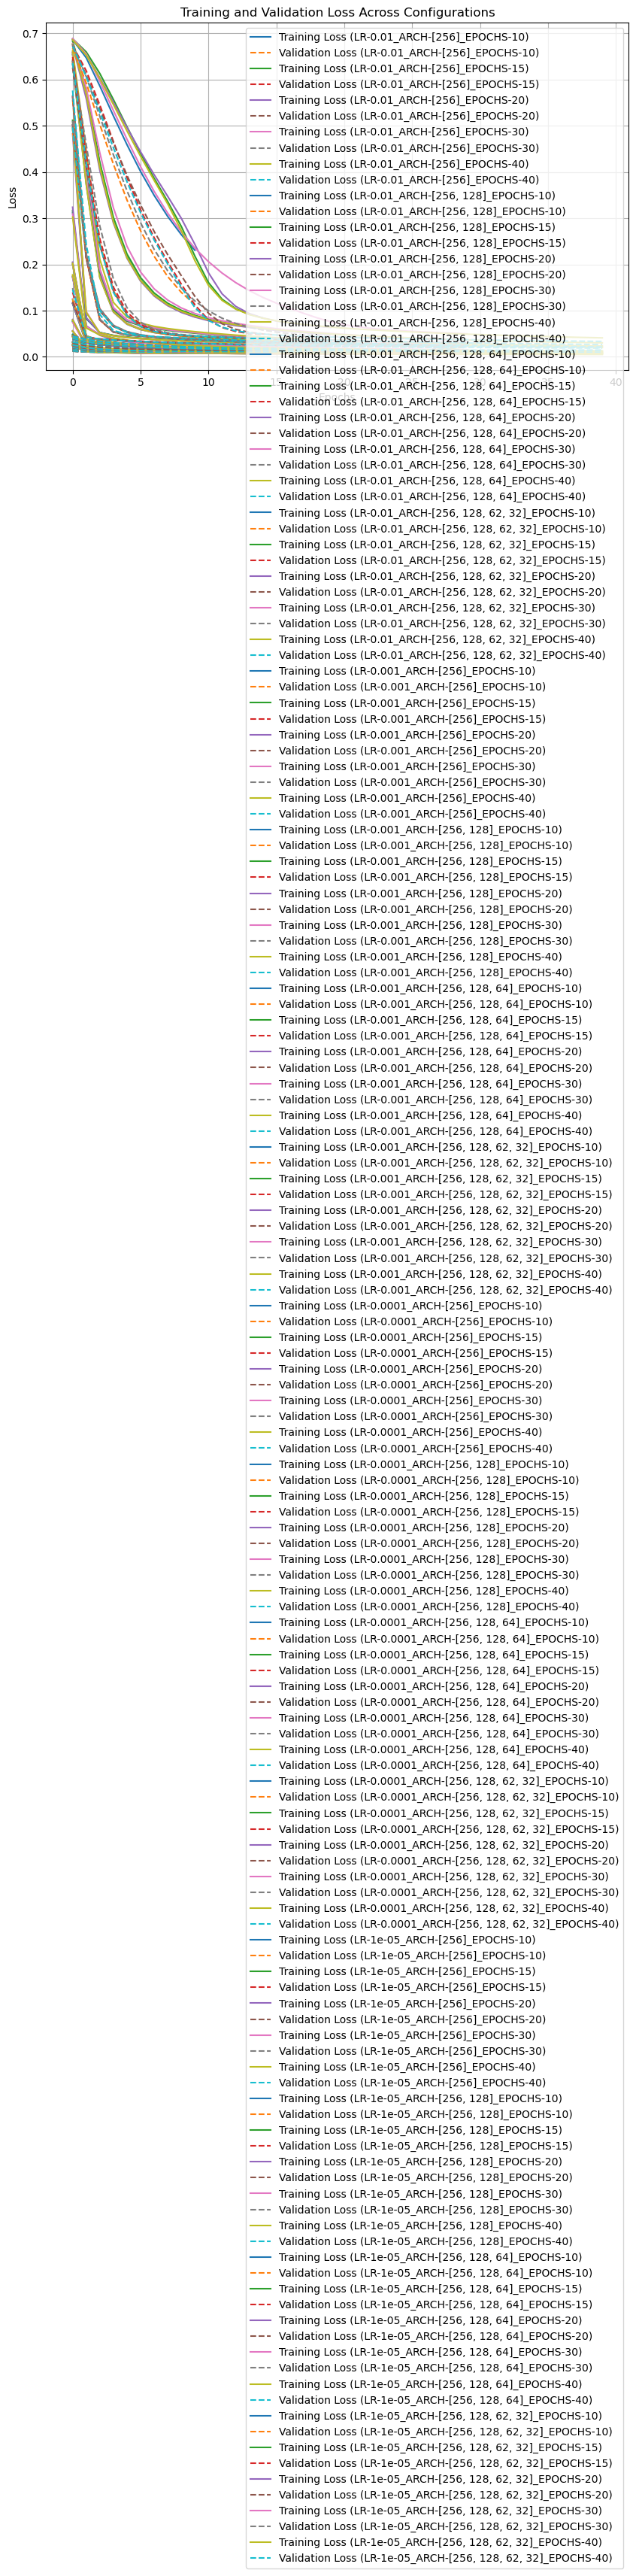


S-min @ F-max and F-max Metrics:
LR-0.01_ARCH-[256]_EPOCHS-10 -> F-max: 0.8711, S-min @ F-max: 2.6008
LR-0.01_ARCH-[256]_EPOCHS-15 -> F-max: 0.8769, S-min @ F-max: 2.5811
LR-0.01_ARCH-[256]_EPOCHS-20 -> F-max: 0.8740, S-min @ F-max: 2.6986
LR-0.01_ARCH-[256]_EPOCHS-30 -> F-max: 0.8745, S-min @ F-max: 2.6523
LR-0.01_ARCH-[256]_EPOCHS-40 -> F-max: 0.8767, S-min @ F-max: 2.5269
LR-0.01_ARCH-[256, 128]_EPOCHS-10 -> F-max: 0.8790, S-min @ F-max: 2.6104
LR-0.01_ARCH-[256, 128]_EPOCHS-15 -> F-max: 0.8779, S-min @ F-max: 2.5944
LR-0.01_ARCH-[256, 128]_EPOCHS-20 -> F-max: 0.8811, S-min @ F-max: 2.5911
LR-0.01_ARCH-[256, 128]_EPOCHS-30 -> F-max: 0.8811, S-min @ F-max: 2.5788
LR-0.01_ARCH-[256, 128]_EPOCHS-40 -> F-max: 0.8802, S-min @ F-max: 2.6566
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-10 -> F-max: 0.8644, S-min @ F-max: 3.0716
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-15 -> F-max: 0.8606, S-min @ F-max: 3.1723
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-20 -> F-max: 0.8598, S-min @ F-max: 3.1377
LR-0.01_ARCH-[256

In [ ]:
training_losses = {}
validation_losses = {}
smin_fmax_metrics = {}  
threshold_range = np.arange(0.1, 1.0, 0.1)  # Example range: [0.01, 0.99]

for lr in learning_rates:
    for arch in architectures:
        for num_epochs in epoch_counts:
            print(f"\nTraining with LR: {lr}, Arch: {arch}, Epochs: {num_epochs}")

            model = FFNN(
                input_dim=data_train_embeddings.shape[1], 
                hidden_dims=arch, 
                output_dim=data_train_labels.shape[1]
            )
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.BCEWithLogitsLoss()
            train_losses, val_losses = train_model(
                model, data_train_loader, data_val_loader, 
                criterion, optimizer, num_epochs, device
            )
            config_key = f"LR-{lr}_ARCH-{arch}_EPOCHS-{num_epochs}"
            training_losses[config_key] = train_losses
            validation_losses[config_key] = val_losses
            all_preds = []
            all_targets = []
            with torch.no_grad():
                for x_batch, y_batch in data_val_loader:
                    x_batch = x_batch.to(device)
                    outputs = model(x_batch)
                    preds = torch.sigmoid(outputs).cpu().numpy()  
                    all_preds.append(preds)
                    all_targets.append(y_batch.cpu().numpy())

            y_pred_probs = np.vstack(all_preds)
            y_true = np.vstack(all_targets)

            smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df = threshold_performance_metrics(
                ic_dict, y_true, y_pred_probs, threshold_range=threshold_range, mlb=data_mlb
            )
            smin_fmax_metrics[config_key] = {
                "F-max": fmax,
                "S-min @ F-max": s_at_fmax,
                "Best Threshold (F-max)": best_threshold_f,
                "Best Threshold (S-min)": best_threshold_s
            }
            results_file = f"metrics_lr{lr}_arch{arch}_epochs{num_epochs}.csv"
            results_df.to_csv(results_file, index=False)
            print(f"Saved metrics to: {results_file}")

            print(f"Completed training and evaluation for config: LR={lr}, ARCH={arch}, EPOCHS={num_epochs}")

plt.figure(figsize=(10, 6))
for key in training_losses:
    plt.plot(training_losses[key], label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], label=f'Validation Loss ({key})', linestyle='--')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

print("\nS-min @ F-max and F-max Metrics:")
for config, metrics in smin_fmax_metrics.items():
    print(f"{config} -> F-max: {metrics['F-max']:.4f}, S-min @ F-max: {metrics['S-min @ F-max']:.4f}")

print("Process finished. Loss plot and metric evaluations completed.")


In [ ]:
metrics_df = pd.DataFrame.from_dict(smin_fmax_metrics, orient='index').reset_index()
metrics_df.rename(columns={"index": "Configuration"}, inplace=True)


metrics_df

,Configuration,F-max,S-min @ F-max,Best Threshold (F-max),Best Threshold (S-min)
0,LR-0.01_ARCH-[256]_EPOCHS-10,0.871093,2.600825,0.3,0.3
1,LR-0.01_ARCH-[256]_EPOCHS-15,0.876941,2.581068,0.4,0.3
2,LR-0.01_ARCH-[256]_EPOCHS-20,0.873998,2.698602,0.4,0.3
3,LR-0.01_ARCH-[256]_EPOCHS-30,0.874462,2.652316,0.4,0.3
4,LR-0.01_ARCH-[256]_EPOCHS-40,0.876749,2.526892,0.3,0.3
...,...,...,...,...,...
75,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-10",0.259129,16.493001,0.7,0.9
76,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-15",0.465453,9.562661,0.3,0.2
77,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-20",0.492553,9.212177,0.3,0.2
78,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-30",0.530142,8.861174,0.3,0.2


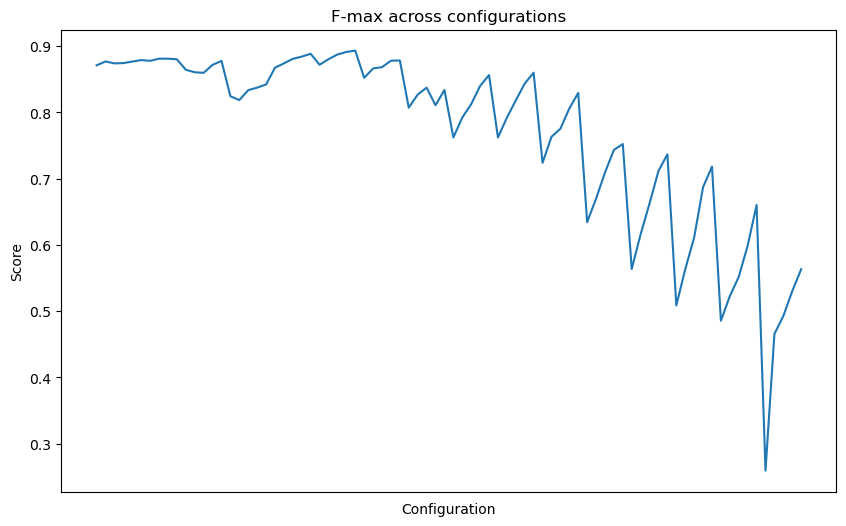

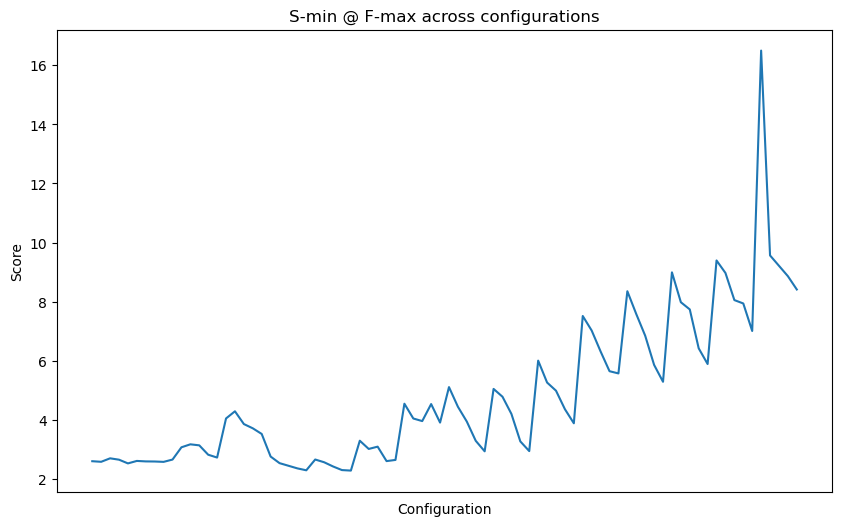

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Configuration"], metrics_df["F-max"], label="F-max")
plt.title("F-max across configurations")
plt.xlabel("Configuration")
plt.xticks([])
plt.ylabel("Score")
plt.show() 

plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Configuration"], metrics_df["S-min @ F-max"], label="S-min @ F-max")
plt.title("S-min @ F-max across configurations")
plt.xlabel("Configuration")
plt.xticks([])
plt.ylabel("Score")
plt.show() 


In [ ]:
def find_best_config(metrics_df):
    sorted_df = metrics_df.sort_values(by=["F-max", "S-min @ F-max"], ascending=[False, True])
    return sorted_df.iloc[0]

best_config = find_best_config(metrics_df)
best_config

Configuration             LR-0.001_ARCH-[256, 128]_EPOCHS-40
F-max                                               0.893356
S-min @ F-max                                       2.283816
Best Threshold (F-max)                                   0.4
Best Threshold (S-min)                                   0.3
Name: 29, dtype: object

In [ ]:
def find_best_config_with_overfitting(
    metrics_df, training_losses, validation_losses
):
    overfitting_scores = {}
    for config_key in training_losses:
        final_train_loss = training_losses[config_key][-1]  # Last epoch's training loss
        final_val_loss = validation_losses[config_key][-1]  # Last epoch's validation loss
        overfitting_scores[config_key] = final_val_loss - final_train_loss

    metrics_df["Overfitting_Score"] = metrics_df["Configuration"].map(overfitting_scores)
    sorted_df = metrics_df.sort_values(
        by=["F-max", "S-min @ F-max", "Overfitting_Score"], 
        ascending=[False, True, True]
    )
    return sorted_df.iloc[0]

best_config = find_best_config_with_overfitting(metrics_df, training_losses, validation_losses)
print(best_config)


Configuration             LR-0.001_ARCH-[256, 128]_EPOCHS-40
F-max                                               0.893356
S-min @ F-max                                       2.283816
Best Threshold (F-max)                                   0.4
Best Threshold (S-min)                                   0.3
Overfitting_Score                                   0.005771
Name: 29, dtype: object


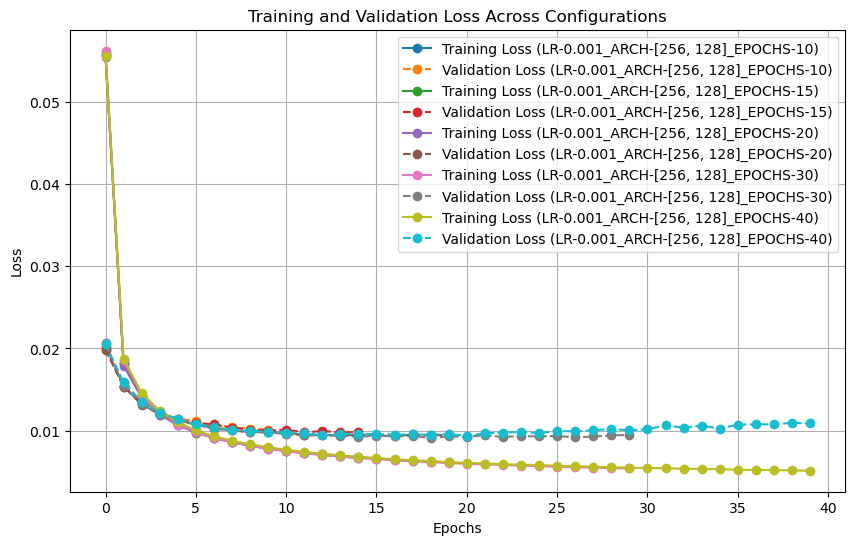

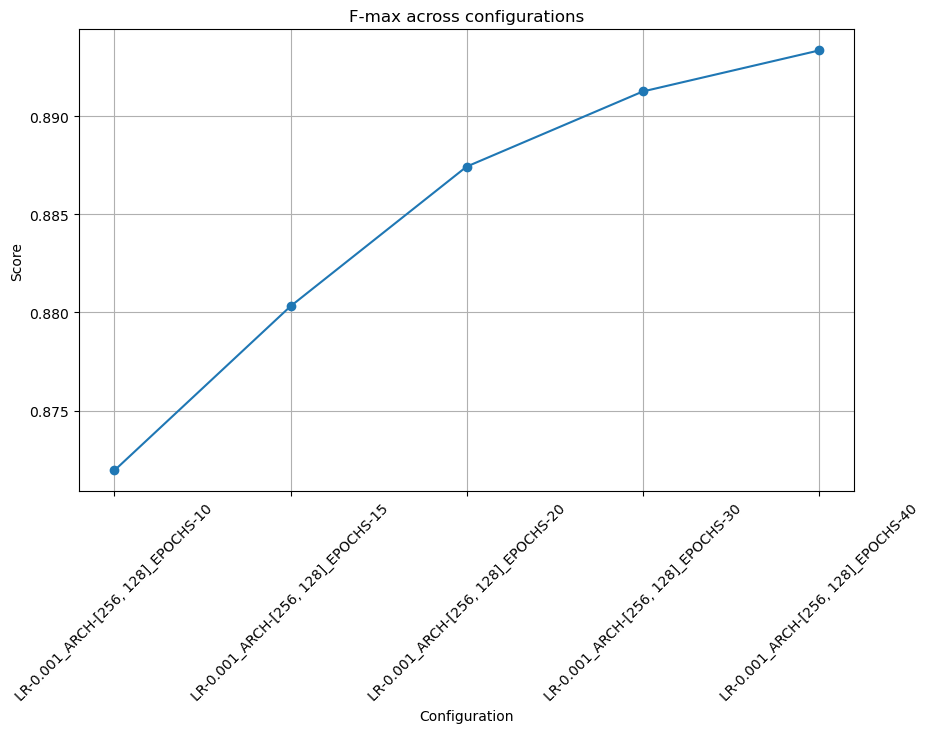

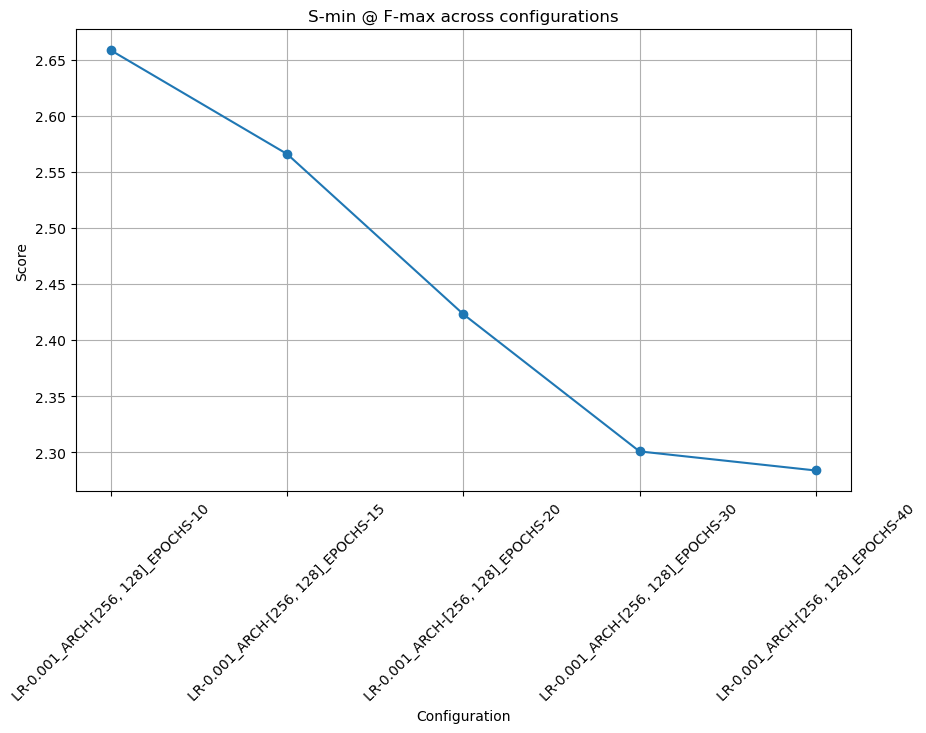

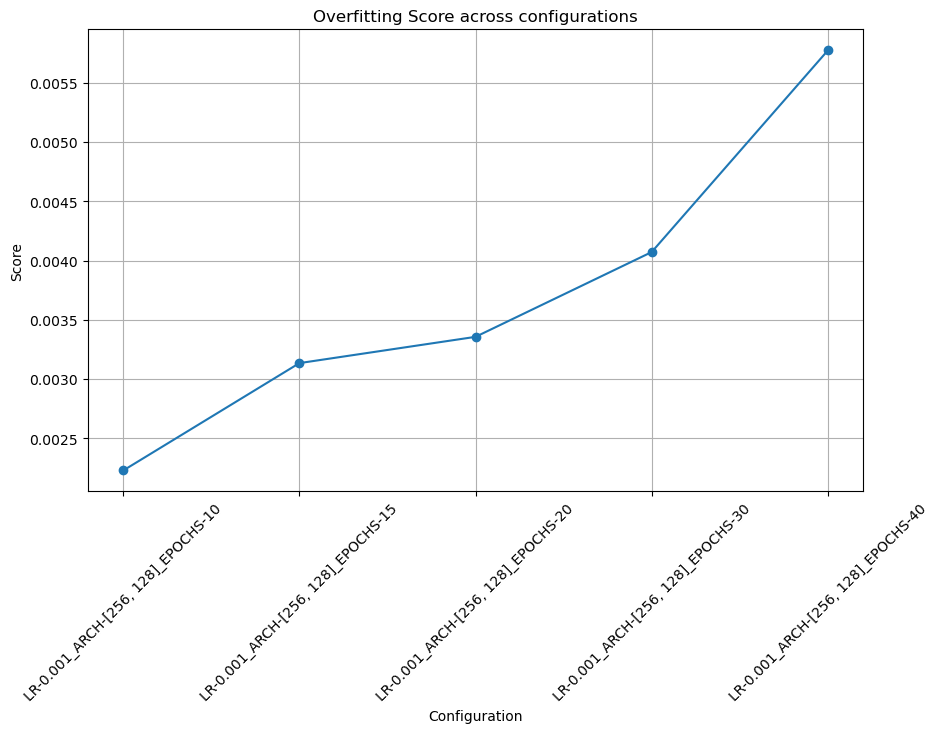

In [ ]:
configs = [key for key in training_losses.keys() if "LR-0.001_ARCH-[256, 128]" in key]
plt.figure(figsize=(10, 6))
for key in configs:
    plt.plot(training_losses[key], marker='o', label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], marker='o', linestyle='--', label=f'Validation Loss ({key})')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
metrics_df_subset = metrics_df[metrics_df["Configuration"].isin(configs)]

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["F-max"], marker='o', label="F-max")
plt.title("F-max across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["S-min @ F-max"], marker='o', label="S-min @ F-max")
plt.title("S-min @ F-max across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["Overfitting_Score"], marker='o', label="Overfitting Score")
plt.title("Overfitting Score across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()


In [ ]:
metrics_df.to_csv(r'MF_architecture_tune/MFO_metrics_df.csv', index=False)

LR-0.001_ARCH-[256, 128]_EPOCHS-30 is chosen. 

In [31]:
CHOSEN_CONFIG = 'LR-0.001_ARCH-[256, 128]_EPOCHS-30'
CHOSEN_CONFIG_LR = 0.001
CHOSEN_CONFIG_ARCH = [256, 128]
CHOSEN_CONFIG_EPOCHS = 30


# Is there an advantage of using another Loss scheme for this architecture? 

In [ ]:
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

def get_level(go_term, ontology):

    try :
        return obodag[go_term].level
    except KeyError:
        return 0

data_train_GO_flat = [item for sublist in data_train_GO_list for item in sublist]
data_train_GO_list_unique = list(set(data_train_GO_flat))
data_train_GO_levels = [get_level(go_term, 'function') for go_term in data_train_GO_list_unique]

def compute_depth_weight(term_depths):
    class_weights = np.array([1 + depth/2 for depth in term_depths]) 
    return class_weights

data_train_GO_weights_depth = compute_depth_weight(data_train_GO_levels)

data_train_GO_weights_depth.shape

go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms


(744,)

In [ ]:
def compute_inverse_frequency_weight(labels):
    class_counts = np.sum(labels, axis=0)
    total_samples = labels.shape[0]
    num_classes = labels.shape[1]
    class_weights = total_samples / (num_classes * class_counts)
    return class_weights

if len(data_train_labels.shape) > 1 and data_train_labels.shape[1] > 1:  
    class_weights = compute_inverse_frequency_weight(data_train_labels)
    data_train_GO_weights_inv_freq_ = torch.tensor(class_weights, dtype=torch.float).to(device)

data_train_GO_weights_inv_freq_.shape

torch.Size([744])

In [26]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


class JaccardLoss(nn.Module):
    def __init__(self, smooth=1):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum(dim=1)
        total = (inputs + targets).sum(dim=1)
        union = total - intersection
        Jaccard = (intersection + self.smooth) / (union + self.smooth)
        return 1 - Jaccard.mean()


class HingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, inputs, targets):
        targets = 2 * targets - 1  # Convert {0,1} to {-1,1}
        hinge_loss = torch.mean(torch.clamp(self.margin - targets * inputs, min=0))
        return hinge_loss


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.clamp(self.clip, 1.0 - self.clip)

        loss_pos = -targets * torch.log(inputs + self.eps) * (1 - inputs) ** self.gamma_pos
        loss_neg = -(1 - targets) * torch.log(1 - inputs + self.eps) * inputs ** self.gamma_neg
        loss = loss_pos + loss_neg

        return loss.mean()





Training with BCEWithLogitsLoss_balanced, LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:02,  2.16s/it]

Epoch [1/30] | Train Loss: 0.0577 | Val Loss: 0.0203


Epoch progress:   7%|▋         | 2/30 [00:04<00:55,  1.99s/it]

Epoch [2/30] | Train Loss: 0.0186 | Val Loss: 0.0156


Epoch progress:  10%|█         | 3/30 [00:05<00:52,  1.95s/it]

Epoch [3/30] | Train Loss: 0.0144 | Val Loss: 0.0133


Epoch progress:  13%|█▎        | 4/30 [00:07<00:49,  1.91s/it]

Epoch [4/30] | Train Loss: 0.0121 | Val Loss: 0.0121


Epoch progress:  17%|█▋        | 5/30 [00:09<00:45,  1.82s/it]

Epoch [5/30] | Train Loss: 0.0108 | Val Loss: 0.0112


Epoch progress:  20%|██        | 6/30 [00:11<00:43,  1.82s/it]

Epoch [6/30] | Train Loss: 0.0098 | Val Loss: 0.0108


Epoch progress:  23%|██▎       | 7/30 [00:13<00:42,  1.85s/it]

Epoch [7/30] | Train Loss: 0.0092 | Val Loss: 0.0102


Epoch progress:  27%|██▋       | 8/30 [00:14<00:40,  1.84s/it]

Epoch [8/30] | Train Loss: 0.0086 | Val Loss: 0.0100


Epoch progress:  30%|███       | 9/30 [00:17<00:42,  2.03s/it]

Epoch [9/30] | Train Loss: 0.0082 | Val Loss: 0.0097


Epoch progress:  33%|███▎      | 10/30 [00:19<00:38,  1.94s/it]

Epoch [10/30] | Train Loss: 0.0078 | Val Loss: 0.0096


Epoch progress:  37%|███▋      | 11/30 [00:21<00:37,  1.98s/it]

Epoch [11/30] | Train Loss: 0.0076 | Val Loss: 0.0095


Epoch progress:  40%|████      | 12/30 [00:23<00:38,  2.16s/it]

Epoch [12/30] | Train Loss: 0.0073 | Val Loss: 0.0094


Epoch progress:  43%|████▎     | 13/30 [00:25<00:35,  2.06s/it]

Epoch [13/30] | Train Loss: 0.0071 | Val Loss: 0.0094


Epoch progress:  47%|████▋     | 14/30 [00:27<00:33,  2.06s/it]

Epoch [14/30] | Train Loss: 0.0069 | Val Loss: 0.0094


Epoch progress:  50%|█████     | 15/30 [00:29<00:30,  2.05s/it]

Epoch [15/30] | Train Loss: 0.0067 | Val Loss: 0.0092


Epoch progress:  53%|█████▎    | 16/30 [00:32<00:29,  2.12s/it]

Epoch [16/30] | Train Loss: 0.0066 | Val Loss: 0.0095


Epoch progress:  57%|█████▋    | 17/30 [00:34<00:28,  2.17s/it]

Epoch [17/30] | Train Loss: 0.0065 | Val Loss: 0.0094


Epoch progress:  60%|██████    | 18/30 [00:36<00:26,  2.17s/it]

Epoch [18/30] | Train Loss: 0.0063 | Val Loss: 0.0095


Epoch progress:  63%|██████▎   | 19/30 [00:39<00:25,  2.31s/it]

Epoch [19/30] | Train Loss: 0.0062 | Val Loss: 0.0096


Epoch progress:  67%|██████▋   | 20/30 [00:40<00:21,  2.14s/it]

Epoch [20/30] | Train Loss: 0.0061 | Val Loss: 0.0096


Epoch progress:  70%|███████   | 21/30 [00:43<00:19,  2.16s/it]

Epoch [21/30] | Train Loss: 0.0060 | Val Loss: 0.0096


Epoch progress:  73%|███████▎  | 22/30 [00:45<00:17,  2.15s/it]

Epoch [22/30] | Train Loss: 0.0059 | Val Loss: 0.0094


Epoch progress:  77%|███████▋  | 23/30 [00:46<00:14,  2.02s/it]

Epoch [23/30] | Train Loss: 0.0059 | Val Loss: 0.0096


Epoch progress:  80%|████████  | 24/30 [00:49<00:13,  2.18s/it]

Epoch [24/30] | Train Loss: 0.0058 | Val Loss: 0.0096


Epoch progress:  83%|████████▎ | 25/30 [00:51<00:10,  2.14s/it]

Epoch [25/30] | Train Loss: 0.0057 | Val Loss: 0.0094


Epoch progress:  87%|████████▋ | 26/30 [00:53<00:08,  2.15s/it]

Epoch [26/30] | Train Loss: 0.0056 | Val Loss: 0.0099


Epoch progress:  90%|█████████ | 27/30 [00:55<00:06,  2.05s/it]

Epoch [27/30] | Train Loss: 0.0056 | Val Loss: 0.0100


Epoch progress:  93%|█████████▎| 28/30 [00:57<00:04,  2.01s/it]

Epoch [28/30] | Train Loss: 0.0055 | Val Loss: 0.0099


Epoch progress:  97%|█████████▋| 29/30 [00:59<00:01,  1.96s/it]

Epoch [29/30] | Train Loss: 0.0055 | Val Loss: 0.0101


Epoch progress: 100%|██████████| 30/30 [01:01<00:00,  2.06s/it]

Epoch [30/30] | Train Loss: 0.0054 | Val Loss: 0.0100
Training completed.



Calculating Smin & Fmax: 100%|██████████| 99/99 [01:21<00:00,  1.22it/s]


F-max @ Best Threshold (0.36000000000000004): 0.8903694469847583
S-min @ Best Threshold (0.31): 2.246509191926446
S-min @ F-max Threshold (0.36000000000000004): 2.274028210216737
Saved metrics to: metrics_BCEWithLogitsLoss_balanced_lr0.001_arch[256, 128]_epochs30.csv
Completed BCEWithLogitsLoss_balanced | Validation Loss: 0.0100, Fmax: 0.8904, Smin: 2.2465

Training with BCEWithLogitsLoss_depth, LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<00:59,  2.04s/it]

Epoch [1/30] | Train Loss: 0.1697 | Val Loss: 0.0637


Epoch progress:   7%|▋         | 2/30 [00:04<01:00,  2.15s/it]

Epoch [2/30] | Train Loss: 0.0571 | Val Loss: 0.0483


Epoch progress:  10%|█         | 3/30 [00:06<00:56,  2.09s/it]

Epoch [3/30] | Train Loss: 0.0440 | Val Loss: 0.0413


Epoch progress:  13%|█▎        | 4/30 [00:08<00:50,  1.96s/it]

Epoch [4/30] | Train Loss: 0.0373 | Val Loss: 0.0376


Epoch progress:  17%|█▋        | 5/30 [00:10<00:49,  1.99s/it]

Epoch [5/30] | Train Loss: 0.0332 | Val Loss: 0.0352


Epoch progress:  20%|██        | 6/30 [00:12<00:48,  2.01s/it]

Epoch [6/30] | Train Loss: 0.0303 | Val Loss: 0.0343


Epoch progress:  23%|██▎       | 7/30 [00:14<00:46,  2.01s/it]

Epoch [7/30] | Train Loss: 0.0282 | Val Loss: 0.0325


Epoch progress:  27%|██▋       | 8/30 [00:16<00:45,  2.09s/it]

Epoch [8/30] | Train Loss: 0.0265 | Val Loss: 0.0321


Epoch progress:  30%|███       | 9/30 [00:18<00:43,  2.09s/it]

Epoch [9/30] | Train Loss: 0.0252 | Val Loss: 0.0316


Epoch progress:  33%|███▎      | 10/30 [00:20<00:41,  2.08s/it]

Epoch [10/30] | Train Loss: 0.0242 | Val Loss: 0.0308


Epoch progress:  37%|███▋      | 11/30 [00:22<00:40,  2.14s/it]

Epoch [11/30] | Train Loss: 0.0232 | Val Loss: 0.0304


Epoch progress:  40%|████      | 12/30 [00:25<00:42,  2.37s/it]

Epoch [12/30] | Train Loss: 0.0224 | Val Loss: 0.0299


Epoch progress:  43%|████▎     | 13/30 [00:28<00:43,  2.57s/it]

Epoch [13/30] | Train Loss: 0.0217 | Val Loss: 0.0299


Epoch progress:  47%|████▋     | 14/30 [00:31<00:42,  2.66s/it]

Epoch [14/30] | Train Loss: 0.0211 | Val Loss: 0.0296


Epoch progress:  50%|█████     | 15/30 [00:34<00:40,  2.73s/it]

Epoch [15/30] | Train Loss: 0.0205 | Val Loss: 0.0295


Epoch progress:  53%|█████▎    | 16/30 [00:37<00:39,  2.83s/it]

Epoch [16/30] | Train Loss: 0.0201 | Val Loss: 0.0292


Epoch progress:  57%|█████▋    | 17/30 [00:40<00:36,  2.84s/it]

Epoch [17/30] | Train Loss: 0.0197 | Val Loss: 0.0295


Epoch progress:  60%|██████    | 18/30 [00:43<00:34,  2.88s/it]

Epoch [18/30] | Train Loss: 0.0193 | Val Loss: 0.0294


Epoch progress:  63%|██████▎   | 19/30 [00:46<00:32,  2.92s/it]

Epoch [19/30] | Train Loss: 0.0189 | Val Loss: 0.0295


Epoch progress:  67%|██████▋   | 20/30 [00:49<00:29,  2.90s/it]

Epoch [20/30] | Train Loss: 0.0186 | Val Loss: 0.0296


Epoch progress:  70%|███████   | 21/30 [00:52<00:25,  2.89s/it]

Epoch [21/30] | Train Loss: 0.0183 | Val Loss: 0.0294


Epoch progress:  73%|███████▎  | 22/30 [00:54<00:22,  2.87s/it]

Epoch [22/30] | Train Loss: 0.0182 | Val Loss: 0.0308


Epoch progress:  77%|███████▋  | 23/30 [00:58<00:20,  2.94s/it]

Epoch [23/30] | Train Loss: 0.0179 | Val Loss: 0.0298


Epoch progress:  80%|████████  | 24/30 [01:00<00:17,  2.92s/it]

Epoch [24/30] | Train Loss: 0.0176 | Val Loss: 0.0296


Epoch progress:  83%|████████▎ | 25/30 [01:03<00:14,  2.91s/it]

Epoch [25/30] | Train Loss: 0.0175 | Val Loss: 0.0308


Epoch progress:  87%|████████▋ | 26/30 [01:06<00:11,  2.95s/it]

Epoch [26/30] | Train Loss: 0.0172 | Val Loss: 0.0303


Epoch progress:  90%|█████████ | 27/30 [01:09<00:08,  2.93s/it]

Epoch [27/30] | Train Loss: 0.0170 | Val Loss: 0.0312


Epoch progress:  93%|█████████▎| 28/30 [01:12<00:05,  2.90s/it]

Epoch [28/30] | Train Loss: 0.0169 | Val Loss: 0.0318


Epoch progress:  97%|█████████▋| 29/30 [01:15<00:02,  2.96s/it]

Epoch [29/30] | Train Loss: 0.0167 | Val Loss: 0.0317


Epoch progress: 100%|██████████| 30/30 [01:18<00:00,  2.62s/it]

Epoch [30/30] | Train Loss: 0.0166 | Val Loss: 0.0310
Training completed.



Calculating Smin & Fmax: 100%|██████████| 99/99 [01:22<00:00,  1.20it/s]


F-max @ Best Threshold (0.37): 0.8904453152824695
S-min @ Best Threshold (0.3): 2.2347938177562923
S-min @ F-max Threshold (0.37): 2.2693209392532814
Saved metrics to: metrics_BCEWithLogitsLoss_depth_lr0.001_arch[256, 128]_epochs30.csv
Completed BCEWithLogitsLoss_depth | Validation Loss: 0.0310, Fmax: 0.8904, Smin: 2.2348

Training with BCEWithLogitsLoss_inv_freq, LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:03<01:41,  3.51s/it]

Epoch [1/30] | Train Loss: 0.0538 | Val Loss: 0.0101


Epoch progress:   7%|▋         | 2/30 [00:06<01:26,  3.10s/it]

Epoch [2/30] | Train Loss: 0.0094 | Val Loss: 0.0084


Epoch progress:  10%|█         | 3/30 [00:09<01:20,  2.98s/it]

Epoch [3/30] | Train Loss: 0.0072 | Val Loss: 0.0065


Epoch progress:  13%|█▎        | 4/30 [00:12<01:18,  3.03s/it]

Epoch [4/30] | Train Loss: 0.0053 | Val Loss: 0.0050


Epoch progress:  17%|█▋        | 5/30 [00:15<01:14,  2.98s/it]

Epoch [5/30] | Train Loss: 0.0042 | Val Loss: 0.0045


Epoch progress:  20%|██        | 6/30 [00:18<01:11,  2.96s/it]

Epoch [6/30] | Train Loss: 0.0036 | Val Loss: 0.0040


Epoch progress:  23%|██▎       | 7/30 [00:21<01:08,  2.99s/it]

Epoch [7/30] | Train Loss: 0.0032 | Val Loss: 0.0038


Epoch progress:  27%|██▋       | 8/30 [00:24<01:05,  2.97s/it]

Epoch [8/30] | Train Loss: 0.0029 | Val Loss: 0.0037


Epoch progress:  30%|███       | 9/30 [00:25<00:54,  2.59s/it]

Epoch [9/30] | Train Loss: 0.0027 | Val Loss: 0.0035


Epoch progress:  33%|███▎      | 10/30 [00:28<00:53,  2.66s/it]

Epoch [10/30] | Train Loss: 0.0025 | Val Loss: 0.0034


Epoch progress:  37%|███▋      | 11/30 [00:31<00:52,  2.78s/it]

Epoch [11/30] | Train Loss: 0.0024 | Val Loss: 0.0034


Epoch progress:  40%|████      | 12/30 [00:33<00:44,  2.46s/it]

Epoch [12/30] | Train Loss: 0.0023 | Val Loss: 0.0034


Epoch progress:  43%|████▎     | 13/30 [00:35<00:41,  2.47s/it]

Epoch [13/30] | Train Loss: 0.0021 | Val Loss: 0.0035


Epoch progress:  47%|████▋     | 14/30 [00:38<00:38,  2.40s/it]

Epoch [14/30] | Train Loss: 0.0020 | Val Loss: 0.0034


Epoch progress:  50%|█████     | 15/30 [00:40<00:38,  2.54s/it]

Epoch [15/30] | Train Loss: 0.0020 | Val Loss: 0.0034


Epoch progress:  53%|█████▎    | 16/30 [00:43<00:37,  2.65s/it]

Epoch [16/30] | Train Loss: 0.0019 | Val Loss: 0.0033


Epoch progress:  57%|█████▋    | 17/30 [00:46<00:32,  2.49s/it]

Epoch [17/30] | Train Loss: 0.0018 | Val Loss: 0.0033


Epoch progress:  60%|██████    | 18/30 [00:48<00:29,  2.47s/it]

Epoch [18/30] | Train Loss: 0.0018 | Val Loss: 0.0033


Epoch progress:  63%|██████▎   | 19/30 [00:50<00:26,  2.38s/it]

Epoch [19/30] | Train Loss: 0.0017 | Val Loss: 0.0032


Epoch progress:  67%|██████▋   | 20/30 [00:53<00:25,  2.58s/it]

Epoch [20/30] | Train Loss: 0.0017 | Val Loss: 0.0034


Epoch progress:  70%|███████   | 21/30 [00:56<00:23,  2.62s/it]

Epoch [21/30] | Train Loss: 0.0016 | Val Loss: 0.0034


Epoch progress:  73%|███████▎  | 22/30 [00:58<00:19,  2.40s/it]

Epoch [22/30] | Train Loss: 0.0016 | Val Loss: 0.0033


Epoch progress:  77%|███████▋  | 23/30 [01:01<00:17,  2.57s/it]

Epoch [23/30] | Train Loss: 0.0015 | Val Loss: 0.0033


Epoch progress:  80%|████████  | 24/30 [01:04<00:16,  2.67s/it]

Epoch [24/30] | Train Loss: 0.0015 | Val Loss: 0.0034


Epoch progress:  83%|████████▎ | 25/30 [01:06<00:12,  2.49s/it]

Epoch [25/30] | Train Loss: 0.0015 | Val Loss: 0.0034


Epoch progress:  87%|████████▋ | 26/30 [01:09<00:10,  2.63s/it]

Epoch [26/30] | Train Loss: 0.0014 | Val Loss: 0.0034


Epoch progress:  90%|█████████ | 27/30 [01:11<00:07,  2.61s/it]

Epoch [27/30] | Train Loss: 0.0014 | Val Loss: 0.0034


Epoch progress:  93%|█████████▎| 28/30 [01:13<00:04,  2.42s/it]

Epoch [28/30] | Train Loss: 0.0014 | Val Loss: 0.0034


Epoch progress:  97%|█████████▋| 29/30 [01:15<00:02,  2.29s/it]

Epoch [29/30] | Train Loss: 0.0014 | Val Loss: 0.0035


Epoch progress: 100%|██████████| 30/30 [01:18<00:00,  2.61s/it]

Epoch [30/30] | Train Loss: 0.0013 | Val Loss: 0.0034
Training completed.



Calculating Smin & Fmax: 100%|██████████| 99/99 [01:25<00:00,  1.16it/s]


F-max @ Best Threshold (0.37): 0.7852969048578913
S-min @ Best Threshold (0.32): 3.516325849081103
S-min @ F-max Threshold (0.37): 3.5754309209751294
Saved metrics to: metrics_BCEWithLogitsLoss_inv_freq_lr0.001_arch[256, 128]_epochs30.csv
Completed BCEWithLogitsLoss_inv_freq | Validation Loss: 0.0034, Fmax: 0.7853, Smin: 3.5163

Training with FocalLoss, LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<00:59,  2.06s/it]

Epoch [1/30] | Train Loss: 0.0036 | Val Loss: 0.0013


Epoch progress:   7%|▋         | 2/30 [00:04<00:59,  2.14s/it]

Epoch [2/30] | Train Loss: 0.0012 | Val Loss: 0.0010


Epoch progress:  10%|█         | 3/30 [00:06<00:55,  2.07s/it]

Epoch [3/30] | Train Loss: 0.0009 | Val Loss: 0.0008


Epoch progress:  13%|█▎        | 4/30 [00:08<00:52,  2.03s/it]

Epoch [4/30] | Train Loss: 0.0007 | Val Loss: 0.0008


Epoch progress:  17%|█▋        | 5/30 [00:10<00:49,  1.97s/it]

Epoch [5/30] | Train Loss: 0.0007 | Val Loss: 0.0007


Epoch progress:  20%|██        | 6/30 [00:12<00:48,  2.01s/it]

Epoch [6/30] | Train Loss: 0.0006 | Val Loss: 0.0007


Epoch progress:  23%|██▎       | 7/30 [00:14<00:46,  2.00s/it]

Epoch [7/30] | Train Loss: 0.0006 | Val Loss: 0.0007


Epoch progress:  27%|██▋       | 8/30 [00:16<00:44,  2.00s/it]

Epoch [8/30] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  30%|███       | 9/30 [00:18<00:42,  2.04s/it]

Epoch [9/30] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  33%|███▎      | 10/30 [00:20<00:40,  2.03s/it]

Epoch [10/30] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  37%|███▋      | 11/30 [00:22<00:37,  2.00s/it]

Epoch [11/30] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  40%|████      | 12/30 [00:24<00:36,  2.05s/it]

Epoch [12/30] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  43%|████▎     | 13/30 [00:26<00:34,  2.01s/it]

Epoch [13/30] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  47%|████▋     | 14/30 [00:28<00:31,  1.96s/it]

Epoch [14/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  50%|█████     | 15/30 [00:30<00:30,  2.01s/it]

Epoch [15/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  53%|█████▎    | 16/30 [00:32<00:28,  2.07s/it]

Epoch [16/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  57%|█████▋    | 17/30 [00:34<00:27,  2.10s/it]

Epoch [17/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  60%|██████    | 18/30 [00:36<00:24,  2.04s/it]

Epoch [18/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  63%|██████▎   | 19/30 [00:38<00:22,  2.09s/it]

Epoch [19/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  67%|██████▋   | 20/30 [00:40<00:20,  2.07s/it]

Epoch [20/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  70%|███████   | 21/30 [00:42<00:18,  2.05s/it]

Epoch [21/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  73%|███████▎  | 22/30 [00:44<00:16,  2.09s/it]

Epoch [22/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  77%|███████▋  | 23/30 [00:47<00:14,  2.10s/it]

Epoch [23/30] | Train Loss: 0.0004 | Val Loss: 0.0008


Epoch progress:  80%|████████  | 24/30 [00:49<00:12,  2.16s/it]

Epoch [24/30] | Train Loss: 0.0004 | Val Loss: 0.0008


Epoch progress:  83%|████████▎ | 25/30 [00:51<00:10,  2.15s/it]

Epoch [25/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  87%|████████▋ | 26/30 [00:53<00:08,  2.15s/it]

Epoch [26/30] | Train Loss: 0.0004 | Val Loss: 0.0008


Epoch progress:  90%|█████████ | 27/30 [00:56<00:07,  2.44s/it]

Epoch [27/30] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  93%|█████████▎| 28/30 [00:59<00:04,  2.44s/it]

Epoch [28/30] | Train Loss: 0.0004 | Val Loss: 0.0008


Epoch progress:  97%|█████████▋| 29/30 [01:02<00:02,  2.60s/it]

Epoch [29/30] | Train Loss: 0.0004 | Val Loss: 0.0008


Epoch progress: 100%|██████████| 30/30 [01:04<00:00,  2.15s/it]


Epoch [30/30] | Train Loss: 0.0004 | Val Loss: 0.0008
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [01:27<00:00,  1.14it/s]


F-max @ Best Threshold (0.46): 0.8908674690211531
S-min @ Best Threshold (0.43): 2.2519097454559156
S-min @ F-max Threshold (0.46): 2.306301429598095
Saved metrics to: metrics_FocalLoss_lr0.001_arch[256, 128]_epochs30.csv
Completed FocalLoss | Validation Loss: 0.0008, Fmax: 0.8909, Smin: 2.2519

Training with JaccardLoss, LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:04,  2.23s/it]

Epoch [1/30] | Train Loss: 0.6357 | Val Loss: 0.4700


Epoch progress:   7%|▋         | 2/30 [00:04<00:57,  2.04s/it]

Epoch [2/30] | Train Loss: 0.4140 | Val Loss: 0.4099


Epoch progress:  10%|█         | 3/30 [00:05<00:52,  1.96s/it]

Epoch [3/30] | Train Loss: 0.3756 | Val Loss: 0.3921


Epoch progress:  13%|█▎        | 4/30 [00:08<00:52,  2.01s/it]

Epoch [4/30] | Train Loss: 0.3609 | Val Loss: 0.3833


Epoch progress:  17%|█▋        | 5/30 [00:09<00:49,  1.96s/it]

Epoch [5/30] | Train Loss: 0.3514 | Val Loss: 0.3685


Epoch progress:  20%|██        | 6/30 [00:11<00:46,  1.93s/it]

Epoch [6/30] | Train Loss: 0.3362 | Val Loss: 0.3636


Epoch progress:  23%|██▎       | 7/30 [00:13<00:45,  1.99s/it]

Epoch [7/30] | Train Loss: 0.3310 | Val Loss: 0.3596


Epoch progress:  27%|██▋       | 8/30 [00:16<00:50,  2.29s/it]

Epoch [8/30] | Train Loss: 0.3269 | Val Loss: 0.3568


Epoch progress:  30%|███       | 9/30 [00:19<00:53,  2.53s/it]

Epoch [9/30] | Train Loss: 0.3237 | Val Loss: 0.3533


Epoch progress:  33%|███▎      | 10/30 [00:22<00:53,  2.69s/it]

Epoch [10/30] | Train Loss: 0.3187 | Val Loss: 0.3475


Epoch progress:  37%|███▋      | 11/30 [00:26<00:54,  2.86s/it]

Epoch [11/30] | Train Loss: 0.3156 | Val Loss: 0.3484


Epoch progress:  40%|████      | 12/30 [00:29<00:52,  2.91s/it]

Epoch [12/30] | Train Loss: 0.3139 | Val Loss: 0.3470


Epoch progress:  43%|████▎     | 13/30 [00:32<00:50,  2.98s/it]

Epoch [13/30] | Train Loss: 0.3126 | Val Loss: 0.3465


Epoch progress:  47%|████▋     | 14/30 [00:35<00:48,  3.06s/it]

Epoch [14/30] | Train Loss: 0.3098 | Val Loss: 0.3428


Epoch progress:  50%|█████     | 15/30 [00:38<00:45,  3.05s/it]

Epoch [15/30] | Train Loss: 0.3067 | Val Loss: 0.3411


Epoch progress:  53%|█████▎    | 16/30 [00:41<00:42,  3.04s/it]

Epoch [16/30] | Train Loss: 0.3052 | Val Loss: 0.3396


Epoch progress:  57%|█████▋    | 17/30 [00:45<00:40,  3.13s/it]

Epoch [17/30] | Train Loss: 0.3039 | Val Loss: 0.3386


Epoch progress:  60%|██████    | 18/30 [00:47<00:36,  3.07s/it]

Epoch [18/30] | Train Loss: 0.3023 | Val Loss: 0.3369


Epoch progress:  63%|██████▎   | 19/30 [00:50<00:32,  2.96s/it]

Epoch [19/30] | Train Loss: 0.2999 | Val Loss: 0.3363


Epoch progress:  67%|██████▋   | 20/30 [00:52<00:26,  2.63s/it]

Epoch [20/30] | Train Loss: 0.2987 | Val Loss: 0.3352


Epoch progress:  70%|███████   | 21/30 [00:54<00:22,  2.49s/it]

Epoch [21/30] | Train Loss: 0.2976 | Val Loss: 0.3335


Epoch progress:  73%|███████▎  | 22/30 [00:56<00:18,  2.31s/it]

Epoch [22/30] | Train Loss: 0.2966 | Val Loss: 0.3341


Epoch progress:  77%|███████▋  | 23/30 [00:58<00:15,  2.16s/it]

Epoch [23/30] | Train Loss: 0.2959 | Val Loss: 0.3337


Epoch progress:  80%|████████  | 24/30 [01:00<00:12,  2.12s/it]

Epoch [24/30] | Train Loss: 0.2950 | Val Loss: 0.3336


Epoch progress:  83%|████████▎ | 25/30 [01:02<00:10,  2.04s/it]

Epoch [25/30] | Train Loss: 0.2942 | Val Loss: 0.3333


Epoch progress:  87%|████████▋ | 26/30 [01:04<00:08,  2.01s/it]

Epoch [26/30] | Train Loss: 0.2918 | Val Loss: 0.3299


Epoch progress:  90%|█████████ | 27/30 [01:06<00:06,  2.02s/it]

Epoch [27/30] | Train Loss: 0.2892 | Val Loss: 0.3286


Epoch progress:  93%|█████████▎| 28/30 [01:08<00:03,  1.99s/it]

Epoch [28/30] | Train Loss: 0.2871 | Val Loss: 0.3258


Epoch progress:  97%|█████████▋| 29/30 [01:10<00:01,  1.95s/it]

Epoch [29/30] | Train Loss: 0.2861 | Val Loss: 0.3269


Epoch progress: 100%|██████████| 30/30 [01:11<00:00,  2.40s/it]

Epoch [30/30] | Train Loss: 0.2857 | Val Loss: 0.3261
Training completed.



Calculating Smin & Fmax: 100%|██████████| 99/99 [01:22<00:00,  1.20it/s]


F-max @ Best Threshold (0.22): 0.7703176484569914
S-min @ Best Threshold (0.01): 6.113300305049006
S-min @ F-max Threshold (0.22): 6.1736033943886515
Saved metrics to: metrics_JaccardLoss_lr0.001_arch[256, 128]_epochs30.csv
Completed JaccardLoss | Validation Loss: 0.3261, Fmax: 0.7703, Smin: 6.1133

Training with HingeLoss, LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:57,  2.00s/it]

Epoch [1/30] | Train Loss: 0.0513 | Val Loss: 0.0161


Epoch progress:   7%|▋         | 2/30 [00:03<00:55,  1.99s/it]

Epoch [2/30] | Train Loss: 0.0148 | Val Loss: 0.0126


Epoch progress:  10%|█         | 3/30 [00:05<00:51,  1.90s/it]

Epoch [3/30] | Train Loss: 0.0119 | Val Loss: 0.0110


Epoch progress:  13%|█▎        | 4/30 [00:07<00:47,  1.84s/it]

Epoch [4/30] | Train Loss: 0.0103 | Val Loss: 0.0102


Epoch progress:  17%|█▋        | 5/30 [00:10<00:54,  2.19s/it]

Epoch [5/30] | Train Loss: 0.0093 | Val Loss: 0.0097


Epoch progress:  20%|██        | 6/30 [00:13<00:59,  2.50s/it]

Epoch [6/30] | Train Loss: 0.0086 | Val Loss: 0.0092


Epoch progress:  23%|██▎       | 7/30 [00:16<01:01,  2.67s/it]

Epoch [7/30] | Train Loss: 0.0080 | Val Loss: 0.0089


Epoch progress:  27%|██▋       | 8/30 [00:19<01:00,  2.77s/it]

Epoch [8/30] | Train Loss: 0.0075 | Val Loss: 0.0087


Epoch progress:  30%|███       | 9/30 [00:22<01:00,  2.87s/it]

Epoch [9/30] | Train Loss: 0.0072 | Val Loss: 0.0084


Epoch progress:  33%|███▎      | 10/30 [00:25<00:57,  2.87s/it]

Epoch [10/30] | Train Loss: 0.0068 | Val Loss: 0.0083


Epoch progress:  37%|███▋      | 11/30 [00:27<00:51,  2.72s/it]

Epoch [11/30] | Train Loss: 0.0066 | Val Loss: 0.0081


Epoch progress:  40%|████      | 12/30 [00:29<00:44,  2.46s/it]

Epoch [12/30] | Train Loss: 0.0063 | Val Loss: 0.0080


Epoch progress:  43%|████▎     | 13/30 [00:31<00:39,  2.33s/it]

Epoch [13/30] | Train Loss: 0.0061 | Val Loss: 0.0080


Epoch progress:  47%|████▋     | 14/30 [00:33<00:34,  2.18s/it]

Epoch [14/30] | Train Loss: 0.0059 | Val Loss: 0.0079


Epoch progress:  50%|█████     | 15/30 [00:35<00:31,  2.09s/it]

Epoch [15/30] | Train Loss: 0.0058 | Val Loss: 0.0079


Epoch progress:  53%|█████▎    | 16/30 [00:37<00:29,  2.09s/it]

Epoch [16/30] | Train Loss: 0.0056 | Val Loss: 0.0079


Epoch progress:  57%|█████▋    | 17/30 [00:39<00:26,  2.02s/it]

Epoch [17/30] | Train Loss: 0.0055 | Val Loss: 0.0078


Epoch progress:  60%|██████    | 18/30 [00:41<00:23,  1.96s/it]

Epoch [18/30] | Train Loss: 0.0054 | Val Loss: 0.0077


Epoch progress:  63%|██████▎   | 19/30 [00:43<00:21,  1.98s/it]

Epoch [19/30] | Train Loss: 0.0053 | Val Loss: 0.0076


Epoch progress:  67%|██████▋   | 20/30 [00:44<00:19,  1.93s/it]

Epoch [20/30] | Train Loss: 0.0052 | Val Loss: 0.0077


Epoch progress:  70%|███████   | 21/30 [00:46<00:17,  1.92s/it]

Epoch [21/30] | Train Loss: 0.0051 | Val Loss: 0.0076


Epoch progress:  73%|███████▎  | 22/30 [00:48<00:15,  1.90s/it]

Epoch [22/30] | Train Loss: 0.0050 | Val Loss: 0.0076


Epoch progress:  77%|███████▋  | 23/30 [00:50<00:13,  1.98s/it]

Epoch [23/30] | Train Loss: 0.0050 | Val Loss: 0.0077


Epoch progress:  80%|████████  | 24/30 [00:52<00:11,  1.92s/it]

Epoch [24/30] | Train Loss: 0.0049 | Val Loss: 0.0078


Epoch progress:  83%|████████▎ | 25/30 [00:55<00:10,  2.18s/it]

Epoch [25/30] | Train Loss: 0.0048 | Val Loss: 0.0078


Epoch progress:  87%|████████▋ | 26/30 [00:58<00:09,  2.47s/it]

Epoch [26/30] | Train Loss: 0.0048 | Val Loss: 0.0078


Epoch progress:  90%|█████████ | 27/30 [01:01<00:07,  2.61s/it]

Epoch [27/30] | Train Loss: 0.0047 | Val Loss: 0.0080


Epoch progress:  93%|█████████▎| 28/30 [01:04<00:05,  2.71s/it]

Epoch [28/30] | Train Loss: 0.0047 | Val Loss: 0.0080


Epoch progress:  97%|█████████▋| 29/30 [01:07<00:02,  2.84s/it]

Epoch [29/30] | Train Loss: 0.0046 | Val Loss: 0.0080


Epoch progress: 100%|██████████| 30/30 [01:10<00:00,  2.35s/it]

Epoch [30/30] | Train Loss: 0.0045 | Val Loss: 0.0078
Training completed.



Calculating Smin & Fmax: 100%|██████████| 99/99 [01:26<00:00,  1.14it/s]


F-max @ Best Threshold (0.4): 0.8956732444776706
S-min @ Best Threshold (0.34): 2.2807825739106016
S-min @ F-max Threshold (0.4): 2.332215476500727
Saved metrics to: metrics_HingeLoss_lr0.001_arch[256, 128]_epochs30.csv
Completed HingeLoss | Validation Loss: 0.0078, Fmax: 0.8957, Smin: 2.2808

Training with AsymmetricLoss, LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:02<01:02,  2.15s/it]

Epoch [1/30] | Train Loss: 0.0071 | Val Loss: 0.0034


Epoch progress:   7%|▋         | 2/30 [00:04<00:56,  2.02s/it]

Epoch [2/30] | Train Loss: 0.0030 | Val Loss: 0.0027


Epoch progress:  10%|█         | 3/30 [00:05<00:51,  1.91s/it]

Epoch [3/30] | Train Loss: 0.0024 | Val Loss: 0.0025


Epoch progress:  13%|█▎        | 4/30 [00:08<00:56,  2.17s/it]

Epoch [4/30] | Train Loss: 0.0021 | Val Loss: 0.0023


Epoch progress:  17%|█▋        | 5/30 [00:10<00:50,  2.03s/it]

Epoch [5/30] | Train Loss: 0.0019 | Val Loss: 0.0023


Epoch progress:  20%|██        | 6/30 [00:12<00:48,  2.03s/it]

Epoch [6/30] | Train Loss: 0.0018 | Val Loss: 0.0022


Epoch progress:  23%|██▎       | 7/30 [00:14<00:46,  2.00s/it]

Epoch [7/30] | Train Loss: 0.0017 | Val Loss: 0.0022


Epoch progress:  27%|██▋       | 8/30 [00:16<00:44,  2.04s/it]

Epoch [8/30] | Train Loss: 0.0016 | Val Loss: 0.0022


Epoch progress:  30%|███       | 9/30 [00:18<00:42,  2.04s/it]

Epoch [9/30] | Train Loss: 0.0016 | Val Loss: 0.0022


Epoch progress:  33%|███▎      | 10/30 [00:20<00:39,  1.96s/it]

Epoch [10/30] | Train Loss: 0.0015 | Val Loss: 0.0022


Epoch progress:  37%|███▋      | 11/30 [00:22<00:38,  2.05s/it]

Epoch [11/30] | Train Loss: 0.0015 | Val Loss: 0.0022


Epoch progress:  40%|████      | 12/30 [00:24<00:36,  2.02s/it]

Epoch [12/30] | Train Loss: 0.0015 | Val Loss: 0.0022


Epoch progress:  43%|████▎     | 13/30 [00:26<00:33,  1.95s/it]

Epoch [13/30] | Train Loss: 0.0014 | Val Loss: 0.0022


Epoch progress:  47%|████▋     | 14/30 [00:28<00:32,  2.00s/it]

Epoch [14/30] | Train Loss: 0.0014 | Val Loss: 0.0022


Epoch progress:  50%|█████     | 15/30 [00:30<00:29,  1.97s/it]

Epoch [15/30] | Train Loss: 0.0014 | Val Loss: 0.0022


Epoch progress:  53%|█████▎    | 16/30 [00:32<00:27,  1.95s/it]

Epoch [16/30] | Train Loss: 0.0014 | Val Loss: 0.0023


Epoch progress:  57%|█████▋    | 17/30 [00:34<00:26,  2.03s/it]

Epoch [17/30] | Train Loss: 0.0013 | Val Loss: 0.0023


Epoch progress:  60%|██████    | 18/30 [00:36<00:23,  1.96s/it]

Epoch [18/30] | Train Loss: 0.0013 | Val Loss: 0.0023


Epoch progress:  63%|██████▎   | 19/30 [00:38<00:21,  1.98s/it]

Epoch [19/30] | Train Loss: 0.0013 | Val Loss: 0.0023


Epoch progress:  67%|██████▋   | 20/30 [00:40<00:19,  1.98s/it]

Epoch [20/30] | Train Loss: 0.0013 | Val Loss: 0.0023


Epoch progress:  70%|███████   | 21/30 [00:42<00:17,  1.98s/it]

Epoch [21/30] | Train Loss: 0.0013 | Val Loss: 0.0024


Epoch progress:  73%|███████▎  | 22/30 [00:44<00:16,  2.00s/it]

Epoch [22/30] | Train Loss: 0.0013 | Val Loss: 0.0022


Epoch progress:  77%|███████▋  | 23/30 [00:46<00:14,  2.00s/it]

Epoch [23/30] | Train Loss: 0.0013 | Val Loss: 0.0023


Epoch progress:  80%|████████  | 24/30 [00:48<00:11,  2.00s/it]

Epoch [24/30] | Train Loss: 0.0012 | Val Loss: 0.0023


Epoch progress:  83%|████████▎ | 25/30 [00:50<00:10,  2.04s/it]

Epoch [25/30] | Train Loss: 0.0012 | Val Loss: 0.0023


Epoch progress:  87%|████████▋ | 26/30 [00:52<00:07,  1.98s/it]

Epoch [26/30] | Train Loss: 0.0012 | Val Loss: 0.0023


Epoch progress:  90%|█████████ | 27/30 [00:54<00:06,  2.05s/it]

Epoch [27/30] | Train Loss: 0.0012 | Val Loss: 0.0024


Epoch progress:  93%|█████████▎| 28/30 [00:56<00:04,  2.06s/it]

Epoch [28/30] | Train Loss: 0.0012 | Val Loss: 0.0023


Epoch progress:  97%|█████████▋| 29/30 [00:58<00:02,  2.00s/it]

Epoch [29/30] | Train Loss: 0.0012 | Val Loss: 0.0024


Epoch progress: 100%|██████████| 30/30 [01:00<00:00,  2.01s/it]

Epoch [30/30] | Train Loss: 0.0012 | Val Loss: 0.0024
Training completed.



Calculating Smin & Fmax: 100%|██████████| 99/99 [01:29<00:00,  1.11it/s]

F-max @ Best Threshold (0.5800000000000001): 0.8928715620826682
S-min @ Best Threshold (0.55): 2.2340696056408236
S-min @ F-max Threshold (0.5800000000000001): 2.2877391720619524
Saved metrics to: metrics_AsymmetricLoss_lr0.001_arch[256, 128]_epochs30.csv
Completed AsymmetricLoss | Validation Loss: 0.0024, Fmax: 0.8929, Smin: 2.2341


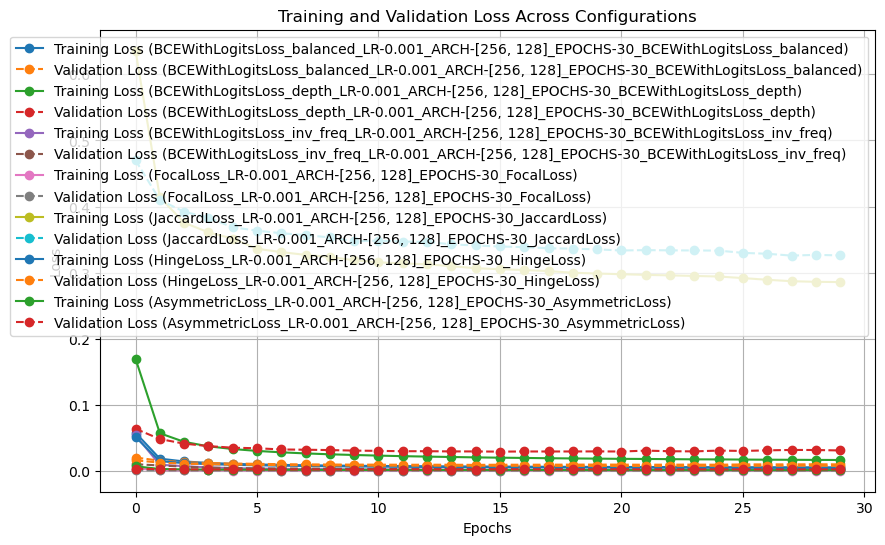


S-min @ F-max and F-max Metrics:
BCEWithLogitsLoss_balanced_LR-0.001_ARCH-[256, 128]_EPOCHS-30_BCEWithLogitsLoss_balanced -> F-max: 0.8904, S-min @ F-max: 2.2740
BCEWithLogitsLoss_depth_LR-0.001_ARCH-[256, 128]_EPOCHS-30_BCEWithLogitsLoss_depth -> F-max: 0.8904, S-min @ F-max: 2.2693
BCEWithLogitsLoss_inv_freq_LR-0.001_ARCH-[256, 128]_EPOCHS-30_BCEWithLogitsLoss_inv_freq -> F-max: 0.7853, S-min @ F-max: 3.5754
FocalLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-30_FocalLoss -> F-max: 0.8909, S-min @ F-max: 2.3063
JaccardLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-30_JaccardLoss -> F-max: 0.7703, S-min @ F-max: 6.1736
HingeLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-30_HingeLoss -> F-max: 0.8957, S-min @ F-max: 2.3322
AsymmetricLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-30_AsymmetricLoss -> F-max: 0.8929, S-min @ F-max: 2.2877
Process finished. Loss plot and metric evaluations completed.


In [ ]:
training_losses = {}
validation_losses = {}
smin_fmax_metrics = {}

threshold_range = np.arange(0.01, 1.0, 0.01)

architectures = [CHOSEN_CONFIG_ARCH]  
learning_rates = [CHOSEN_CONFIG_LR]
epoch_counts = [CHOSEN_CONFIG_EPOCHS]

loss_functions = {
    'BCEWithLogitsLoss_balanced': nn.BCEWithLogitsLoss(),
    'BCEWithLogitsLoss_depth': nn.BCEWithLogitsLoss(
        weight=torch.tensor(data_train_GO_weights_depth, dtype=torch.float).to(device)
    ),
    'BCEWithLogitsLoss_inv_freq': nn.BCEWithLogitsLoss(weight=data_train_GO_weights_inv_freq_),
    'FocalLoss': FocalLoss(),
    'JaccardLoss': JaccardLoss(),
    'HingeLoss': HingeLoss(),
    'AsymmetricLoss': AsymmetricLoss()
}

for loss_name, loss_fn in loss_functions.items():
    for lr in learning_rates:
        for arch in architectures:
            for num_epochs in epoch_counts:
                print(f"\nTraining with {loss_name}, LR: {lr}, Arch: {arch}, Epochs: {num_epochs}")

                model = FFNN(
                    input_dim=data_train_embeddings.shape[1], 
                    hidden_dims=arch, 
                    output_dim=data_train_labels.shape[1]
                )

                optimizer = optim.Adam(model.parameters(), lr=lr)

                train_losses, val_losses = train_model(
                    model, data_train_loader, data_val_loader, 
                    loss_fn, optimizer, num_epochs, device
                )

                config_key = f"{loss_name}_LR-{lr}_ARCH-{arch}_EPOCHS-{num_epochs}_{loss_name}"
                training_losses[config_key] = train_losses
                validation_losses[config_key] = val_losses

                all_preds = []
                all_targets = []
                with torch.no_grad():
                    for x_batch, y_batch in data_val_loader:
                        x_batch = x_batch.to(device)
                        outputs = model(x_batch)
                        preds = torch.sigmoid(outputs).cpu().numpy()  
                        all_preds.append(preds)
                        all_targets.append(y_batch.cpu().numpy())

                y_pred_probs = np.vstack(all_preds)
                y_true = np.vstack(all_targets)

                smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df = threshold_performance_metrics(
                    ic_dict=ic_dict,
                    y_true=y_true,
                    y_pred_probs=y_pred_probs,
                    threshold_range=threshold_range,
                    n_jobs=1,
                    mlb=data_mlb
                )

                smin_fmax_metrics[config_key] = {
                    "F-max": fmax,
                    "S-min @ F-max": s_at_fmax,
                    "Best Threshold (F-max)": best_threshold_f,
                    "Best Threshold (S-min)": best_threshold_s
                }

                results_file = f"metrics_{loss_name}_lr{lr}_arch{arch}_epochs{num_epochs}.csv"
                results_df.to_csv(results_file, index=False)
                print(f"Saved metrics to: {results_file}")

                print(f"Completed {loss_name} | Validation Loss: {val_losses[-1]:.4f}, "
                      f"Fmax: {fmax:.4f}, Smin: {smin:.4f}")

plt.figure(figsize=(10, 6))
for key in training_losses:
    plt.plot(training_losses[key], marker='o', label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], marker='o', linestyle='--', label=f'Validation Loss ({key})')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Print F-max and S-min @ F-max metrics for all configurations
print("\nS-min @ F-max and F-max Metrics:")
for config, metrics in smin_fmax_metrics.items():
    print(f"{config} -> F-max: {metrics['F-max']:.4f}, S-min @ F-max: {metrics['S-min @ F-max']:.4f}")

print("Process finished. Loss plot and metric evaluations completed.")


In [36]:
smin_fmax_metrics

{'BCEWithLogitsLoss_balanced_LR-0.001_ARCH-[256, 128]_EPOCHS-30_BCEWithLogitsLoss_balanced': {'F-max': 0.8903694469847583,
  'S-min @ F-max': 2.274028210216737,
  'Best Threshold (F-max)': 0.36000000000000004,
  'Best Threshold (S-min)': 0.31},
 'BCEWithLogitsLoss_depth_LR-0.001_ARCH-[256, 128]_EPOCHS-30_BCEWithLogitsLoss_depth': {'F-max': 0.8904453152824695,
  'S-min @ F-max': 2.2693209392532814,
  'Best Threshold (F-max)': 0.37,
  'Best Threshold (S-min)': 0.3},
 'BCEWithLogitsLoss_inv_freq_LR-0.001_ARCH-[256, 128]_EPOCHS-30_BCEWithLogitsLoss_inv_freq': {'F-max': 0.7852969048578913,
  'S-min @ F-max': 3.5754309209751294,
  'Best Threshold (F-max)': 0.37,
  'Best Threshold (S-min)': 0.32},
 'FocalLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-30_FocalLoss': {'F-max': 0.8908674690211531,
  'S-min @ F-max': 2.306301429598095,
  'Best Threshold (F-max)': 0.46,
  'Best Threshold (S-min)': 0.43},
 'JaccardLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-30_JaccardLoss': {'F-max': 0.7703176484569914,
  'S-min @ 